In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [2]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [3]:
n_samples = 500000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [4]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] +  500*["Uniform_Sorted"] + 500*["Normal"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [5]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [6]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [7]:
def TS_stationary(list_distributions, n_samples, var_multiplier = 5): # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = 5
    list_iteration_results = []

    len_result = 1

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter() #time.time()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        array_rewards = np.array(rewards)

    list_iteration_results.extend([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
def plot_rewards_distribution(arm_rewards, bins = 20):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))
    axes[0].hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    axes[0].set_title("rewards distribution for quick sort")
    axes[1].hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    axes[1].set_title("rewards distribution for merge sort")
    axes[2].hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    axes[2].set_title("rewards distribution for heap sort")
    plt.show()

In [10]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    plt.hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    plt.legend(loc='upper right')
    plt.show()

In [11]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

In [28]:
def ts_quantile(list_distributions, n_samples, var_multiplier = 1, num_consec_elem=1):
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    arm_rewards_temp = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    n_consecutive_list = [] # this list is to check whether
    list_iteration_results = []
    num_consec_elem = num_consec_elem

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=0.1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards_temp[choice])
        sample_var[choice] = np.var(arm_rewards_temp[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>10:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], 0.025) or reward > np.quantile(arm_rewards_temp[choice][:-1], 0.975):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    print("RESTART EXPERIMENT")
                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards_temp = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []
    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward, arm_rewards

## Single outlier restarts the expriment

In [29]:
list_iteration_results_1, total_reward_1, arm_rewards_1 = ts_quantile(list_distributions, n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.05339269360271862
Less than two values for merge_sort
merge_sort Theta 0.05036448039418867
Less than two values for heap_sort
heap_sort Theta 0.0959209162421294


Chosen algorithm is:  merge_sort with reward: 0.19500659999903291
Sample mean is:  0.19500659999903291 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.006750363537542892
Less than two values for merge_sort
merge_sort Theta 0.049698969747734106
Less than two values for heap_sort
heap_sort Theta 0.013956337531464524


Chosen algorithm is:  quick_sort with reward: 0.1681447000009939
Sample mean is:  0.1681447000009939 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.005551007371421979
Less than two values for merge_sort
merge_sort Theta 0.045720125089797996
Less than two values for heap_sort
heap_sort Theta 0.05988290657251023


Chosen algorithm is:  quick_sort with rewa



Chosen algorithm is:  heap_sort with reward: 0.43974669999442995
Sample mean is:  0.44262273333151825 Sample variance is: 0.00156505846954172


Iteration: 28
quick_sort Theta 0.2216614846768362
merge_sort Theta 0.17911320726981628
heap_sort Theta 0.4963537891271267


Chosen algorithm is:  merge_sort with reward: 0.22326619998784736
Sample mean is:  0.19508510000014212 Sample variance is: 0.0003909737142870482


Iteration: 29
quick_sort Theta 0.1996971065530003
merge_sort Theta 0.1775760413419708
heap_sort Theta 0.43134866087538803


Chosen algorithm is:  merge_sort with reward: 0.22018679999746382
Sample mean is:  0.20010543999960645 Sample variance is: 0.000413594226270525


Iteration: 30
quick_sort Theta 0.17631251433997652
merge_sort Theta 0.20160554888559873
heap_sort Theta 0.430547456181206


Chosen algorithm is:  quick_sort with reward: 0.19415110000409186
Sample mean is:  0.200404159995378 Sample variance is: 0.001301998883237988


Iteration: 31
quick_sort Theta 0.204978746601



Chosen algorithm is:  quick_sort with reward: 0.157397500006482
Sample mean is:  0.1739868875006323 Sample variance is: 0.000561934868524971


Iteration: 59
quick_sort Theta 0.1734081719076784
merge_sort Theta 0.20475447297120297
heap_sort Theta 0.4939069382788061


Chosen algorithm is:  quick_sort with reward: 0.14675329999590758
Sample mean is:  0.17316162727321638 Sample variance is: 0.0005667002813502747
RESTART EXPERIMENT


Iteration: 60
Less than two values for quick_sort
quick_sort Theta 0.0880028836698918
Less than two values for merge_sort
merge_sort Theta 0.07450071565365168
Less than two values for heap_sort
heap_sort Theta 0.05875800983659294


Chosen algorithm is:  heap_sort with reward: 0.3471455999970203
Sample mean is:  0.3471455999970203 Sample variance is: 0.0


Iteration: 61
Less than two values for quick_sort
quick_sort Theta 0.059086922957499545
Less than two values for merge_sort
merge_sort Theta 0.07079900356994172
Less than two values for heap_sort
heap_sort T



Chosen algorithm is:  quick_sort with reward: 0.1599564000061946
Sample mean is:  0.16910912000166717 Sample variance is: 7.844436248651701e-05


Iteration: 86
quick_sort Theta 0.15455638253293738
merge_sort Theta 0.19453215370781657
heap_sort Theta 0.41371523138814575


Chosen algorithm is:  quick_sort with reward: 0.1882962000090629
Sample mean is:  0.17230696666956646 Sample variance is: 0.0001165014186290703


Iteration: 87
quick_sort Theta 0.17198009872337489
merge_sort Theta 0.1814278116226279
heap_sort Theta 0.4014613691217583


Chosen algorithm is:  quick_sort with reward: 0.15634110000974033
Sample mean is:  0.17002612857530558 Sample variance is: 0.0001310716932983069


Iteration: 88
quick_sort Theta 0.15371128039550003
merge_sort Theta 0.18932432465858873
heap_sort Theta 0.39929650950984263


Chosen algorithm is:  quick_sort with reward: 0.16679310001200065
Sample mean is:  0.16962200000489247 Sample variance is: 0.0001158309709459876


Iteration: 89
quick_sort Theta 0.165



Chosen algorithm is:  merge_sort with reward: 0.15911379999306519
Sample mean is:  0.16786025714100106 Sample variance is: 9.224954681474633e-05


Iteration: 115
quick_sort Theta 0.19265676744935065
merge_sort Theta 0.16634491528719125
heap_sort Theta 0.44234677021405483


Chosen algorithm is:  merge_sort with reward: 0.16570230000070296
Sample mean is:  0.16771639333164784 Sample variance is: 8.638933216607918e-05


Iteration: 116
quick_sort Theta 0.1895490712625486
merge_sort Theta 0.16419201249598378
heap_sort Theta 0.5426359575273149


Chosen algorithm is:  merge_sort with reward: 0.16405870000016876
Sample mean is:  0.1674877874984304 Sample variance is: 8.177390831041486e-05


Iteration: 117
quick_sort Theta 0.16357488474163825
merge_sort Theta 0.16747791528830724
heap_sort Theta 0.47272309228731546


Chosen algorithm is:  quick_sort with reward: 0.14964830000826623
Sample mean is:  0.18618979999882868 Sample variance is: 0.0013463863532623


Iteration: 118
quick_sort Theta 0.2



Chosen algorithm is:  quick_sort with reward: 0.14439080000738613
Sample mean is:  0.14800581666834964 Sample variance is: 3.942666947932116e-05


Iteration: 144
quick_sort Theta 0.1480482197753784
merge_sort Theta 0.16413264938810485
heap_sort Theta 0.32486069184692945


Chosen algorithm is:  quick_sort with reward: 0.14079479999782052
Sample mean is:  0.14762628947516387 Sample variance is: 3.994431763860255e-05


Iteration: 145
quick_sort Theta 0.14638847378187453
merge_sort Theta 0.16664578483862677
heap_sort Theta 0.35528295773819873


Chosen algorithm is:  quick_sort with reward: 0.13752790000580717
Sample mean is:  0.14712137000169606 Sample variance is: 4.27910315757261e-05


Iteration: 146
quick_sort Theta 0.14737777803070407
merge_sort Theta 0.1685831063563416
heap_sort Theta 0.36291706435002047


Chosen algorithm is:  quick_sort with reward: 0.15944020000461023
Sample mean is:  0.14770798095421578 Sample variance is: 4.763561159777537e-05
RESTART EXPERIMENT


Iteration: 14



Chosen algorithm is:  quick_sort with reward: 0.14373080000223126
Sample mean is:  0.14373080000223126 Sample variance is: 0.0


Iteration: 172
Less than two values for quick_sort
quick_sort Theta 0.06282673185331589
merge_sort Theta 0.1574821393655174
heap_sort Theta 0.23501318276780225


Chosen algorithm is:  quick_sort with reward: 0.14034530000935774
Sample mean is:  0.1420380500057945 Sample variance is: 2.8654025504366504e-06


Iteration: 173
quick_sort Theta 0.07356717864430426
merge_sort Theta 0.16499802381260614
heap_sort Theta 0.35046539937140325


Chosen algorithm is:  quick_sort with reward: 0.14220049999130424
Sample mean is:  0.14209220000096442 Sample variance is: 1.91613281091157e-06


Iteration: 174
quick_sort Theta 0.1415398979403166
merge_sort Theta 0.1580932414427717
heap_sort Theta 0.40768039557740354


Chosen algorithm is:  quick_sort with reward: 0.12728610000340268
Sample mean is:  0.13839067500157398 Sample variance is: 4.2540961571520734e-05


Iteration: 175



Chosen algorithm is:  quick_sort with reward: 0.1620755000039935
Sample mean is:  0.1620755000039935 Sample variance is: 0.0


Iteration: 201
Less than two values for quick_sort
quick_sort Theta 0.019963758613119664
Less than two values for merge_sort
merge_sort Theta 0.003841844525856486
Less than two values for heap_sort
heap_sort Theta 0.048125599376849286


Chosen algorithm is:  merge_sort with reward: 0.17537700000684708
Sample mean is:  0.17537700000684708 Sample variance is: 0.0


Iteration: 202
Less than two values for quick_sort
quick_sort Theta 0.08211237098939665
Less than two values for merge_sort
merge_sort Theta 0.04840296286856526
Less than two values for heap_sort
heap_sort Theta 0.09592250274317593


Chosen algorithm is:  merge_sort with reward: 0.15434079999977257
Sample mean is:  0.16485890000330983 Sample variance is: 0.00011063042768441043


Iteration: 203
Less than two values for quick_sort
quick_sort Theta 0.05787798696345974
merge_sort Theta 0.1860810720235262



Chosen algorithm is:  quick_sort with reward: 0.15553829999407753
Sample mean is:  0.14907191999955102 Sample variance is: 0.00010108832206989861


Iteration: 229
quick_sort Theta 0.15952387739094073
merge_sort Theta 0.192491445927673
heap_sort Theta 0.4214285585654367


Chosen algorithm is:  quick_sort with reward: 0.1684990000067046
Sample mean is:  0.15230976666740995 Sample variance is: 0.000136658523614408


Iteration: 230
quick_sort Theta 0.1500439804031862
merge_sort Theta 0.16051310451016498
heap_sort Theta 0.4504892961457947


Chosen algorithm is:  quick_sort with reward: 0.13947629999893252
Sample mean is:  0.1504764142861989 Sample variance is: 0.0001373029631059319


Iteration: 231
quick_sort Theta 0.15078726202760942
merge_sort Theta 0.203180517155206
heap_sort Theta 0.3990464901568279


Chosen algorithm is:  quick_sort with reward: 0.1789341000112472
Sample mean is:  0.15403362500182993 Sample variance is: 0.00020871632924549245


Iteration: 232
quick_sort Theta 0.16108



Chosen algorithm is:  quick_sort with reward: 0.15937539999140427
Sample mean is:  0.1520069727266673 Sample variance is: 0.0001861485738611053


Iteration: 258
quick_sort Theta 0.15709837134587457
merge_sort Theta 0.1708194215927497
heap_sort Theta 0.3576844754497853


Chosen algorithm is:  quick_sort with reward: 0.1414097000088077
Sample mean is:  0.15112386666684566 Sample variance is: 0.00017921483214784382


Iteration: 259
quick_sort Theta 0.15279941357756996
merge_sort Theta 0.1531167451359764
heap_sort Theta 0.3554020081866453


Chosen algorithm is:  quick_sort with reward: 0.16239569999743253
Sample mean is:  0.1519909307691985 Sample variance is: 0.00017445067771984602


Iteration: 260
quick_sort Theta 0.15483688741104912
merge_sort Theta 0.1771677128848164
heap_sort Theta 0.35684353564699955


Chosen algorithm is:  quick_sort with reward: 0.15307699999539182
Sample mean is:  0.15206850714249803 Sample variance is: 0.0001620681502435973


Iteration: 261
quick_sort Theta 0.1



Chosen algorithm is:  quick_sort with reward: 0.13518589999875985
Sample mean is:  0.13379136000100214 Sample variance is: 3.4600924977853854e-05


Iteration: 287
quick_sort Theta 0.13149324421675126
merge_sort Theta 0.15231681878273165
heap_sort Theta 0.3159527420463979


Chosen algorithm is:  quick_sort with reward: 0.15375950001180172
Sample mean is:  0.1350393687516771 Sample variance is: 5.580125479315765e-05
RESTART EXPERIMENT


Iteration: 288
Less than two values for quick_sort
quick_sort Theta 0.09141242599581617
Less than two values for merge_sort
merge_sort Theta 0.08660947281241776
Less than two values for heap_sort
heap_sort Theta 0.0938562167452748


Chosen algorithm is:  merge_sort with reward: 0.144504899988533
Sample mean is:  0.144504899988533 Sample variance is: 0.0


Iteration: 289
Less than two values for quick_sort
quick_sort Theta 0.06517044984258233
Less than two values for merge_sort
merge_sort Theta 0.04741425377748988
Less than two values for heap_sort
heap_



Chosen algorithm is:  heap_sort with reward: 0.35530049999943003
Sample mean is:  0.35530049999943003 Sample variance is: 0.0


Iteration: 315
Less than two values for quick_sort
quick_sort Theta 0.09225724118195476
Less than two values for merge_sort
merge_sort Theta 0.06578771550943584
Less than two values for heap_sort
heap_sort Theta 0.011605679842692219


Chosen algorithm is:  heap_sort with reward: 0.3544254999869736
Sample mean is:  0.3548629999932018 Sample variance is: 1.914062554496923e-07


Iteration: 316
Less than two values for quick_sort
quick_sort Theta 0.031192320452875733
Less than two values for merge_sort
merge_sort Theta 0.03922644358707955
heap_sort Theta 0.354765970667531


Chosen algorithm is:  quick_sort with reward: 0.15588850001222454
Sample mean is:  0.15803310000774218 Sample variance is: 4.5993091407742515e-06


Iteration: 317
quick_sort Theta 0.1568807749921829
Less than two values for merge_sort
merge_sort Theta 0.09932492126591502
heap_sort Theta 0.354



Chosen algorithm is:  quick_sort with reward: 0.1434028999938164
Sample mean is:  0.1509418400004506 Sample variance is: 0.0003028453232390897


Iteration: 343
quick_sort Theta 0.13039570661566052
merge_sort Theta 0.21214152470619402
heap_sort Theta 0.3849130199812678


Chosen algorithm is:  quick_sort with reward: 0.1638970999920275
Sample mean is:  0.15211959090877578 Sample variance is: 0.00028918490223796197


Iteration: 344
quick_sort Theta 0.15975793274344394
merge_sort Theta 0.2077269125249255
heap_sort Theta 0.39505103750512105


Chosen algorithm is:  quick_sort with reward: 0.16203540000424255
Sample mean is:  0.15294590833339802 Sample variance is: 0.000272596965733376


Iteration: 345
quick_sort Theta 0.14897894135861178
merge_sort Theta 0.20987947273274954
heap_sort Theta 0.4224560368264229


Chosen algorithm is:  quick_sort with reward: 0.14478950000193436
Sample mean is:  0.15231849230790082 Sample variance is: 0.00025635177879787855


Iteration: 346
quick_sort Theta 0.



Chosen algorithm is:  quick_sort with reward: 0.1349707000044873
Sample mean is:  0.15066290499962634 Sample variance is: 0.00012434439818982763
RESTART EXPERIMENT


Iteration: 372
Less than two values for quick_sort
quick_sort Theta 0.016042317330587596
Less than two values for merge_sort
merge_sort Theta 0.08910735139562581
Less than two values for heap_sort
heap_sort Theta 0.031388714193092505


Chosen algorithm is:  quick_sort with reward: 0.14868050000222865
Sample mean is:  0.14868050000222865 Sample variance is: 0.0


Iteration: 373
Less than two values for quick_sort
quick_sort Theta 0.05202355614707861
Less than two values for merge_sort
merge_sort Theta 0.04692075117868463
Less than two values for heap_sort
heap_sort Theta 0.05800491038522872


Chosen algorithm is:  merge_sort with reward: 0.1563460000033956
Sample mean is:  0.1563460000033956 Sample variance is: 0.0


Iteration: 374
Less than two values for quick_sort
quick_sort Theta 0.01577421490611842
Less than two valu



Chosen algorithm is:  merge_sort with reward: 0.14559279999230057
Sample mean is:  0.16656164444187502 Sample variance is: 0.0008516192842453143


Iteration: 401
quick_sort Theta 0.15995401276629517
merge_sort Theta 0.16817922000188895
heap_sort Theta 0.3324490741735994


Chosen algorithm is:  quick_sort with reward: 0.14795450000383426
Sample mean is:  0.1529766000013823 Sample variance is: 0.00026256288905614005


Iteration: 402
quick_sort Theta 0.15511445747206434
merge_sort Theta 0.15750218051749543
heap_sort Theta 0.3355193938284599


Chosen algorithm is:  quick_sort with reward: 0.13062310000532307
Sample mean is:  0.15185892500157933 Sample variance is: 0.0002731694953018395


Iteration: 403
quick_sort Theta 0.15009232955221594
merge_sort Theta 0.1816942897845043
heap_sort Theta 0.3342972527632187


Chosen algorithm is:  quick_sort with reward: 0.12199839999084361
Sample mean is:  0.15043699523916335 Sample variance is: 0.0003005991090818777
RESTART EXPERIMENT


Iteration: 404



Chosen algorithm is:  merge_sort with reward: 0.24739319999935105
Sample mean is:  0.18839603333132496 Sample variance is: 0.0017549478564637168


Iteration: 428
quick_sort Theta 0.16610755462583343
merge_sort Theta 0.21978273608798007
heap_sort Theta 0.38738422739869016


Chosen algorithm is:  quick_sort with reward: 0.1475748999946518
Sample mean is:  0.1583778499989421 Sample variance is: 0.00048158800804144194


Iteration: 429
quick_sort Theta 0.14525716740000086
merge_sort Theta 0.1446389692159423
heap_sort Theta 0.3665441077720582


Chosen algorithm is:  merge_sort with reward: 0.18168470000091475
Sample mean is:  0.1867181999987224 Sample variance is: 0.0013246562664237641


Iteration: 430
quick_sort Theta 0.14715550463248597
merge_sort Theta 0.1431148688384582
heap_sort Theta 0.37238409526858934


Chosen algorithm is:  merge_sort with reward: 0.23949740000534803
Sample mean is:  0.19727404000004753 Sample variance is: 0.0015054280456733137


Iteration: 431
quick_sort Theta 0.



Chosen algorithm is:  merge_sort with reward: 0.1644603000022471
Sample mean is:  0.1806277666716293 Sample variance is: 0.000337881249960866


Iteration: 457
quick_sort Theta 0.1707627659770954
merge_sort Theta 0.1758809395221142
heap_sort Theta 0.3199629042308329


Chosen algorithm is:  quick_sort with reward: 0.14966469998762477
Sample mean is:  0.16779143333284688 Sample variance is: 0.0008102617498792334


Iteration: 458
quick_sort Theta 0.1799385663732493
merge_sort Theta 0.16914132051453235
heap_sort Theta 0.412066520585592


Chosen algorithm is:  merge_sort with reward: 0.16322590000345372
Sample mean is:  0.1762773000045854 Sample variance is: 0.0003101906181338297


Iteration: 459
quick_sort Theta 0.17223204608266782
merge_sort Theta 0.17249596670899592
heap_sort Theta 0.35222101270640255


Chosen algorithm is:  quick_sort with reward: 0.18358440000156406
Sample mean is:  0.16900627692274822 Sample variance is: 0.0007656440623405382


Iteration: 460
quick_sort Theta 0.16962


Chosen algorithm is:  quick_sort with reward: 0.13929980000830255
Sample mean is:  0.1487919538474391 Sample variance is: 0.00035000072635481245


Iteration: 486
quick_sort Theta 0.146745896397657
merge_sort Theta 0.16415432382602624
heap_sort Theta 0.3896216485573265


Chosen algorithm is:  quick_sort with reward: 0.14187609999498818
Sample mean is:  0.14829796428654976 Sample variance is: 0.0003281730083938053


Iteration: 487
quick_sort Theta 0.14607556181368572
merge_sort Theta 0.17508384554380704
heap_sort Theta 0.39374146783046704


Chosen algorithm is:  quick_sort with reward: 0.1370753999945009
Sample mean is:  0.1475497933337465 Sample variance is: 0.00031413144467887775


Iteration: 488
quick_sort Theta 0.14150898121227362
merge_sort Theta 0.17813060057051094
heap_sort Theta 0.38630398209415817


Chosen algorithm is:  quick_sort with reward: 0.12434690000372939
Sample mean is:  0.14609961250062042 Sample variance is: 0.0003260435961179411
RESTART EXPERIMENT


Iteration: 489




Iteration: 513
Less than two values for quick_sort
quick_sort Theta 0.03155647744566711
merge_sort Theta 0.03641293168387977
Less than two values for heap_sort
heap_sort Theta 0.046473037975272746


Chosen algorithm is:  quick_sort with reward: 0.04166380000242498
Sample mean is:  0.044374199998856056 Sample variance is: 7.346268140653592e-06


Iteration: 514
quick_sort Theta 0.04605769673557102
merge_sort Theta 0.034876808722095254
Less than two values for heap_sort
heap_sort Theta 0.015800659848885134


Chosen algorithm is:  heap_sort with reward: 0.12127590000454802
Sample mean is:  0.10911090000445256 Sample variance is: 0.00014798722500232255


Iteration: 515
quick_sort Theta 0.043257580039606655
merge_sort Theta 0.03550424603344577
heap_sort Theta 0.16104205881826586


Chosen algorithm is:  merge_sort with reward: 0.038671200003591366
Sample mean is:  0.03695665000122972 Sample variance is: 2.4763359423945162e-06


Iteration: 516
quick_sort Theta 0.04357978686928361
merge_sort 



Iteration: 542
quick_sort Theta 0.04598313127360869
merge_sort Theta 0.03895926890657521
heap_sort Theta 0.0976334729130207


Chosen algorithm is:  merge_sort with reward: 0.037449900002684444
Sample mean is:  0.037736499994935 Sample variance is: 4.0603399115310155e-06


Iteration: 543
quick_sort Theta 0.04460114383587222
merge_sort Theta 0.040183025459464894
heap_sort Theta 0.09132381985080146


Chosen algorithm is:  merge_sort with reward: 0.03193570001167245
Sample mean is:  0.03690781428304035 Sample variance is: 7.600611407330927e-06


Iteration: 544
quick_sort Theta 0.0451950945070115
merge_sort Theta 0.037673336801519
heap_sort Theta 0.09225812104898148


Chosen algorithm is:  merge_sort with reward: 0.03685530000075232
Sample mean is:  0.03690124999775435 Sample variance is: 6.6508366103037735e-06


Iteration: 545
quick_sort Theta 0.04617378385263143
merge_sort Theta 0.038491856455284676
heap_sort Theta 0.09430043370372142


Chosen algorithm is:  merge_sort with reward: 0.03



Chosen algorithm is:  heap_sort with reward: 0.09203830000478774
Sample mean is:  0.09570155000255909 Sample variance is: 1.341940054617176e-05


Iteration: 571
quick_sort Theta 0.048062857130888564
merge_sort Theta 0.039723839230707554
heap_sort Theta 0.08667651974451203


Chosen algorithm is:  merge_sort with reward: 0.037476600002264604
Sample mean is:  0.03808517499783193 Sample variance is: 3.406498096835713e-06


Iteration: 572
quick_sort Theta 0.04558824456334279
merge_sort Theta 0.0427776699168895
heap_sort Theta 0.10524946756898472


Chosen algorithm is:  merge_sort with reward: 0.03592150000622496
Sample mean is:  0.03765243999951053 Sample variance is: 3.474236792557437e-06


Iteration: 573
quick_sort Theta 0.04853816988716019
merge_sort Theta 0.038493957576753564
heap_sort Theta 0.02956181529904911


Chosen algorithm is:  heap_sort with reward: 0.0982707999937702
Sample mean is:  0.09655796666629612 Sample variance is: 1.0413166034634124e-05


Iteration: 574
quick_sort Th



Iteration: 599
quick_sort Theta 0.06816760867593796
merge_sort Theta 0.05983391302040786
heap_sort Theta 0.1102922330822551


Chosen algorithm is:  merge_sort with reward: 0.04964519999339245
Sample mean is:  0.05633372499869438 Sample variance is: 0.00030697888528123467


Iteration: 600
quick_sort Theta 0.06086768162692109
merge_sort Theta 0.05360687273527782
heap_sort Theta 0.10975223568453574


Chosen algorithm is:  merge_sort with reward: 0.04774049999832641
Sample mean is:  0.05537892222087572 Sample variance is: 0.00028016330700622827


Iteration: 601
quick_sort Theta 0.07846101347709084
merge_sort Theta 0.04949086087500758
heap_sort Theta 0.12481252213990351


Chosen algorithm is:  merge_sort with reward: 0.042242700001224875
Sample mean is:  0.05406529999891063 Sample variance is: 0.0002676774063839698


Iteration: 602
quick_sort Theta 0.06579427225310744
merge_sort Theta 0.052663688663140605
heap_sort Theta 0.11216621858987691


Chosen algorithm is:  merge_sort with reward: 


Iteration: 627
quick_sort Theta 0.06944419903350209
merge_sort Theta 0.03768714681244309
heap_sort Theta 0.12258410380672707


Chosen algorithm is:  merge_sort with reward: 0.04146459999901708
Sample mean is:  0.05024740000538129 Sample variance is: 0.00014544562284175057


Iteration: 628
quick_sort Theta 0.06854587840636765
merge_sort Theta 0.04643441712245119
heap_sort Theta 0.11324104157028456


Chosen algorithm is:  merge_sort with reward: 0.05210580000129994
Sample mean is:  0.05047970000487112 Sample variance is: 0.0001276426630148726


Iteration: 629
quick_sort Theta 0.07110217265579484
merge_sort Theta 0.04739958439193808
heap_sort Theta 0.11201555774528063


Chosen algorithm is:  merge_sort with reward: 0.041850100009469315
Sample mean is:  0.049520855560937584 Sample variance is: 0.00012081520624340665


Iteration: 630
quick_sort Theta 0.07013040595468548
merge_sort Theta 0.05014190540839359
heap_sort Theta 0.11257688992247974


Chosen algorithm is:  merge_sort with reward: 



Chosen algorithm is:  heap_sort with reward: 0.09718660000362433
Sample mean is:  0.09718660000362433 Sample variance is: 0.0


Iteration: 655
Less than two values for quick_sort
quick_sort Theta 0.09871437373645442
merge_sort Theta 0.047249209616355155
Less than two values for heap_sort
heap_sort Theta 0.059383041415303144


Chosen algorithm is:  merge_sort with reward: 0.045652000000700355
Sample mean is:  0.04503633333176064 Sample variance is: 6.965085400533553e-06


Iteration: 656
Less than two values for quick_sort
quick_sort Theta 0.009339483255383007
merge_sort Theta 0.045774709797785716
Less than two values for heap_sort
heap_sort Theta 0.09881082802444258


Chosen algorithm is:  quick_sort with reward: 0.04348149998986628
Sample mean is:  0.04348149998986628 Sample variance is: 0.0


Iteration: 657
Less than two values for quick_sort
quick_sort Theta 0.037918968799391696
merge_sort Theta 0.04468234902291802
Less than two values for heap_sort
heap_sort Theta 0.03827708985617



Iteration: 683
quick_sort Theta 0.06012340533280579
merge_sort Theta 0.03879362343814629
heap_sort Theta 0.09723905372119881


Chosen algorithm is:  merge_sort with reward: 0.039187100002891384
Sample mean is:  0.037275100004990236 Sample variance is: 6.621779048617071e-06


Iteration: 684
quick_sort Theta 0.05524425068274299
merge_sort Theta 0.03661770177506874
heap_sort Theta 0.09755989181590657


Chosen algorithm is:  merge_sort with reward: 0.037397199994302355
Sample mean is:  0.03728866667046936 Sample variance is: 5.887498256290732e-06


Iteration: 685
quick_sort Theta 0.04816172605664449
merge_sort Theta 0.037108960937959554
heap_sort Theta 0.10438596133824071


Chosen algorithm is:  merge_sort with reward: 0.03847549999773037
Sample mean is:  0.037407350003195464 Sample variance is: 5.425520031864428e-06


Iteration: 686
quick_sort Theta 0.0669458590414136
merge_sort Theta 0.036610532768655
heap_sort Theta 0.09791755952184478


Chosen algorithm is:  merge_sort with reward: 0



Iteration: 710
quick_sort Theta 0.04573105611649944
Less than two values for merge_sort
merge_sort Theta 0.07393418222133728
Less than two values for heap_sort
heap_sort Theta 0.03046623168107575


Chosen algorithm is:  heap_sort with reward: 0.09740659999079071
Sample mean is:  0.11086919999070233 Sample variance is: 0.0001812415987576203


Iteration: 711
quick_sort Theta 0.04905607910167599
Less than two values for merge_sort
merge_sort Theta 0.05347958630489368
heap_sort Theta 0.37359907672585607


Chosen algorithm is:  quick_sort with reward: 0.055003100002068095
Sample mean is:  0.05072209999586145 Sample variance is: 1.061016294238919e-05


Iteration: 712
quick_sort Theta 0.050606467171949714
Less than two values for merge_sort
merge_sort Theta 0.09179252599742864
heap_sort Theta 0.10401868027713085


Chosen algorithm is:  quick_sort with reward: 0.06857780000427738
Sample mean is:  0.05518602499796543 Sample variance is: 6.773750148001899e-05


Iteration: 713
quick_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.04844160001084674
Sample mean is:  0.04844160001084674 Sample variance is: 0.0


Iteration: 739
Less than two values for quick_sort
quick_sort Theta 0.06419569644256037
Less than two values for merge_sort
merge_sort Theta 0.018815654573772003
Less than two values for heap_sort
heap_sort Theta 0.09689085671115032


Chosen algorithm is:  merge_sort with reward: 0.039097200002288446
Sample mean is:  0.039097200002288446 Sample variance is: 0.0


Iteration: 740
Less than two values for quick_sort
quick_sort Theta 0.0927389451575844
Less than two values for merge_sort
merge_sort Theta 0.020280299504676413
Less than two values for heap_sort
heap_sort Theta 0.0389971607391024


Chosen algorithm is:  merge_sort with reward: 0.03556099999696016
Sample mean is:  0.037329099999624304 Sample variance is: 3.1261776194209365e-06


Iteration: 741
Less than two values for quick_sort
quick_sort Theta 0.08624934135786182
merge_sort Theta 0.03743353461535



Chosen algorithm is:  merge_sort with reward: 0.040007799994782545
Sample mean is:  0.042875750002470646 Sample variance is: 2.0195939408124185e-05


Iteration: 766
quick_sort Theta 0.0641047668668257
merge_sort Theta 0.037050235233972606
Less than two values for heap_sort
heap_sort Theta 0.02991059624117458


Chosen algorithm is:  heap_sort with reward: 0.12698879999516066
Sample mean is:  0.11284670000168262 Sample variance is: 0.00019999899222553161


Iteration: 767
quick_sort Theta 0.04558009516048203
merge_sort Theta 0.050332087343626035
heap_sort Theta 0.11915636765076287


Chosen algorithm is:  quick_sort with reward: 0.04854740000155289
Sample mean is:  0.047895566667042054 Sample variance is: 1.3326193841474453e-06


Iteration: 768
quick_sort Theta 0.04494088280047649
merge_sort Theta 0.04348659863242801
heap_sort Theta 0.1268978229136463


Chosen algorithm is:  merge_sort with reward: 0.03836139998747967
Sample mean is:  0.04223084285747193 Sample variance is: 1.98062365609


Iteration: 794
Less than two values for quick_sort
quick_sort Theta 0.005444269402248692
merge_sort Theta 0.03977923217532943
heap_sort Theta 0.10996205951637977


Chosen algorithm is:  quick_sort with reward: 0.06345070000679698
Sample mean is:  0.05771115000243299 Sample variance is: 3.2942434252594696e-05


Iteration: 795
quick_sort Theta 0.05215630029632386
merge_sort Theta 0.040579884179296234
heap_sort Theta 0.09853372157488498


Chosen algorithm is:  merge_sort with reward: 0.04512769999564625
Sample mean is:  0.04005618571370308 Sample variance is: 7.890920082235116e-06


Iteration: 796
quick_sort Theta 0.05682163300442886
merge_sort Theta 0.04089328820645608
heap_sort Theta 0.09955173359415705


Chosen algorithm is:  merge_sort with reward: 0.04516110000258777
Sample mean is:  0.040694299999813666 Sample variance is: 9.754883966924695e-06


Iteration: 797
quick_sort Theta 0.06337589411363352
merge_sort Theta 0.03864974920042742
heap_sort Theta 0.09778016363270811


Chosen alg


Iteration: 822
quick_sort Theta 0.05873362881026447
merge_sort Theta 0.04102365504981216
heap_sort Theta 0.09968111588766963


Chosen algorithm is:  merge_sort with reward: 0.03822810000565369
Sample mean is:  0.04172809374995268 Sample variance is: 2.2198067737681814e-05


Iteration: 823
quick_sort Theta 0.05469474816893182
merge_sort Theta 0.04227198704798802
heap_sort Theta 0.10349083030853283


Chosen algorithm is:  merge_sort with reward: 0.039230599999427795
Sample mean is:  0.041581182352862976 Sample variance is: 2.12376263847475e-05


Iteration: 824
quick_sort Theta 0.05494666244240191
merge_sort Theta 0.04264161158094522
heap_sort Theta 0.10407845445820187


Chosen algorithm is:  merge_sort with reward: 0.04010470000503119
Sample mean is:  0.04149915555576121 Sample variance is: 2.0172140974788693e-05


Iteration: 825
quick_sort Theta 0.054528170535865735
merge_sort Theta 0.041134945257226836
heap_sort Theta 0.10129593449455411


Chosen algorithm is:  merge_sort with reward:



Iteration: 849
Less than two values for quick_sort
quick_sort Theta 0.059194751367703594
Less than two values for merge_sort
merge_sort Theta 0.08838228482652219
heap_sort Theta 0.12614025570466061


Chosen algorithm is:  quick_sort with reward: 0.04680129999178462
Sample mean is:  0.04680129999178462 Sample variance is: 0.0


Iteration: 850
Less than two values for quick_sort
quick_sort Theta 0.04744603334088934
Less than two values for merge_sort
merge_sort Theta 0.07862060125907319
heap_sort Theta 0.26501255715529537


Chosen algorithm is:  quick_sort with reward: 0.07504419999895617
Sample mean is:  0.060922749995370395 Sample variance is: 0.0001994153502037728


Iteration: 851
quick_sort Theta 0.05376862205072494
Less than two values for merge_sort
merge_sort Theta 0.003249910641809417
heap_sort Theta 0.1263665027560866


Chosen algorithm is:  merge_sort with reward: 0.04395360000489745
Sample mean is:  0.045632900000782683 Sample variance is: 2.8200484761801353e-06


Iteration:


Iteration: 877
quick_sort Theta 0.05877294365853654
merge_sort Theta 0.04355660630972724
heap_sort Theta 0.10889495309077701


Chosen algorithm is:  merge_sort with reward: 0.05117449999670498
Sample mean is:  0.045404349999444094 Sample variance is: 1.1701622281047961e-05


Iteration: 878
quick_sort Theta 0.05806894095798834
merge_sort Theta 0.04670222863824511
heap_sort Theta 0.0858489449434186


Chosen algorithm is:  merge_sort with reward: 0.04532420000759885
Sample mean is:  0.045388320001075046 Sample variance is: 9.362325668229215e-06


Iteration: 879
quick_sort Theta 0.0743902705957549
merge_sort Theta 0.044098930901701305
heap_sort Theta 0.12100152878708349


Chosen algorithm is:  merge_sort with reward: 0.043902799996430986
Sample mean is:  0.045140733333634366 Sample variance is: 8.108433846329582e-06


Iteration: 880
quick_sort Theta 0.06586919917288744
merge_sort Theta 0.04429790080750928
heap_sort Theta 0.13318340989411592


Chosen algorithm is:  merge_sort with reward: 


Chosen algorithm is:  merge_sort with reward: 0.037104399991221726
Sample mean is:  0.040784526666781555 Sample variance is: 1.374445307832754e-05


Iteration: 906
quick_sort Theta 0.05008594086056961
merge_sort Theta 0.040862997833199216
heap_sort Theta 0.11406231474627235


Chosen algorithm is:  merge_sort with reward: 0.03289560000121128
Sample mean is:  0.04029146875018341 Sample variance is: 1.6532016397733577e-05
RESTART EXPERIMENT


Iteration: 907
Less than two values for quick_sort
quick_sort Theta 0.05592039102413159
Less than two values for merge_sort
merge_sort Theta 0.011649720643287854
Less than two values for heap_sort
heap_sort Theta 0.02388379325584168


Chosen algorithm is:  merge_sort with reward: 0.040705500010517426
Sample mean is:  0.040705500010517426 Sample variance is: 0.0


Iteration: 908
Less than two values for quick_sort
quick_sort Theta 0.09661266095029847
Less than two values for merge_sort
merge_sort Theta 0.054882814792786616
Less than two values for he



Iteration: 934
Less than two values for quick_sort
quick_sort Theta 0.07550909352905938
Less than two values for merge_sort
merge_sort Theta 0.03597847278063652
Less than two values for heap_sort
heap_sort Theta 0.05970816806977108


Chosen algorithm is:  merge_sort with reward: 0.03813109999464359
Sample mean is:  0.03813109999464359 Sample variance is: 0.0


Iteration: 935
Less than two values for quick_sort
quick_sort Theta 0.06574317085823911
Less than two values for merge_sort
merge_sort Theta 0.08852560991729241
Less than two values for heap_sort
heap_sort Theta 0.0925099405370397


Chosen algorithm is:  quick_sort with reward: 0.054645500000333413
Sample mean is:  0.054645500000333413 Sample variance is: 0.0


Iteration: 936
Less than two values for quick_sort
quick_sort Theta 0.07461083244893296
Less than two values for merge_sort
merge_sort Theta 0.04647528305268243
Less than two values for heap_sort
heap_sort Theta 0.023982367810118466


Chosen algorithm is:  heap_sort with



Chosen algorithm is:  merge_sort with reward: 0.044304999988526106
Sample mean is:  0.04623967083413542 Sample variance is: 3.58992442933765e-05


Iteration: 962
quick_sort Theta 0.05763358365336153
merge_sort Theta 0.04481717902471864
heap_sort Theta 0.10595143588097646


Chosen algorithm is:  merge_sort with reward: 0.04387680000218097
Sample mean is:  0.046145156000857245 Sample variance is: 3.467766781067188e-05


Iteration: 963
quick_sort Theta 0.05986019001459734
merge_sort Theta 0.04871189494800151
heap_sort Theta 0.1062054332338453


Chosen algorithm is:  merge_sort with reward: 0.038038499988033436
Sample mean is:  0.04583336153882556 Sample variance is: 3.577430602025597e-05
RESTART EXPERIMENT


Iteration: 964
Less than two values for quick_sort
quick_sort Theta 0.01860834715652523
Less than two values for merge_sort
merge_sort Theta 0.06427993860936304
Less than two values for heap_sort
heap_sort Theta 0.04649701614397616


Chosen algorithm is:  quick_sort with reward: 0.0


Iteration: 988
quick_sort Theta 0.05090808217758066
Less than two values for merge_sort
merge_sort Theta 0.02802817821882261
heap_sort Theta 0.12545915661351908


Chosen algorithm is:  merge_sort with reward: 0.04780899999605026
Sample mean is:  0.04780899999605026 Sample variance is: 0.0


Iteration: 989
quick_sort Theta 0.05284312832335301
Less than two values for merge_sort
merge_sort Theta 0.07122683823870678
heap_sort Theta 0.10625481886424927


Chosen algorithm is:  quick_sort with reward: 0.07284849999996368
Sample mean is:  0.05562011666188482 Sample variance is: 6.280001404960295e-05


Iteration: 990
quick_sort Theta 0.047187596142299185
Less than two values for merge_sort
merge_sort Theta 0.002362688365264576
heap_sort Theta 0.08065581646954237


Chosen algorithm is:  merge_sort with reward: 0.040437400006339885
Sample mean is:  0.04412320000119507 Sample variance is: 1.3585121602074502e-05


Iteration: 991
quick_sort Theta 0.054285116409060585
merge_sort Theta 0.03906797329



Chosen algorithm is:  heap_sort with reward: 0.3274654999986524
Sample mean is:  0.3274654999986524 Sample variance is: 0.0


Iteration: 1017
Less than two values for quick_sort
quick_sort Theta 0.010648850488182204
Less than two values for merge_sort
merge_sort Theta 0.0014257485555941197
Less than two values for heap_sort
heap_sort Theta 0.01110211151754703


Chosen algorithm is:  merge_sort with reward: 0.162487699999474
Sample mean is:  0.162487699999474 Sample variance is: 0.0


Iteration: 1018
Less than two values for quick_sort
quick_sort Theta 0.020987088502797714
Less than two values for merge_sort
merge_sort Theta 0.08958851568822386
Less than two values for heap_sort
heap_sort Theta 0.024151606574499752


Chosen algorithm is:  quick_sort with reward: 0.15353049999976065
Sample mean is:  0.15353049999976065 Sample variance is: 0.0


Iteration: 1019
Less than two values for quick_sort
quick_sort Theta 0.08222811929540257
Less than two values for merge_sort
merge_sort Theta 0



Chosen algorithm is:  merge_sort with reward: 0.1527427999972133
Sample mean is:  0.20532702499622246 Sample variance is: 0.0017182553441122054


Iteration: 1044
quick_sort Theta 0.20639529916783803
merge_sort Theta 0.20655069697680856
heap_sort Theta 0.4103626574743822


Chosen algorithm is:  quick_sort with reward: 0.1816516000108095
Sample mean is:  0.18767318000318484 Sample variance is: 0.0007305873072838661


Iteration: 1045
quick_sort Theta 0.21473341822045064
merge_sort Theta 0.2062396400162864
heap_sort Theta 0.4850589076282391


Chosen algorithm is:  merge_sort with reward: 0.1730502999998862
Sample mean is:  0.1988716799969552 Sample variance is: 0.0015412901915280235


Iteration: 1046
quick_sort Theta 0.19176163071846558
merge_sort Theta 0.3065365078534285
heap_sort Theta 0.37181574837004994


Chosen algorithm is:  quick_sort with reward: 0.1482495999953244
Sample mean is:  0.1811025833352081 Sample variance is: 0.0008246864589360236


Iteration: 1047
quick_sort Theta 0.1



Chosen algorithm is:  quick_sort with reward: 0.18022400001063943
Sample mean is:  0.18123479090916755 Sample variance is: 0.000860412218114168


Iteration: 1073
quick_sort Theta 0.17626088267653248
merge_sort Theta 0.2213022184626548
heap_sort Theta 0.3728588200921609


Chosen algorithm is:  quick_sort with reward: 0.2225722000002861
Sample mean is:  0.1846795750000941 Sample variance is: 0.0009192431117020943


Iteration: 1074
quick_sort Theta 0.2003370906638794
merge_sort Theta 0.2064385608406547
heap_sort Theta 0.36013353009947874


Chosen algorithm is:  quick_sort with reward: 0.16710079999757
Sample mean is:  0.18332736153836146 Sample variance is: 0.0008704738780627166


Iteration: 1075
quick_sort Theta 0.17693510156542633
merge_sort Theta 0.1916053022671945
heap_sort Theta 0.3630011704134249


Chosen algorithm is:  quick_sort with reward: 0.15498289999959525
Sample mean is:  0.1813027571427353 Sample variance is: 0.0008615844709510621


Iteration: 1076
quick_sort Theta 0.1712



Chosen algorithm is:  quick_sort with reward: 0.15158800000790507
Sample mean is:  0.1542104666683978 Sample variance is: 8.54839384090698e-06


Iteration: 1102
quick_sort Theta 0.15729998778248983
merge_sort Theta 0.16886085410321608
heap_sort Theta 0.34371567742365394


Chosen algorithm is:  quick_sort with reward: 0.16536199999973178
Sample mean is:  0.1569983500012313 Sample variance is: 2.972817581315258e-05


Iteration: 1103
quick_sort Theta 0.1569886602908599
merge_sort Theta 0.16543739809605323
heap_sort Theta 0.3435295151952233


Chosen algorithm is:  quick_sort with reward: 0.1472766000078991
Sample mean is:  0.15505400000256486 Sample variance is: 3.890452831977879e-05


Iteration: 1104
quick_sort Theta 0.15669360687552608
merge_sort Theta 0.16408784156891512
heap_sort Theta 0.34347913124138535


Chosen algorithm is:  quick_sort with reward: 0.1538047999929404
Sample mean is:  0.1548458000009608 Sample variance is: 3.263717646982202e-05


Iteration: 1105
quick_sort Theta 0



Chosen algorithm is:  quick_sort with reward: 0.15728179999860004
Sample mean is:  0.15365325000129815 Sample variance is: 1.4245290101734673e-05


Iteration: 1131
quick_sort Theta 0.15702916771043418
merge_sort Theta 0.16402374627850397
heap_sort Theta 0.36850114878393975


Chosen algorithm is:  quick_sort with reward: 0.15754800000286195
Sample mean is:  0.1540860000014719 Sample variance is: 1.4160660591633906e-05


Iteration: 1132
quick_sort Theta 0.14950165584614422
merge_sort Theta 0.1640156734354152
heap_sort Theta 0.36863275025479786


Chosen algorithm is:  quick_sort with reward: 0.14457170000241604
Sample mean is:  0.15313457000156633 Sample variance is: 2.0891565934953618e-05


Iteration: 1133
quick_sort Theta 0.15265808270788875
merge_sort Theta 0.15861073145010568
heap_sort Theta 0.3680420894863046


Chosen algorithm is:  quick_sort with reward: 0.1344227000081446
Sample mean is:  0.15143349091125524 Sample variance is: 4.7929033383074864e-05
RESTART EXPERIMENT


Iterati



Chosen algorithm is:  quick_sort with reward: 0.14879660001315642
Sample mean is:  0.15293299047611764 Sample variance is: 0.00011080566372350178


Iteration: 1160
quick_sort Theta 0.15282017097608847
merge_sort Theta 0.16637665359519554
heap_sort Theta 0.36365185821304635


Chosen algorithm is:  quick_sort with reward: 0.14114830001199152
Sample mean is:  0.15239732272774828 Sample variance is: 0.00011179478131466609
RESTART EXPERIMENT


Iteration: 1161
Less than two values for quick_sort
quick_sort Theta 0.03345260581163602
Less than two values for merge_sort
merge_sort Theta 0.05741830786828505
Less than two values for heap_sort
heap_sort Theta 0.0072166731260915


Chosen algorithm is:  heap_sort with reward: 0.3690677999984473
Sample mean is:  0.3690677999984473 Sample variance is: 0.0


Iteration: 1162
Less than two values for quick_sort
quick_sort Theta 0.07891627696274606
Less than two values for merge_sort
merge_sort Theta 0.08484140312294293
Less than two values for heap_sor



Chosen algorithm is:  quick_sort with reward: 0.14876070000173058
Sample mean is:  0.14878868000232615 Sample variance is: 3.89047815701389e-05


Iteration: 1187
quick_sort Theta 0.1494266859131355
merge_sort Theta 0.1635815811949255
heap_sort Theta 0.347758029850215


Chosen algorithm is:  quick_sort with reward: 0.15125530000659637
Sample mean is:  0.14919978333637118 Sample variance is: 3.326568106476382e-05


Iteration: 1188
quick_sort Theta 0.1497981118484186
merge_sort Theta 0.16612430705330344
heap_sort Theta 0.34853524572659766


Chosen algorithm is:  quick_sort with reward: 0.14195059999474324
Sample mean is:  0.14816418571613862 Sample variance is: 3.494821549884278e-05


Iteration: 1189
quick_sort Theta 0.1460527310204796
merge_sort Theta 0.1681394918839673
heap_sort Theta 0.34751003461885444


Chosen algorithm is:  quick_sort with reward: 0.14675440000428353
Sample mean is:  0.14798796250215673 Sample variance is: 3.0797070909510174e-05


Iteration: 1190
quick_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.17006980000587646
Sample mean is:  0.17006980000587646 Sample variance is: 0.0


Iteration: 1215
Less than two values for quick_sort
quick_sort Theta 0.09171876229426773
Less than two values for merge_sort
merge_sort Theta 0.006033688545976967
Less than two values for heap_sort
heap_sort Theta 0.03223191794140177


Chosen algorithm is:  merge_sort with reward: 0.19080279998888727
Sample mean is:  0.19080279998888727 Sample variance is: 0.0


Iteration: 1216
Less than two values for quick_sort
quick_sort Theta 0.01788697859372366
Less than two values for merge_sort
merge_sort Theta 0.07538916897558993
Less than two values for heap_sort
heap_sort Theta 0.044583972608632644


Chosen algorithm is:  quick_sort with reward: 0.17099050000251736
Sample mean is:  0.1705301500041969 Sample variance is: 2.1192212095364096e-07


Iteration: 1217
quick_sort Theta 0.16612643152972056
Less than two values for merge_sort
merge_sort Theta 0.0635986274970



Chosen algorithm is:  quick_sort with reward: 0.1570112000044901
Sample mean is:  0.14872107500195852 Sample variance is: 7.959270033272459e-05


Iteration: 1242
quick_sort Theta 0.14961280542162894
merge_sort Theta 0.16950976786679697
heap_sort Theta 0.3538967693404327


Chosen algorithm is:  quick_sort with reward: 0.19304980000015348
Sample mean is:  0.15758682000159752 Sample variance is: 0.0003780798978606748


Iteration: 1243
quick_sort Theta 0.17738758555354614
merge_sort Theta 0.16837537222903737
heap_sort Theta 0.35360107198862023


Chosen algorithm is:  merge_sort with reward: 0.16734559999895282
Sample mean is:  0.1670767666704099 Sample variance is: 6.702264102811713e-06


Iteration: 1244
quick_sort Theta 0.1451667686574353
merge_sort Theta 0.17507337758065233
heap_sort Theta 0.3566190107843027


Chosen algorithm is:  quick_sort with reward: 0.15151429999968968
Sample mean is:  0.1565747333346129 Sample variance is: 0.0003201881786580027


Iteration: 1245
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.1515516000072239
Sample mean is:  0.15236372727359235 Sample variance is: 0.00014243225074949878


Iteration: 1272
quick_sort Theta 0.1528958847009488
merge_sort Theta 0.16822595221820622
heap_sort Theta 0.35415654545037006


Chosen algorithm is:  quick_sort with reward: 0.1515155999950366
Sample mean is:  0.15233878235363485 Sample variance is: 0.000138263601121971


Iteration: 1273
quick_sort Theta 0.14573605186756913
merge_sort Theta 0.16742888101777617
heap_sort Theta 0.32652694190932846


Chosen algorithm is:  quick_sort with reward: 0.14766749998671003
Sample mean is:  0.15220531714315128 Sample variance is: 0.00013491885324040648


Iteration: 1274
quick_sort Theta 0.15186375817777192
merge_sort Theta 0.16902794844938984
heap_sort Theta 0.3496725337493498


Chosen algorithm is:  quick_sort with reward: 0.14865899999858811
Sample mean is:  0.15210680833358006 Sample variance is: 0.00013151074681177154


Iteration: 1275
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.14868319999368396
Sample mean is:  0.15183104126989502 Sample variance is: 9.37433140704408e-05


Iteration: 1302
quick_sort Theta 0.1511161771628318
merge_sort Theta 0.16594196444905915
heap_sort Theta 0.35501987970291177


Chosen algorithm is:  quick_sort with reward: 0.15781699999934062
Sample mean is:  0.1519245718750426 Sample variance is: 9.282969715634443e-05


Iteration: 1303
quick_sort Theta 0.14967170083442796
merge_sort Theta 0.1673941987859059
heap_sort Theta 0.3553913392961801


Chosen algorithm is:  quick_sort with reward: 0.14688090000709053
Sample mean is:  0.15184697692322796 Sample variance is: 9.178689046833923e-05


Iteration: 1304
quick_sort Theta 0.1511239232103273
merge_sort Theta 0.17528321730440274
heap_sort Theta 0.35668660679753156


Chosen algorithm is:  quick_sort with reward: 0.143312899992452
Sample mean is:  0.1517176727273071 Sample variance is: 9.148295238707565e-05


Iteration: 1305
quick_sort Theta 0.



Chosen algorithm is:  quick_sort with reward: 0.16785159999562893
Sample mean is:  0.15373044285141596 Sample variance is: 6.647147924334719e-05


Iteration: 1331
quick_sort Theta 0.15552693424709316
merge_sort Theta 0.16454726604666903
heap_sort Theta 0.36072848763815896


Chosen algorithm is:  quick_sort with reward: 0.1661039000027813
Sample mean is:  0.15527712499533664 Sample variance is: 7.490812391819e-05


Iteration: 1332
quick_sort Theta 0.1426189841731807
merge_sort Theta 0.1629975070196925
heap_sort Theta 0.35800709642009443


Chosen algorithm is:  quick_sort with reward: 0.18240630000946112
Sample mean is:  0.1582914777746838 Sample variance is: 0.00013927558046525495


Iteration: 1333
quick_sort Theta 0.17569976827357964
merge_sort Theta 0.16169690562533118
heap_sort Theta 0.36106256410846344


Chosen algorithm is:  merge_sort with reward: 0.2065673000033712
Sample mean is:  0.17735960000330428 Sample variance is: 0.0004267562198554363


Iteration: 1334
quick_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.19840630001272075
Sample mean is:  0.17753239999832918 Sample variance is: 0.0006051615486416985


Iteration: 1360
quick_sort Theta 0.15785799051451663
merge_sort Theta 0.1943418236827024
heap_sort Theta 0.37539167102721743


Chosen algorithm is:  quick_sort with reward: 0.17291899998963345
Sample mean is:  0.17722483999774946 Sample variance is: 0.0005661417495543108


Iteration: 1361
quick_sort Theta 0.17615725830418494
merge_sort Theta 0.22136571867306326
heap_sort Theta 0.3451937341163433


Chosen algorithm is:  quick_sort with reward: 0.1723399999900721
Sample mean is:  0.17691953749726963 Sample variance is: 0.0005321560344591549


Iteration: 1362
quick_sort Theta 0.18014362908627898
merge_sort Theta 0.20662025674764425
heap_sort Theta 0.3415066001099887


Chosen algorithm is:  quick_sort with reward: 0.15758800000185147
Sample mean is:  0.17578238823283326 Sample variance is: 0.0005215424735082294


Iteration: 1363
quick_sort The



Chosen algorithm is:  merge_sort with reward: 0.22890109999570996
Sample mean is:  0.20592200000101002 Sample variance is: 0.0005280390365664186


Iteration: 1388
Less than two values for quick_sort
quick_sort Theta 0.06954583179968685
merge_sort Theta 0.33174118840428635
Less than two values for heap_sort
heap_sort Theta 0.016281504075833765


Chosen algorithm is:  heap_sort with reward: 0.46489370000199415
Sample mean is:  0.4508500500014634 Sample variance is: 0.00019722410533740763


Iteration: 1389
Less than two values for quick_sort
quick_sort Theta 0.0916186164728604
merge_sort Theta 0.2011081831385378
heap_sort Theta 0.450221657866938


Chosen algorithm is:  quick_sort with reward: 0.17049580000457354
Sample mean is:  0.17049580000457354 Sample variance is: 0.0


Iteration: 1390
Less than two values for quick_sort
quick_sort Theta 0.01683001934153341
merge_sort Theta 0.1978997634241555
heap_sort Theta 0.4476693496870208


Chosen algorithm is:  quick_sort with reward: 0.196285



Chosen algorithm is:  quick_sort with reward: 0.15376370000012685
Sample mean is:  0.15397180000582011 Sample variance is: 4.330561236953819e-08


Iteration: 1416
quick_sort Theta 0.153923119467365
merge_sort Theta 0.3356174875521504
heap_sort Theta 0.3734351249228142


Chosen algorithm is:  quick_sort with reward: 0.21570770000107586
Sample mean is:  0.17455043333757203 Sample variance is: 0.0008469891700136283


Iteration: 1417
quick_sort Theta 0.16872064925800334
merge_sort Theta 0.14662007809426397
heap_sort Theta 0.5561798964321916


Chosen algorithm is:  merge_sort with reward: 0.17414170000120066
Sample mean is:  0.2026821333274711 Sample variance is: 0.002519027585216791


Iteration: 1418
quick_sort Theta 0.19334584703800736
merge_sort Theta 0.16674128335184785
heap_sort Theta 0.7806464187222533


Chosen algorithm is:  merge_sort with reward: 0.2449995999922976
Sample mean is:  0.21326149999367772 Sample variance is: 0.0022250396860867246


Iteration: 1419
quick_sort Theta 0.



Chosen algorithm is:  quick_sort with reward: 0.16142040000704583
Sample mean is:  0.16065225000784267 Sample variance is: 5.900544212758153e-07


Iteration: 1445
quick_sort Theta 0.16092266342369252
merge_sort Theta 0.17658110645317684
heap_sort Theta 0.5186161706538218


Chosen algorithm is:  quick_sort with reward: 0.20231160000548698
Sample mean is:  0.17453870000705743 Sample variance is: 0.0003860603567755677


Iteration: 1446
quick_sort Theta 0.15308811713059756
merge_sort Theta 0.16089770772686468
heap_sort Theta 0.33972721948071005


Chosen algorithm is:  quick_sort with reward: 0.2109160999971209
Sample mean is:  0.1836330500045733 Sample variance is: 0.0005376668732136263


Iteration: 1447
quick_sort Theta 0.1769980812998231
merge_sort Theta 0.18803537497390962
heap_sort Theta 0.4376389027203079


Chosen algorithm is:  quick_sort with reward: 0.1982577000017045
Sample mean is:  0.18655798000399954 Sample variance is: 0.0004643543605770754


Iteration: 1448
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.1587188999983482
Sample mean is:  0.1547403000004124 Sample variance is: 3.704077578942452e-05


Iteration: 1474
quick_sort Theta 0.15270156339017749
merge_sort Theta 0.16887716776586084
heap_sort Theta 0.367799319499309


Chosen algorithm is:  quick_sort with reward: 0.1565744999970775
Sample mean is:  0.1551071399997454 Sample variance is: 3.017090697198223e-05


Iteration: 1475
quick_sort Theta 0.1552363847063041
merge_sort Theta 0.17150621042413852
heap_sort Theta 0.37155558335289657


Chosen algorithm is:  quick_sort with reward: 0.23142209999787156
Sample mean is:  0.1678262999994331 Sample variance is: 0.0008340275779649286


Iteration: 1476
quick_sort Theta 0.17085056244625368
merge_sort Theta 0.17128730127282057
heap_sort Theta 0.36607505991107137


Chosen algorithm is:  quick_sort with reward: 0.15158099999825936
Sample mean is:  0.16550554285640828 Sample variance is: 0.0007471962634142004


Iteration: 1477
quick_sort Theta 0



Chosen algorithm is:  heap_sort with reward: 0.12077470000076573
Sample mean is:  0.1132556000011391 Sample variance is: 5.653686480438523e-05


Iteration: 1504
Less than two values for quick_sort
quick_sort Theta 0.06096107360570549
Less than two values for merge_sort
merge_sort Theta 0.009437073346132963
heap_sort Theta 0.10998126478475014


Chosen algorithm is:  merge_sort with reward: 0.0520673999999417
Sample mean is:  0.0520673999999417 Sample variance is: 0.0


Iteration: 1505
Less than two values for quick_sort
quick_sort Theta 0.09281734246210545
Less than two values for merge_sort
merge_sort Theta 0.01627532065143611
heap_sort Theta 0.09414119366585232


Chosen algorithm is:  merge_sort with reward: 0.0369498000072781
Sample mean is:  0.0445086000036099 Sample variance is: 5.713545738454562e-05


Iteration: 1506
Less than two values for quick_sort
quick_sort Theta 0.07076963357667572
merge_sort Theta 0.05190065517441702
heap_sort Theta 0.10846249906924287


Chosen algorithm


Iteration: 1531
quick_sort Theta 0.059700177549324863
merge_sort Theta 0.04336894095844997
heap_sort Theta 0.11243212925207634


Chosen algorithm is:  merge_sort with reward: 0.04354100000637118
Sample mean is:  0.043077433333059564 Sample variance is: 2.1679098131836316e-06


Iteration: 1532
quick_sort Theta 0.059436422469974305
merge_sort Theta 0.04398688322673233
heap_sort Theta 0.11199093679405783


Chosen algorithm is:  merge_sort with reward: 0.04116459999931976
Sample mean is:  0.04288614999968558 Sample variance is: 2.2804226545052205e-06


Iteration: 1533
quick_sort Theta 0.06059404624834688
merge_sort Theta 0.042587483698537335
heap_sort Theta 0.11143147906165564


Chosen algorithm is:  merge_sort with reward: 0.04525629999989178
Sample mean is:  0.043101618181522514 Sample variance is: 2.537376877936764e-06
RESTART EXPERIMENT


Iteration: 1534
Less than two values for quick_sort
quick_sort Theta 0.041980796015308366
Less than two values for merge_sort
merge_sort Theta 0.079


Iteration: 1560
quick_sort Theta 0.06356867459010018
merge_sort Theta 0.04045107486701713
heap_sort Theta 0.12106385434193985


Chosen algorithm is:  merge_sort with reward: 0.0402170000015758
Sample mean is:  0.04034712173945635 Sample variance is: 4.734775840888279e-06


Iteration: 1561
quick_sort Theta 0.06238842029928446
merge_sort Theta 0.03967909667436273
heap_sort Theta 0.13760894342985325


Chosen algorithm is:  merge_sort with reward: 0.039452700002584606
Sample mean is:  0.04030985416708669 Sample variance is: 4.569437569042133e-06


Iteration: 1562
quick_sort Theta 0.058917305316607854
merge_sort Theta 0.04034120985968573
heap_sort Theta 0.11393700179683273


Chosen algorithm is:  merge_sort with reward: 0.039158100000349805
Sample mean is:  0.04026378400041722 Sample variance is: 4.437599112447326e-06


Iteration: 1563
quick_sort Theta 0.04975461234710654
merge_sort Theta 0.03992288873727849
heap_sort Theta 0.1275468635906296


Chosen algorithm is:  merge_sort with reward:


Chosen algorithm is:  quick_sort with reward: 0.056009599997196347
Sample mean is:  0.06005279999711396 Sample variance is: 9.325848569432191e-06


Iteration: 1588
quick_sort Theta 0.060338207564676984
Less than two values for merge_sort
merge_sort Theta 0.08891053874088853
heap_sort Theta 0.08669227346954747


Chosen algorithm is:  quick_sort with reward: 0.062102299998514354
Sample mean is:  0.060565174997464055 Sample variance is: 7.781970850025436e-06


Iteration: 1589
quick_sort Theta 0.05404328167827732
Less than two values for merge_sort
merge_sort Theta 0.0378170458735784
heap_sort Theta 0.08660100861801412


Chosen algorithm is:  merge_sort with reward: 0.03572530001110863
Sample mean is:  0.03750690000015311 Sample variance is: 3.174098520963291e-06


Iteration: 1590
quick_sort Theta 0.06055737092394677
merge_sort Theta 0.03542128158168595
heap_sort Theta 0.11396725183487152


Chosen algorithm is:  merge_sort with reward: 0.03921010000340175
Sample mean is:  0.03807463333456



Chosen algorithm is:  quick_sort with reward: 0.07460870000068098
Sample mean is:  0.07460870000068098 Sample variance is: 0.0


Iteration: 1616
Less than two values for quick_sort
quick_sort Theta 0.00258121795148053
Less than two values for merge_sort
merge_sort Theta 0.04144512097158033
Less than two values for heap_sort
heap_sort Theta 0.07150604385939195


Chosen algorithm is:  quick_sort with reward: 0.07180210000660736
Sample mean is:  0.07320540000364417 Sample variance is: 1.9692508816835136e-06


Iteration: 1617
quick_sort Theta 0.07362585638821713
Less than two values for merge_sort
merge_sort Theta 0.047032542144212076
Less than two values for heap_sort
heap_sort Theta 0.03090774485511454


Chosen algorithm is:  heap_sort with reward: 0.12052290000428911
Sample mean is:  0.12052290000428911 Sample variance is: 0.0


Iteration: 1618
quick_sort Theta 0.07184005552826443
Less than two values for merge_sort
merge_sort Theta 0.00434739258855591
Less than two values for heap_so



Iteration: 1643
quick_sort Theta 0.05659765810771858
merge_sort Theta 0.045281430171820375
heap_sort Theta 0.23859647839054213


Chosen algorithm is:  merge_sort with reward: 0.038071999995736405
Sample mean is:  0.04645014285675383 Sample variance is: 5.233153695868143e-05


Iteration: 1644
quick_sort Theta 0.05611790773231595
merge_sort Theta 0.04568068916601899
heap_sort Theta 0.13438451344215327


Chosen algorithm is:  merge_sort with reward: 0.04600940000091214
Sample mean is:  0.04639504999977362 Sample variance is: 4.5811341399077945e-05


Iteration: 1645
quick_sort Theta 0.06260024927859438
merge_sort Theta 0.044046159934332044
heap_sort Theta 0.13909970838358246


Chosen algorithm is:  merge_sort with reward: 0.04771479999180883
Sample mean is:  0.04654168888777753 Sample variance is: 4.0893216062536145e-05


Iteration: 1646
quick_sort Theta 0.059801668489178506
merge_sort Theta 0.04733619039456798
heap_sort Theta 0.08320073505235955


Chosen algorithm is:  merge_sort with r



Chosen algorithm is:  heap_sort with reward: 0.21164919999137055
Sample mean is:  0.1568970999942394 Sample variance is: 0.0029977924540958495


Iteration: 1672
quick_sort Theta 0.06257816921468283
merge_sort Theta 0.051359478234310224
heap_sort Theta 0.15386339096553858


Chosen algorithm is:  merge_sort with reward: 0.05479709999053739
Sample mean is:  0.051415599995380035 Sample variance is: 3.752626309124769e-05


Iteration: 1673
quick_sort Theta 0.059578260748114883
merge_sort Theta 0.05099412645433659
heap_sort Theta 0.09497030514433295


Chosen algorithm is:  merge_sort with reward: 0.04303309999522753
Sample mean is:  0.049739099995349534 Sample variance is: 4.126361947340724e-05


Iteration: 1674
quick_sort Theta 0.06308306318387039
merge_sort Theta 0.047693963217493314
heap_sort Theta 0.2769785637454986


Chosen algorithm is:  merge_sort with reward: 0.06019720000040252
Sample mean is:  0.05148211666285837 Sample variance is: 4.9576885077240645e-05


Iteration: 1675
quick_s



Iteration: 1700
quick_sort Theta 0.05913832261708676
Less than two values for merge_sort
merge_sort Theta 0.01934957735780192
heap_sort Theta 0.0966862580432683


Chosen algorithm is:  merge_sort with reward: 0.04138970001076814
Sample mean is:  0.048577400004433 Sample variance is: 5.166303119892989e-05


Iteration: 1701
quick_sort Theta 0.05897495612031694
merge_sort Theta 0.058627833753915816
heap_sort Theta 0.10800680622094218


Chosen algorithm is:  merge_sort with reward: 0.0553790999983903
Sample mean is:  0.0508446333357521 Sample variance is: 4.4722714756575205e-05


Iteration: 1702
quick_sort Theta 0.05755538891942325
merge_sort Theta 0.06090396792122757
heap_sort Theta 0.09494648866395254


Chosen algorithm is:  quick_sort with reward: 0.054816600008052774
Sample mean is:  0.05793953333341051 Sample variance is: 6.2295363509766165e-06


Iteration: 1703
quick_sort Theta 0.05812618710330686
merge_sort Theta 0.048098533494423945
heap_sort Theta -0.5361051417324244


Chosen al



Iteration: 1728
quick_sort Theta 0.05519062750119741
merge_sort Theta 0.03906148195131645
heap_sort Theta 0.09879628578156863


Chosen algorithm is:  merge_sort with reward: 0.03742319998855237
Sample mean is:  0.03867473999998765 Sample variance is: 3.7539143288656635e-06


Iteration: 1729
quick_sort Theta 0.05410905648539361
merge_sort Theta 0.040721601657173034
heap_sort Theta 0.10771703269594049


Chosen algorithm is:  merge_sort with reward: 0.039533000002847984
Sample mean is:  0.038752763636611315 Sample variance is: 3.473526268597696e-06


Iteration: 1730
quick_sort Theta 0.051342056296357
merge_sort Theta 0.03951530511990209
heap_sort Theta 0.10601190863794539


Chosen algorithm is:  merge_sort with reward: 0.04268230000161566
Sample mean is:  0.03908022500036168 Sample variance is: 4.363606138456269e-06
RESTART EXPERIMENT


Iteration: 1731
Less than two values for quick_sort
quick_sort Theta 0.004108030118361717
Less than two values for merge_sort
merge_sort Theta 0.0921221

heap_sort Theta 0.00872249135606421


Chosen algorithm is:  heap_sort with reward: 0.09341169999970589
Sample mean is:  0.09819324999989476 Sample variance is: 2.2863220404306203e-05


Iteration: 1756
Less than two values for quick_sort
quick_sort Theta 0.05863659462605976
merge_sort Theta 0.04115855403891877
heap_sort Theta 0.09438865388749262


Chosen algorithm is:  merge_sort with reward: 0.03661910000664648
Sample mean is:  0.03898973333222481 Sample variance is: 5.0747524621944074e-06


Iteration: 1757
Less than two values for quick_sort
quick_sort Theta 0.09054147365692494
merge_sort Theta 0.0400327629499987
heap_sort Theta 0.09806326255905089


Chosen algorithm is:  merge_sort with reward: 0.03507979999994859
Sample mean is:  0.038012249999155756 Sample variance is: 6.672485345929174e-06


Iteration: 1758
Less than two values for quick_sort
quick_sort Theta 0.008917378893258155
merge_sort Theta 0.03721875522777348
heap_sort Theta 0.2541812028953009


Chosen algorithm is:  quick_



Iteration: 1783
quick_sort Theta 0.021738274776314237
merge_sort Theta 0.04508580264505997
heap_sort Theta 11.76380393316192


Chosen algorithm is:  quick_sort with reward: 0.08158610000100452
Sample mean is:  0.06691706667091542 Sample variance is: 0.00016241962970549575


Iteration: 1784
quick_sort Theta 0.07327501445461583
merge_sort Theta 0.04737259635340664
heap_sort Theta 0.14032247644357118


Chosen algorithm is:  merge_sort with reward: 0.04060429999663029
Sample mean is:  0.04540201999916462 Sample variance is: 5.316471717098409e-05


Iteration: 1785
quick_sort Theta 0.06101405548286251
merge_sort Theta 0.04763828873253787
heap_sort Theta 0.18355532017103357


Chosen algorithm is:  merge_sort with reward: 0.042097700003068894
Sample mean is:  0.04510162727224683 Sample variance is: 4.923391896838206e-05


Iteration: 1786
quick_sort Theta 0.08325630886508445
merge_sort Theta 0.04363241731709555
heap_sort Theta 0.1406264608542389


Chosen algorithm is:  merge_sort with reward:

merge_sort Theta 0.0451286664478733
heap_sort Theta 0.1678075203846079


Chosen algorithm is:  merge_sort with reward: 0.04300350000266917
Sample mean is:  0.0447441081078314 Sample variance is: 3.2186775657076085e-05


Iteration: 1814
quick_sort Theta 0.06062430917484121
merge_sort Theta 0.04411300172481131
heap_sort Theta 0.13148016565725154


Chosen algorithm is:  merge_sort with reward: 0.03537680000590626
Sample mean is:  0.044497599999886006 Sample variance is: 3.358810639451212e-05
RESTART EXPERIMENT


Iteration: 1815
Less than two values for quick_sort
quick_sort Theta 0.0713086866317271
Less than two values for merge_sort
merge_sort Theta 0.00573792510718294
Less than two values for heap_sort
heap_sort Theta 0.0732821267708796


Chosen algorithm is:  merge_sort with reward: 0.04035629999998491
Sample mean is:  0.04035629999998491 Sample variance is: 0.0


Iteration: 1816
Less than two values for quick_sort
quick_sort Theta 0.05324918375863818
Less than two values for merge_sor


Chosen algorithm is:  merge_sort with reward: 0.038449799991212785
Sample mean is:  0.03577256666661318 Sample variance is: 1.46127892700294e-05


Iteration: 1841
quick_sort Theta 0.05230431064653886
merge_sort Theta 0.03697900601241286
heap_sort Theta 0.09110256676300636


Chosen algorithm is:  merge_sort with reward: 0.041087299992796034
Sample mean is:  0.0365318142846393 Sample variance is: 1.598398961860953e-05


Iteration: 1842
quick_sort Theta 0.04778963318312039
merge_sort Theta 0.03610838775443303
heap_sort Theta 0.08941910102844164


Chosen algorithm is:  merge_sort with reward: 0.03294600000663195
Sample mean is:  0.03608358749988838 Sample variance is: 1.5392341670260367e-05


Iteration: 1843
quick_sort Theta 0.05108079744743322
merge_sort Theta 0.035041558284679614
heap_sort Theta 0.089821619631243


Chosen algorithm is:  merge_sort with reward: 0.03357970000070054
Sample mean is:  0.0358053777777564 Sample variance is: 1.4301286680585918e-05


Iteration: 1844
quick_sort 



Chosen algorithm is:  merge_sort with reward: 0.04228059999877587
Sample mean is:  0.04373830000154807 Sample variance is: 6.577410347332558e-05


Iteration: 1869
quick_sort Theta 0.05351830657009236
merge_sort Theta 0.04428603732106161
heap_sort Theta 0.09098543578676241


Chosen algorithm is:  merge_sort with reward: 0.05035340000176802
Sample mean is:  0.044565187501575565 Sample variance is: 6.233854110307193e-05


Iteration: 1870
quick_sort Theta 0.05151530718221667
merge_sort Theta 0.0437254373740865
heap_sort Theta 0.09824632991119012


Chosen algorithm is:  merge_sort with reward: 0.03755369999271352
Sample mean is:  0.043786133333924226 Sample variance is: 6.026743970514329e-05


Iteration: 1871
quick_sort Theta 0.05342343218012082
merge_sort Theta 0.04844976823409065
heap_sort Theta 0.09298152735683124


Chosen algorithm is:  merge_sort with reward: 0.037829900000360794
Sample mean is:  0.04319051000056788 Sample variance is: 5.743360013177565e-05


Iteration: 1872
quick_so



Iteration: 1898
quick_sort Theta 0.05387708352740864
merge_sort Theta 0.036493482757512706
heap_sort Theta 0.0889473344006165


Chosen algorithm is:  merge_sort with reward: 0.03833419999864418
Sample mean is:  0.038367668179985645 Sample variance is: 6.166150544290601e-05


Iteration: 1899
quick_sort Theta 0.06560922724034692
merge_sort Theta 0.03800951212204116
heap_sort Theta 0.10596175226747312


Chosen algorithm is:  merge_sort with reward: 0.033518299998831935
Sample mean is:  0.038156826085152876 Sample variance is: 5.995856698062558e-05


Iteration: 1900
quick_sort Theta 0.056797869198028754
merge_sort Theta 0.03806244910761057
heap_sort Theta 0.10239337595421144


Chosen algorithm is:  merge_sort with reward: 0.03195920000143815
Sample mean is:  0.037898591664998094 Sample variance is: 5.899404871874436e-05
RESTART EXPERIMENT


Iteration: 1901
Less than two values for quick_sort
quick_sort Theta 0.014730462414847012
Less than two values for merge_sort
merge_sort Theta 0.0603



Iteration: 1924
Less than two values for quick_sort
quick_sort Theta 0.02193746958640601
Less than two values for merge_sort
merge_sort Theta 0.031047829791556694
heap_sort Theta 0.08861140241870233


Chosen algorithm is:  quick_sort with reward: 0.046158099998137914
Sample mean is:  0.04625505000149133 Sample variance is: 9.39930315022683e-09


Iteration: 1925
quick_sort Theta 0.04576421884015228
Less than two values for merge_sort
merge_sort Theta 0.052067264291641005
heap_sort Theta 0.08836202351733594


Chosen algorithm is:  quick_sort with reward: 0.05229329998837784
Sample mean is:  0.048267799997120164 Sample variance is: 8.108591291907922e-06


Iteration: 1926
quick_sort Theta 0.048771435590485544
Less than two values for merge_sort
merge_sort Theta 0.07049397582467792
heap_sort Theta 0.08821182171021778


Chosen algorithm is:  quick_sort with reward: 0.04429590000654571
Sample mean is:  0.04727482499947655 Sample variance is: 9.039441506766948e-06


Iteration: 1927
quick_sor



Iteration: 1952
quick_sort Theta 0.043911549593751174
merge_sort Theta 0.03263139750818599
heap_sort Theta 0.09007905807116916


Chosen algorithm is:  merge_sort with reward: 0.03145480000239331
Sample mean is:  0.0325116166677617 Sample variance is: 2.0992203780546054e-06


Iteration: 1953
quick_sort Theta 0.0445099992147063
merge_sort Theta 0.03275769084654786
heap_sort Theta 0.10472694345737626


Chosen algorithm is:  merge_sort with reward: 0.03018760000122711
Sample mean is:  0.03233284615495135 Sample variance is: 2.3212486424407396e-06
RESTART EXPERIMENT


Iteration: 1954
Less than two values for quick_sort
quick_sort Theta 0.055922346826345386
Less than two values for merge_sort
merge_sort Theta 0.08151432527778363
Less than two values for heap_sort
heap_sort Theta 0.06972847706301814


Chosen algorithm is:  quick_sort with reward: 0.042975999996997416
Sample mean is:  0.042975999996997416 Sample variance is: 0.0


Iteration: 1955
Less than two values for quick_sort
quick_sor



Chosen algorithm is:  quick_sort with reward: 0.04360669999732636
Sample mean is:  0.04360669999732636 Sample variance is: 0.0


Iteration: 1979
Less than two values for quick_sort
quick_sort Theta 0.028983530785546344
Less than two values for merge_sort
merge_sort Theta 0.06464540004231126
Less than two values for heap_sort
heap_sort Theta 0.053000223804455106


Chosen algorithm is:  quick_sort with reward: 0.044602199996006675
Sample mean is:  0.04410444999666652 Sample variance is: 2.4775506184312725e-07


Iteration: 1980
quick_sort Theta 0.04318894539213014
Less than two values for merge_sort
merge_sort Theta 0.051128424621497054
Less than two values for heap_sort
heap_sort Theta 0.0031346029675729083


Chosen algorithm is:  heap_sort with reward: 0.08525860001100227
Sample mean is:  0.08525860001100227 Sample variance is: 0.0


Iteration: 1981
quick_sort Theta 0.04383608223306575
Less than two values for merge_sort
merge_sort Theta 0.09243858566778007
Less than two values for he

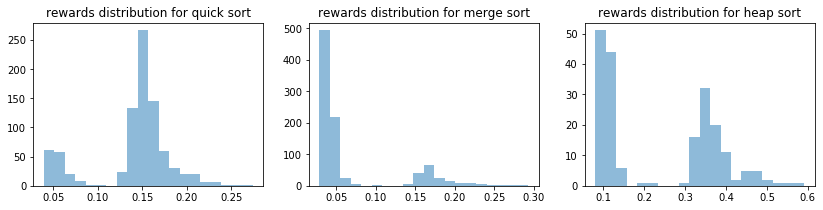

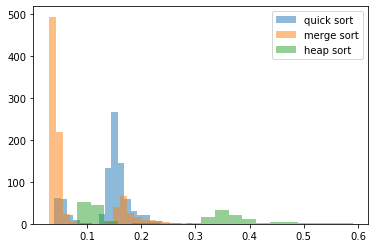

In [30]:
plot_rewards_distribution(arm_rewards_1)
plot_rewards_distribution_together(arm_rewards_1)

Restart at iteration: 17
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.17329211428607647, 'merge_sort': 0.19361660000140546, 'heap_sort': 0.4639656500003184}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 2, 'heap_sort': 2}


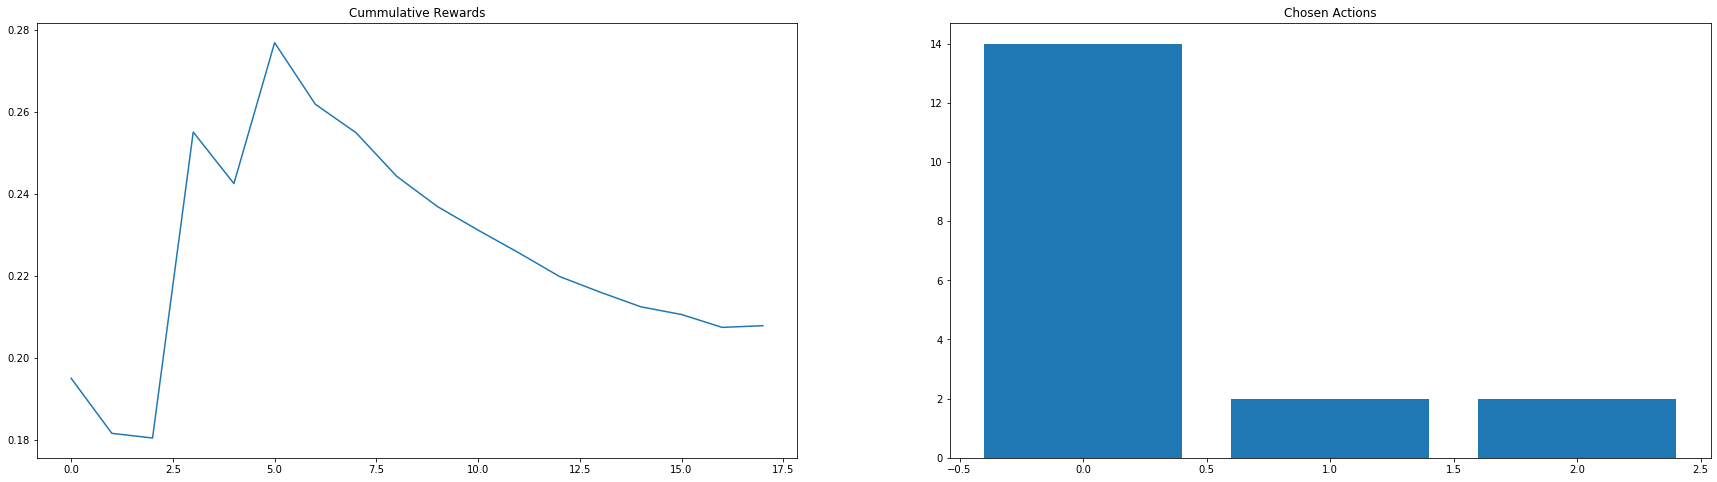

Restart at iteration: 59
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.17316162727321638, 'merge_sort': 0.205264466664327, 'heap_sort': 0.44262273333151825}
Count per chosen algo {'quick_sort': 33, 'merge_sort': 6, 'heap_sort': 3}


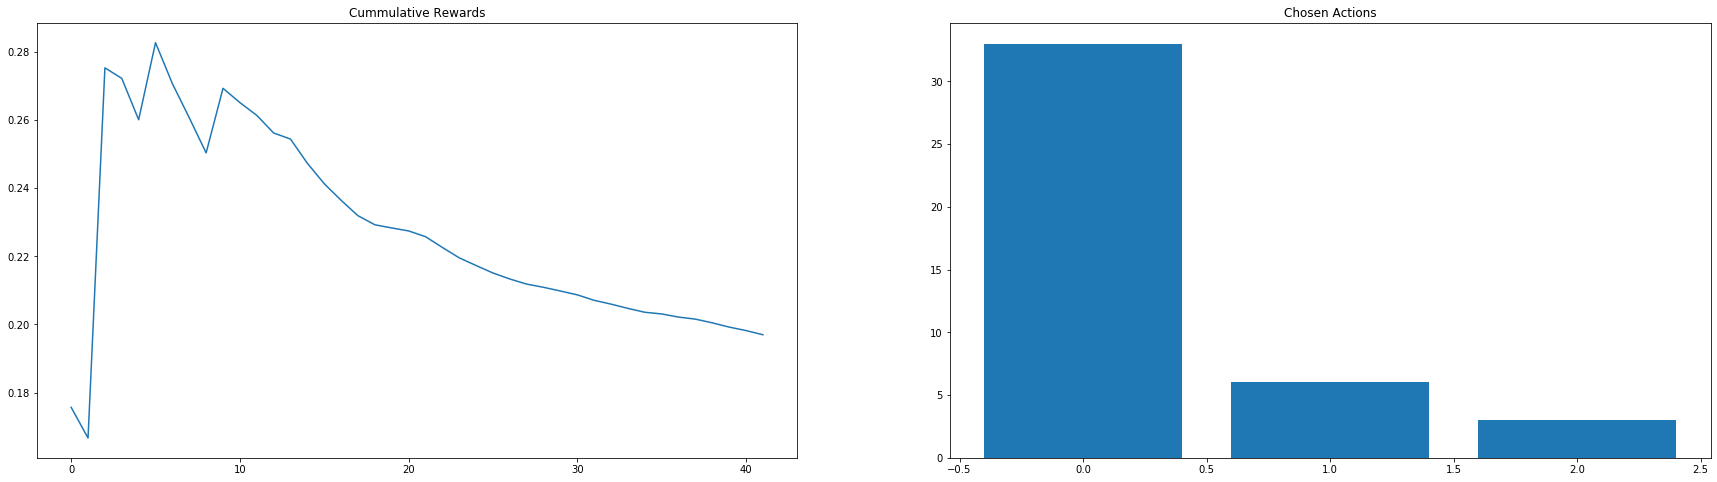

Restart at iteration: 75
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.16141809166704965, 'merge_sort': 0.1727533500015852, 'heap_sort': 0.3686302999922191}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 2, 'heap_sort': 2}


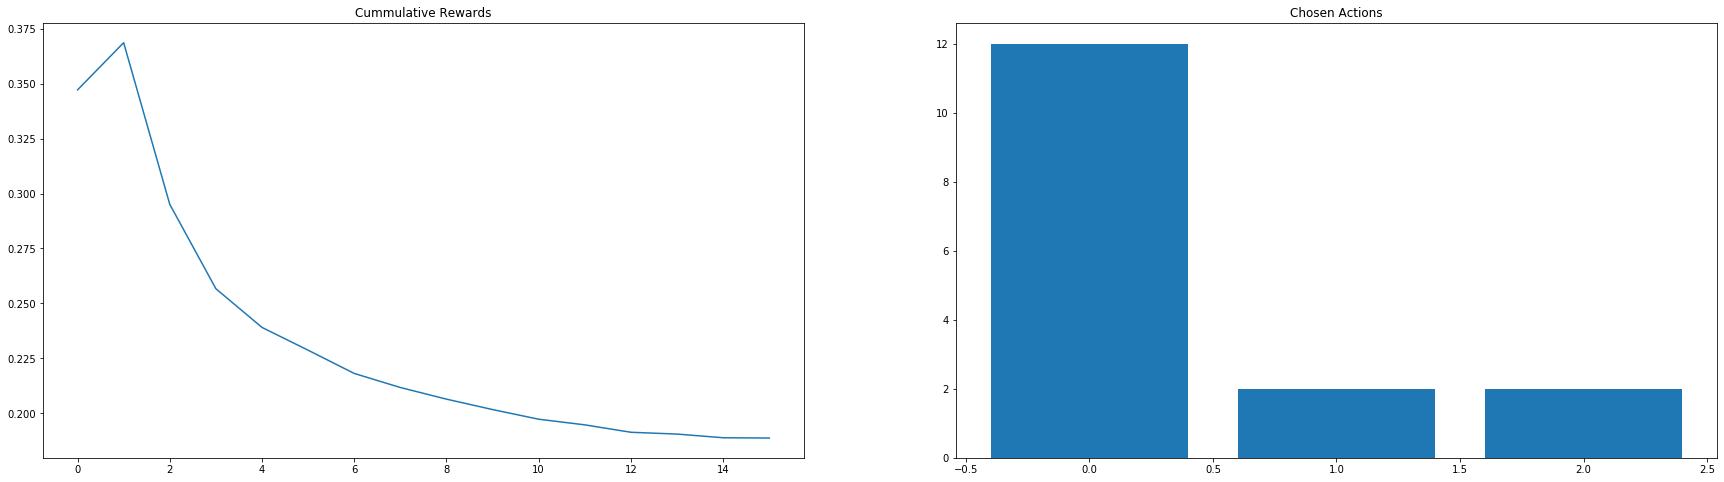

Restart at iteration: 94
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1686424357186687, 'merge_sort': 0.18098376666603144, 'heap_sort': 0.40170215000398457}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 3, 'heap_sort': 2}


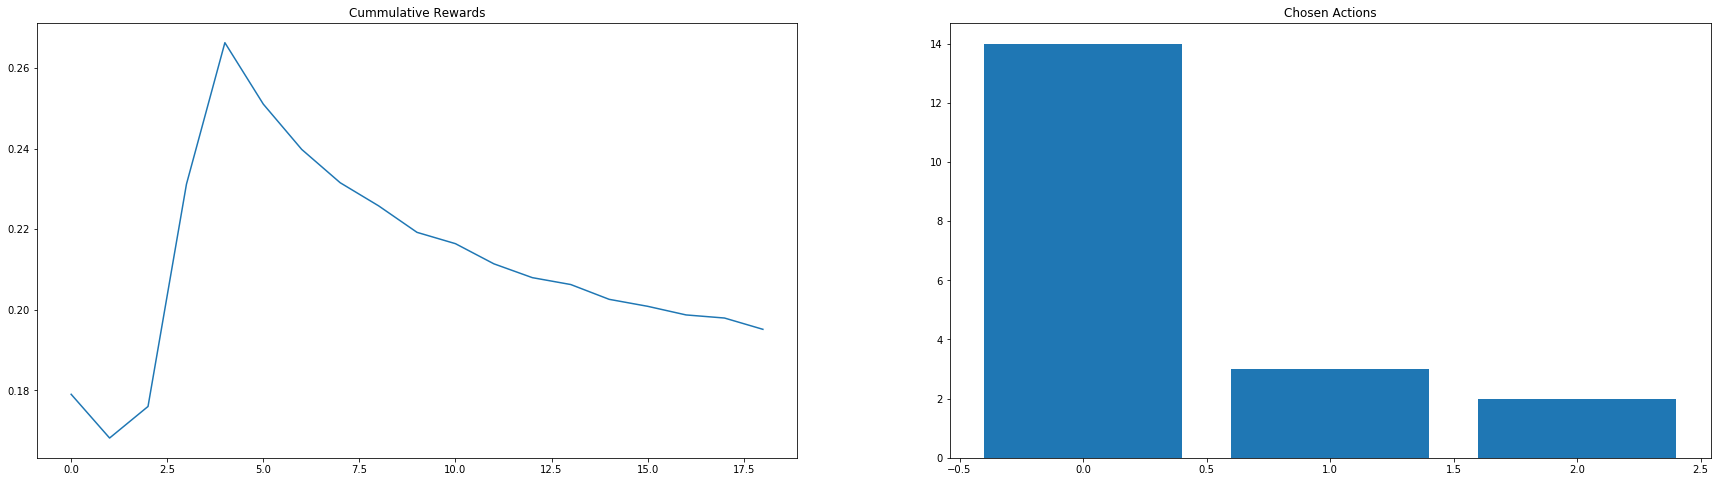

Restart at iteration: 121
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.17599329999939073, 'merge_sort': 0.16634177368311948, 'heap_sort': 0.4347182000007403}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 19, 'heap_sort': 3}


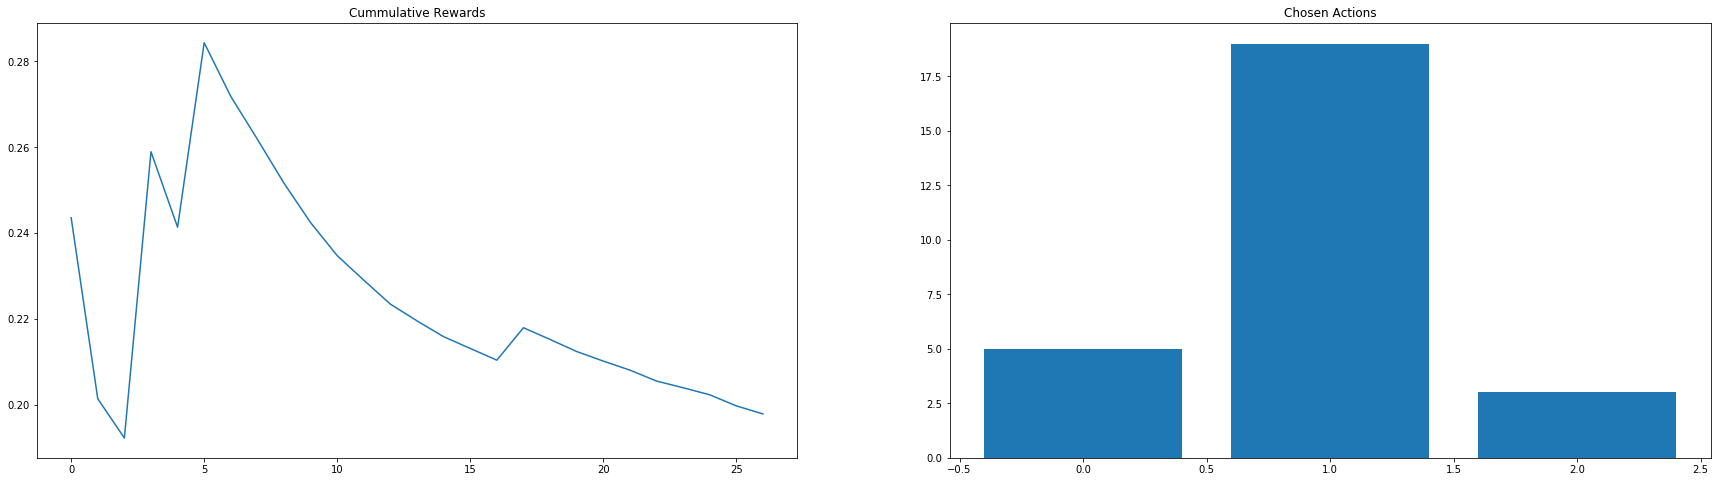

Restart at iteration: 146
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14770798095421578, 'merge_sort': 0.16642965000210097, 'heap_sort': 0.3448768000016571}
Count per chosen algo {'quick_sort': 21, 'merge_sort': 2, 'heap_sort': 2}


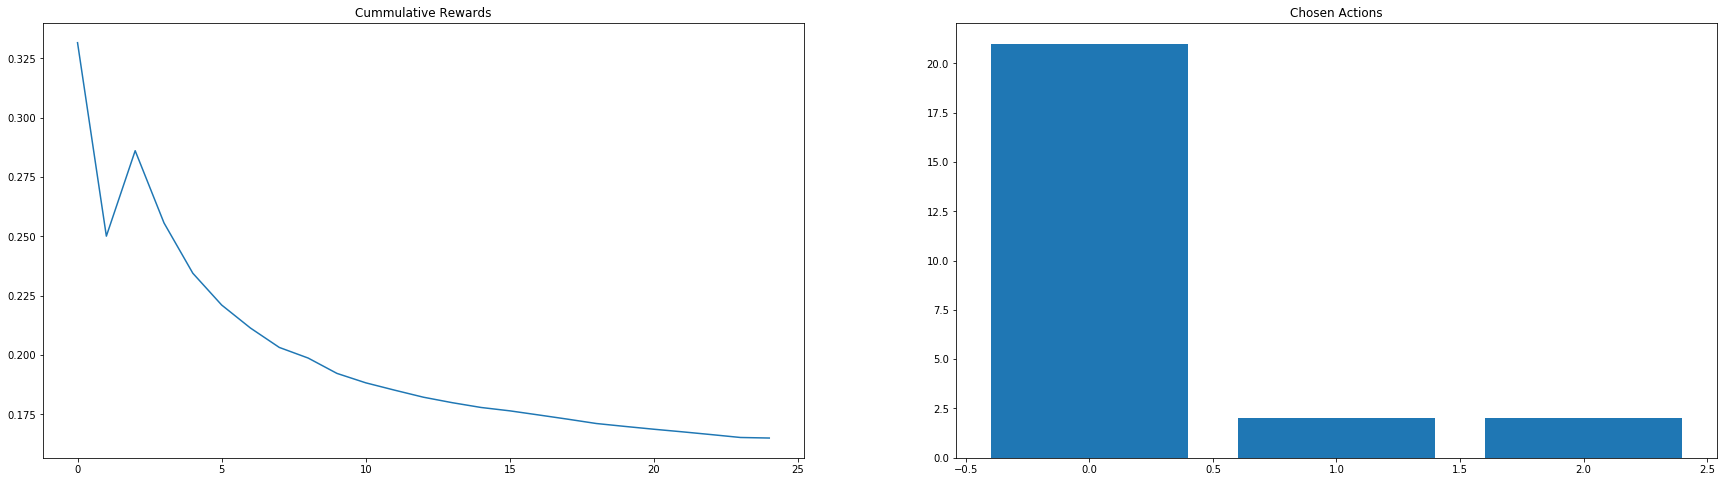

Restart at iteration: 166
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14963981250184588, 'merge_sort': 0.16433614999550628, 'heap_sort': 0.3354315500037046}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 2, 'heap_sort': 2}


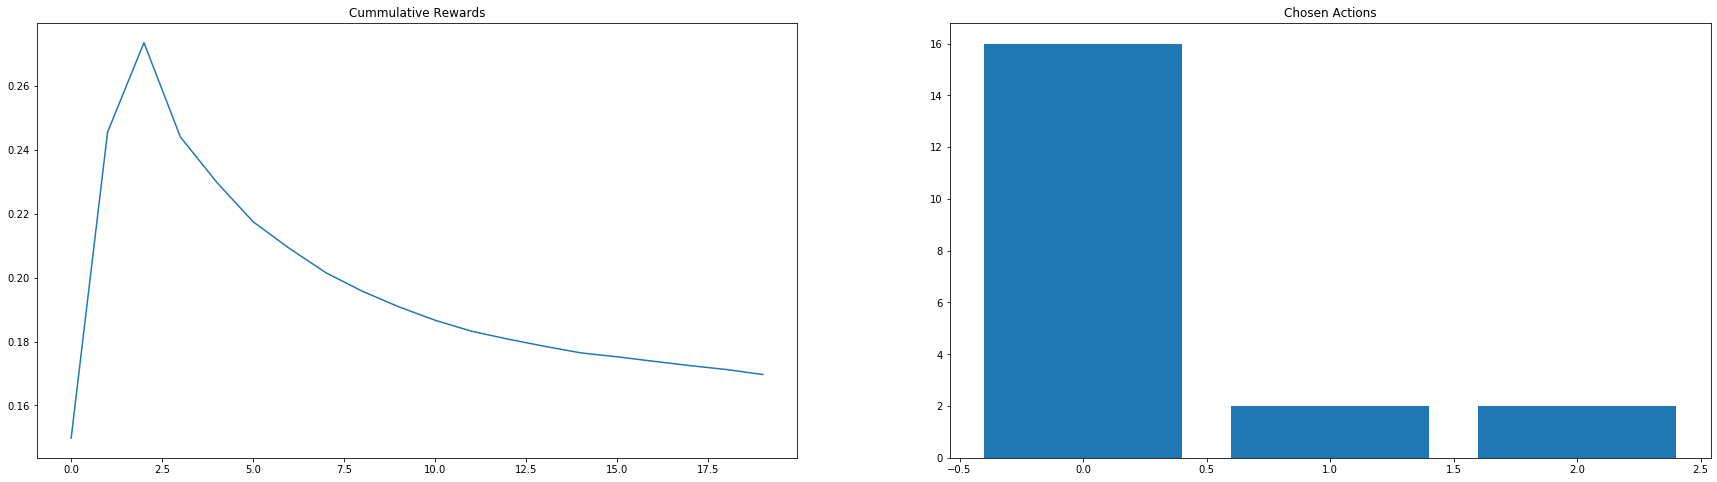

Restart at iteration: 181
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14390594545429022, 'merge_sort': 0.15909395000198856, 'heap_sort': 0.3503809000030742}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 2, 'heap_sort': 2}


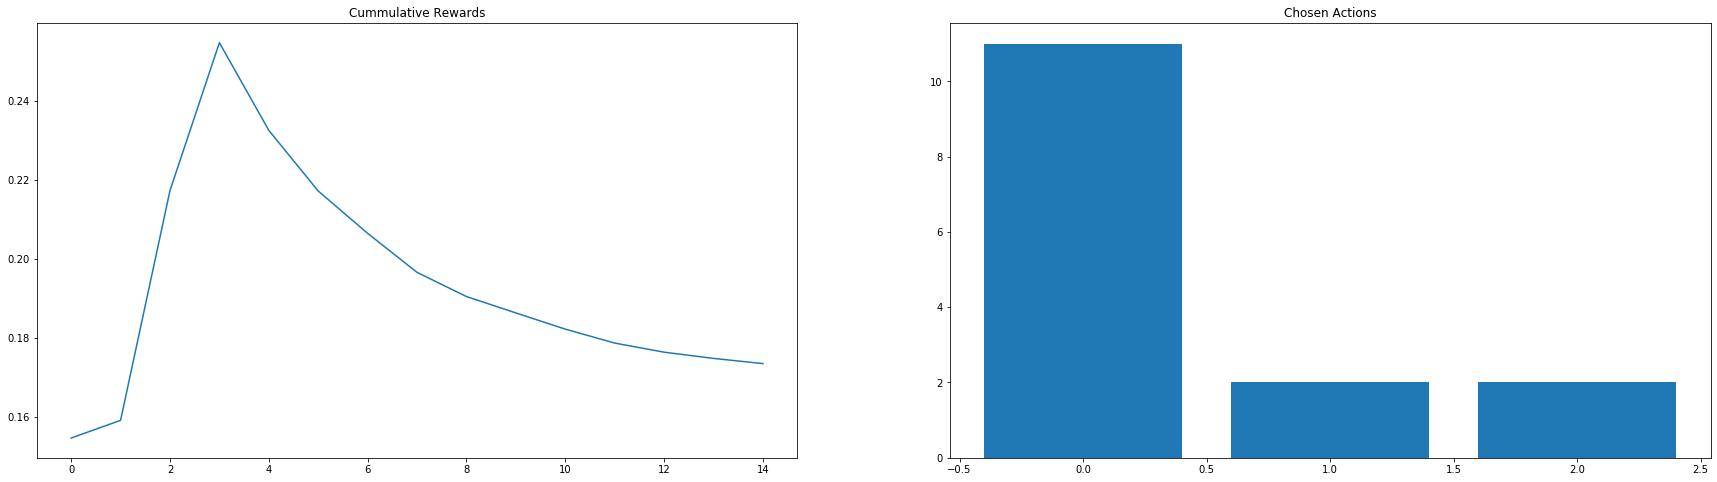

Restart at iteration: 199
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14217621538241823, 'merge_sort': 0.15622720000101253, 'heap_sort': 0.32332306666648947}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 2, 'heap_sort': 3}


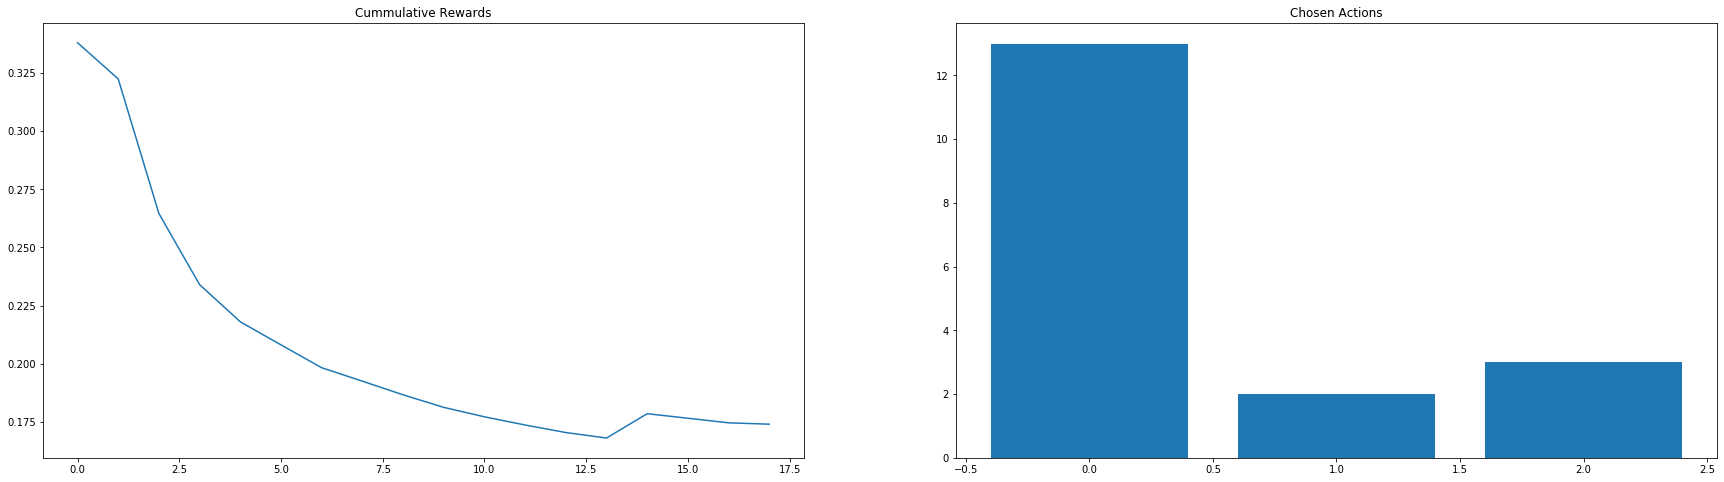

Restart at iteration: 219
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.16281886153984276, 'merge_sort': 0.1688352000019222, 'heap_sort': 0.4039346333302092}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 4, 'heap_sort': 3}


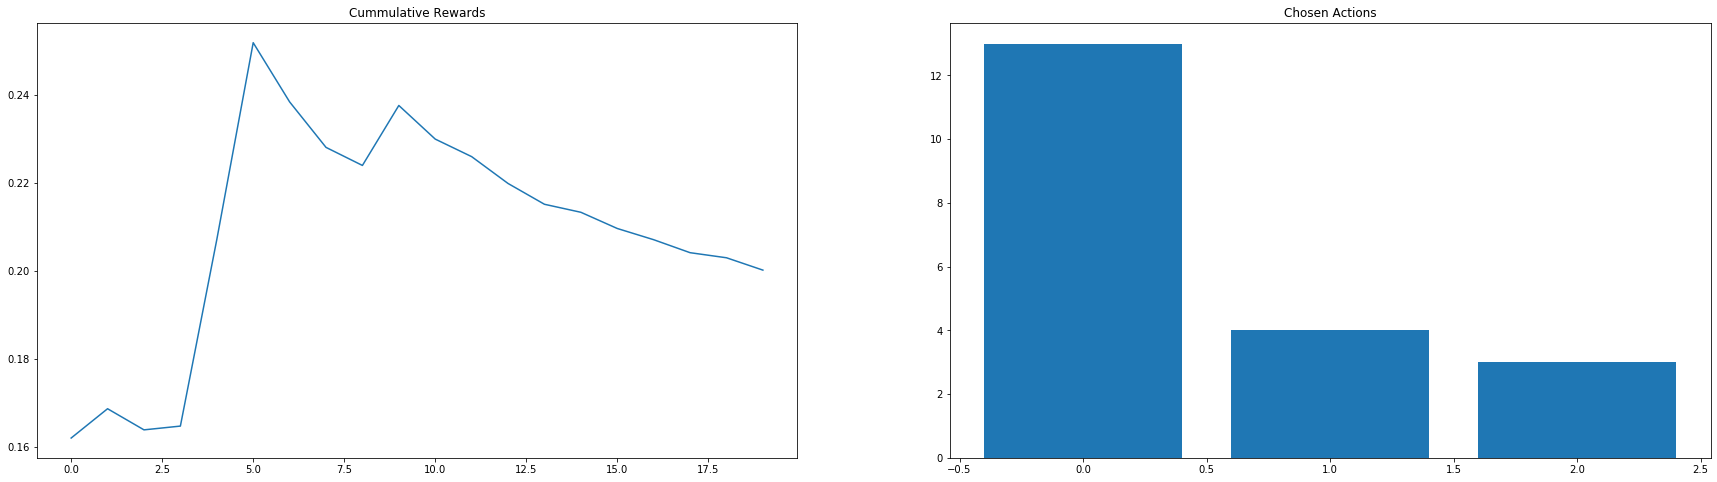

Restart at iteration: 242
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15641588235260262, 'merge_sort': 0.17258796666768225, 'heap_sort': 0.379766266666896}
Count per chosen algo {'quick_sort': 17, 'merge_sort': 3, 'heap_sort': 3}


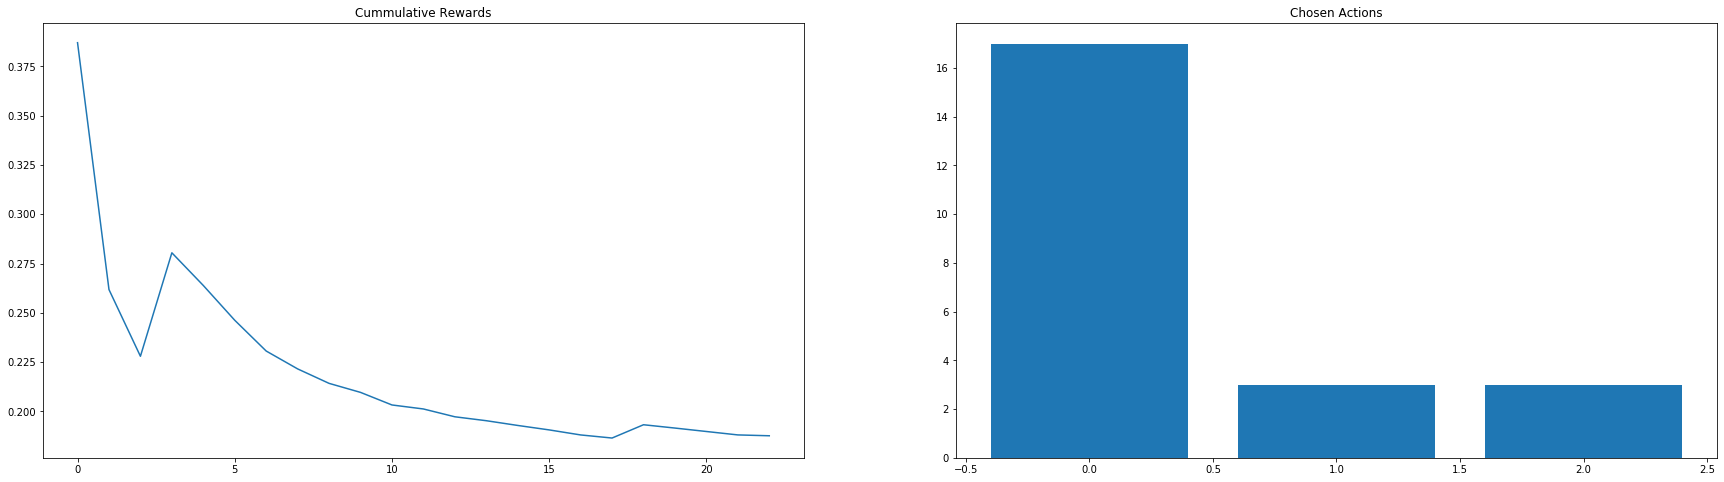

Restart at iteration: 265
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1532859578950784, 'merge_sort': 0.17296529999293853, 'heap_sort': 0.3571063999988837}
Count per chosen algo {'quick_sort': 19, 'merge_sort': 2, 'heap_sort': 2}


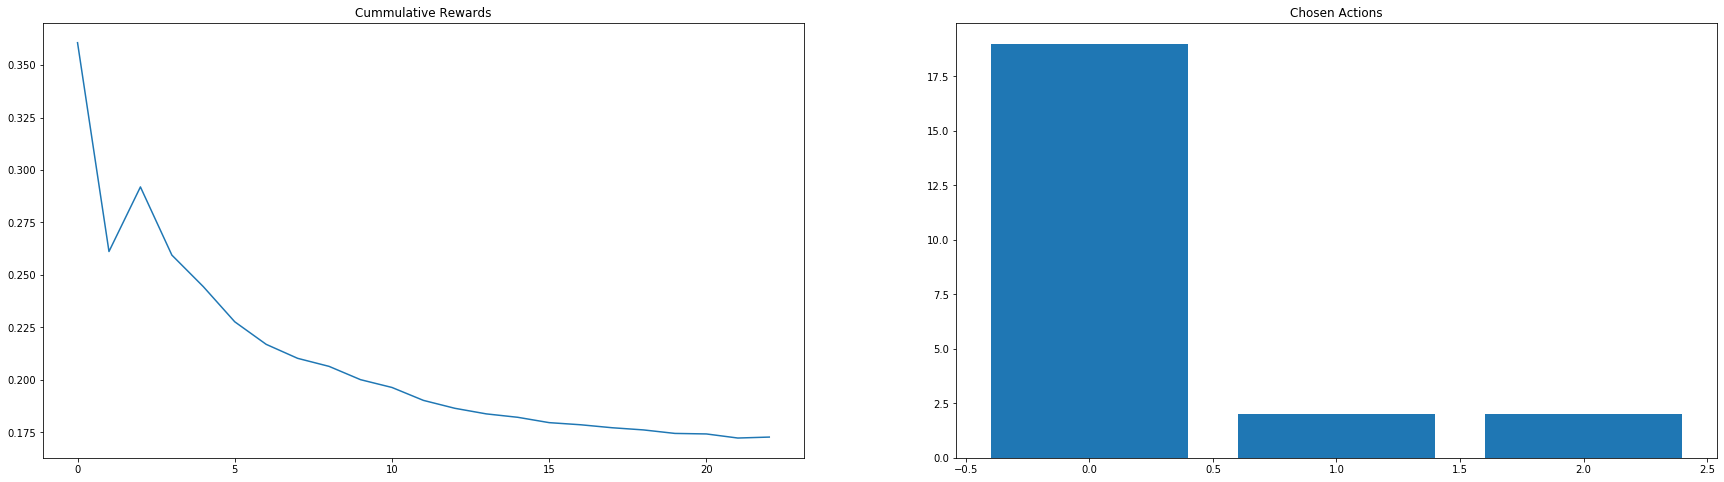

Restart at iteration: 287
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1350393687516771, 'merge_sort': 0.14879909999338756, 'heap_sort': 0.3195717333389136}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 3, 'heap_sort': 3}


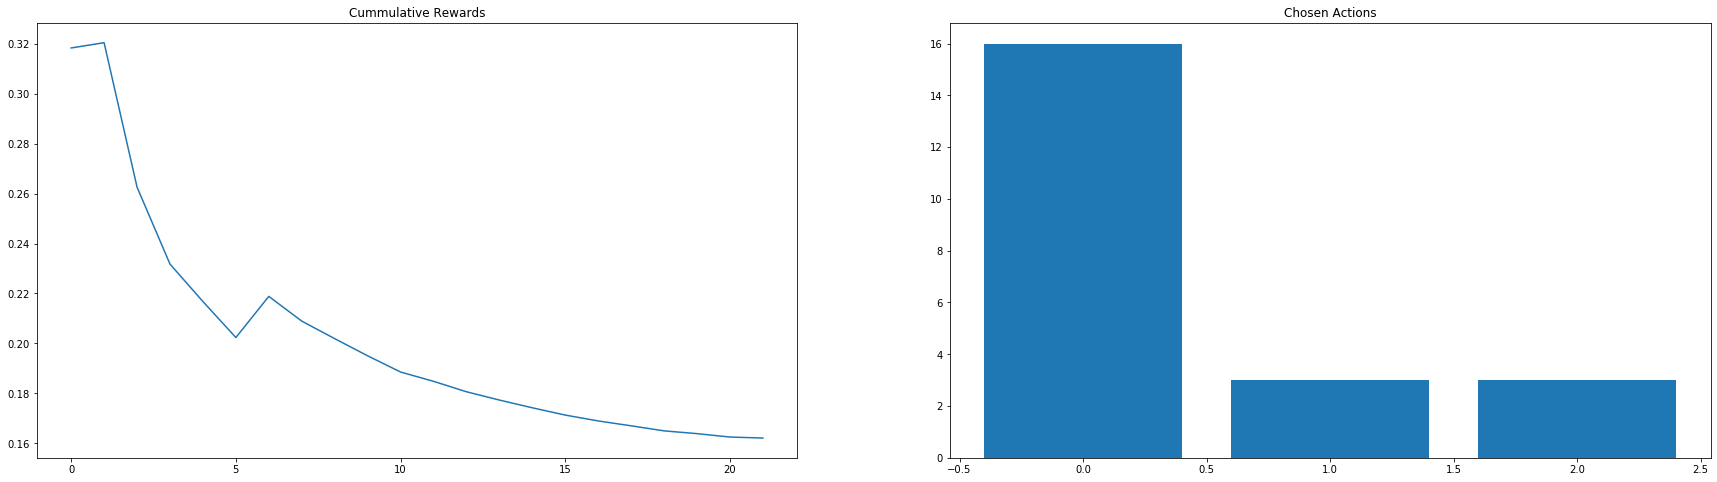

Restart at iteration: 312
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.16494361764703439, 'merge_sort': 0.17601793999492657, 'heap_sort': 0.3355563666652112}
Count per chosen algo {'quick_sort': 17, 'merge_sort': 5, 'heap_sort': 3}


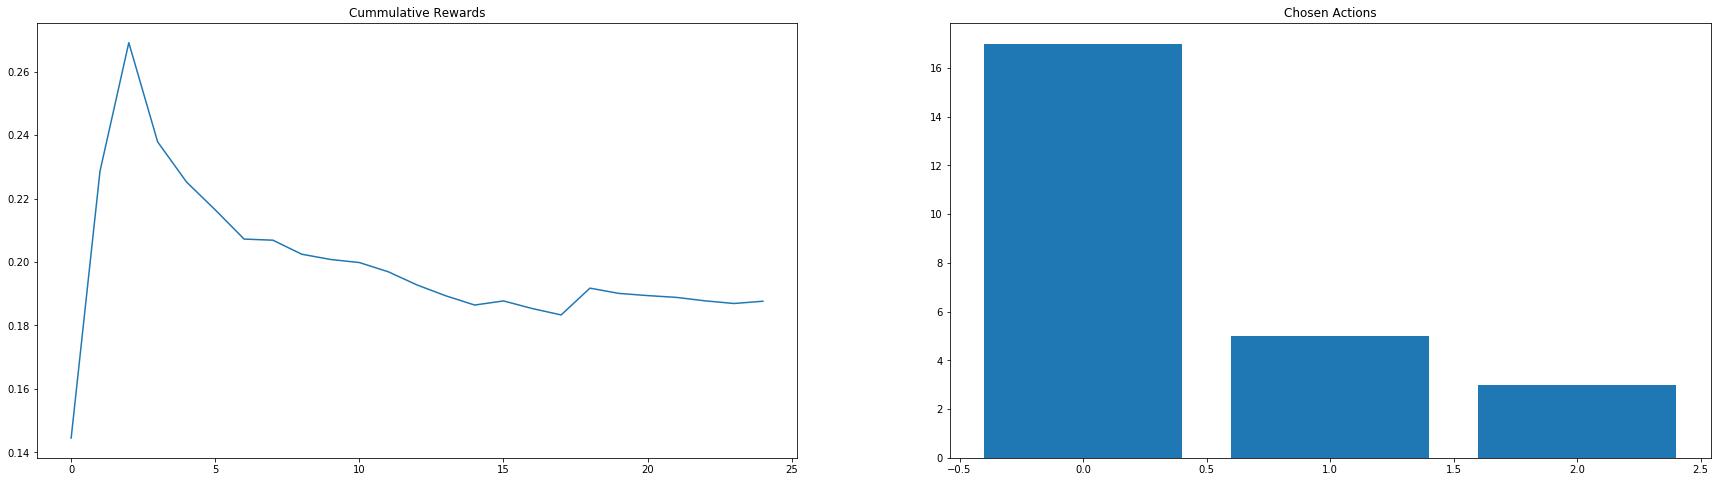

Restart at iteration: 328
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15653284166789186, 'merge_sort': 0.17553524999675574, 'heap_sort': 0.3548629999932018}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 2, 'heap_sort': 2}


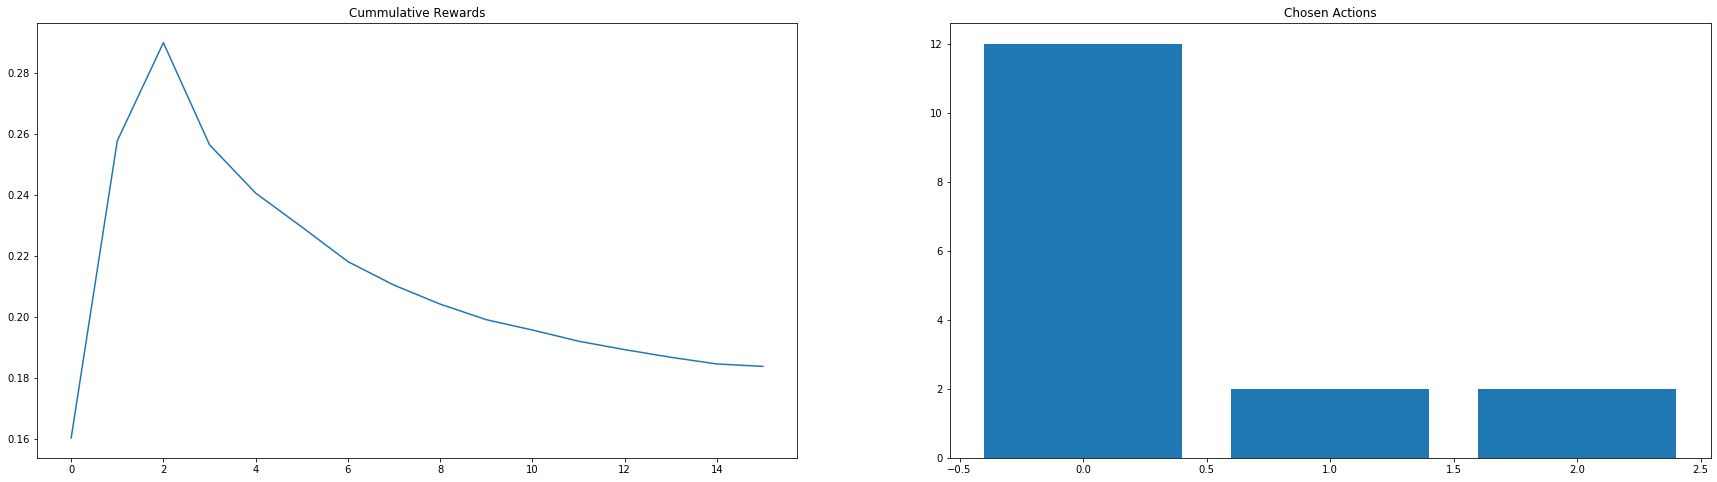

Restart at iteration: 346
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15090430000002794, 'merge_sort': 0.2097616500032018, 'heap_sort': 0.38839650000591064}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 2, 'heap_sort': 2}


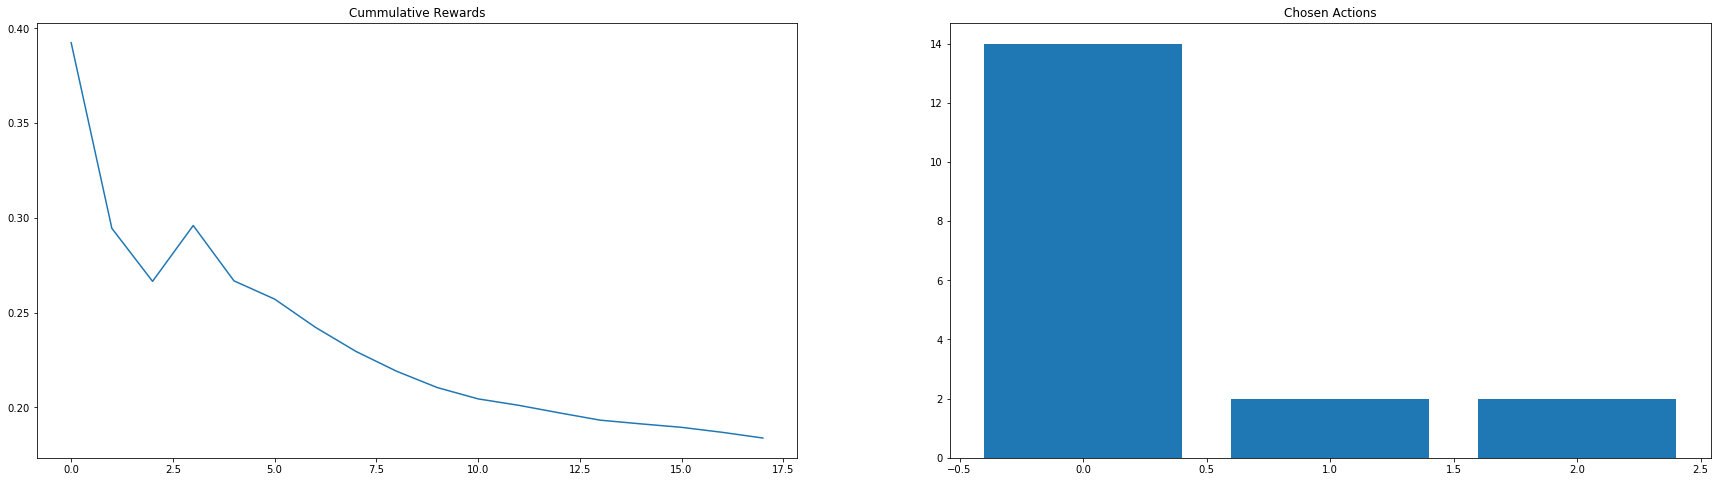

Restart at iteration: 371
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15066290499962634, 'merge_sort': 0.16056583333314242, 'heap_sort': 0.3270836999945459}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 3, 'heap_sort': 2}


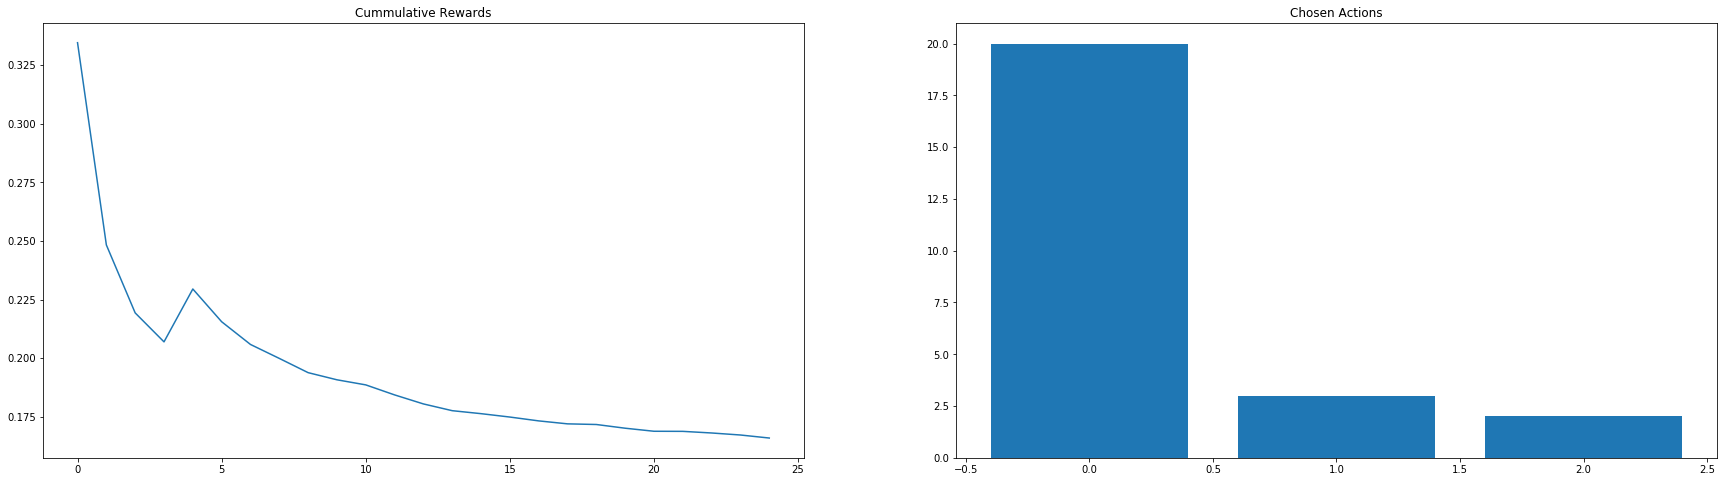

Restart at iteration: 403
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15043699523916335, 'merge_sort': 0.16656164444187502, 'heap_sort': 0.3322037999969325}
Count per chosen algo {'quick_sort': 21, 'merge_sort': 9, 'heap_sort': 2}


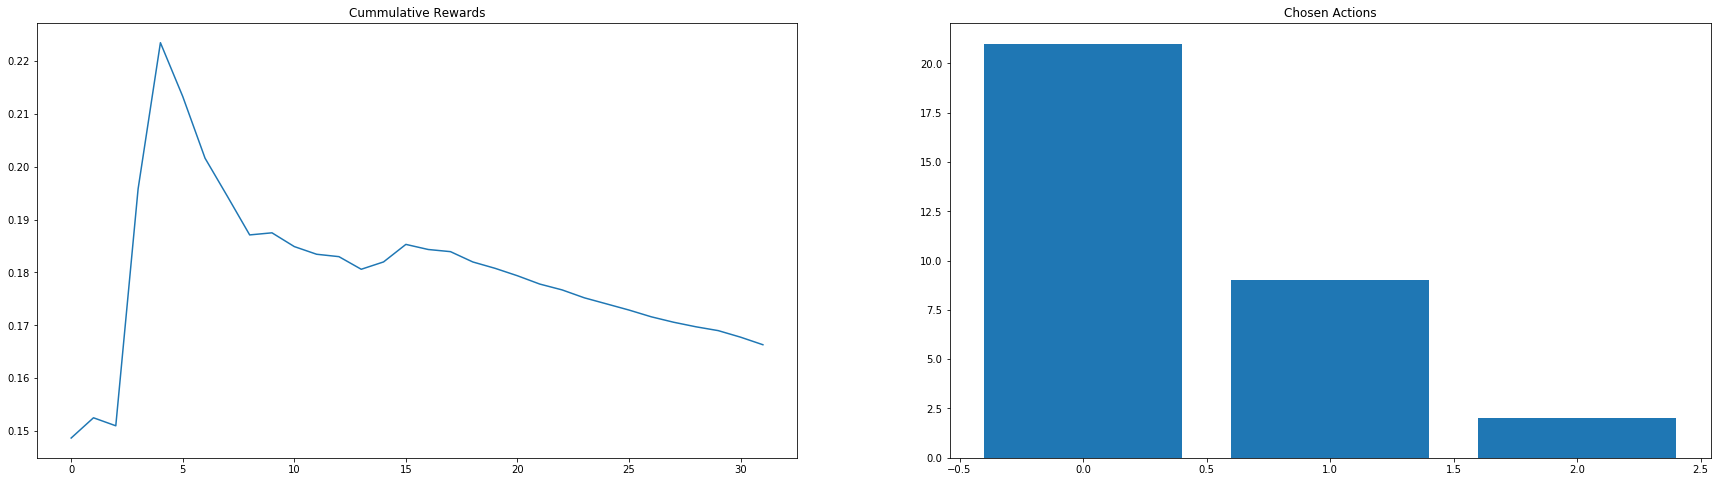

Restart at iteration: 419
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14376719999629792, 'merge_sort': 0.1548751999992722, 'heap_sort': 0.3735336499958066}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 3, 'heap_sort': 2}


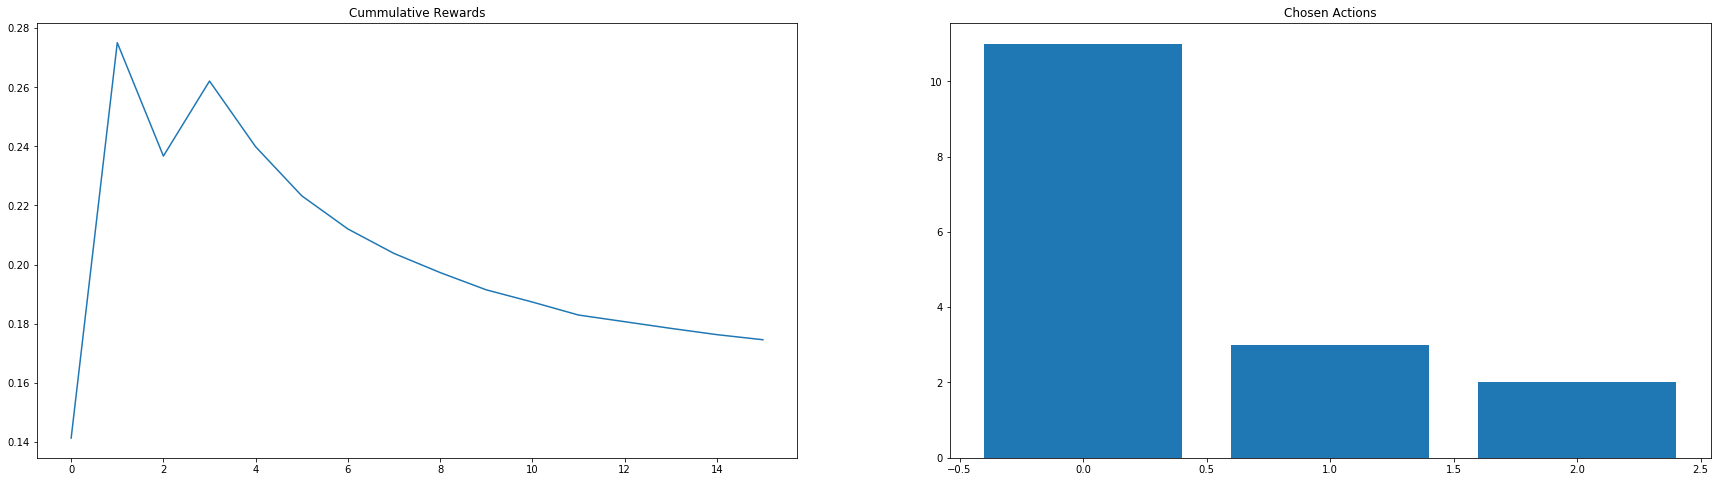

Restart at iteration: 439
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15802632499859706, 'merge_sort': 0.20166733333220085, 'heap_sort': 0.3628965999960201}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 6, 'heap_sort': 2}


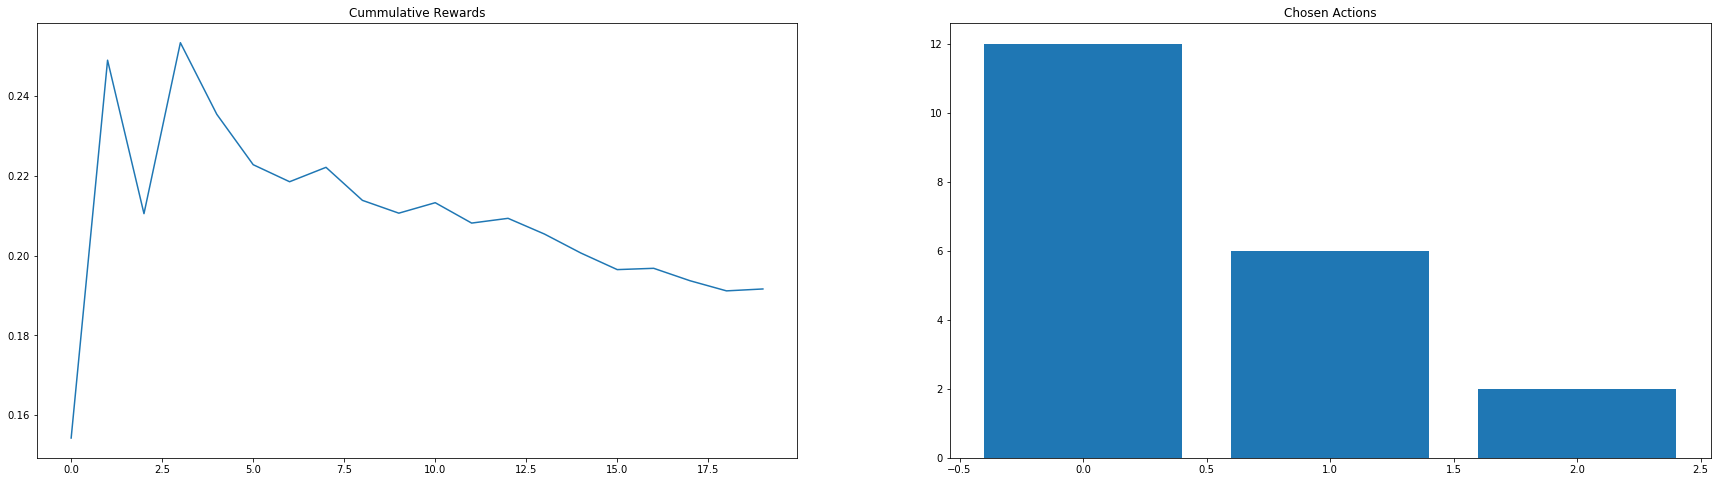

Restart at iteration: 466
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.17023260555611663, 'merge_sort': 0.18456813333614264, 'heap_sort': 0.3608470666707338}
Count per chosen algo {'quick_sort': 18, 'merge_sort': 6, 'heap_sort': 3}


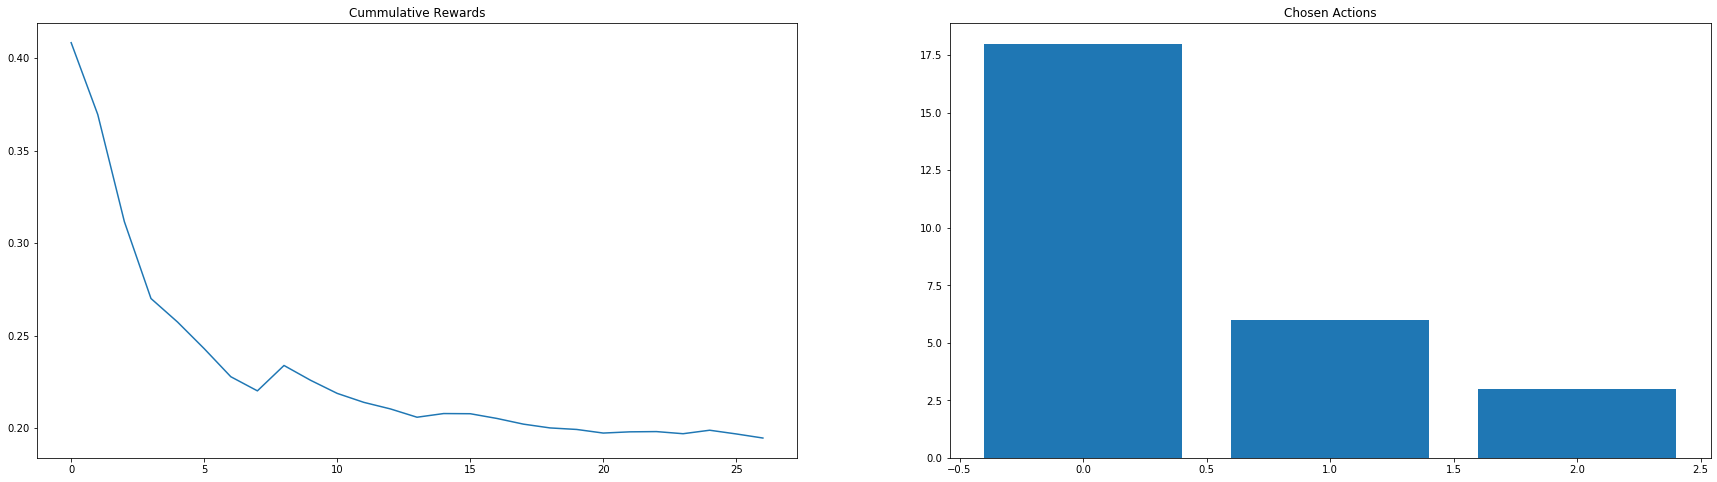

Restart at iteration: 488
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14609961250062042, 'merge_sort': 0.17343400000148299, 'heap_sort': 0.3932862999984839}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 3, 'heap_sort': 3}


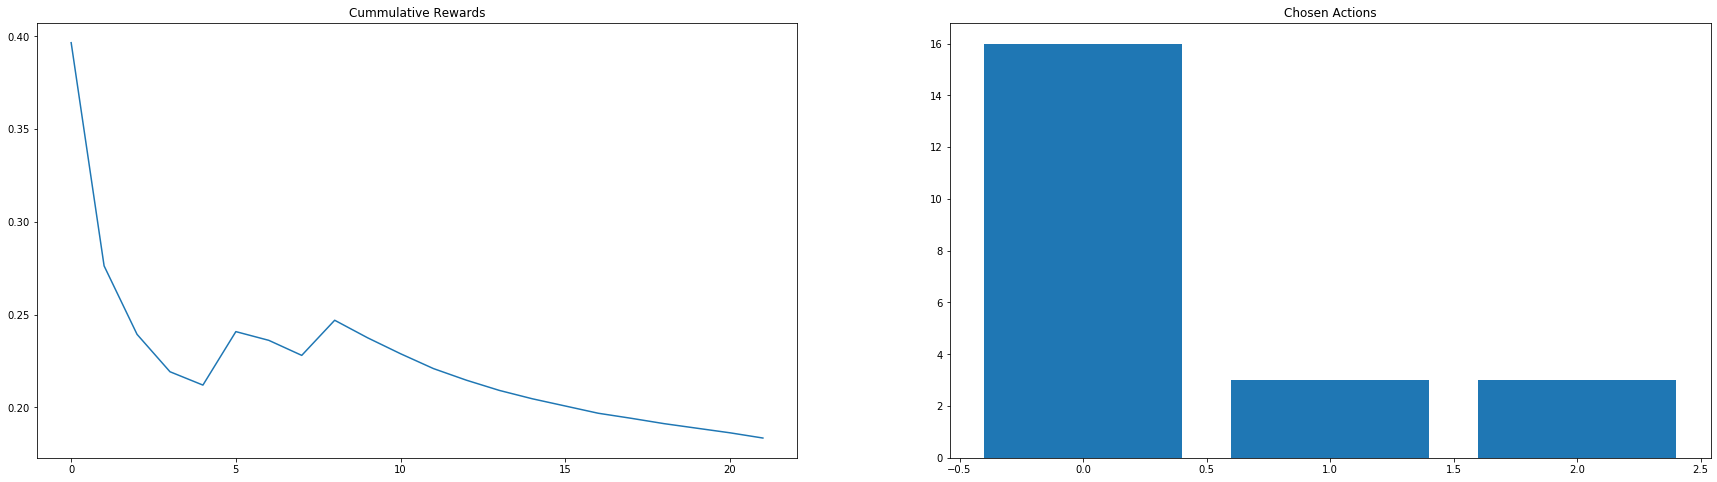

Restart at iteration: 507
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.08781394666390649, 'merge_sort': 0.15890029999718536, 'heap_sort': 0.33636350000597304}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 2, 'heap_sort': 2}


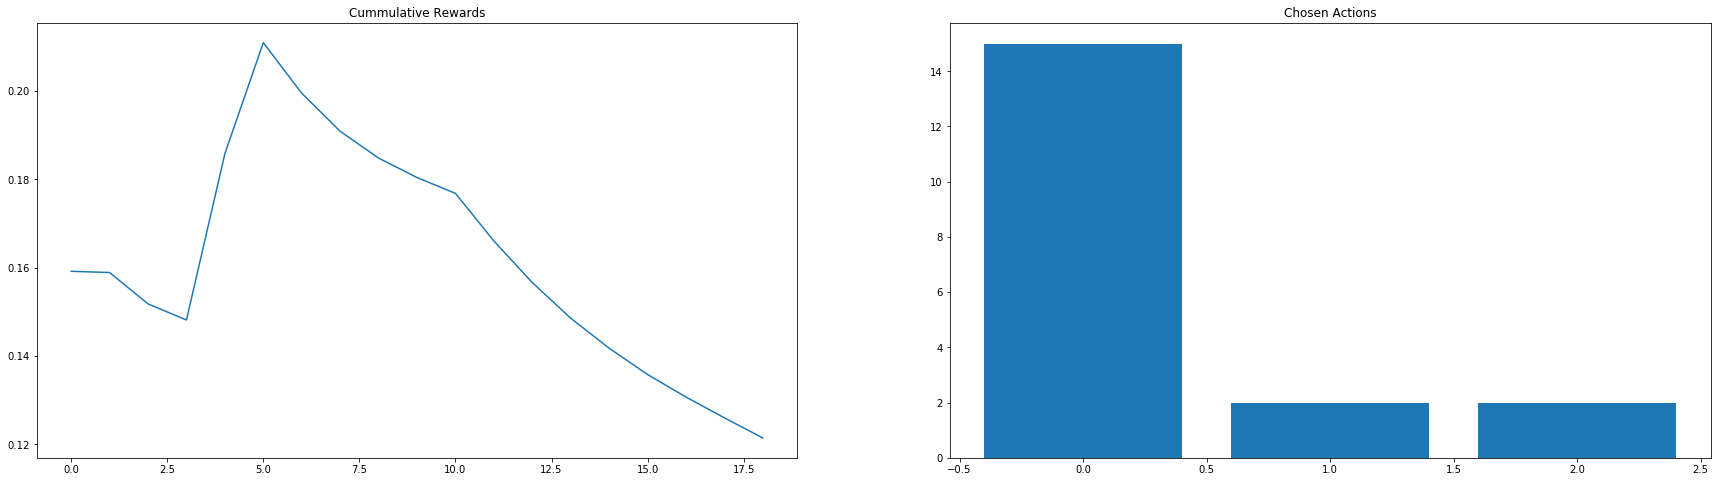

Restart at iteration: 532
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04370616666468171, 'merge_sort': 0.03566091500106268, 'heap_sort': 0.10911090000445256}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 20, 'heap_sort': 2}


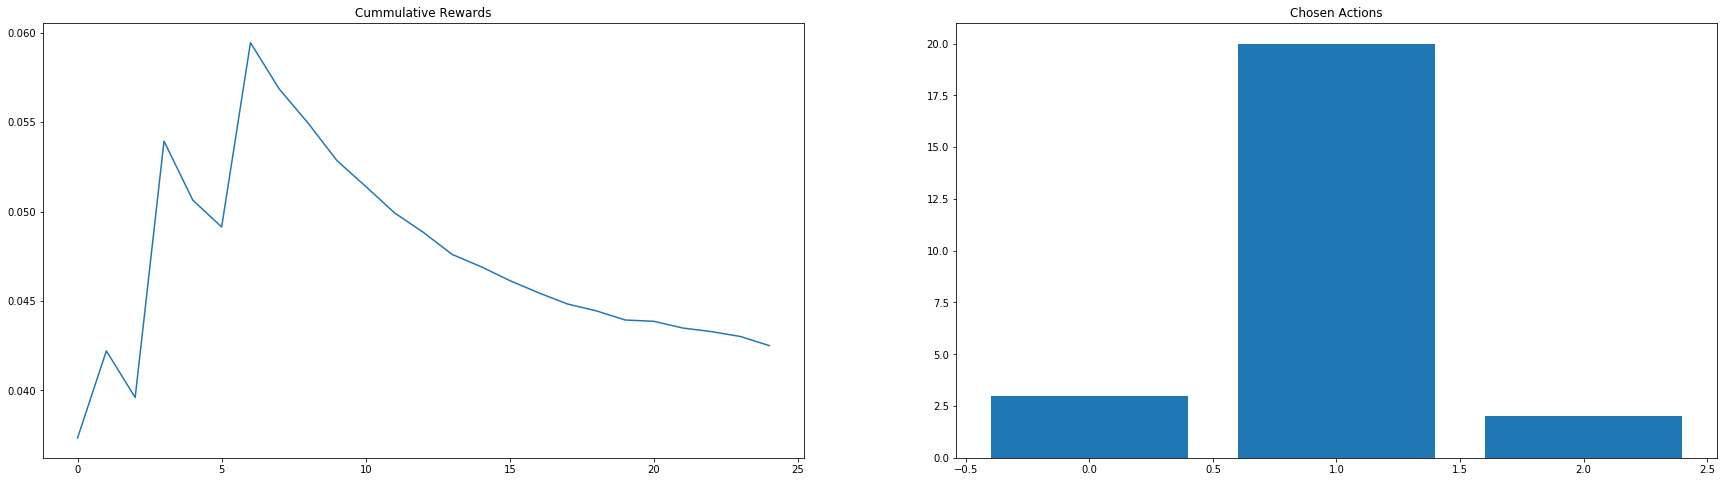

Restart at iteration: 563
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.045871349997469224, 'merge_sort': 0.036707877777020996, 'heap_sort': 0.09253480000188574}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 27, 'heap_sort': 2}


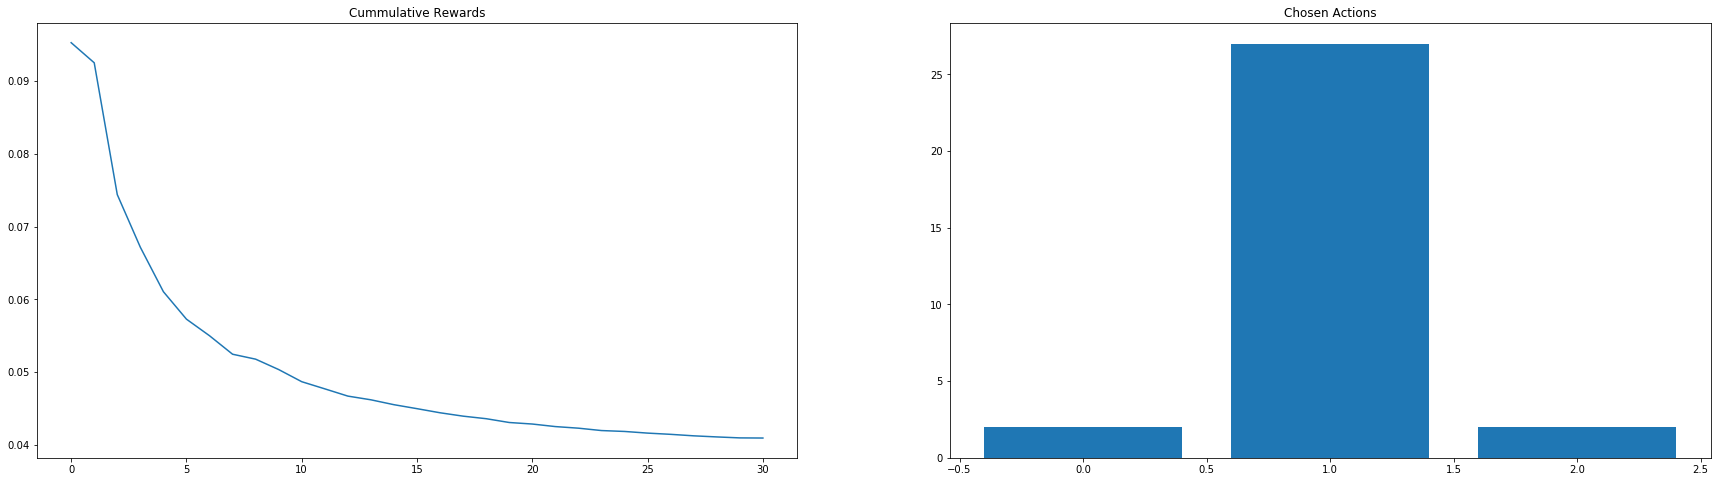

Restart at iteration: 583
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.048946749993774574, 'merge_sort': 0.037100886666060734, 'heap_sort': 0.09655796666629612}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 15, 'heap_sort': 3}


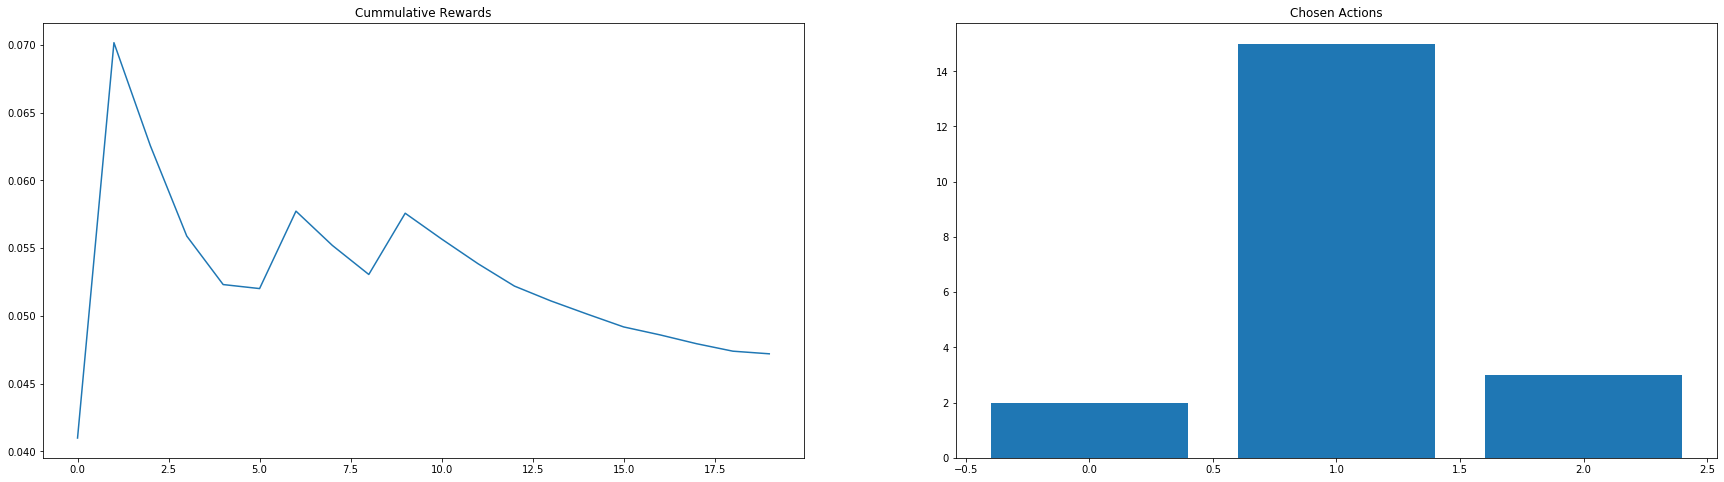

Restart at iteration: 616
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.06583479999764157, 'merge_sort': 0.05124455833417111, 'heap_sort': 0.1100617499978398}
Count per chosen algo {'quick_sort': 7, 'merge_sort': 24, 'heap_sort': 2}


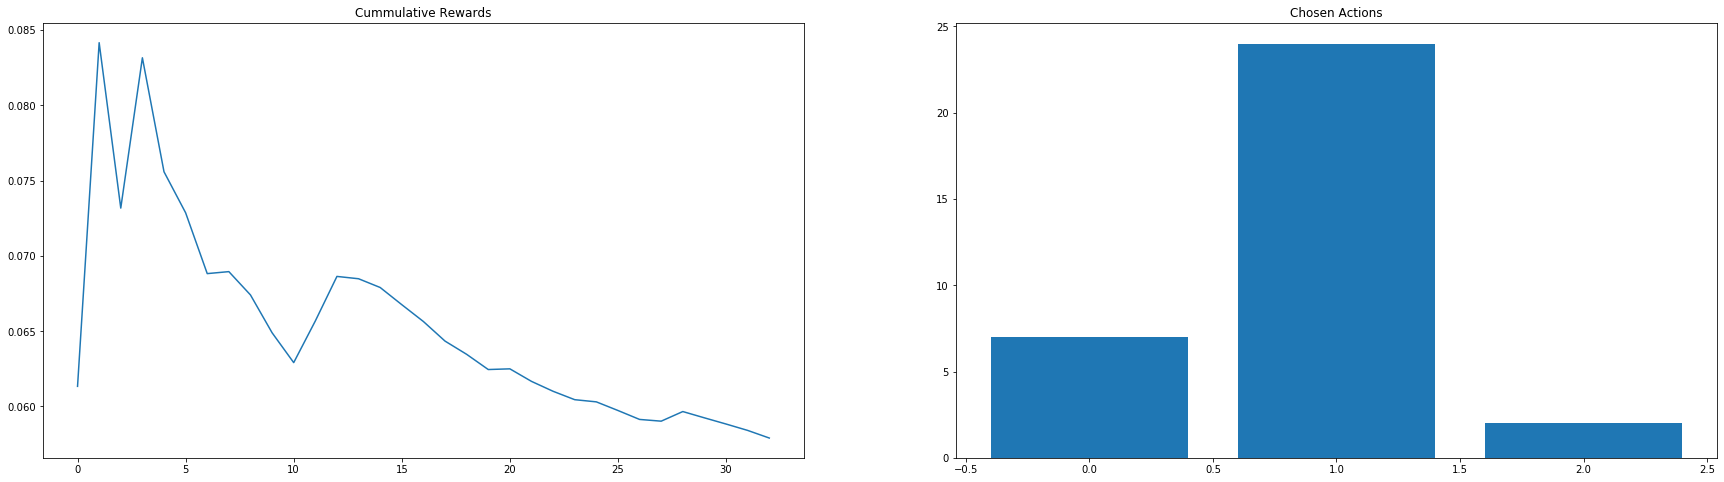

Restart at iteration: 631
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.07147805000568042, 'merge_sort': 0.04848380909507713, 'heap_sort': 0.11255940000410192}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 11, 'heap_sort': 2}


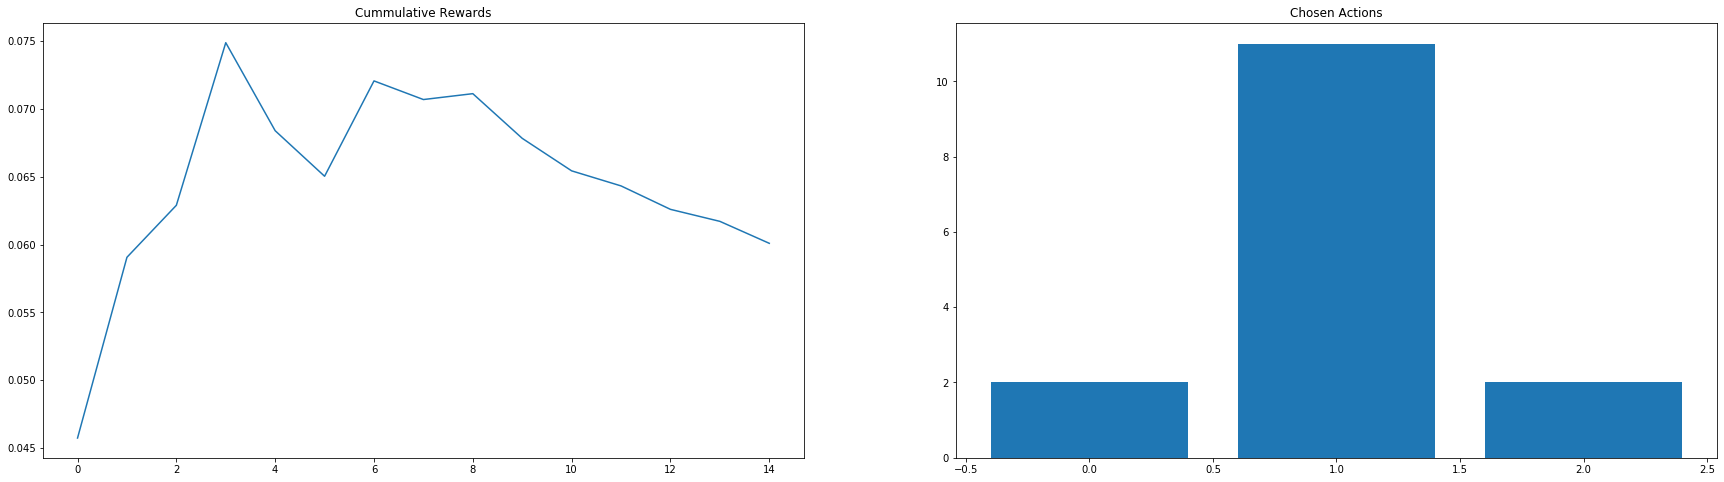

Restart at iteration: 651
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04755044000630733, 'merge_sort': 0.04336313076671034, 'heap_sort': 0.13215899999340763}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 13, 'heap_sort': 2}


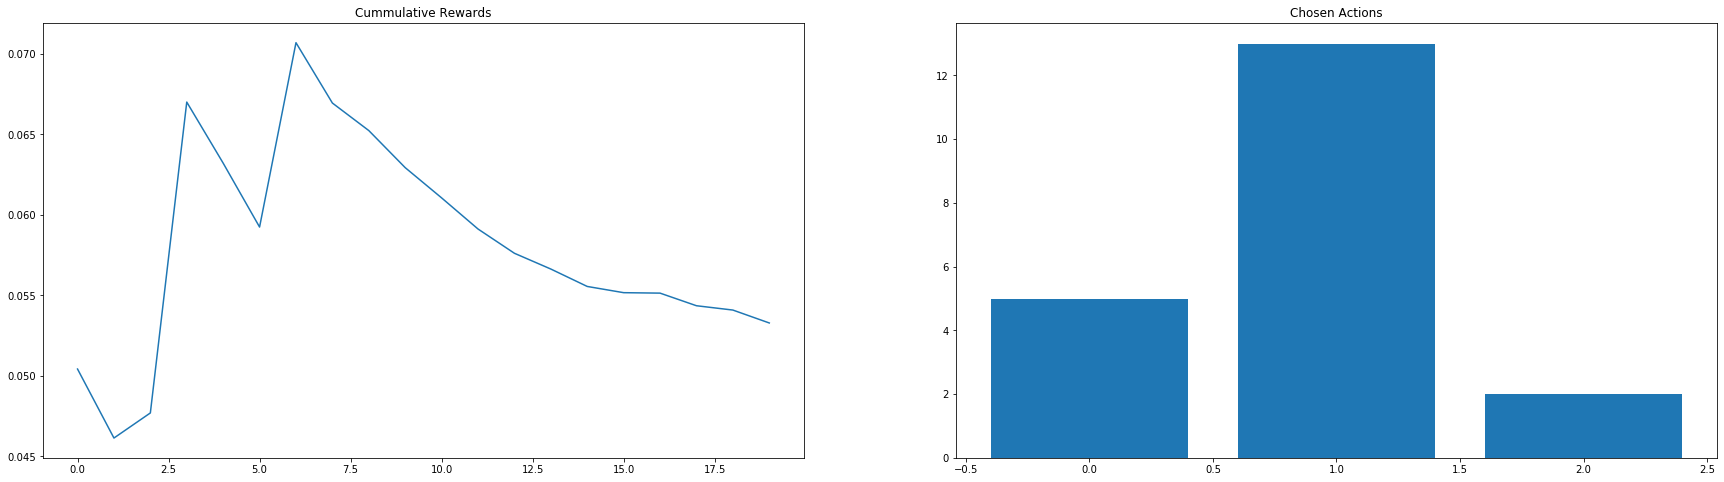

Restart at iteration: 670
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0511099999966973, 'merge_sort': 0.04399027499797133, 'heap_sort': 0.09196770000077474}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 12, 'heap_sort': 3}


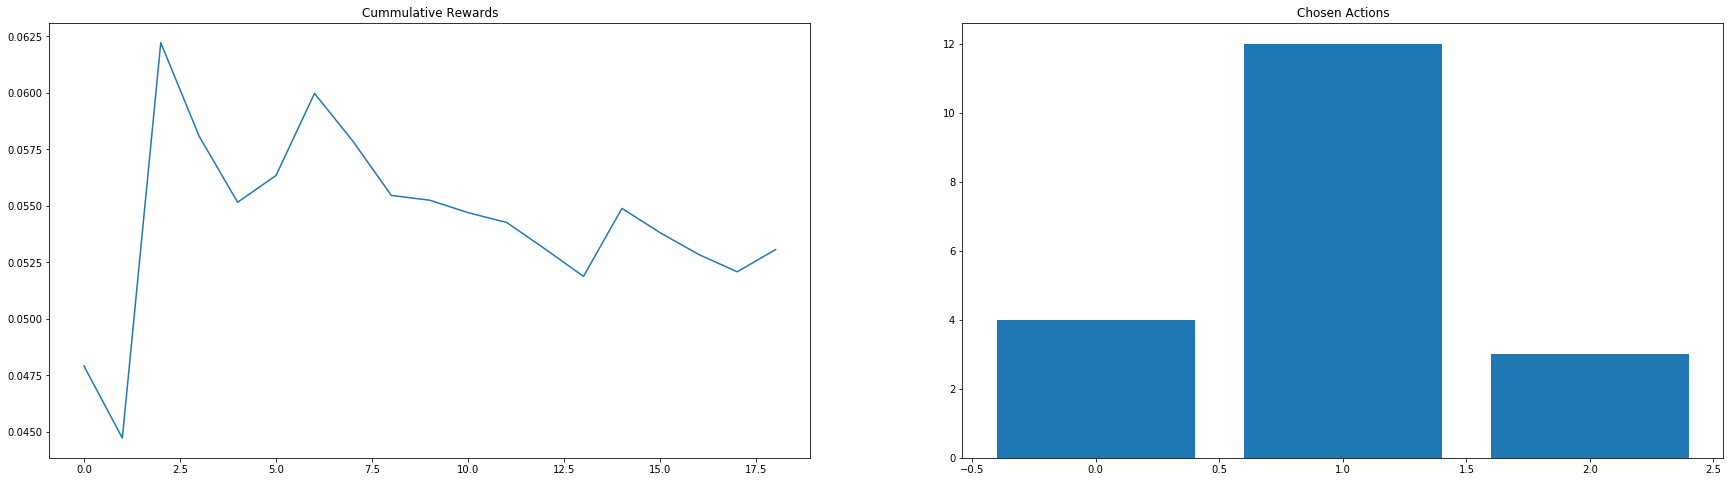

Restart at iteration: 687
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.058119166666680634, 'merge_sort': 0.037668066668023435, 'heap_sort': 0.09812745000090217}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 12, 'heap_sort': 2}


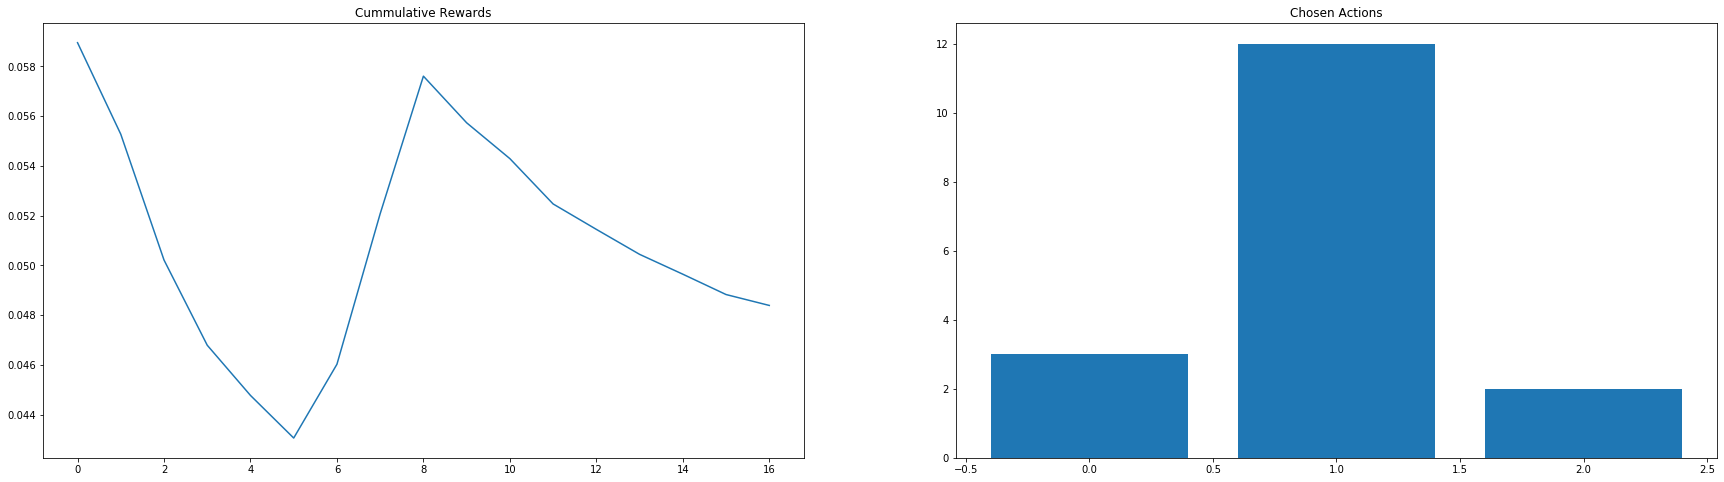

Restart at iteration: 705
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.053466866670836076, 'merge_sort': 0.042515099997847125, 'heap_sort': 0.11019270000542747}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 13, 'heap_sort': 2}


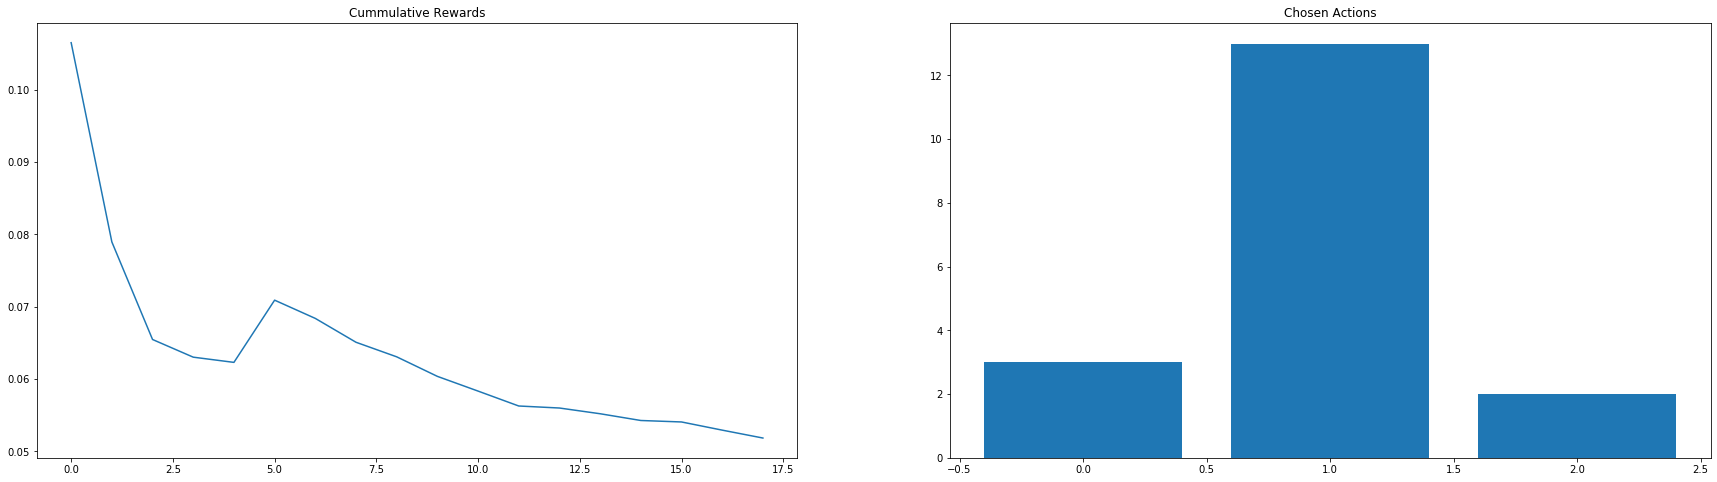

Restart at iteration: 737
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.07088218749959196, 'merge_sort': 0.04374223000049824, 'heap_sort': 0.11057244999392424}
Count per chosen algo {'quick_sort': 8, 'merge_sort': 20, 'heap_sort': 4}


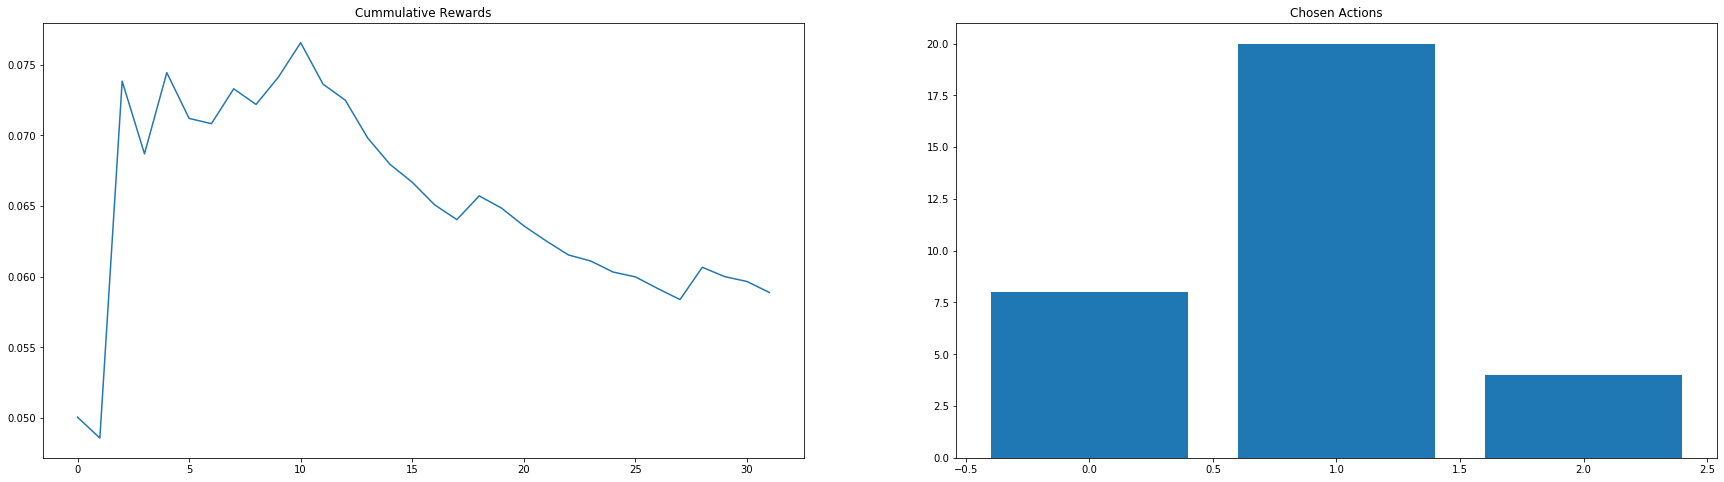

Restart at iteration: 756
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.054197999997995794, 'merge_sort': 0.04011650000133419, 'heap_sort': 0.11722379999264376}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 14, 'heap_sort': 2}


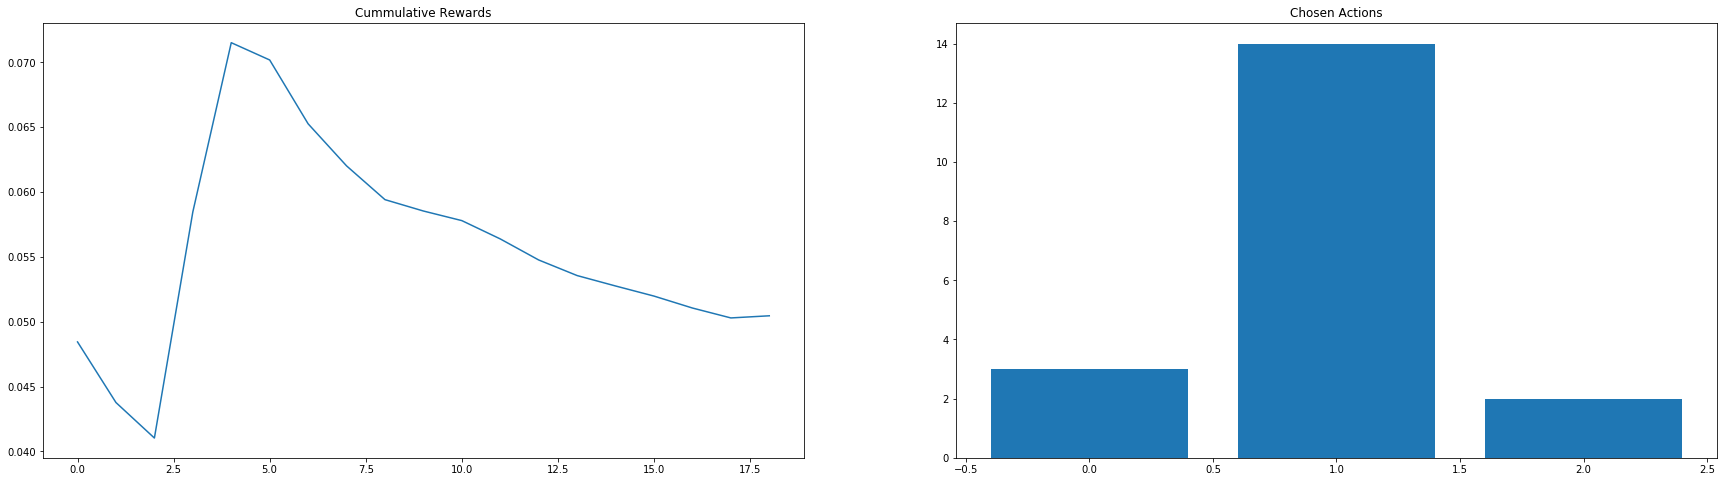

Restart at iteration: 784
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04841182500240393, 'merge_sort': 0.03992959523956025, 'heap_sort': 0.10852110000269022}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 21, 'heap_sort': 3}


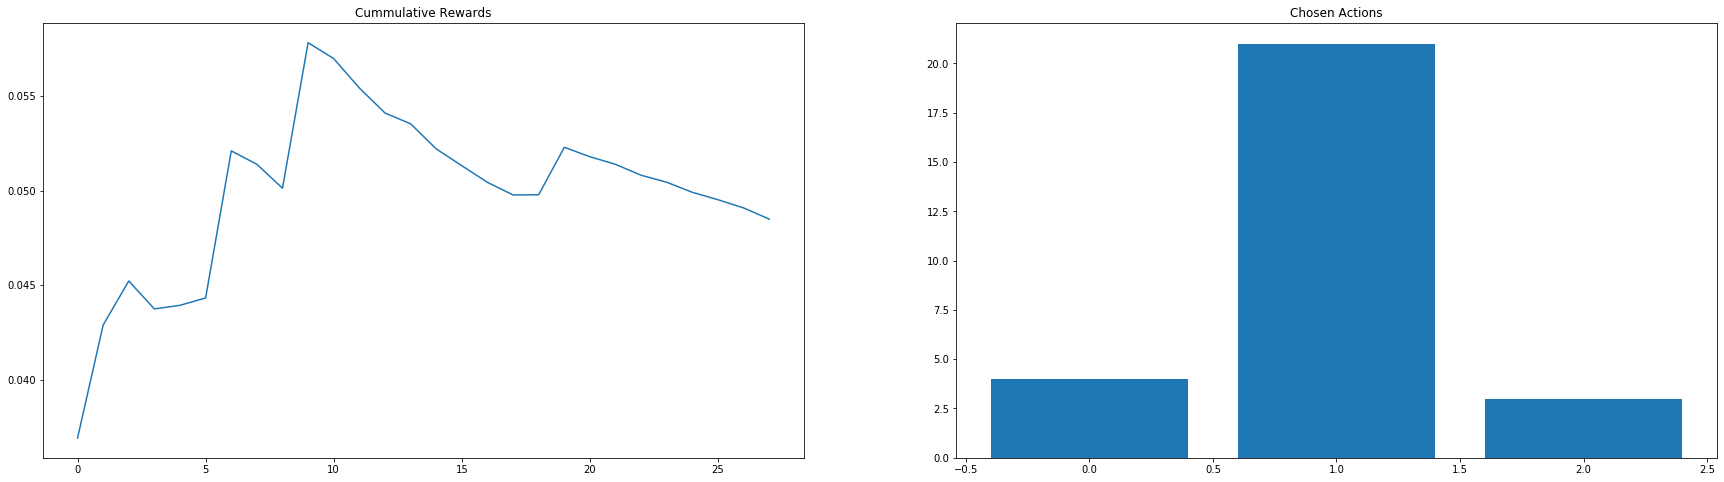

Restart at iteration: 799
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05771115000243299, 'merge_sort': 0.04142459090904926, 'heap_sort': 0.09806090000347467}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 11, 'heap_sort': 2}


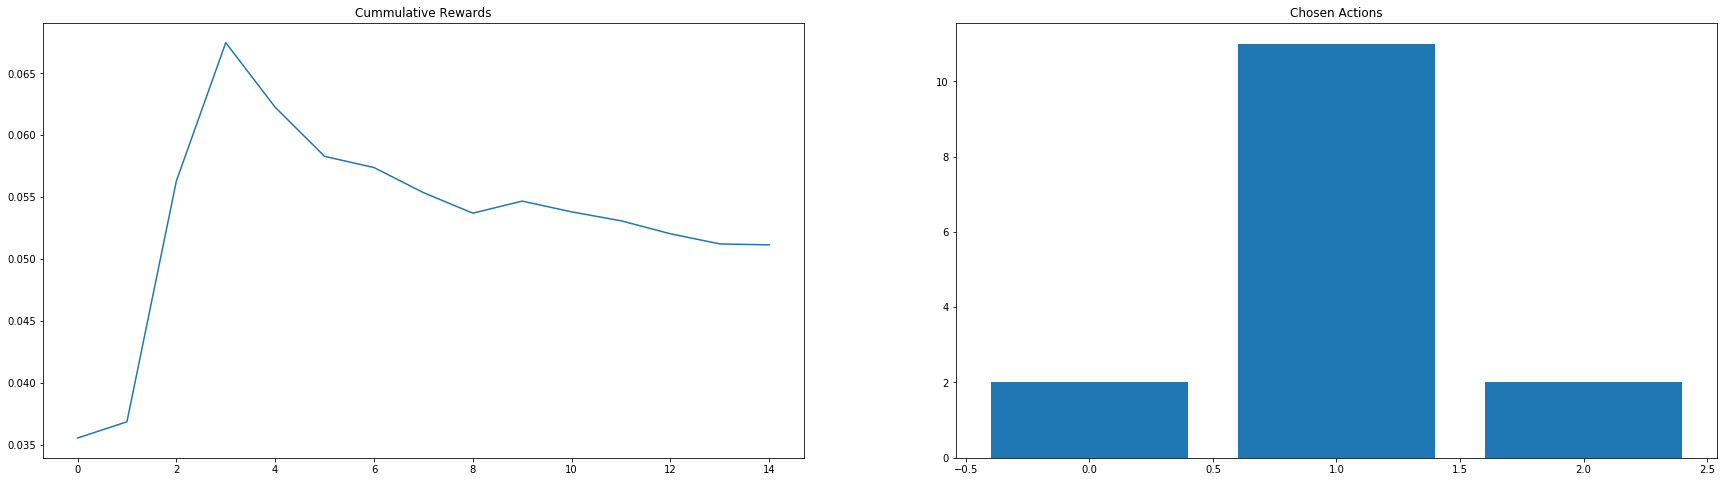

Restart at iteration: 828
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05074127500120085, 'merge_sort': 0.04190952272686197, 'heap_sort': 0.10207220000059654}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 22, 'heap_sort': 3}


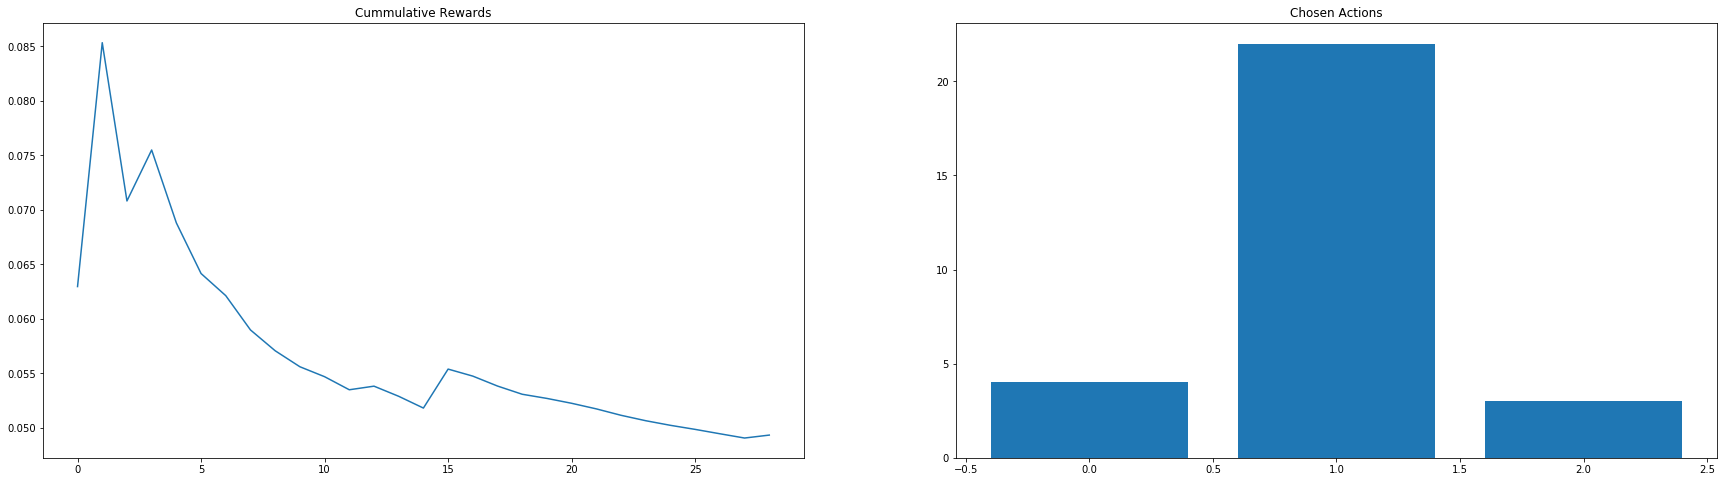

Restart at iteration: 845
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0610740500051179, 'merge_sort': 0.0438339000029373, 'heap_sort': 0.1150329999945825}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 12, 'heap_sort': 3}


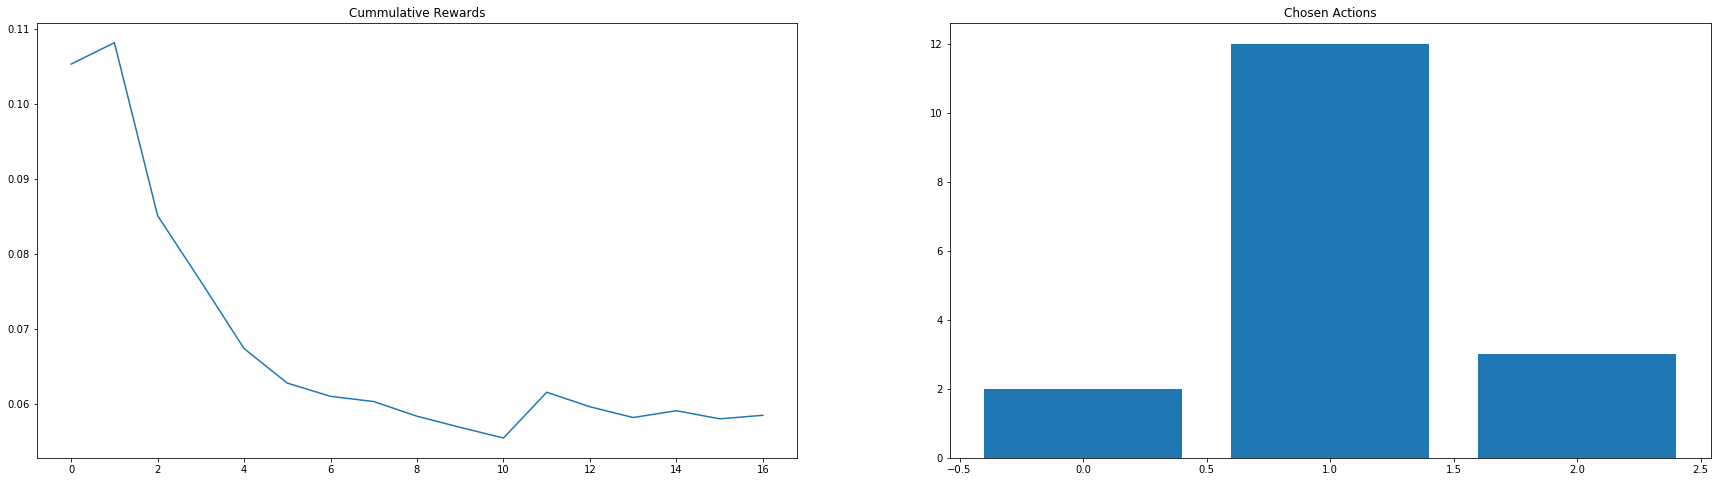

Restart at iteration: 869
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05734175999532454, 'merge_sort': 0.04271715294196517, 'heap_sort': 0.12693810000200756}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 17, 'heap_sort': 2}


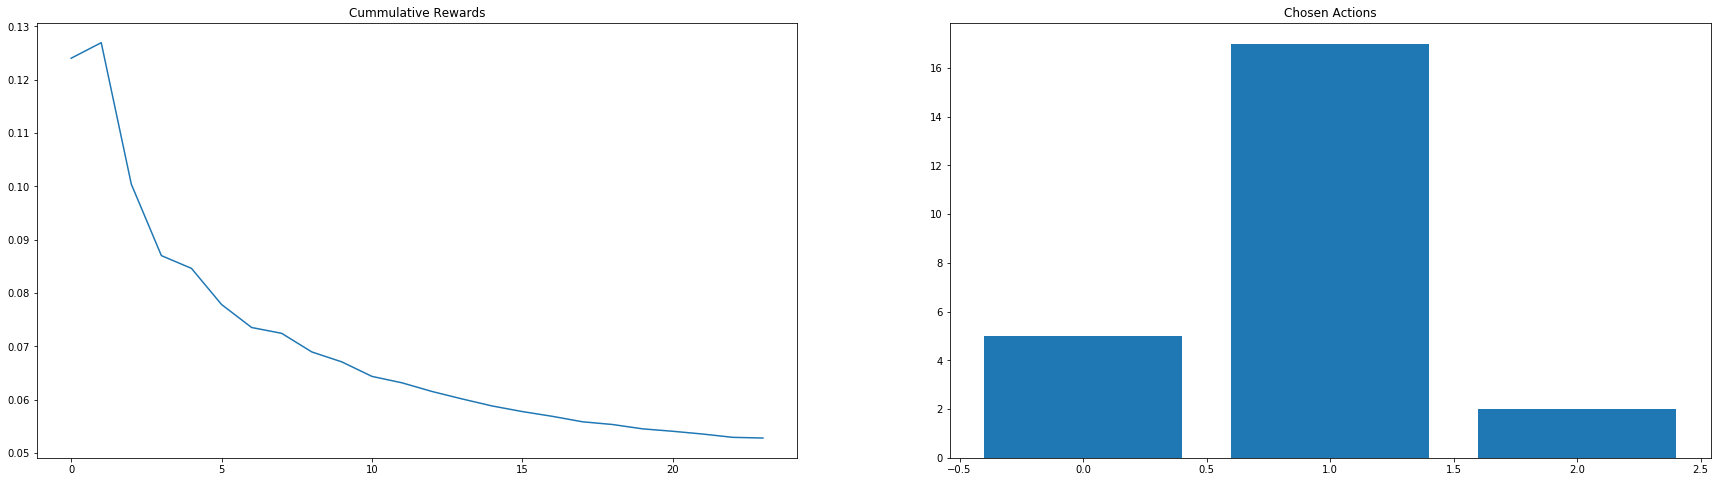

Restart at iteration: 884
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.06789220000064233, 'merge_sort': 0.044093890910682436, 'heap_sort': 0.12217219999729423}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 11, 'heap_sort': 2}


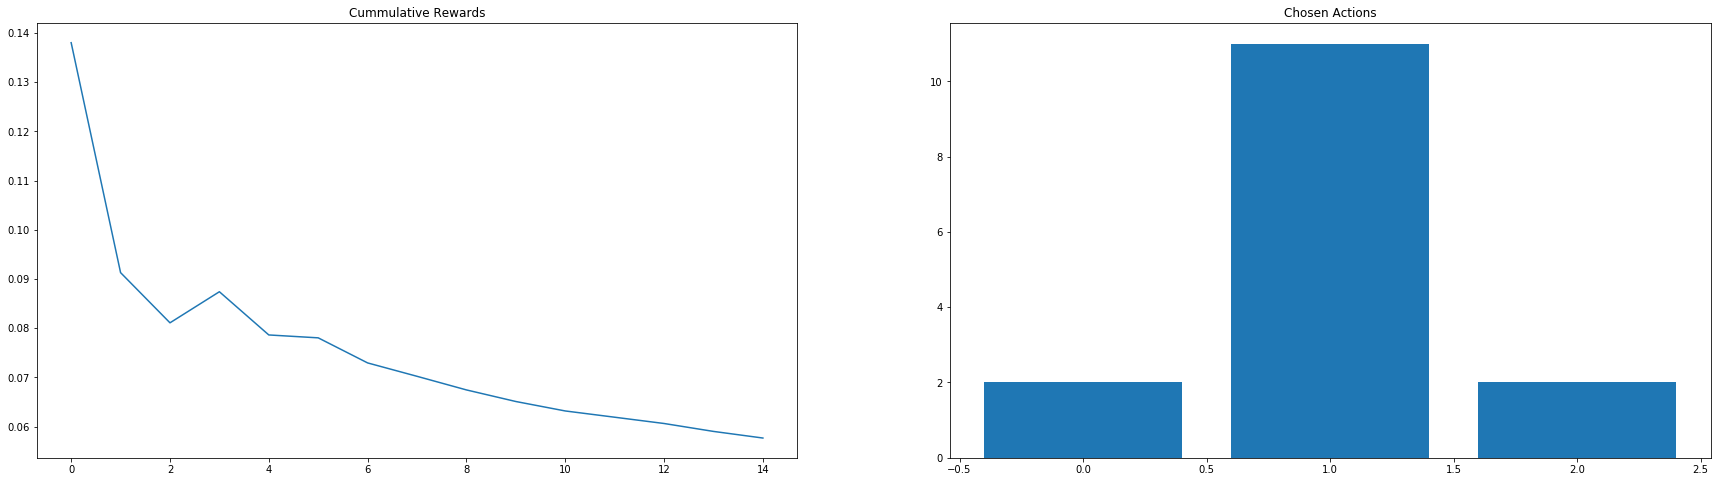

Restart at iteration: 906
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05333536666391107, 'merge_sort': 0.04029146875018341, 'heap_sort': 0.11588469999939359}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 16, 'heap_sort': 3}


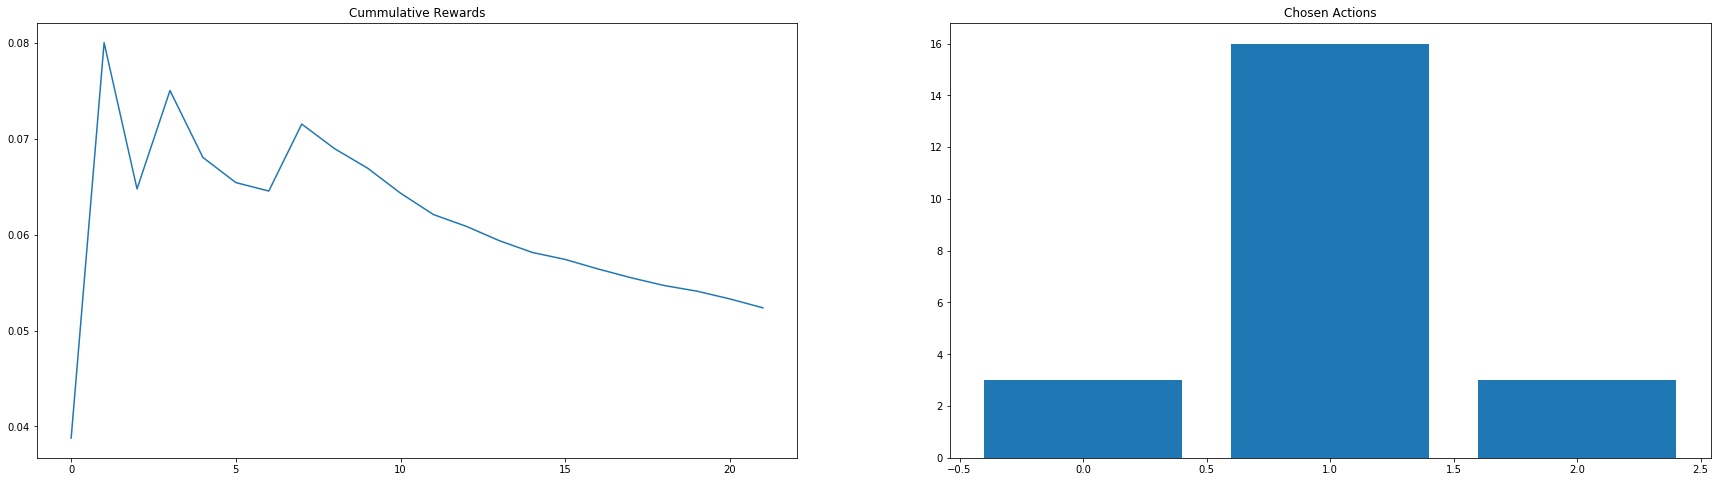

Restart at iteration: 933
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05143300000054296, 'merge_sort': 0.04208388260778283, 'heap_sort': 0.09878269999899203}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 23, 'heap_sort': 2}


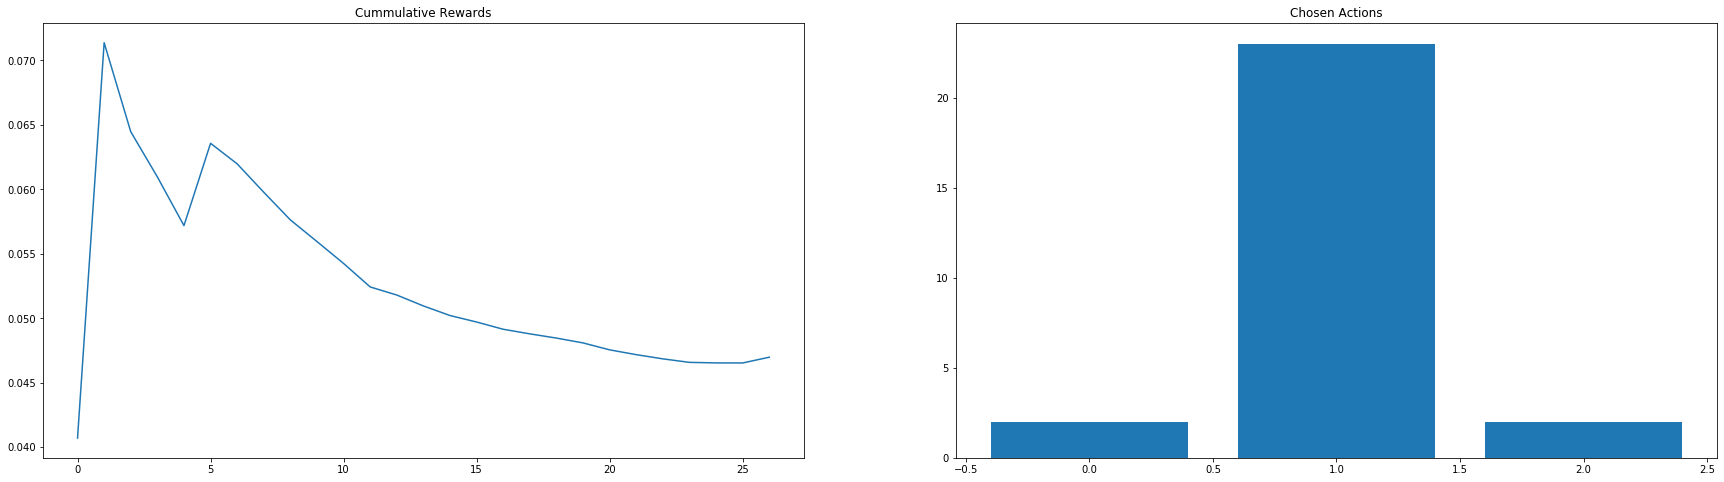

Restart at iteration: 963
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.058085500000743195, 'merge_sort': 0.04583336153882556, 'heap_sort': 0.10611630000494188}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 26, 'heap_sort': 2}


Restart at iteration: 980
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.07717510000657057, 'merge_sort': 0.03897743846195786, 'heap_sort': 0.09992319999582833}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 13, 'heap_sort': 2}


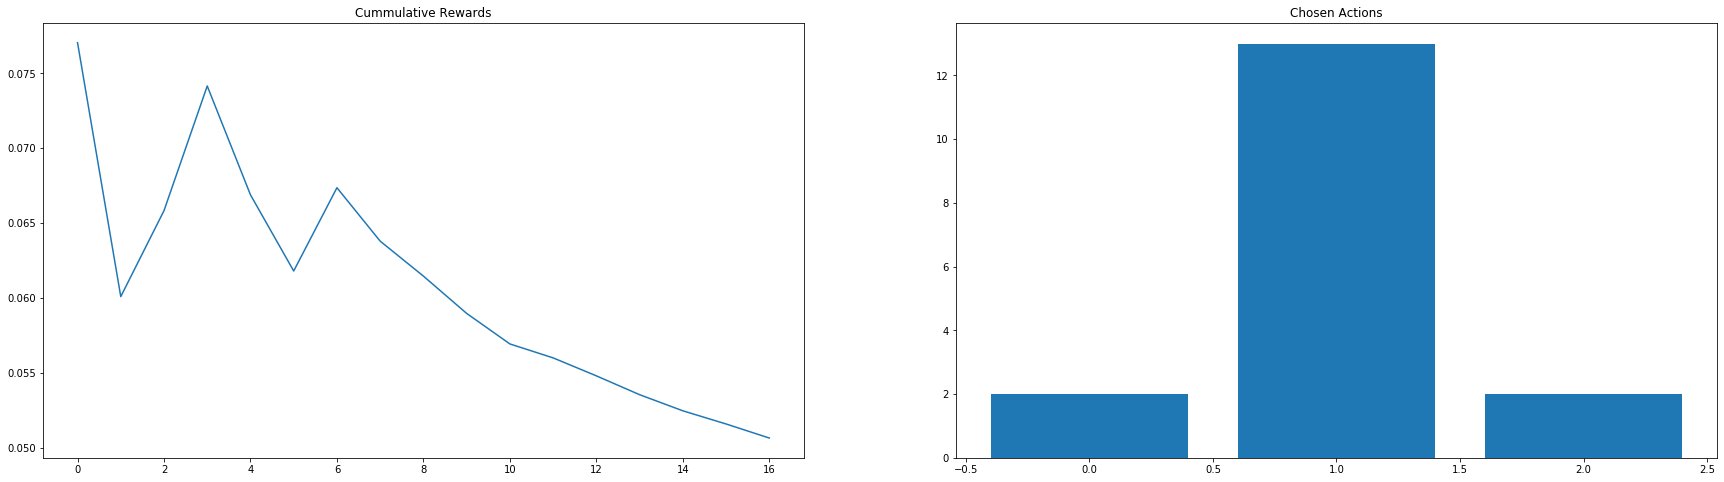

Restart at iteration: 1000
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05562011666188482, 'merge_sort': 0.05407315833144821, 'heap_sort': 0.10611994999635499}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 12, 'heap_sort': 2}


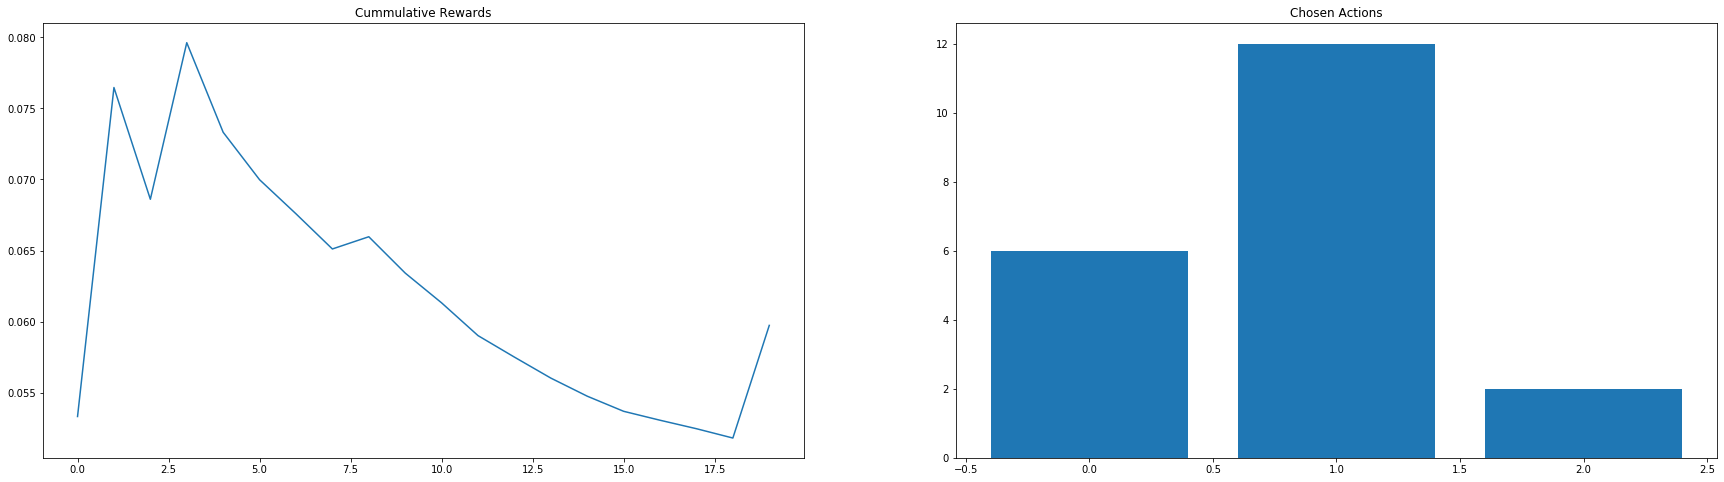

Restart at iteration: 1015
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15523014545430092, 'merge_sort': 0.16263765000621788, 'heap_sort': 0.352136250003241}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 2, 'heap_sort': 2}


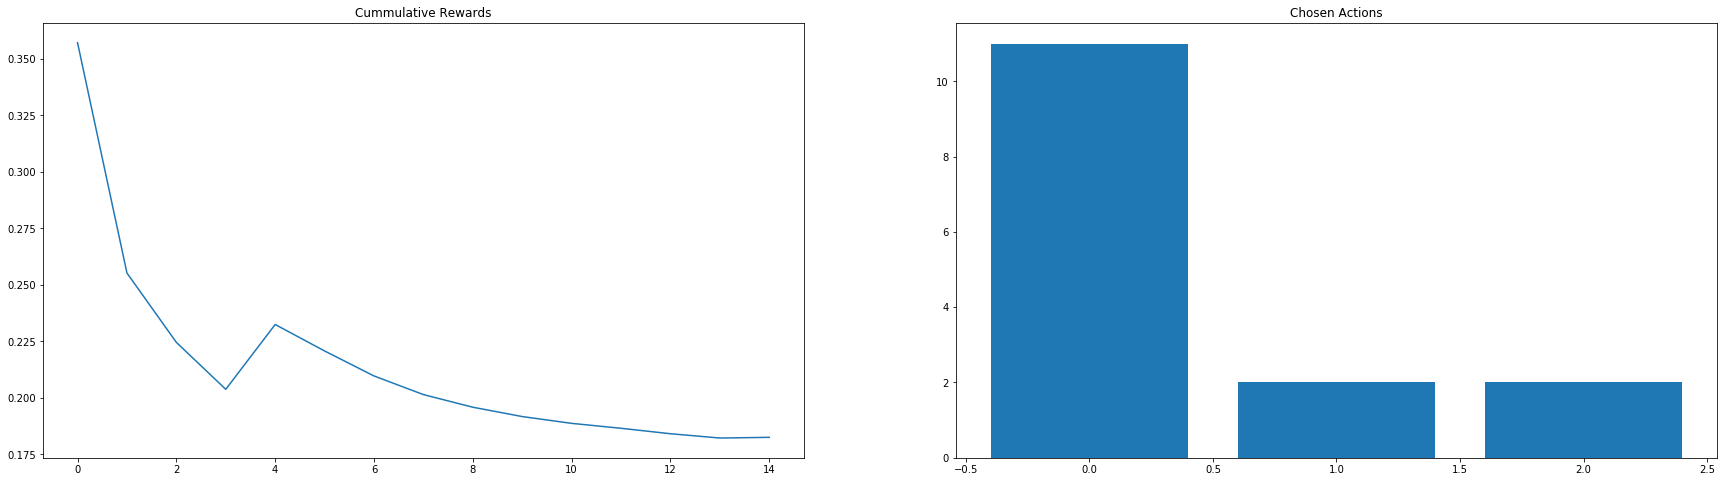

Restart at iteration: 1033
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.16006708333225106, 'merge_sort': 0.1683845499974268, 'heap_sort': 0.3556996499974048}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 4, 'heap_sort': 2}


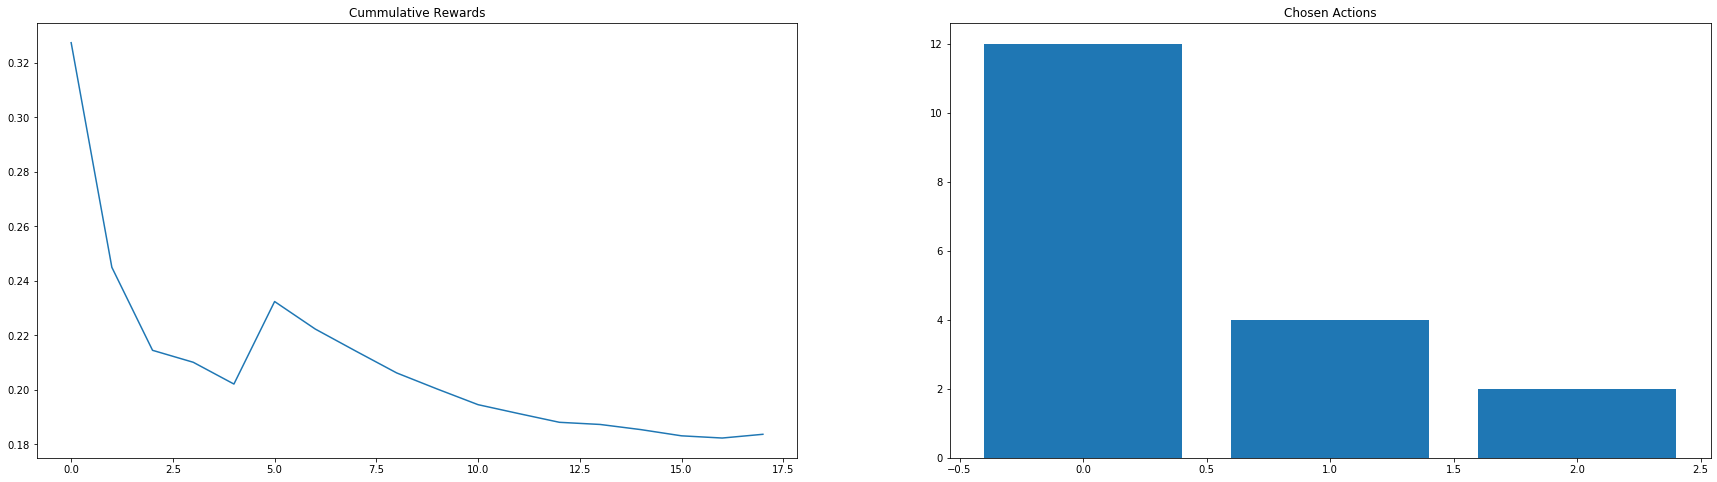

Restart at iteration: 1054
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.17071366666641552, 'merge_sort': 0.19050797142595652, 'heap_sort': 0.3784564000015962}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 7, 'heap_sort': 2}


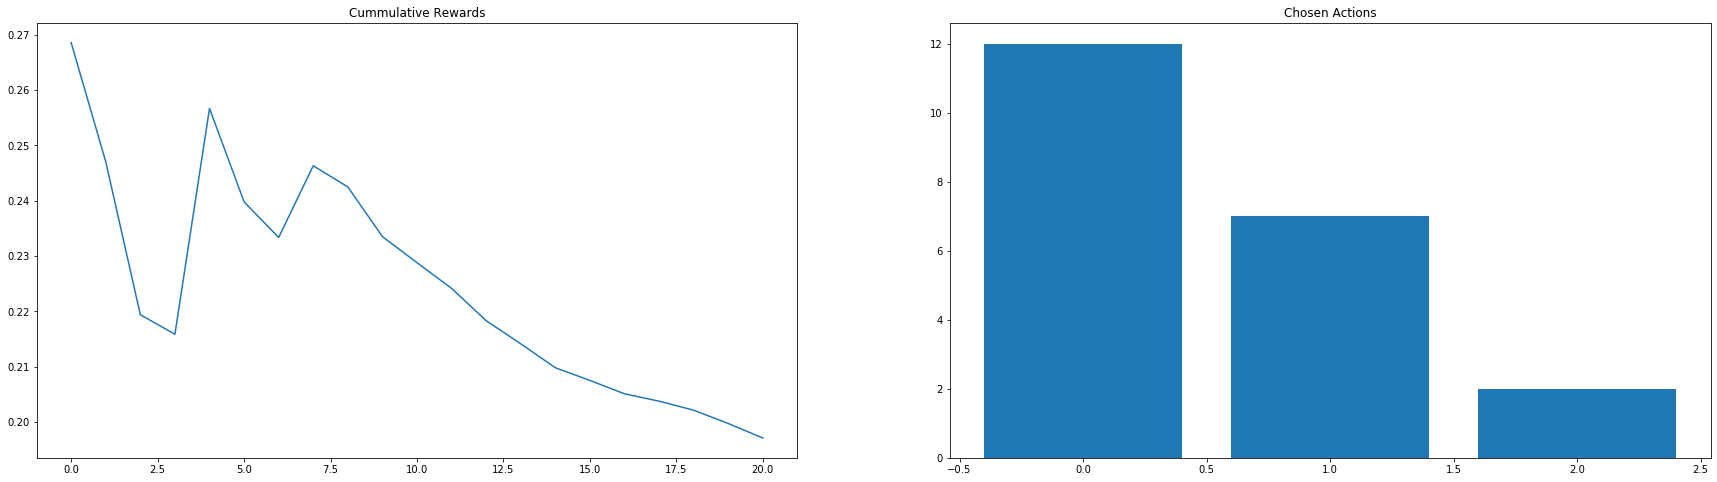

Restart at iteration: 1094
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.16945465172365998, 'merge_sort': 0.20089191250008298, 'heap_sort': 0.4028786666652498}
Count per chosen algo {'quick_sort': 29, 'merge_sort': 8, 'heap_sort': 3}


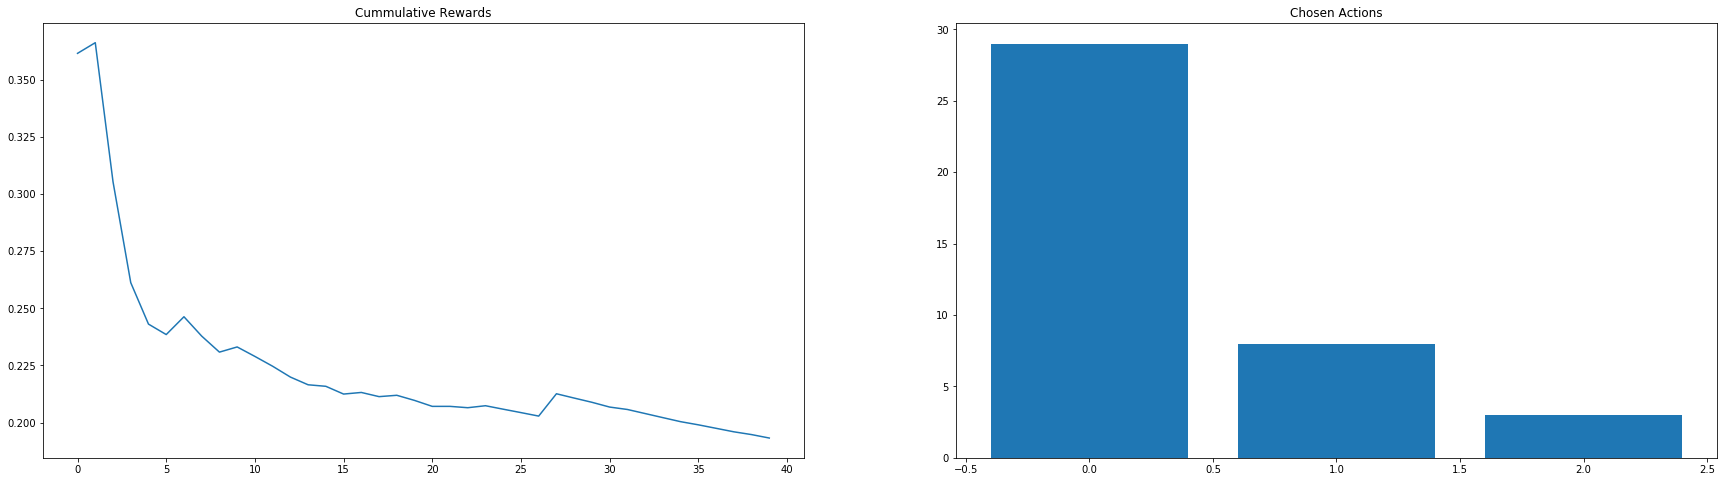

Restart at iteration: 1117
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15329100588346858, 'merge_sort': 0.16358142500030226, 'heap_sort': 0.3435538500052644}
Count per chosen algo {'quick_sort': 17, 'merge_sort': 4, 'heap_sort': 2}


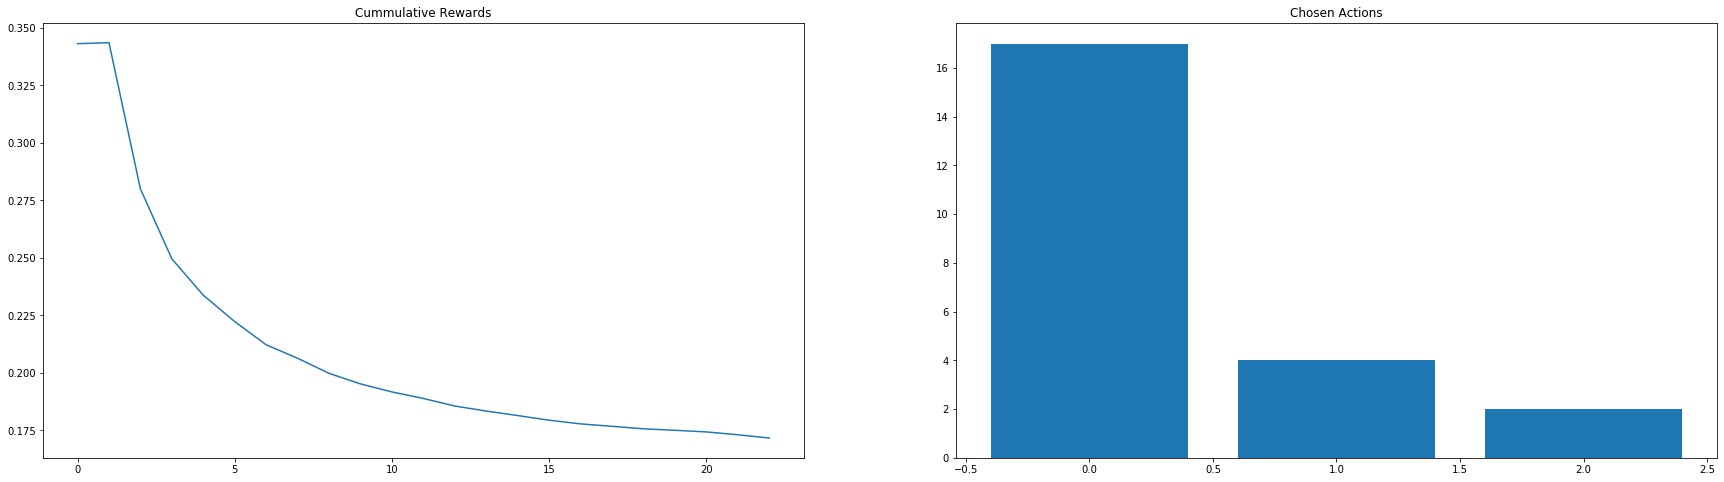

Restart at iteration: 1133
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15143349091125524, 'merge_sort': 0.16473939999802192, 'heap_sort': 0.36813795000489336}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 3, 'heap_sort': 2}


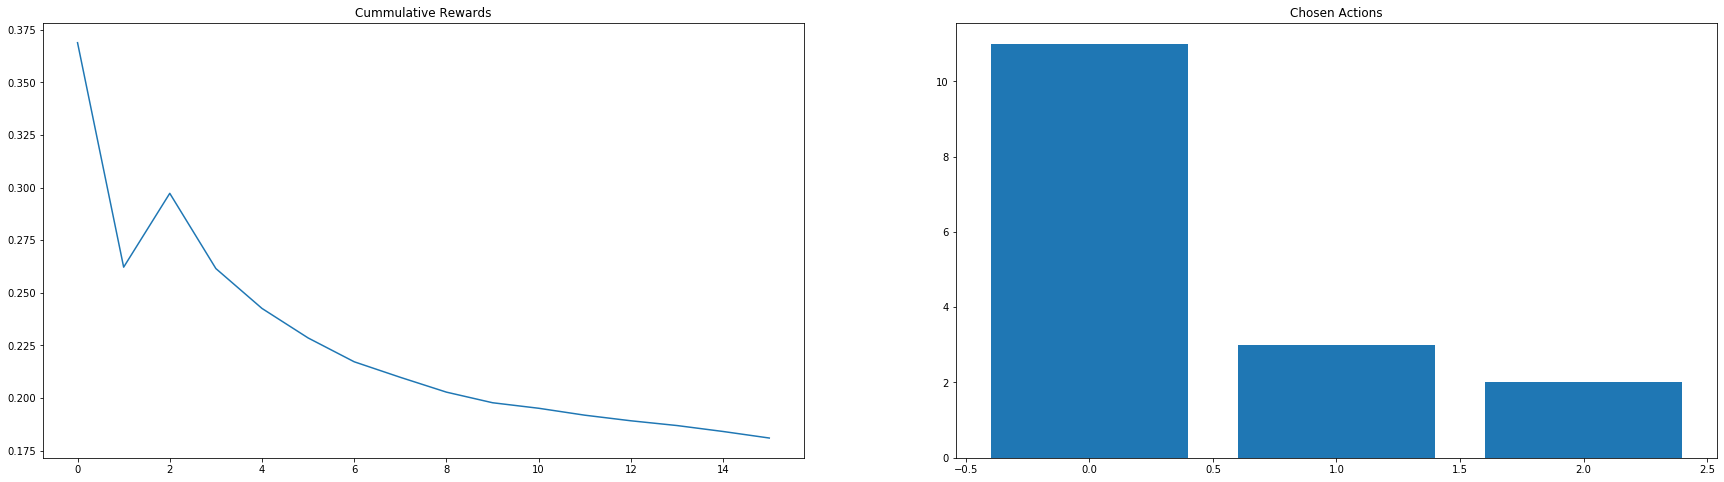

Restart at iteration: 1160
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15239732272774828, 'merge_sort': 0.17135413333016913, 'heap_sort': 0.36309759999858215}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 3, 'heap_sort': 2}


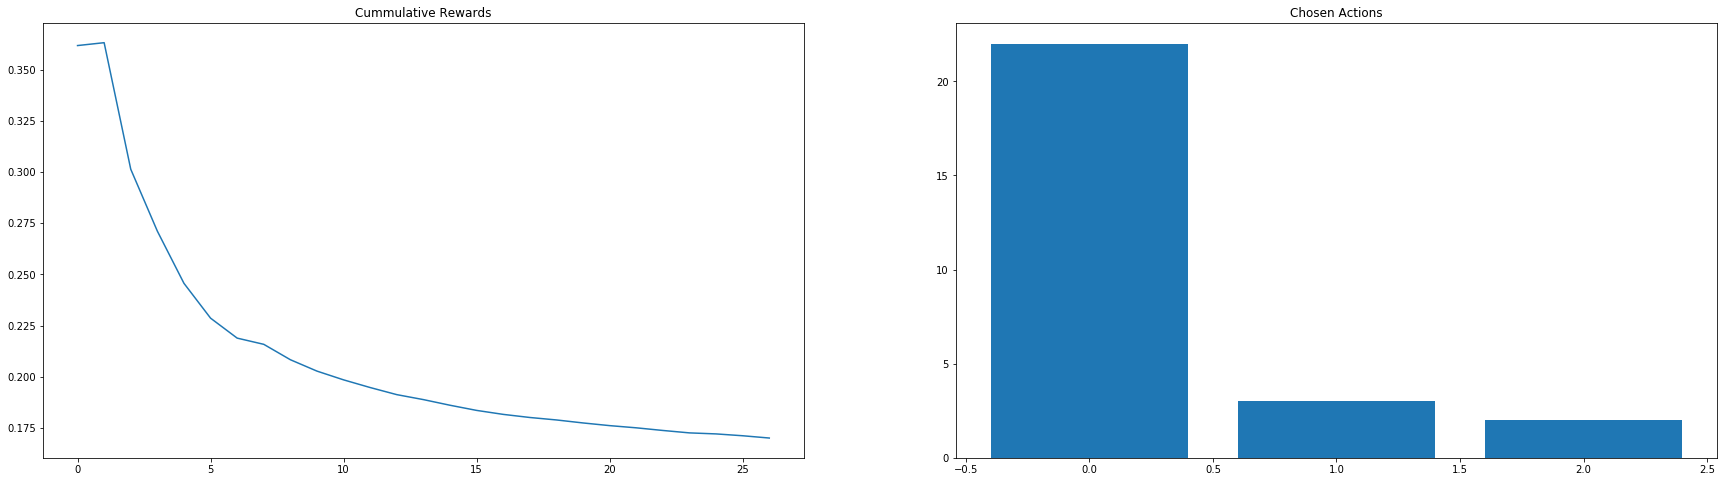

Restart at iteration: 1177
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14950429091219453, 'merge_sort': 0.16511602500031586, 'heap_sort': 0.36452545000065584}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 4, 'heap_sort': 2}


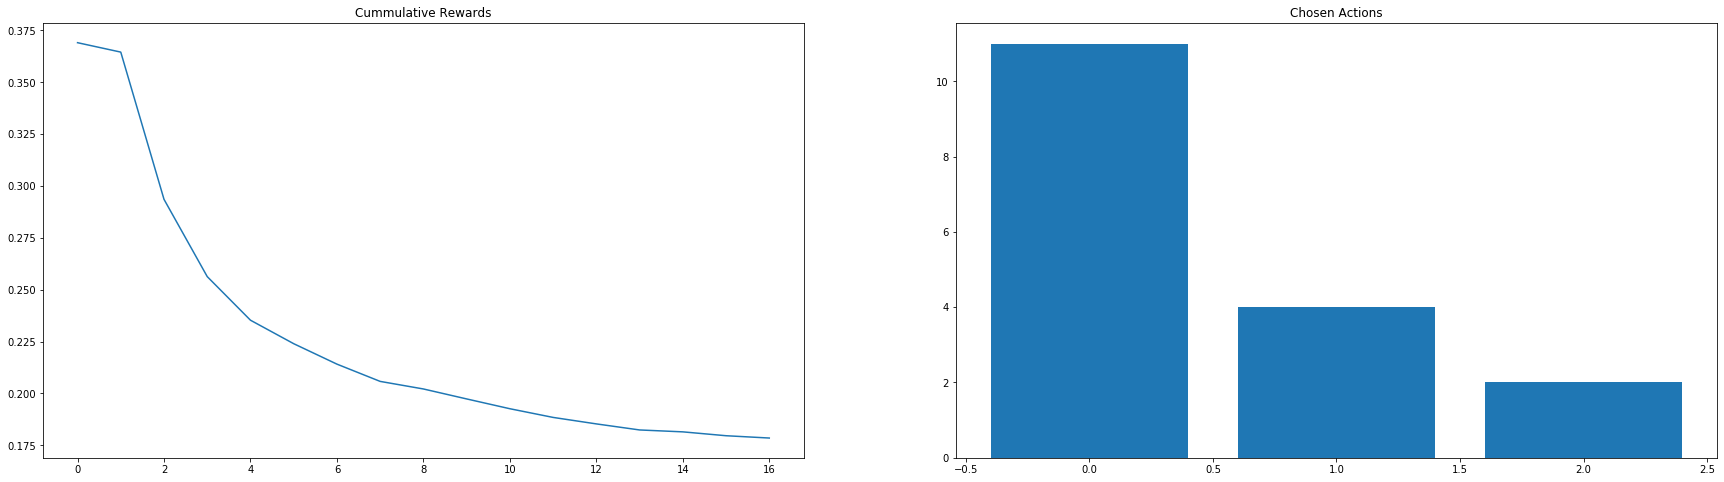

Restart at iteration: 1192
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14771397272786338, 'merge_sort': 0.1661340999926324, 'heap_sort': 0.3465742999978829}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 2, 'heap_sort': 2}


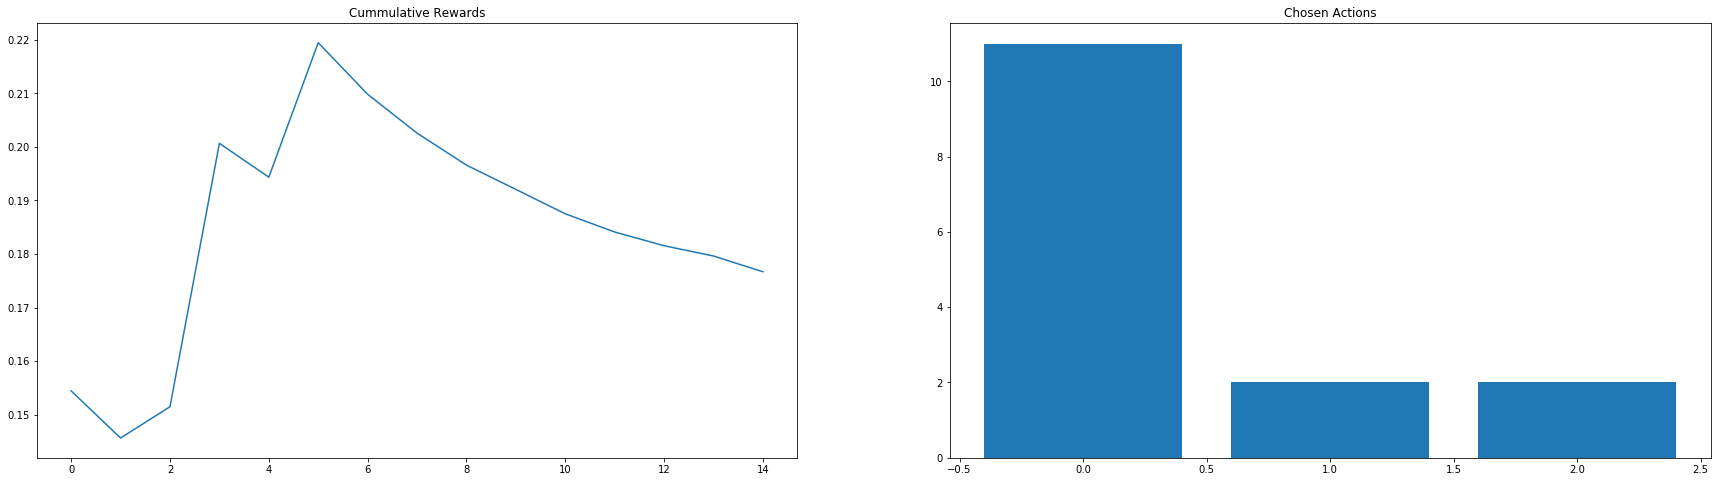

Restart at iteration: 1212
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1488664124999559, 'merge_sort': 0.16573065000557108, 'heap_sort': 0.3600589499983471}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 2, 'heap_sort': 2}


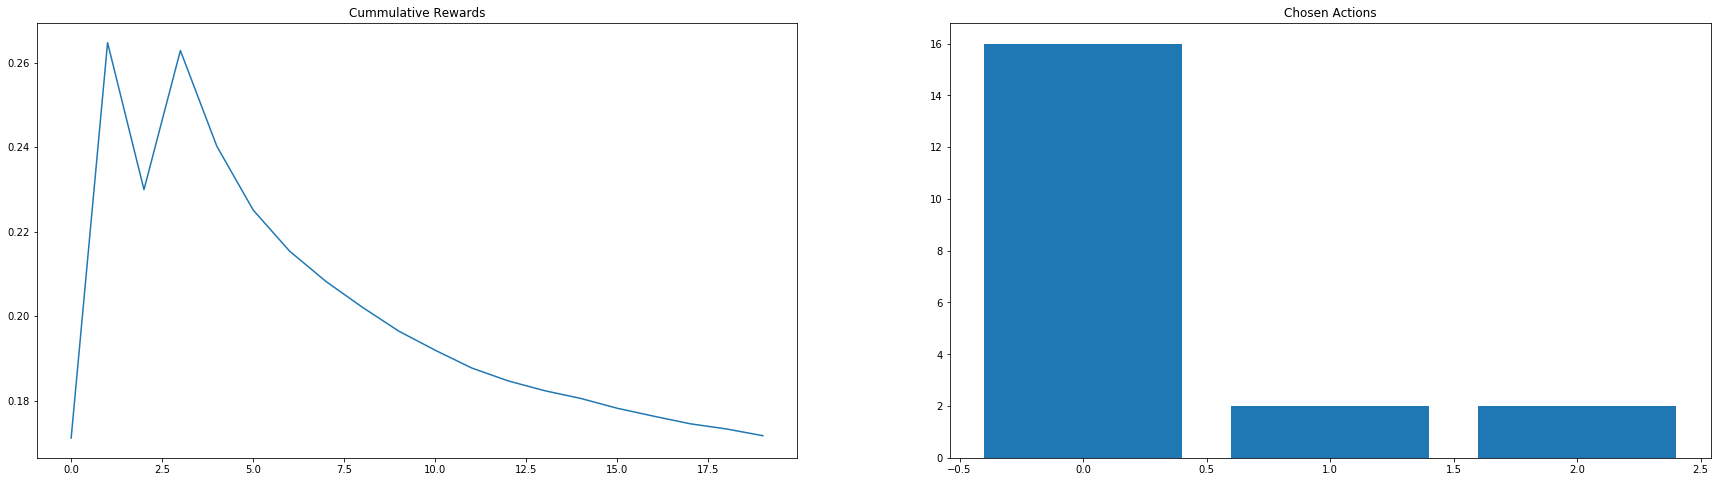

Restart at iteration: 1233
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15580150666646658, 'merge_sort': 0.17576669999107253, 'heap_sort': 0.4234976666678752}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 3, 'heap_sort': 3}


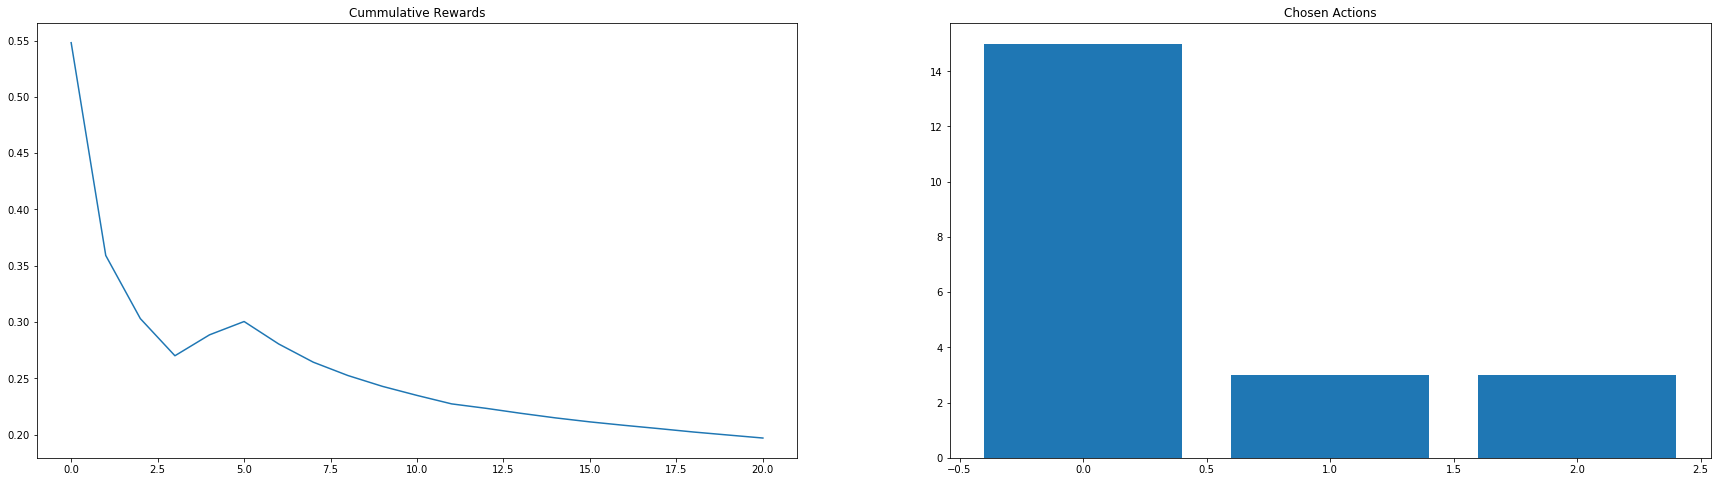

Restart at iteration: 1319
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.15139755874970434, 'merge_sort': 0.1674071500019636, 'heap_sort': 0.3551147500038496}
Count per chosen algo {'quick_sort': 80, 'merge_sort': 4, 'heap_sort': 2}


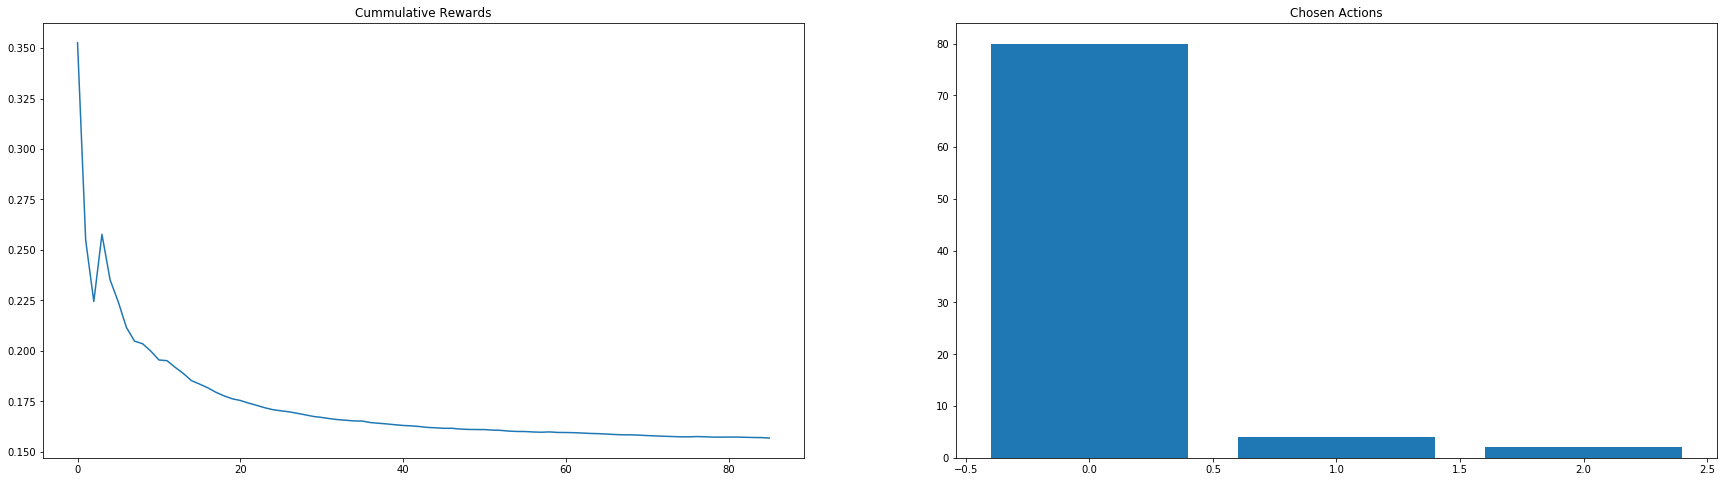

Restart at iteration: 1338
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.16362340769018585, 'merge_sort': 0.18102395000096294, 'heap_sort': 0.361702599999262}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 4, 'heap_sort': 2}


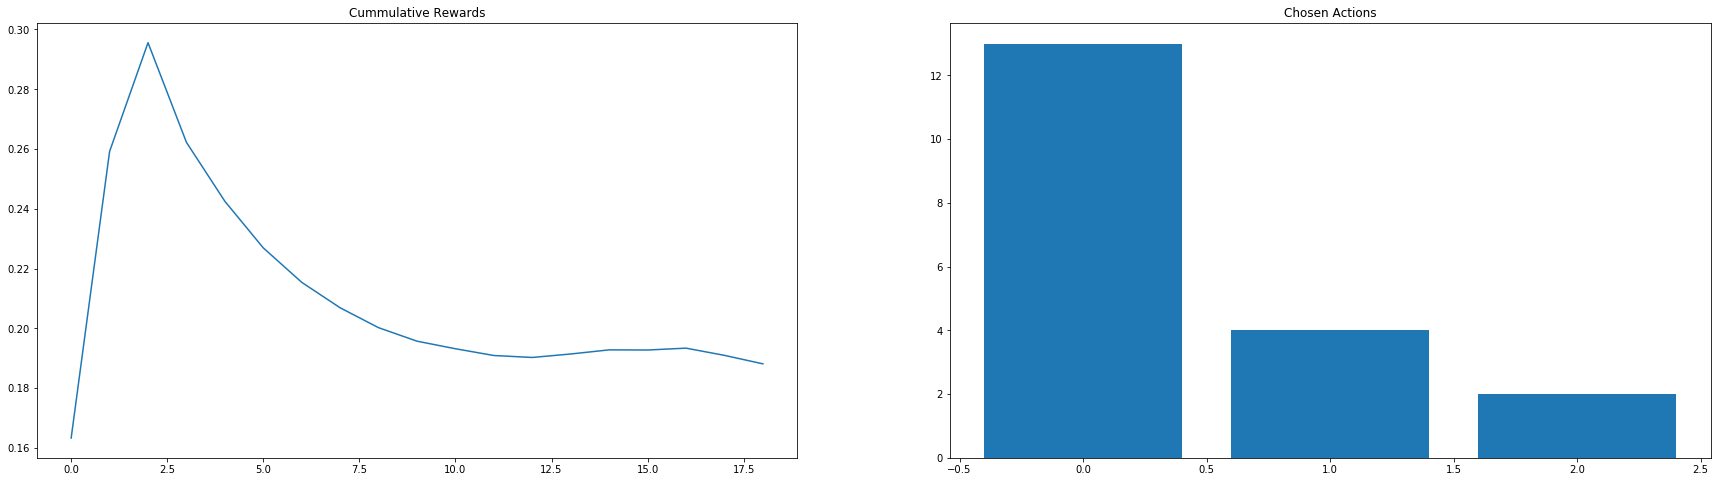

Restart at iteration: 1368
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.17639668636018707, 'merge_sort': 0.20724494000314736, 'heap_sort': 0.3760360666589501}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 5, 'heap_sort': 3}


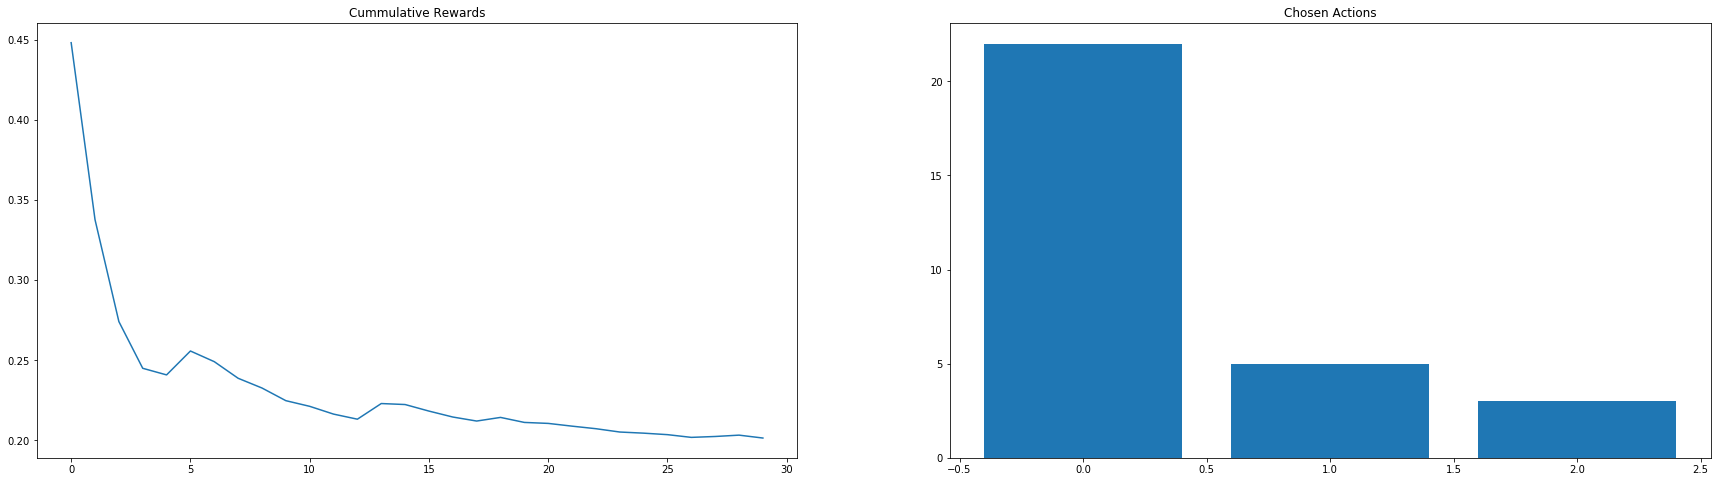

Restart at iteration: 1384
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1614811818197433, 'merge_sort': 0.17125449999972867, 'heap_sort': 0.36837465000280645}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 3, 'heap_sort': 2}


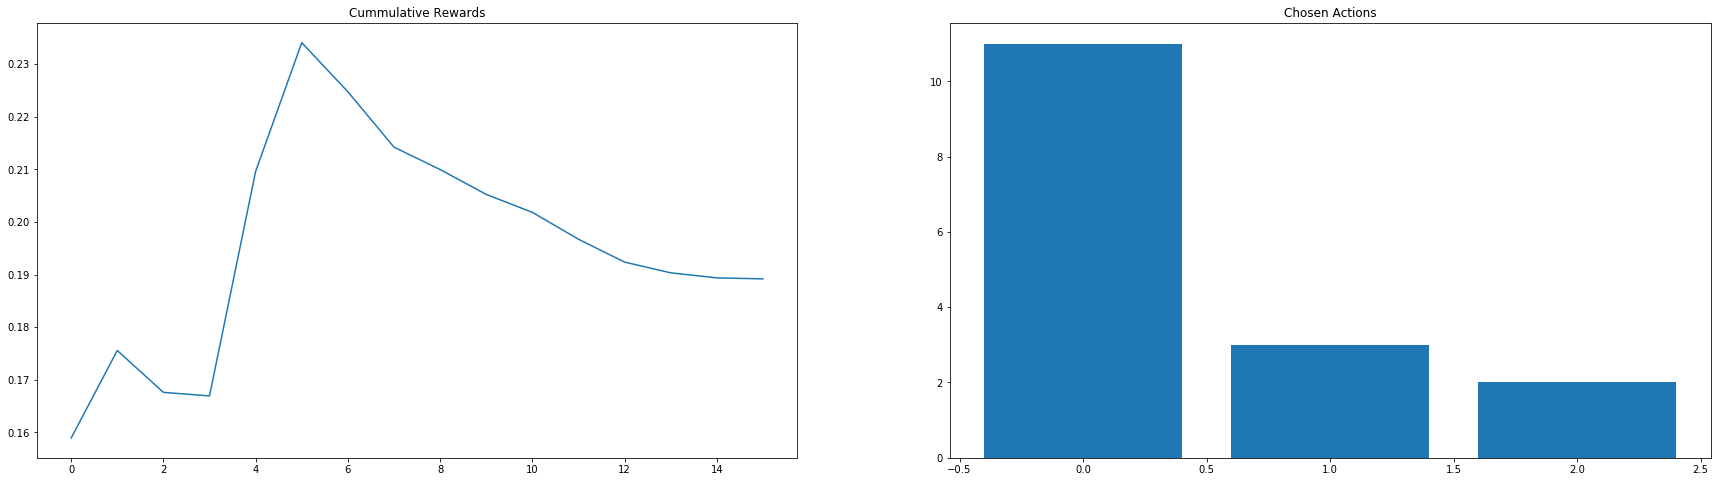

Restart at iteration: 1409
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1737033874987901, 'merge_sort': 0.1983574571453833, 'heap_sort': 0.4508500500014634}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 7, 'heap_sort': 2}


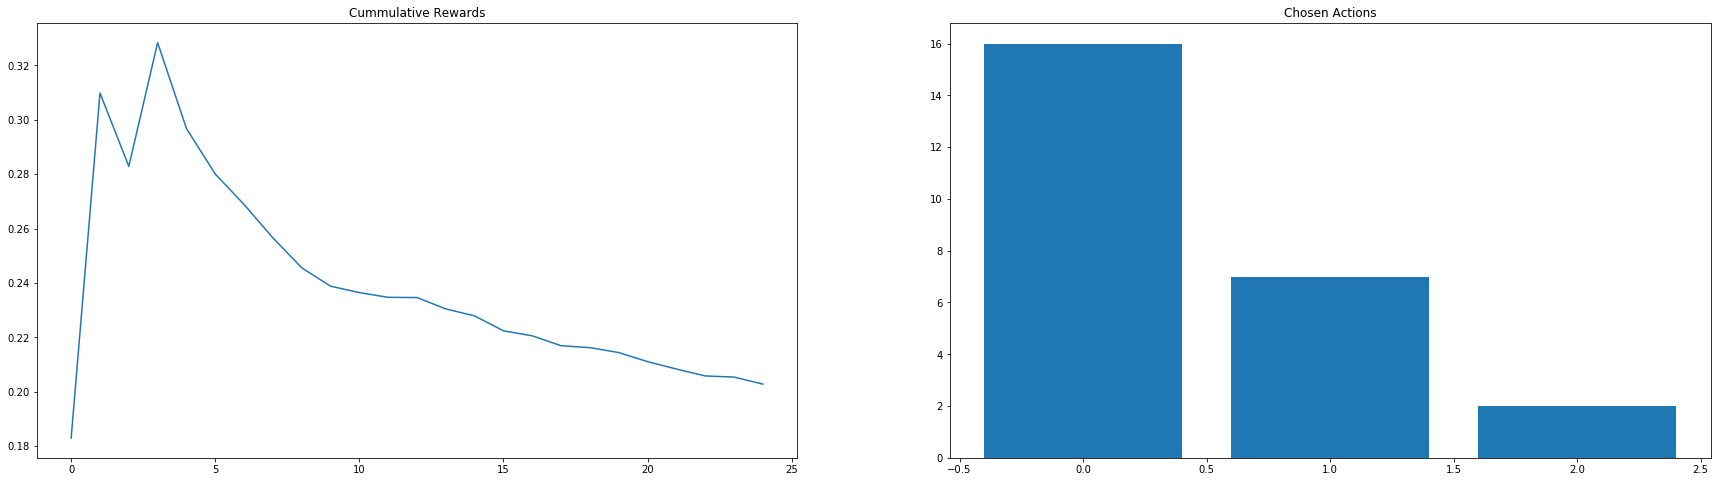

Restart at iteration: 1437
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.18524342941151084, 'merge_sort': 0.19041005555482116, 'heap_sort': 0.45557279999775346}
Count per chosen algo {'quick_sort': 17, 'merge_sort': 9, 'heap_sort': 2}


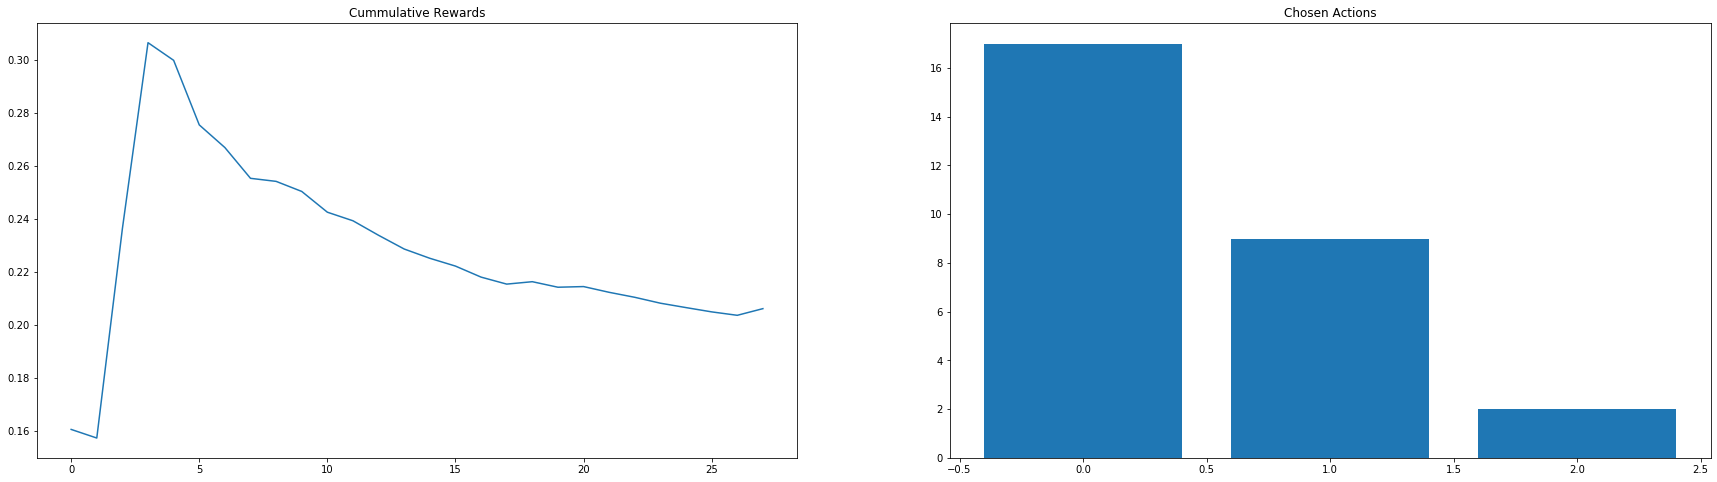

Restart at iteration: 1465
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1884022428577217, 'merge_sort': 0.1991056090919301, 'heap_sort': 0.4863176666694926}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 11, 'heap_sort': 3}


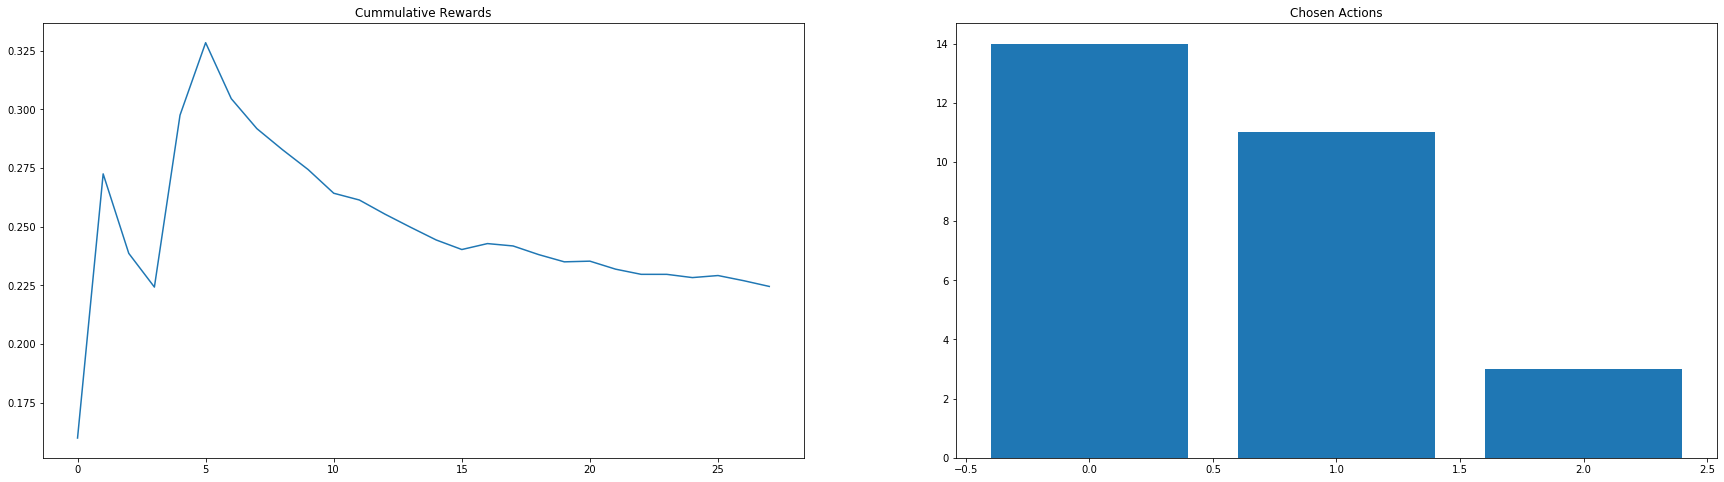

Restart at iteration: 1500
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.16535154615345304, 'merge_sort': 0.18017875714576803, 'heap_sort': 0.36801359999662964}
Count per chosen algo {'quick_sort': 26, 'merge_sort': 7, 'heap_sort': 2}


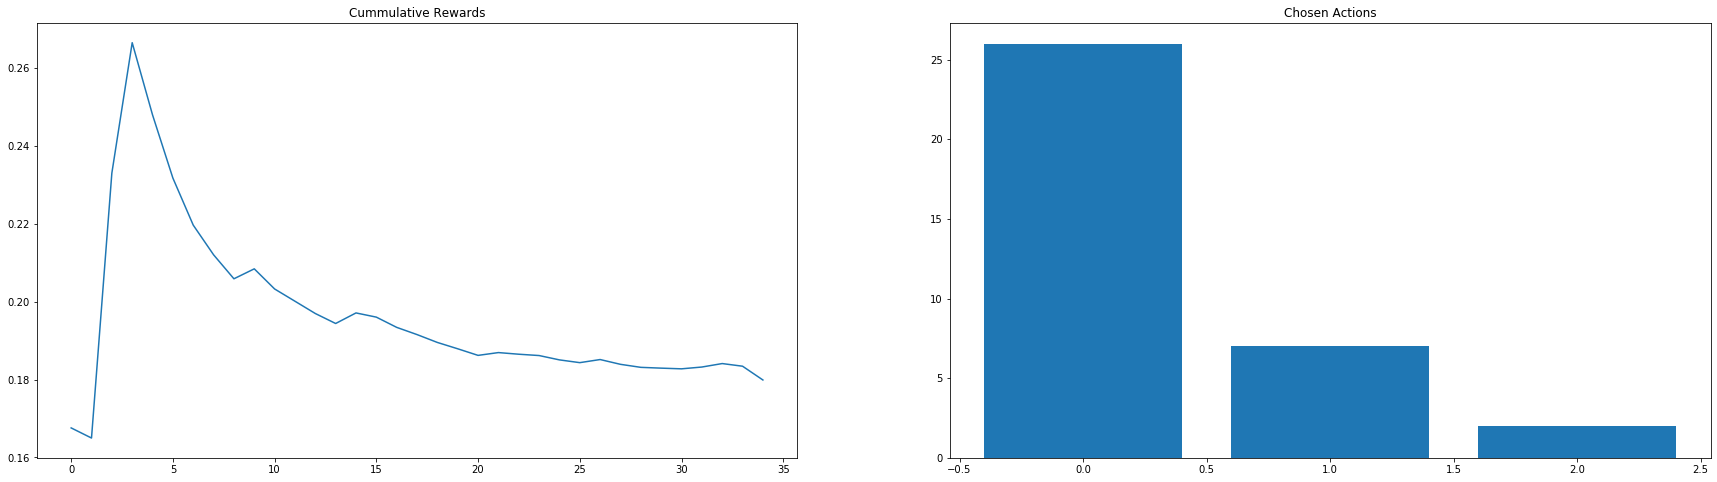

Restart at iteration: 1517
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.053959900003974326, 'merge_sort': 0.04599929230999596, 'heap_sort': 0.1132556000011391}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 13, 'heap_sort': 2}


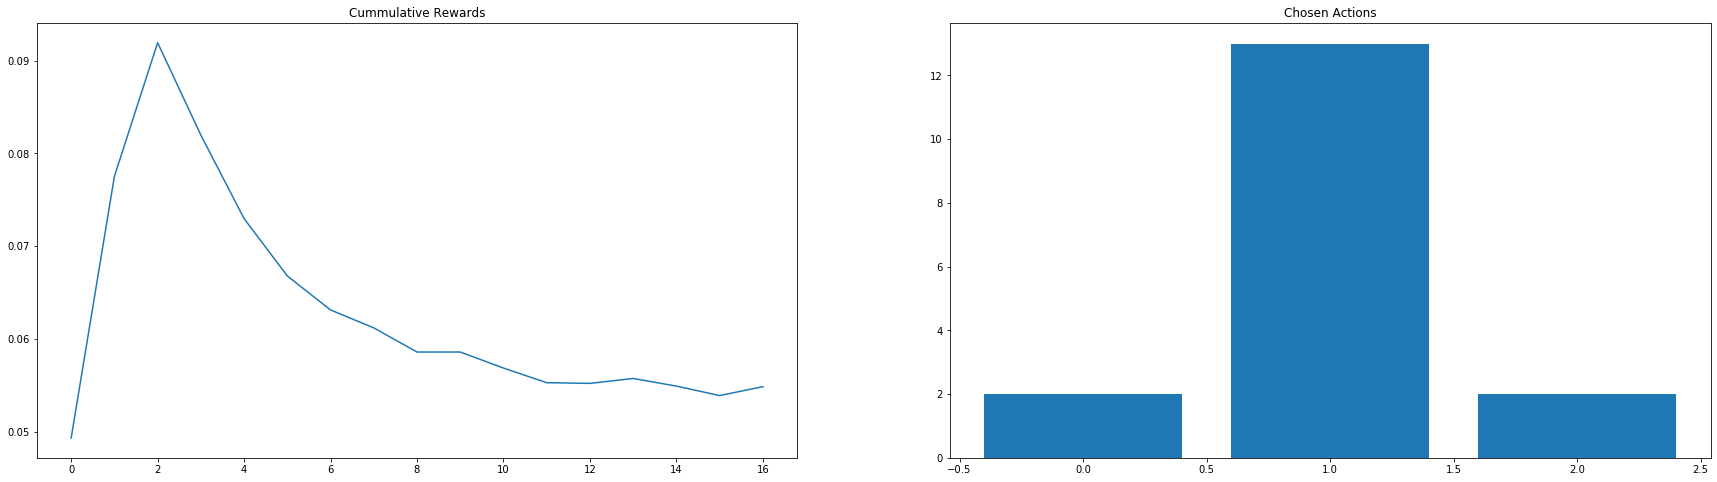

Restart at iteration: 1533
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05964253333028561, 'merge_sort': 0.043101618181522514, 'heap_sort': 0.11158004999742843}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 11, 'heap_sort': 2}


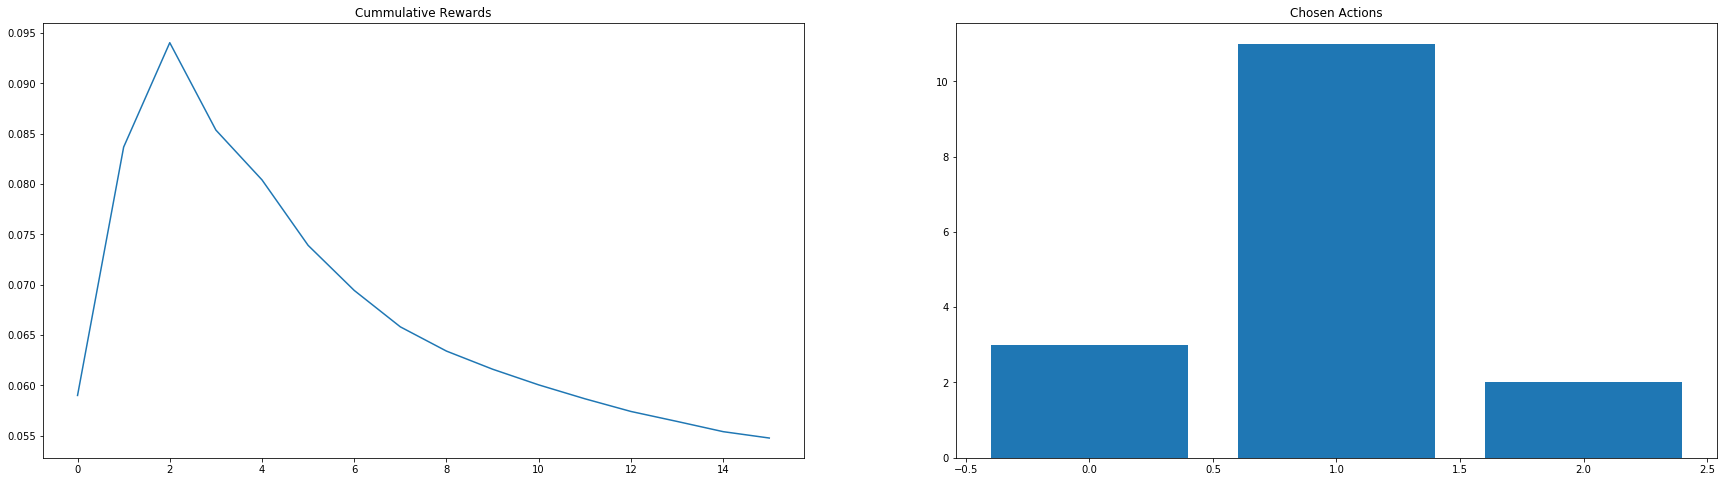

Restart at iteration: 1565
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.06335134999244474, 'merge_sort': 0.0407158499999371, 'heap_sort': 0.12506629999552388}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 28, 'heap_sort': 2}


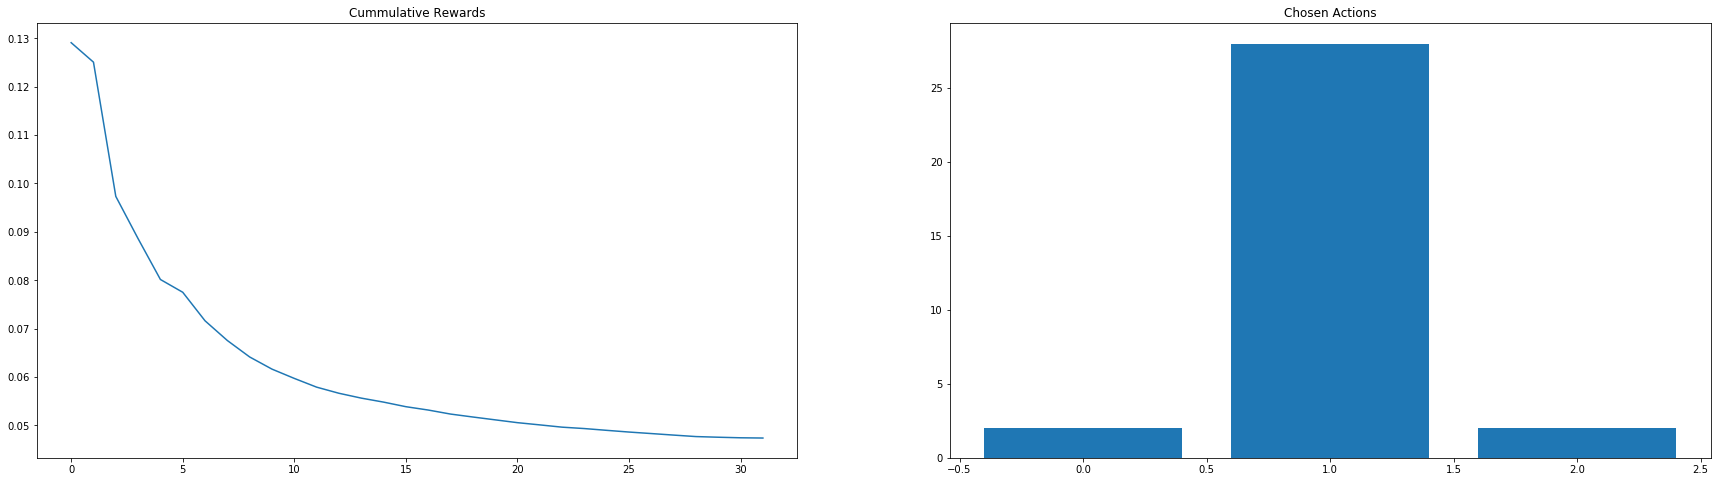

Restart at iteration: 1581
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.07058709999546409, 'merge_sort': 0.04831500909031919, 'heap_sort': 0.12613335000060033}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 11, 'heap_sort': 2}


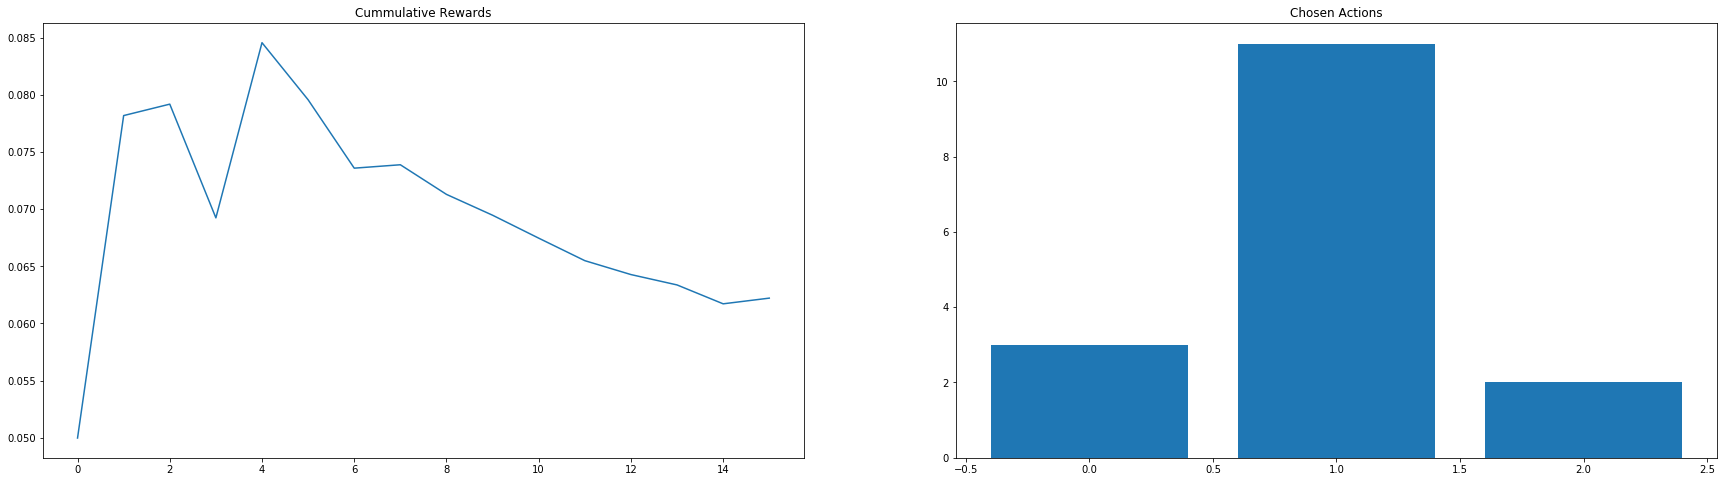

Restart at iteration: 1599
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.060565174997464055, 'merge_sort': 0.03820545833392922, 'heap_sort': 0.11837395000475226}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 12, 'heap_sort': 2}


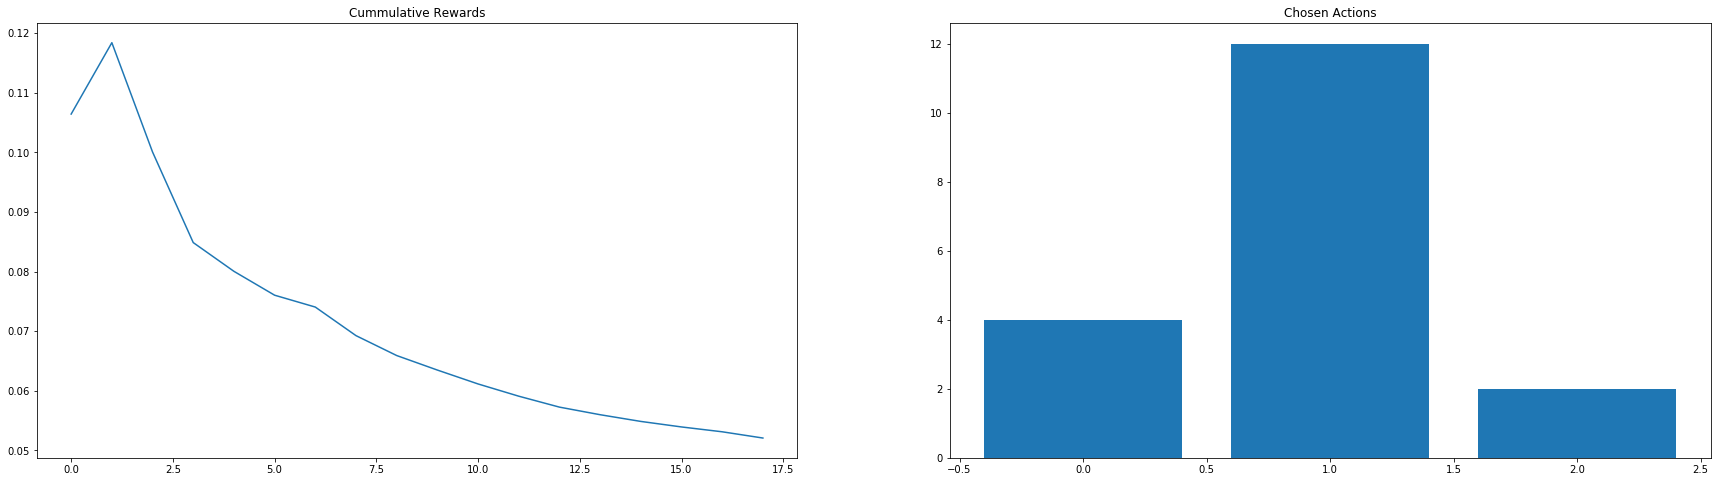

Restart at iteration: 1614
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.06434510000690352, 'merge_sort': 0.04253352727127177, 'heap_sort': 0.12014610000187531}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 11, 'heap_sort': 2}


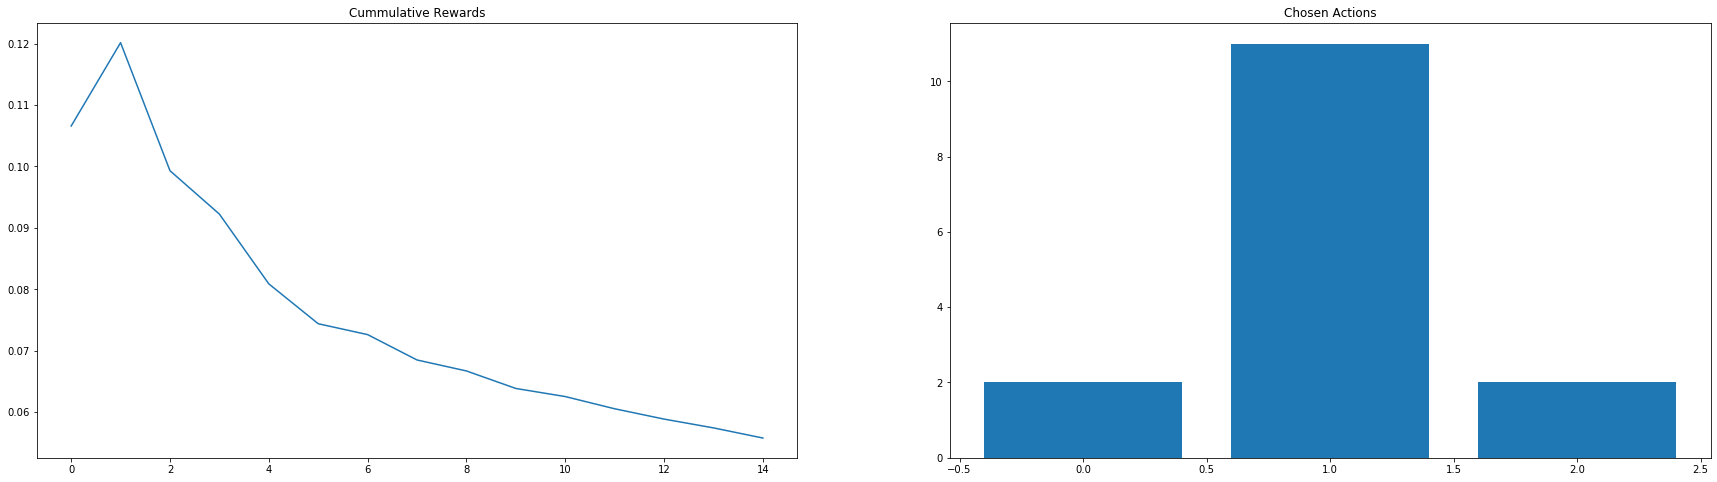

Restart at iteration: 1629
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.07320540000364417, 'merge_sort': 0.0450956181792373, 'heap_sort': 0.11649380000017118}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 11, 'heap_sort': 2}


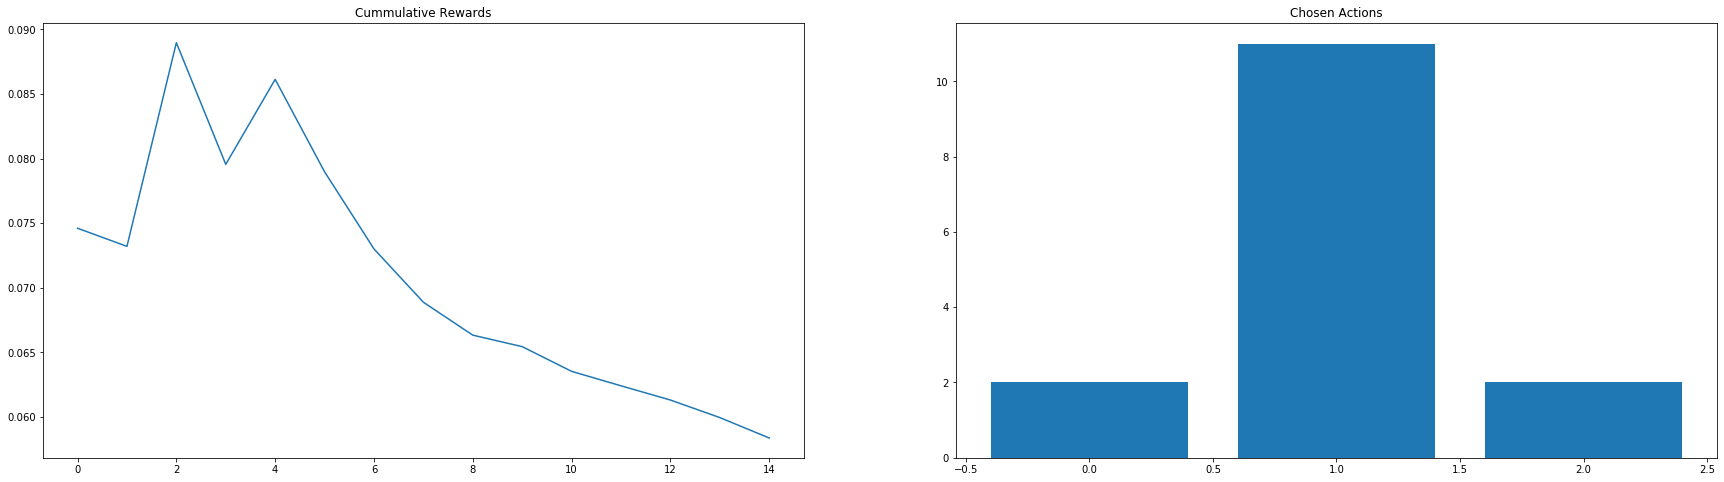

Restart at iteration: 1664
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.058236660005059095, 'merge_sort': 0.045499089285710524, 'heap_sort': 0.12187909999920521}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 28, 'heap_sort': 2}


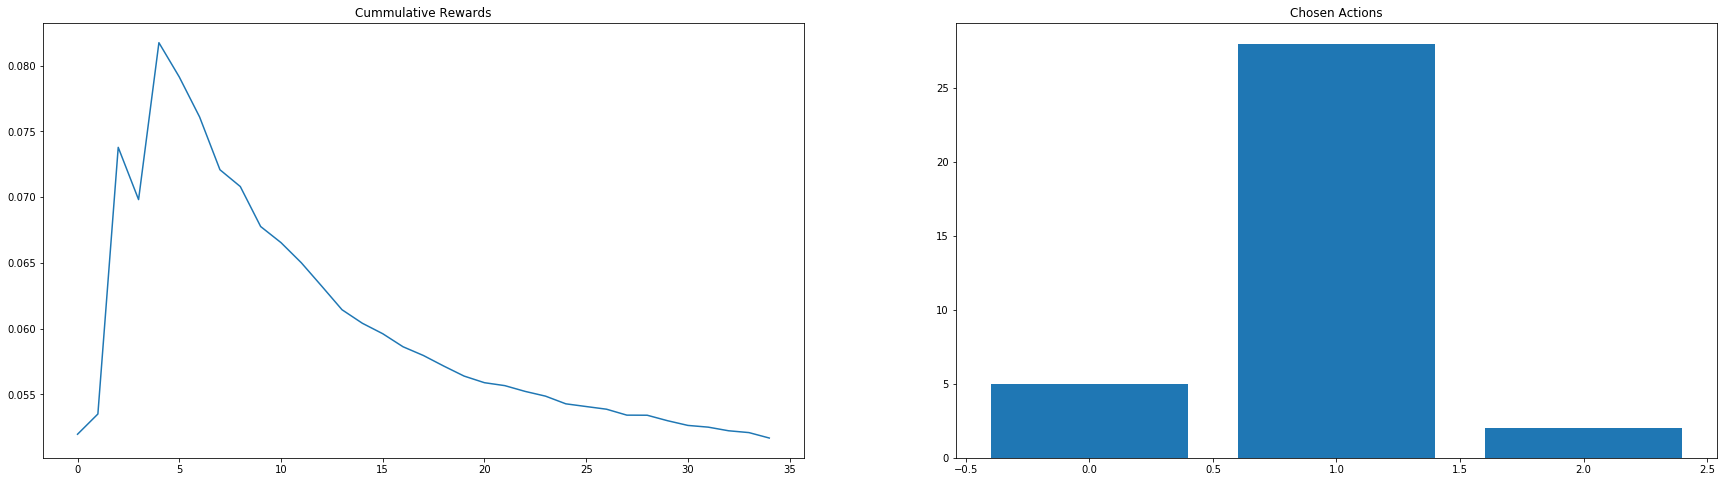

Restart at iteration: 1694
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.06656015999906231, 'merge_sort': 0.04405300000022786, 'heap_sort': 0.14435099999900558}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 21, 'heap_sort': 4}


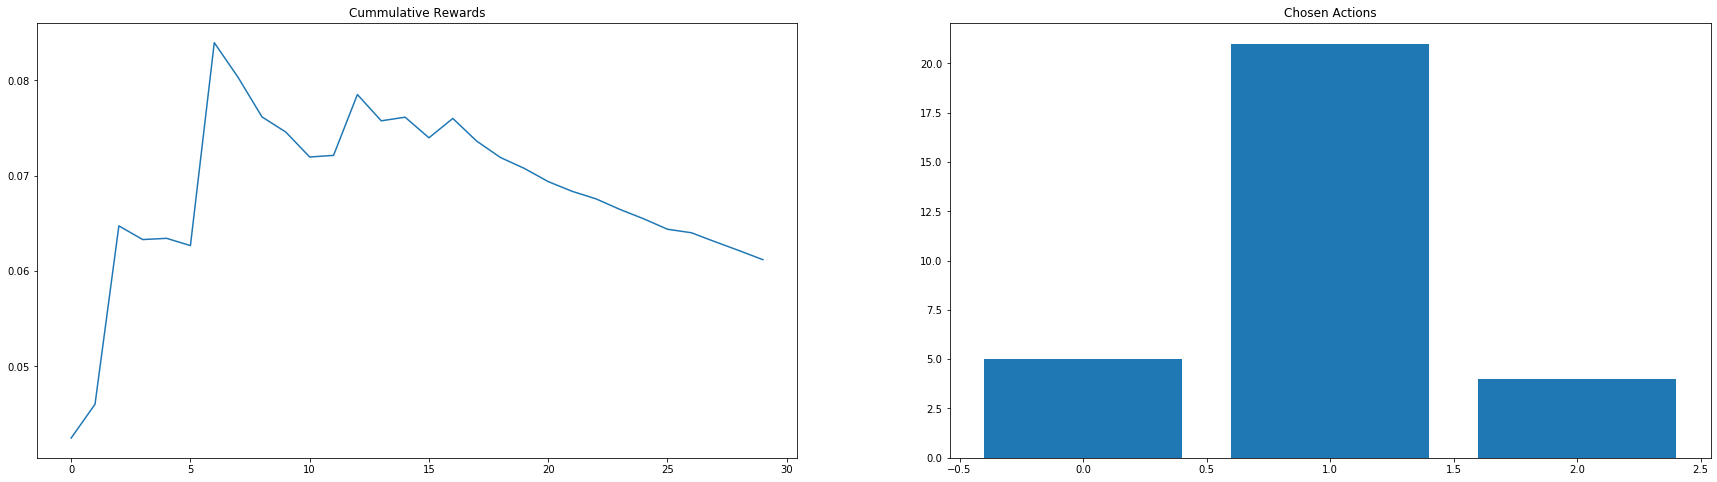

Restart at iteration: 1714
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05793953333341051, 'merge_sort': 0.04746884285850683, 'heap_sort': 0.11699606667389162}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 14, 'heap_sort': 3}


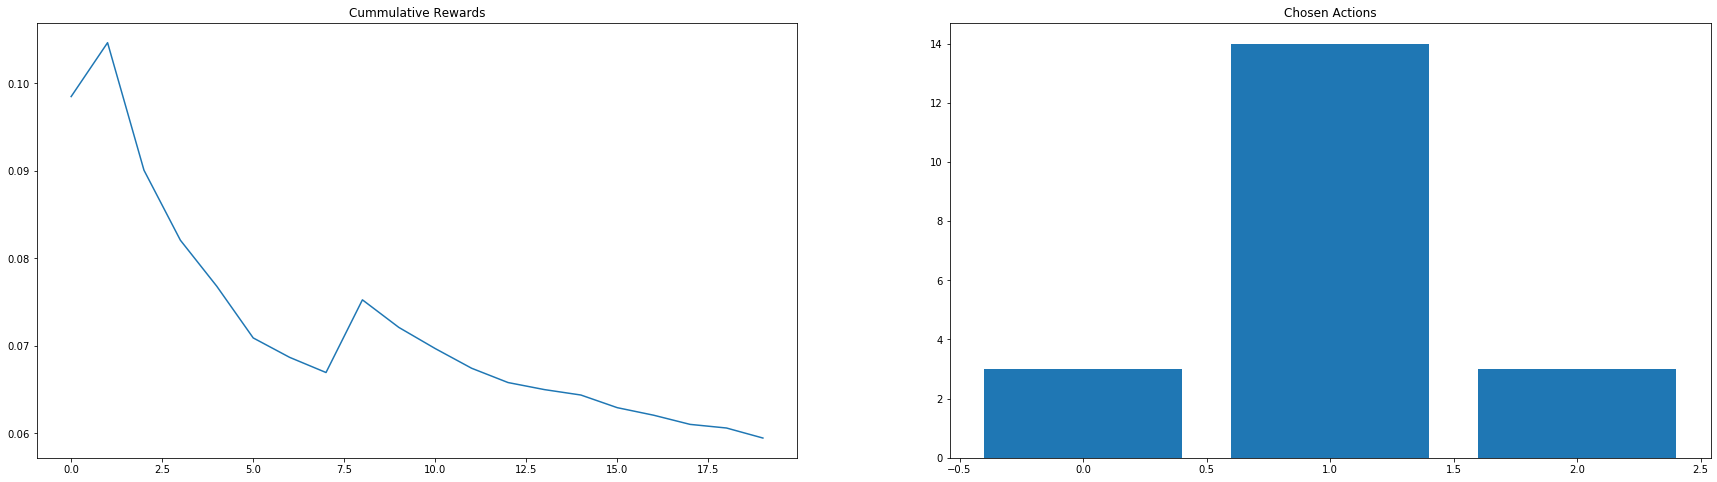

Restart at iteration: 1730
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.055274400001508184, 'merge_sort': 0.03908022500036168, 'heap_sort': 0.10598114999447716}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 12, 'heap_sort': 2}


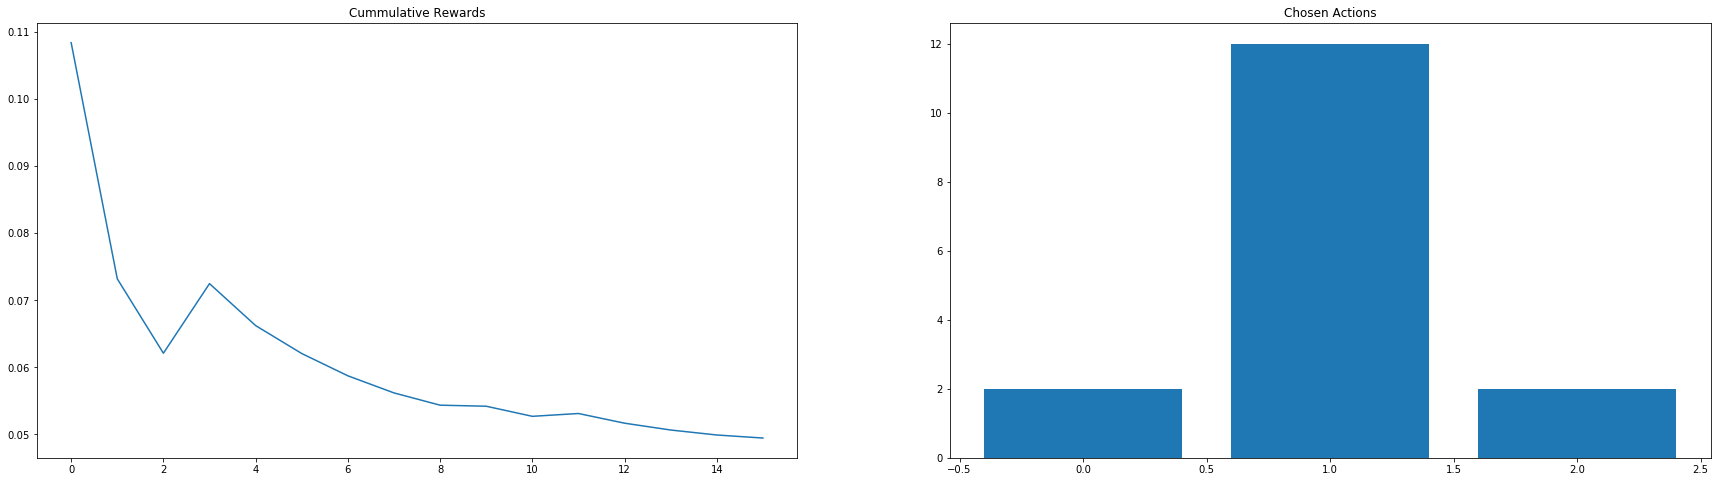

Restart at iteration: 1750
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05306232499788166, 'merge_sort': 0.03848078571484491, 'heap_sort': 0.1060504499982926}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 14, 'heap_sort': 2}


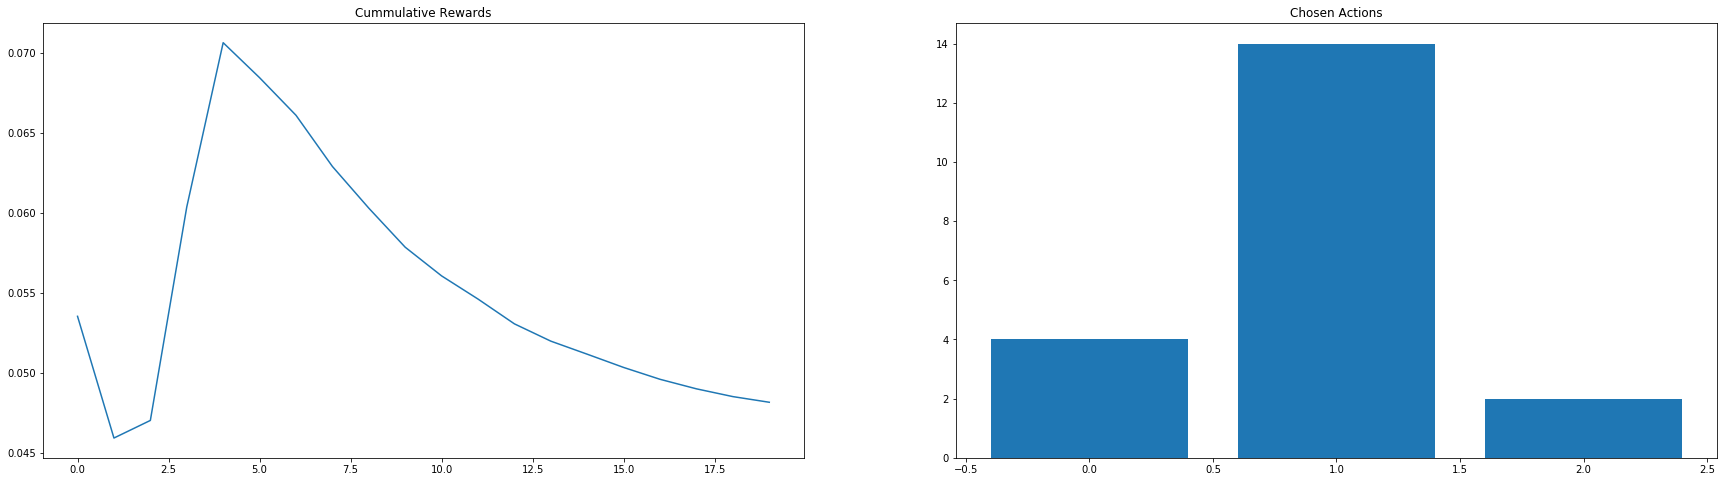

Restart at iteration: 1769
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.056423733335880875, 'merge_sort': 0.038432578568712676, 'heap_sort': 0.09819324999989476}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 14, 'heap_sort': 2}


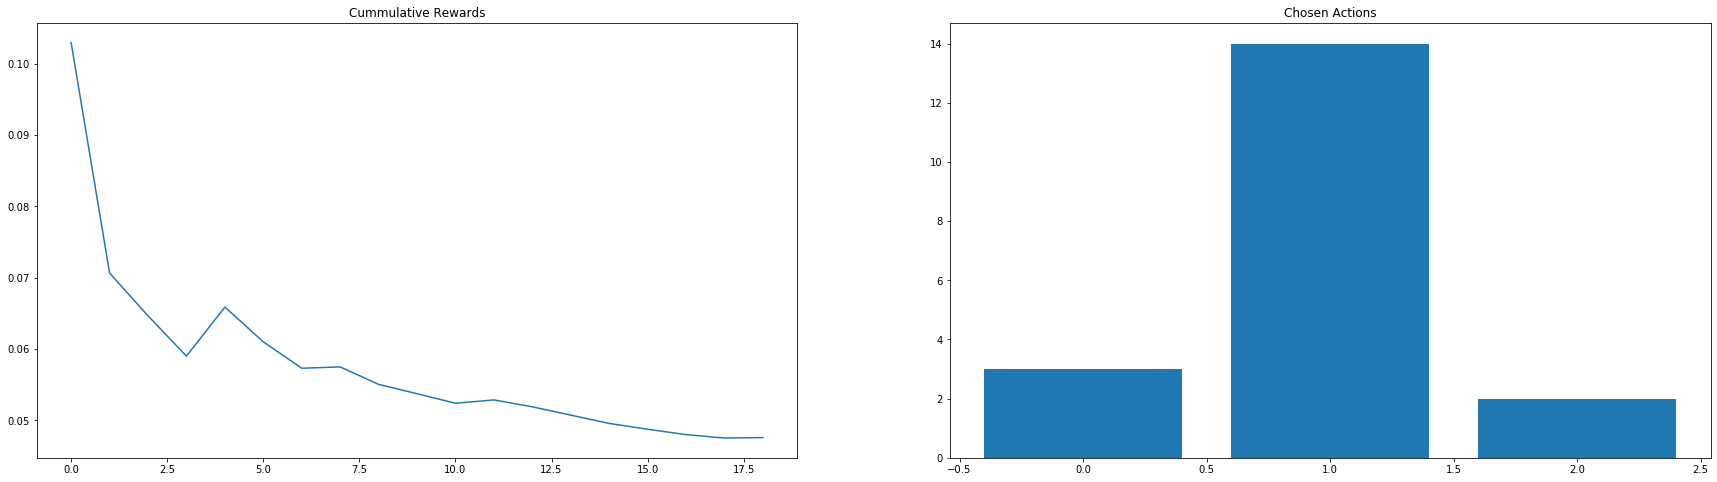

Restart at iteration: 1814
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.06376020000243443, 'merge_sort': 0.044497599999886006, 'heap_sort': 0.13431596666729698}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 38, 'heap_sort': 3}


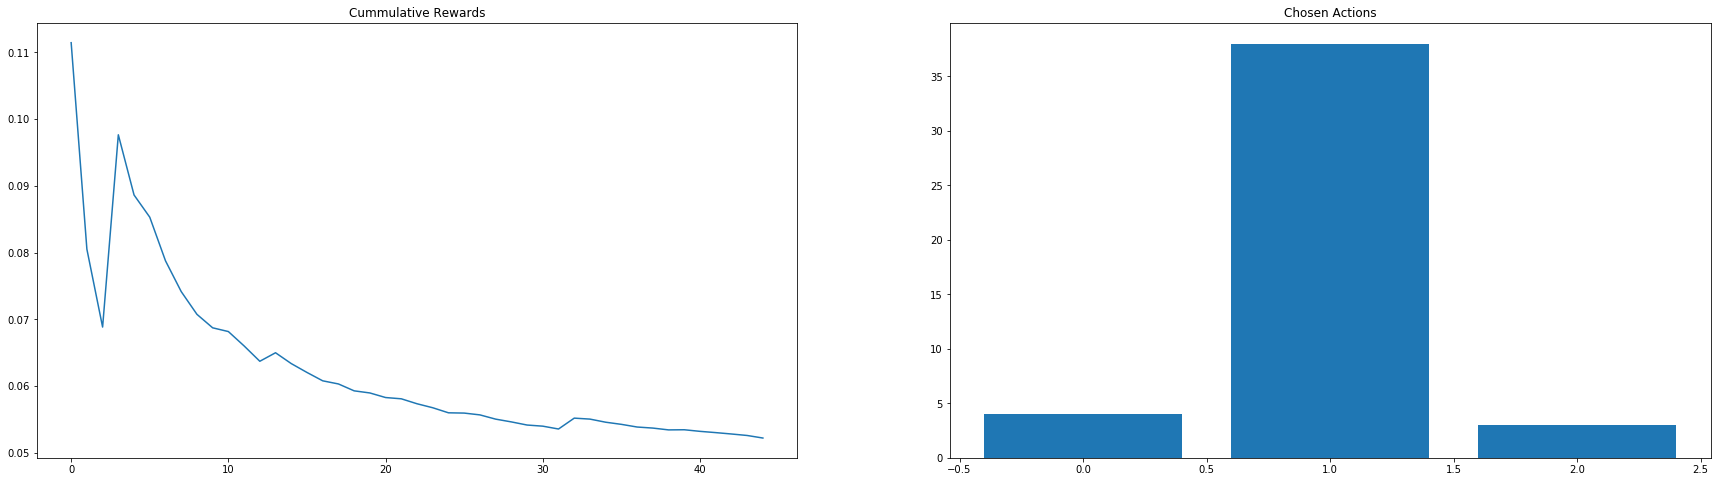

Restart at iteration: 1830
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.047902600000573635, 'merge_sort': 0.03532122727615801, 'heap_sort': 0.08363069999904837}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 11, 'heap_sort': 2}


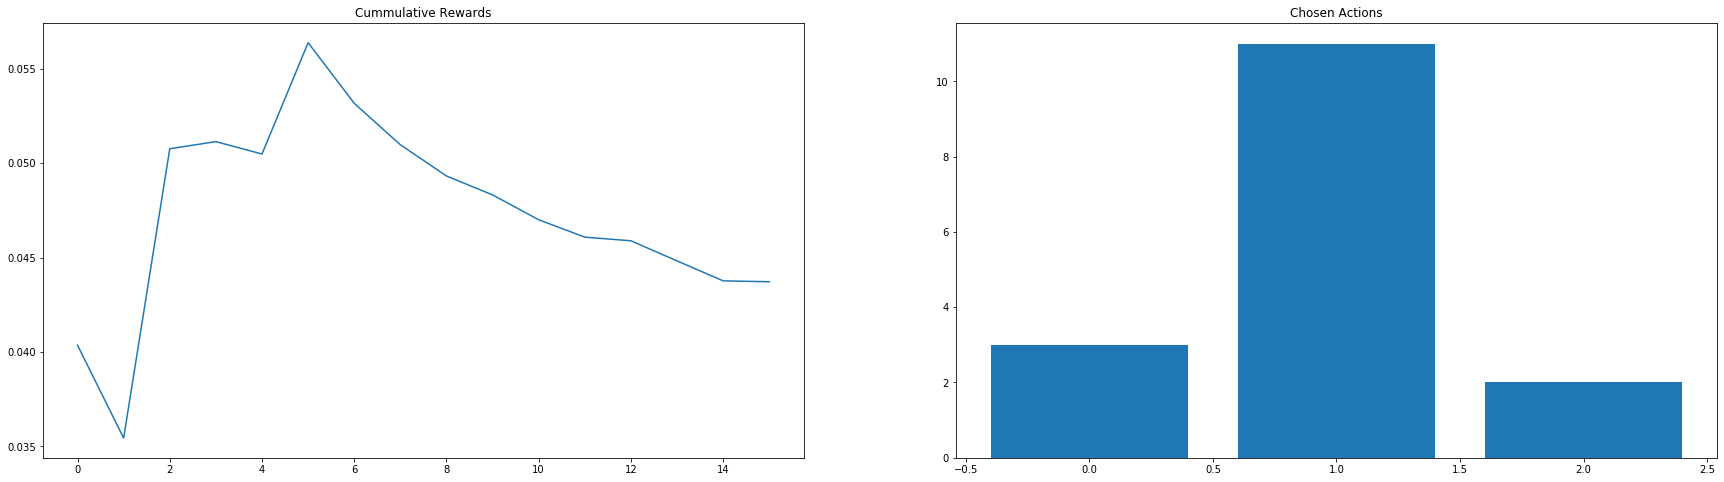

Restart at iteration: 1855
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04603176666326666, 'merge_sort': 0.03474047999916365, 'heap_sort': 0.08882610000000568}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 20, 'heap_sort': 2}


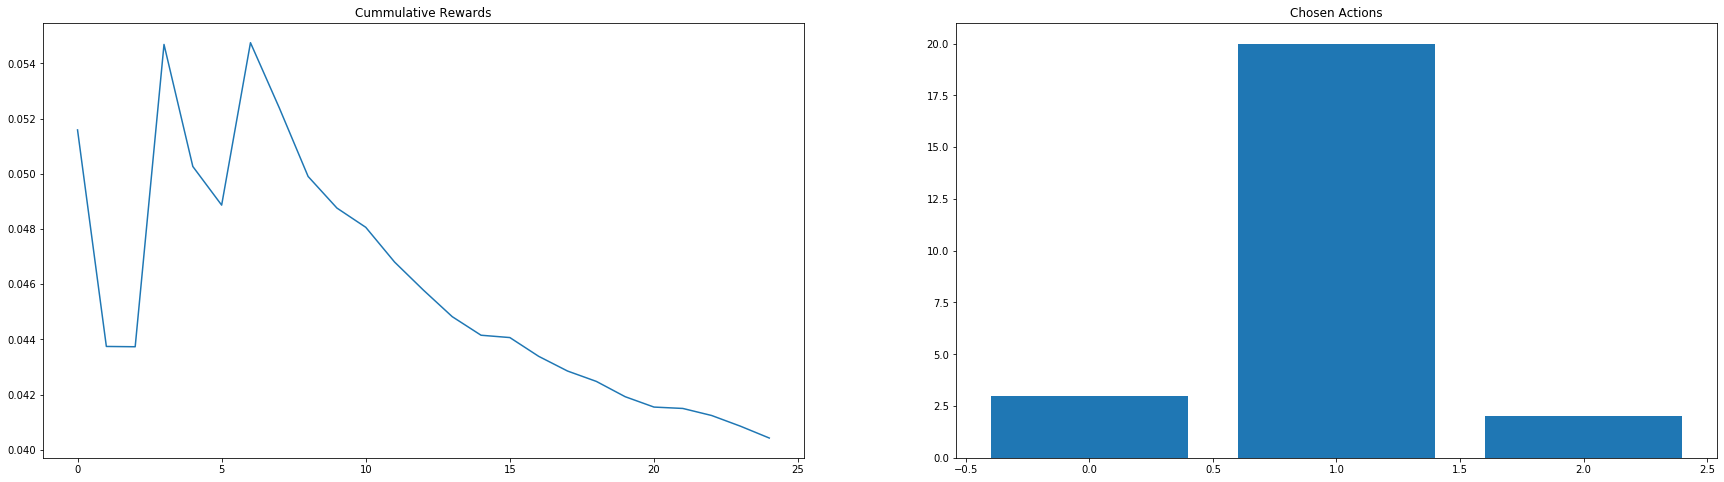

Restart at iteration: 1872
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04639750000205822, 'merge_sort': 0.04245005454603498, 'heap_sort': 0.09784259999772378}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 11, 'heap_sort': 3}


Restart at iteration: 1900
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.06007845000567613, 'merge_sort': 0.037898591664998094, 'heap_sort': 0.10761235000973102}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 24, 'heap_sort': 2}


Restart at iteration: 1919
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.048197200005233753, 'merge_sort': 0.03277829333092086, 'heap_sort': 0.08502120000048308}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 15, 'heap_sort': 2}


Restart at iteration: 1936
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04727482499947655, 'merge_sort': 0.033061100002007814, 'heap_sort': 0.08894684999540914}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 11, 'heap_sort': 2}


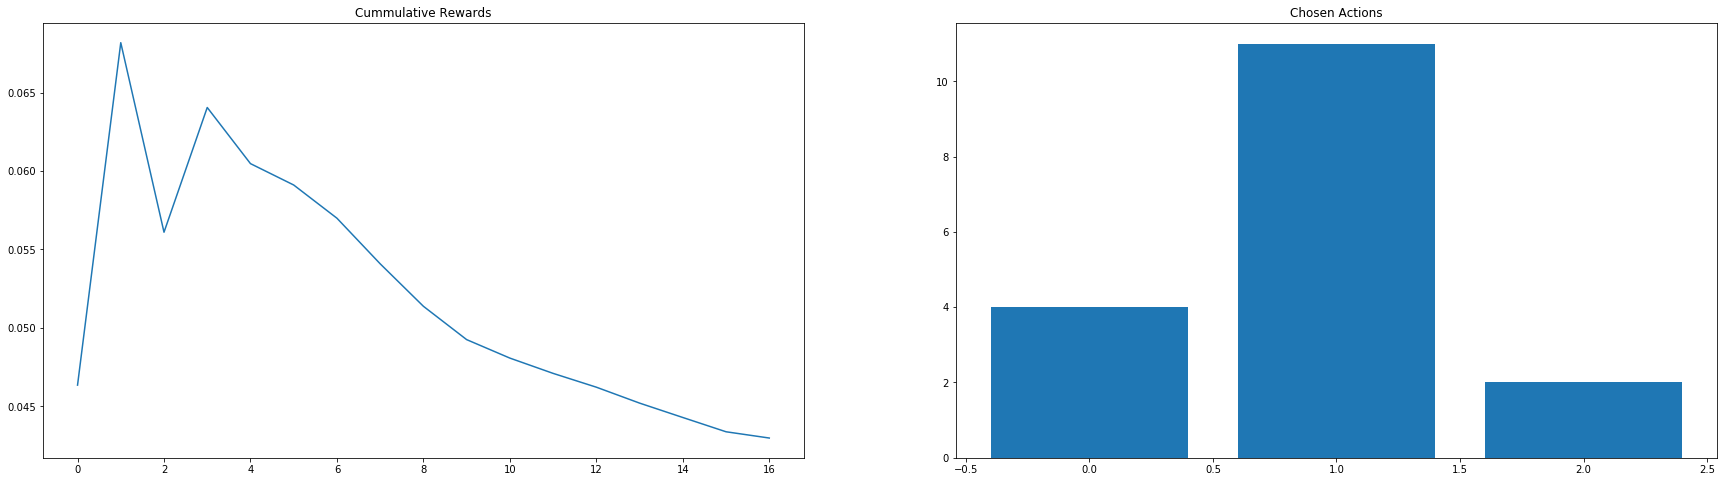

Restart at iteration: 1953
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04496189999917988, 'merge_sort': 0.03233284615495135, 'heap_sort': 0.08934099999896716}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 13, 'heap_sort': 2}


Restart at iteration: 1976
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04241074999663397, 'merge_sort': 0.032908911763704106, 'heap_sort': 0.08226955000282032}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 17, 'heap_sort': 2}


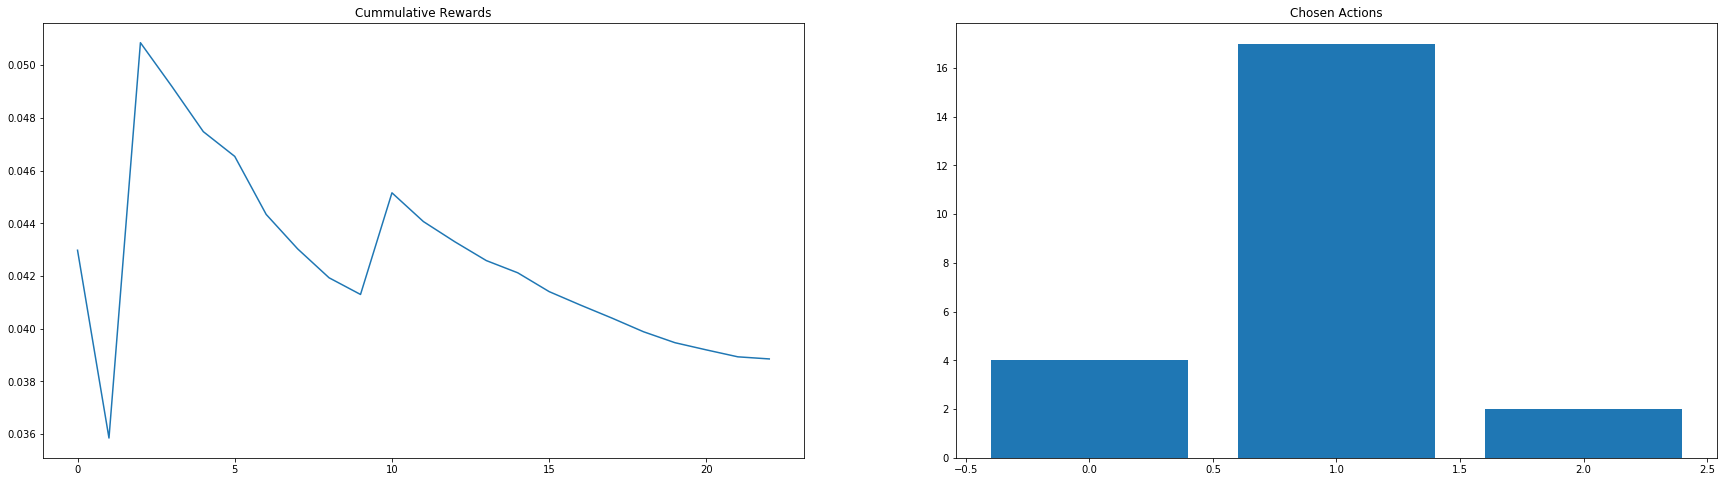

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04410444999666652, 'merge_sort': 0.032631936843053586, 'heap_sort': 0.0845746000049985}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 19, 'heap_sort': 2}


Total reward 234.0498


In [31]:
for elem in list_iteration_results_1:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_1,4))

## Two outliers in a row restart the expriment

In [32]:
list_iteration_results_2, total_reward_2, arm_rewards_2 = ts_quantile(list_distributions, n_samples, num_consec_elem=2)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.02520159015882203
Less than two values for merge_sort
merge_sort Theta 0.030036773024469367
Less than two values for heap_sort
heap_sort Theta 0.041752087610305036


Chosen algorithm is:  quick_sort with reward: 0.09676450000551995
Sample mean is:  0.09676450000551995 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.06641128392359776
Less than two values for merge_sort
merge_sort Theta 0.051804538303811244
Less than two values for heap_sort
heap_sort Theta 0.03716469127452931


Chosen algorithm is:  heap_sort with reward: 0.2250863999943249
Sample mean is:  0.2250863999943249 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.09878867775679467
Less than two values for merge_sort
merge_sort Theta 0.050038889839926104
Less than two values for heap_sort
heap_sort Theta 0.003094159345162484


Chosen algorithm is:  heap_sort with rewar

heap_sort Theta 0.22219396521227922


Chosen algorithm is:  quick_sort with reward: 0.09590299999399576
Sample mean is:  0.09788552499958314 Sample variance is: 1.7262778770253593e-06


Iteration: 28
quick_sort Theta 0.09797607012250097
merge_sort Theta 0.10546105219674193
heap_sort Theta 0.21986793218961106


Chosen algorithm is:  quick_sort with reward: 0.09637600000132807
Sample mean is:  0.09771779999977702 Sample variance is: 1.7595226285022433e-06


Iteration: 29
quick_sort Theta 0.09779520914426412
merge_sort Theta 0.11976804226388967
heap_sort Theta 0.2190306587891493


Chosen algorithm is:  quick_sort with reward: 0.09469220000028145
Sample mean is:  0.09741523999982746 Sample variance is: 2.4074533477773053e-06


Iteration: 30
quick_sort Theta 0.09791713348008417
merge_sort Theta 0.10646372611961592
heap_sort Theta 0.22047418803245836


Chosen algorithm is:  quick_sort with reward: 0.09848719999718014
Sample mean is:  0.0975126909086777 Sample variance is: 2.283560748882208e-


Chosen algorithm is:  quick_sort with reward: 0.13158830000611488
Sample mean is:  0.11151309999903398 Sample variance is: 0.00013975239530512515


Iteration: 57
quick_sort Theta 0.10665698412236341
merge_sort Theta 0.11477463709867493
heap_sort Theta 0.2783550896035028


Chosen algorithm is:  quick_sort with reward: 0.10072390000277665
Sample mean is:  0.11016444999950181 Sample variance is: 0.00013501534364065127


Iteration: 58
quick_sort Theta 0.11126036409318873
merge_sort Theta 0.11510352757445666
heap_sort Theta 0.2590306635144614


Chosen algorithm is:  quick_sort with reward: 0.10520190000534058
Sample mean is:  0.10961305555570612 Sample variance is: 0.00012244592545288013


Iteration: 59
quick_sort Theta 0.1082779892383487
merge_sort Theta 0.1244807146883243
heap_sort Theta 0.26672608670403836


Chosen algorithm is:  quick_sort with reward: 0.10373489999619778
Sample mean is:  0.10902523999975529 Sample variance is: 0.0001133110770579522


Iteration: 60
quick_sort Theta 0.1

quick_sort Theta 0.10796092621478746
merge_sort Theta 0.12866763310667584
heap_sort Theta 0.27809813821355994


Chosen algorithm is:  quick_sort with reward: 0.09690489999775309
Sample mean is:  0.11052999444574299 Sample variance is: 0.00011377282686166431


Iteration: 88
quick_sort Theta 0.10598116814843044
merge_sort Theta 0.13083841711446884
heap_sort Theta 0.2660615982694393


Chosen algorithm is:  quick_sort with reward: 0.10098859999561682
Sample mean is:  0.1102721189200639 Sample variance is: 0.0001130918779179264


Iteration: 89
quick_sort Theta 0.11160651043625437
merge_sort Theta 0.133620988581499
heap_sort Theta 0.28205530696124775


Chosen algorithm is:  quick_sort with reward: 0.1308779999963008
Sample mean is:  0.11081437894838593 Sample variance is: 0.00012099547558513932


Iteration: 90
quick_sort Theta 0.11285866764926794
merge_sort Theta 0.1303435542479188
heap_sort Theta 0.2722681153008647


Chosen algorithm is:  quick_sort with reward: 0.10176309999951627
Sample m



Chosen algorithm is:  quick_sort with reward: 0.09741899999789894
Sample mean is:  0.10294076666468754 Sample variance is: 9.29846137730305e-05


Iteration: 117
quick_sort Theta 0.10358556889290982
merge_sort Theta 0.10942068451999963
heap_sort Theta 0.21958779368630874


Chosen algorithm is:  quick_sort with reward: 0.09882340001058765
Sample mean is:  0.10235257142838756 Sample variance is: 8.177693933577642e-05


Iteration: 118
quick_sort Theta 0.10469894550927347
merge_sort Theta 0.10920235033104526
heap_sort Theta 0.22100330560808548


Chosen algorithm is:  quick_sort with reward: 0.09928260000015143
Sample mean is:  0.10196882499985804 Sample variance is: 7.258565116866848e-05


Iteration: 119
quick_sort Theta 0.10685277101304758
merge_sort Theta 0.1112655439062126
heap_sort Theta 0.2199976071291835


Chosen algorithm is:  quick_sort with reward: 0.10004800000751857
Sample mean is:  0.1017554000007092 Sample variance is: 6.488498065868763e-05


Iteration: 120
quick_sort Theta 0



Iteration: 146
quick_sort Theta 0.11104449814844268
merge_sort Theta 0.12097514548375876
heap_sort Theta 0.3001376644771701


Chosen algorithm is:  quick_sort with reward: 0.1197217000008095
Sample mean is:  0.12185992000158877 Sample variance is: 0.0001515119057675979


Iteration: 147
quick_sort Theta 0.1204546706986978
merge_sort Theta 0.12149521796918203
heap_sort Theta 0.2962475572553589


Chosen algorithm is:  quick_sort with reward: 0.11909030000970233
Sample mean is:  0.1213983166696077 Sample variance is: 0.00012732530965347836


Iteration: 148
quick_sort Theta 0.12312942282907972
merge_sort Theta 0.12401267767751097
heap_sort Theta 0.28418715300632913


Chosen algorithm is:  quick_sort with reward: 0.11843790000420995
Sample mean is:  0.1209754000031223 Sample variance is: 0.00011020913074372813


Iteration: 149
quick_sort Theta 0.12501940603741718
merge_sort Theta 0.1219961297147387
heap_sort Theta 0.33036240899059727


Chosen algorithm is:  merge_sort with reward: 0.125804



Chosen algorithm is:  quick_sort with reward: 0.09731860000465531
Sample mean is:  0.09988362000149209 Sample variance is: 7.750493433248405e-06


Iteration: 175
quick_sort Theta 0.09985790252981236
merge_sort Theta 0.10487197043853073
heap_sort Theta 0.23589776128542703


Chosen algorithm is:  quick_sort with reward: 0.09763390000443906
Sample mean is:  0.09967910000176 Sample variance is: 7.464187424039071e-06


Iteration: 176
quick_sort Theta 0.09999163481815651
merge_sort Theta 0.10540003048531395
heap_sort Theta 0.23127572604898006


Chosen algorithm is:  quick_sort with reward: 0.09746669999731239
Sample mean is:  0.0994947333347227 Sample variance is: 7.21607355242802e-06


Iteration: 177
quick_sort Theta 0.10032224060585074
merge_sort Theta 0.10552107108776629
heap_sort Theta 0.2320804312446902


Chosen algorithm is:  quick_sort with reward: 0.16370150000147987
Sample mean is:  0.1044337153860117 Sample variance is: 0.0002993835154069324


Iteration: 178
quick_sort Theta 0.10



Iteration: 205
quick_sort Theta 0.10186786110144223
merge_sort Theta 0.15294128040581434
heap_sort Theta 0.23238048758252783


Chosen algorithm is:  quick_sort with reward: 0.09991589999117423
Sample mean is:  0.10114042702794855 Sample variance is: 0.00013457197703527983


Iteration: 206
quick_sort Theta 0.10393644839815479
merge_sort Theta 0.12738102124854786
heap_sort Theta 0.23267166915194998


Chosen algorithm is:  quick_sort with reward: 0.09865020000142977
Sample mean is:  0.101074894737777 Sample variance is: 0.00013118950501760167


Iteration: 207
quick_sort Theta 0.10105172244173624
merge_sort Theta 0.11217465485144287
heap_sort Theta 0.2256750509866164


Chosen algorithm is:  quick_sort with reward: 0.09821430000010878
Sample mean is:  0.10100154615475987 Sample variance is: 0.0001280301121115755


Iteration: 208
quick_sort Theta 0.1059336282196934
merge_sort Theta 0.08984845501932018
heap_sort Theta 0.2295518873792502


Chosen algorithm is:  merge_sort with reward: 0.1101



Chosen algorithm is:  quick_sort with reward: 0.0989897999970708
Sample mean is:  0.10397246250067838 Sample variance is: 0.000150992732050465


Iteration: 236
quick_sort Theta 0.10234745367072458
merge_sort Theta 0.12758405244359114
heap_sort Theta 0.23064547718686954


Chosen algorithm is:  quick_sort with reward: 0.12908759999845643
Sample mean is:  0.10435884923141342 Sample variance is: 0.00015822462810603582


Iteration: 237
quick_sort Theta 0.10519618078282882
merge_sort Theta 0.12069437367256158
heap_sort Theta 0.22976532946021935


Chosen algorithm is:  quick_sort with reward: 0.11887429999478627
Sample mean is:  0.10457878030358574 Sample variance is: 0.00015897131422889057


Iteration: 238
quick_sort Theta 0.10550210331066823
merge_sort Theta 0.11255173547993556
heap_sort Theta 0.2312613977332299


Chosen algorithm is:  quick_sort with reward: 0.11597759999858681
Sample mean is:  0.10474891194082456 Sample variance is: 0.0001585089631296809


Iteration: 239
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.0997742999898037
Sample mean is:  0.10550424395654233 Sample variance is: 0.00015270879730502353


Iteration: 266
quick_sort Theta 0.1032259603337538
merge_sort Theta 0.1183305369448253
heap_sort Theta 0.23483517975962934


Chosen algorithm is:  quick_sort with reward: 0.09695200000714976
Sample mean is:  0.10541128478317936 Sample variance is: 0.0001518352871934688


Iteration: 267
quick_sort Theta 0.1047699968161716
merge_sort Theta 0.12421617480555144
heap_sort Theta 0.23284527222022736


Chosen algorithm is:  quick_sort with reward: 0.0992880999983754
Sample mean is:  0.10534544408656857 Sample variance is: 0.00015060146945114277


Iteration: 268
quick_sort Theta 0.10499024898638548
merge_sort Theta 0.11037056955270472
heap_sort Theta 0.230617672952374


Chosen algorithm is:  quick_sort with reward: 0.10122080000292044
Sample mean is:  0.10530156489418933 Sample variance is: 0.00014917838682682776


Iteration: 269
quick_sort Theta 0



Iteration: 296
quick_sort Theta 0.10767403222156319
merge_sort Theta 0.12189165290353297
heap_sort Theta 0.22954366301919604


Chosen algorithm is:  quick_sort with reward: 0.11158820000127889
Sample mean is:  0.1064391647544012 Sample variance is: 0.0001464591265907318


Iteration: 297
quick_sort Theta 0.10690978411816766
merge_sort Theta 0.11940409052245113
heap_sort Theta 0.23323711353642138


Chosen algorithm is:  quick_sort with reward: 0.09853109999676235
Sample mean is:  0.1063748715449895 Sample variance is: 0.00014577270323103074


Iteration: 298
quick_sort Theta 0.10542630047925901
merge_sort Theta 0.12293857597551618
heap_sort Theta 0.22954993531331724


Chosen algorithm is:  quick_sort with reward: 0.09936639999796171
Sample mean is:  0.10631835161315863 Sample variance is: 0.00014499004074603397


Iteration: 299
quick_sort Theta 0.10428338609449936
merge_sort Theta 0.11886933999420635
heap_sort Theta 0.23274284987690202


Chosen algorithm is:  quick_sort with reward: 0.1



Iteration: 326
quick_sort Theta 0.1074062699508674
merge_sort Theta 0.10877548256033936
heap_sort Theta 0.22946987042579298


Chosen algorithm is:  quick_sort with reward: 0.11844539998855907
Sample mean is:  0.10774207105274208 Sample variance is: 0.00014420692845573799


Iteration: 327
quick_sort Theta 0.10850741005974454
merge_sort Theta 0.12185439735586354
heap_sort Theta 0.23120981546944977


Chosen algorithm is:  quick_sort with reward: 0.10801589999755379
Sample mean is:  0.10774386078440752 Sample variance is: 0.00014326488638877685


Iteration: 328
quick_sort Theta 0.10610426118813937
merge_sort Theta 0.10276840652009978
heap_sort Theta 0.23351524822552233


Chosen algorithm is:  merge_sort with reward: 0.10593230000813492
Sample mean is:  0.11700445833533497 Sample variance is: 0.00043689986402685476


Iteration: 329
quick_sort Theta 0.10859605897058075
merge_sort Theta 0.10602574806737372
heap_sort Theta 0.23040708870505863


Chosen algorithm is:  merge_sort with reward: 0



Iteration: 356
quick_sort Theta 0.10758544084333656
merge_sort Theta 0.1086893179258943
heap_sort Theta 0.23129983289086034


Chosen algorithm is:  quick_sort with reward: 0.10184459999436513
Sample mean is:  0.10725428212294875 Sample variance is: 0.00013447882500185803


Iteration: 357
quick_sort Theta 0.10713309384708966
merge_sort Theta 0.11602014341217651
heap_sort Theta 0.23083470932346078


Chosen algorithm is:  quick_sort with reward: 0.1001251000125194
Sample mean is:  0.10721467555566859 Sample variance is: 0.0001340125141692519


Iteration: 358
quick_sort Theta 0.10728476028181134
merge_sort Theta 0.11114504039267448
heap_sort Theta 0.22867022316134655


Chosen algorithm is:  quick_sort with reward: 0.09928350000700448
Sample mean is:  0.10717085690622846 Sample variance is: 0.00013361772686545887


Iteration: 359
quick_sort Theta 0.10657616624625549
merge_sort Theta 0.11352629454532534
heap_sort Theta 0.23098679237133418


Chosen algorithm is:  quick_sort with reward: 0.1



Chosen algorithm is:  quick_sort with reward: 0.13046960000065155
Sample mean is:  0.1073317158653271 Sample variance is: 0.0001335677995471519
RESTART EXPERIMENT


Iteration: 387
Less than two values for quick_sort
quick_sort Theta 0.010692928133430224
Less than two values for merge_sort
merge_sort Theta 0.021558009555363713
Less than two values for heap_sort
heap_sort Theta 0.04981343082313491


Chosen algorithm is:  quick_sort with reward: 0.12062420000438578
Sample mean is:  0.12062420000438578 Sample variance is: 0.0


Iteration: 388
Less than two values for quick_sort
quick_sort Theta 0.08467977875723953
Less than two values for merge_sort
merge_sort Theta 0.06975368801596896
Less than two values for heap_sort
heap_sort Theta 0.006776025977169298


Chosen algorithm is:  heap_sort with reward: 0.2758270000049379
Sample mean is:  0.2758270000049379 Sample variance is: 0.0


Iteration: 389
Less than two values for quick_sort
quick_sort Theta 0.04137165393129327
Less than two value



Iteration: 416
quick_sort Theta 0.12001807195166232
merge_sort Theta 0.11316864541396163
heap_sort Theta 0.25765026752046405


Chosen algorithm is:  merge_sort with reward: 0.1096696000022348
Sample mean is:  0.1151648500005346 Sample variance is: 0.00011337857429419317


Iteration: 417
quick_sort Theta 0.11062555730887107
merge_sort Theta 0.11671698976496468
heap_sort Theta 0.29260722575093984


Chosen algorithm is:  quick_sort with reward: 0.09792980000202078
Sample mean is:  0.11191147500176157 Sample variance is: 0.00017239974854273585


Iteration: 418
quick_sort Theta 0.10803112862022878
merge_sort Theta 0.11384734347689633
heap_sort Theta 0.24099334437332937


Chosen algorithm is:  quick_sort with reward: 0.09486580001248512
Sample mean is:  0.11090878823768649 Sample variance is: 0.00017834467881337325


Iteration: 419
quick_sort Theta 0.11610643772531021
merge_sort Theta 0.11537434409514374
heap_sort Theta 0.2528826681404791


Chosen algorithm is:  merge_sort with reward: 0.1



Chosen algorithm is:  quick_sort with reward: 0.10051540000131354
Sample mean is:  0.10916446000192082 Sample variance is: 0.0001517617692501221


Iteration: 447
quick_sort Theta 0.10548205424079385
merge_sort Theta 0.1166131326406925
heap_sort Theta 0.25641916988593605


Chosen algorithm is:  quick_sort with reward: 0.09699489999911748
Sample mean is:  0.10886764146526708 Sample variance is: 0.0001515843124310966


Iteration: 448
quick_sort Theta 0.10916529774758406
merge_sort Theta 0.11484650795430904
heap_sort Theta 0.24893516196597018


Chosen algorithm is:  quick_sort with reward: 0.10031780001008883
Sample mean is:  0.10866407381157235 Sample variance is: 0.00014967419350997985


Iteration: 449
quick_sort Theta 0.11118955540133492
merge_sort Theta 0.1141197965016127
heap_sort Theta -0.11649170174157727


Chosen algorithm is:  heap_sort with reward: 0.24500090000219643
Sample mean is:  0.245574000000488 Sample variance is: 0.0003552458965651269


Iteration: 450
quick_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.10844350000843406
Sample mean is:  0.1080611811607462 Sample variance is: 0.00013262118145620125


Iteration: 477
quick_sort Theta 0.10702612793015424
merge_sort Theta 0.10996868721558939
heap_sort Theta 0.24884200687526717


Chosen algorithm is:  quick_sort with reward: 0.10399020000477321
Sample mean is:  0.10800302428708944 Sample variance is: 0.00013095996646447758


Iteration: 478
quick_sort Theta 0.10823773956794665
merge_sort Theta 0.11421863008329579
heap_sort Theta 0.2594439973997713


Chosen algorithm is:  quick_sort with reward: 0.11109519998717587
Sample mean is:  0.1080465760575132 Sample variance is: 0.00012924823286404838


Iteration: 479
quick_sort Theta 0.10675115652977508
merge_sort Theta 0.11284849724413502
heap_sort Theta 0.238644932133099


Chosen algorithm is:  quick_sort with reward: 0.12821740000799764
Sample mean is:  0.1083267263901588 Sample variance is: 0.00013302549734929732


Iteration: 480
quick_sort Theta



Chosen algorithm is:  heap_sort with reward: 0.07417680000071414
Sample mean is:  0.07143004999670666 Sample variance is: 7.544635584515097e-06


Iteration: 507
quick_sort Theta 0.035208120440970526
Less than two values for merge_sort
merge_sort Theta 0.08546458020169821
heap_sort Theta 0.07168709555628786


Chosen algorithm is:  quick_sort with reward: 0.035673200007295236
Sample mean is:  0.03539467499649618 Sample variance is: 6.072110867986653e-07


Iteration: 508
quick_sort Theta 0.03570636542402876
Less than two values for merge_sort
merge_sort Theta 0.008199557264063984
heap_sort Theta 0.0679924426162486


Chosen algorithm is:  merge_sort with reward: 0.031183400002191775
Sample mean is:  0.031183400002191775 Sample variance is: 0.0


Iteration: 509
quick_sort Theta 0.0360692987944725
Less than two values for merge_sort
merge_sort Theta 0.01861710325372227
heap_sort Theta 0.07399428652899308


Chosen algorithm is:  merge_sort with reward: 0.027815299996291287
Sample mean is:  



Iteration: 536
quick_sort Theta 0.03509380354596669
merge_sort Theta 0.031542268565573815
heap_sort Theta 0.06981949038379717


Chosen algorithm is:  merge_sort with reward: 0.02892299999075476
Sample mean is:  0.031084120689072358 Sample variance is: 7.3166853632951945e-06


Iteration: 537
quick_sort Theta 0.03571948715273709
merge_sort Theta 0.03189889233518578
heap_sort Theta 0.07242285280997642


Chosen algorithm is:  merge_sort with reward: 0.048209200002020225
Sample mean is:  0.03165495666617062 Sample variance is: 1.6522553520927456e-05


Iteration: 538
quick_sort Theta 0.035502411169822876
merge_sort Theta 0.03177922520053588
heap_sort Theta 0.043879459370470345


Chosen algorithm is:  merge_sort with reward: 0.027453800008515827
Sample mean is:  0.03151943548366563 Sample variance is: 1.6540547650704737e-05


Iteration: 539
quick_sort Theta 0.03546902329244501
merge_sort Theta 0.03139776441008665
heap_sort Theta 0.07007812706264184


Chosen algorithm is:  merge_sort with re



Iteration: 566
Less than two values for quick_sort
quick_sort Theta 0.03813338595406773
Less than two values for merge_sort
merge_sort Theta 0.03499237451215106
heap_sort Theta 0.11567150370653148


Chosen algorithm is:  merge_sort with reward: 0.029737299992120825
Sample mean is:  0.02925390000018524 Sample variance is: 2.3367555220332335e-07


Iteration: 567
Less than two values for quick_sort
quick_sort Theta 0.028549443672158004
merge_sort Theta 0.029144380617249405
heap_sort Theta 0.0926444008751974


Chosen algorithm is:  quick_sort with reward: 0.03804269999091048
Sample mean is:  0.038387549997423775 Sample variance is: 1.1892152699222137e-07


Iteration: 568
quick_sort Theta 0.04997032394342803
merge_sort Theta 0.02972156712409792
heap_sort Theta 0.2935067505584559


Chosen algorithm is:  merge_sort with reward: 0.03700639998714905
Sample mean is:  0.03183806666250651 Sample variance is: 1.3511618378774196e-05


Iteration: 569
quick_sort Theta 0.039342770753104626
merge_sort



Iteration: 596
quick_sort Theta 0.03798612429326093
merge_sort Theta 0.029288716892043456
heap_sort Theta 0.08333757194011916


Chosen algorithm is:  merge_sort with reward: 0.03421110000635963
Sample mean is:  0.03039195999832979 Sample variance is: 1.0659577501141106e-05


Iteration: 597
quick_sort Theta 0.03833266955439146
merge_sort Theta 0.03042647199457528
heap_sort Theta 0.08541696927898526


Chosen algorithm is:  merge_sort with reward: 0.03521760000148788
Sample mean is:  0.030547625804883276 Sample variance is: 1.1042675462293047e-05


Iteration: 598
quick_sort Theta 0.03810120378235413
merge_sort Theta 0.030952262059716035
heap_sort Theta 0.055075342933511795


Chosen algorithm is:  merge_sort with reward: 0.028428699995856732
Sample mean is:  0.030481409373351198 Sample variance is: 1.083351494404651e-05


Iteration: 599
quick_sort Theta 0.03840368929418733
merge_sort Theta 0.030445035050639217
heap_sort Theta 0.057917758907839664


Chosen algorithm is:  merge_sort with r



Iteration: 626
quick_sort Theta 0.038557146815302173
merge_sort Theta 0.029736962029851818
heap_sort Theta 0.043427138254938796


Chosen algorithm is:  merge_sort with reward: 0.03310480000800453
Sample mean is:  0.02986118166494028 Sample variance is: 1.0313551166292381e-05


Iteration: 627
quick_sort Theta 0.038279869612648475
merge_sort Theta 0.029861829771020754
heap_sort Theta 0.07519887927405143


Chosen algorithm is:  merge_sort with reward: 0.02713170000060927
Sample mean is:  0.029816436063885673 Sample variance is: 1.0264606685833183e-05


Iteration: 628
quick_sort Theta 0.03832867243442706
merge_sort Theta 0.029419008204650366
heap_sort Theta 0.07667893174736921


Chosen algorithm is:  merge_sort with reward: 0.027332799989380874
Sample mean is:  0.029776377417522693 Sample variance is: 1.0196934917535525e-05


Iteration: 629
quick_sort Theta 0.0387635111043296
merge_sort Theta 0.029715664120565873
heap_sort Theta 0.08150468391869056


Chosen algorithm is:  merge_sort with



Iteration: 657
quick_sort Theta 0.03638039877012607
merge_sort Theta 0.029159938073495633
heap_sort Theta 0.07364083308916627


Chosen algorithm is:  merge_sort with reward: 0.02670689999649767
Sample mean is:  0.02936060444351622 Sample variance is: 1.1019636605940923e-05


Iteration: 658
quick_sort Theta 0.027502553145075867
merge_sort Theta 0.029120173937878725
heap_sort Theta 0.08111940535078843


Chosen algorithm is:  quick_sort with reward: 0.03338439999788534
Sample mean is:  0.03594889999658335 Sample variance is: 6.014393701075495e-06


Iteration: 659
quick_sort Theta 0.04180492641417617
merge_sort Theta 0.02961091940275556
heap_sort Theta 0.0804368460847644


Chosen algorithm is:  merge_sort with reward: 0.03150949999690056
Sample mean is:  0.029384218680366597 Sample variance is: 1.0948728594565647e-05


Iteration: 660
quick_sort Theta 0.03552269839921933
merge_sort Theta 0.02983680413760319
heap_sort Theta 0.08648948404876382


Chosen algorithm is:  merge_sort with reward



Iteration: 687
quick_sort Theta 0.03506045301254137
merge_sort Theta 0.029229608452523894
heap_sort Theta 0.08611844224930015


Chosen algorithm is:  merge_sort with reward: 0.026971200000843965
Sample mean is:  0.029167184033289262 Sample variance is: 9.758120866633878e-06


Iteration: 688
quick_sort Theta 0.035493186761371524
merge_sort Theta 0.029312460884759382
heap_sort Theta 0.08082384692743579


Chosen algorithm is:  merge_sort with reward: 0.02766669999982696
Sample mean is:  0.029154679999677077 Sample variance is: 9.695408944677646e-06


Iteration: 689
quick_sort Theta 0.03746034437136432
merge_sort Theta 0.028978531007933774
heap_sort Theta 0.05377402099360681


Chosen algorithm is:  merge_sort with reward: 0.02758880000328645
Sample mean is:  0.029141738842682112 Sample variance is: 9.635378423351615e-06


Iteration: 690
quick_sort Theta 0.03841085872096491
merge_sort Theta 0.029068843059745865
heap_sort Theta 0.06886792043597226


Chosen algorithm is:  merge_sort with re



Iteration: 717
quick_sort Theta 0.034938283076575524
merge_sort Theta 0.029290756038678773
heap_sort Theta 0.4757526515659259


Chosen algorithm is:  merge_sort with reward: 0.032625799998641014
Sample mean is:  0.029249607382327375 Sample variance is: 9.2366944208052e-06


Iteration: 718
quick_sort Theta 0.0358239408722792
merge_sort Theta 0.02926162377820631
heap_sort Theta 0.07693955143259044


Chosen algorithm is:  merge_sort with reward: 0.026673400003346615
Sample mean is:  0.029232432666467502 Sample variance is: 9.219067116865067e-06


Iteration: 719
quick_sort Theta 0.03743675597545014
merge_sort Theta 0.029057015176214403
heap_sort Theta 0.09036113814721972


Chosen algorithm is:  merge_sort with reward: 0.026298199998564087
Sample mean is:  0.0292130006620443 Sample variance is: 9.21465411163556e-06


Iteration: 720
quick_sort Theta 0.034061734395992097
merge_sort Theta 0.028879106418045027
heap_sort Theta 0.07069990807848409


Chosen algorithm is:  merge_sort with reward:



Iteration: 747
quick_sort Theta 0.03529731365326435
merge_sort Theta 0.02900259167964428
heap_sort Theta 0.0736723700830261


Chosen algorithm is:  merge_sort with reward: 0.027226999998674728
Sample mean is:  0.029017423463555434 Sample variance is: 8.328866006905812e-06


Iteration: 748
quick_sort Theta 0.03786147035794183
merge_sort Theta 0.028949647194565473
heap_sort Theta 0.06559073107270247


Chosen algorithm is:  merge_sort with reward: 0.027009400000679307
Sample mean is:  0.029006267777650564 Sample variance is: 8.304870958803112e-06


Iteration: 749
quick_sort Theta 0.03703240193453101
merge_sort Theta 0.028959730436296485
heap_sort Theta 0.07250723140413579


Chosen algorithm is:  merge_sort with reward: 0.030847300004097633
Sample mean is:  0.029016439226415468 Sample variance is: 8.277610200433209e-06


Iteration: 750
quick_sort Theta 0.037432609195226625
merge_sort Theta 0.029029992535824414
heap_sort Theta 0.09151153891770719


Chosen algorithm is:  merge_sort with re



Iteration: 777
quick_sort Theta 0.03654748474723784
merge_sort Theta 0.028998973089350122
heap_sort Theta 0.07052098871232489


Chosen algorithm is:  merge_sort with reward: 0.027304100003675558
Sample mean is:  0.028916444019085847 Sample variance is: 7.66393463377172e-06


Iteration: 778
quick_sort Theta 0.03504106744412561
merge_sort Theta 0.028743375483949105
heap_sort Theta 0.10173827184732182


Chosen algorithm is:  merge_sort with reward: 0.026860099998884834
Sample mean is:  0.02890665190470394 Sample variance is: 7.647479777294531e-06


Iteration: 779
quick_sort Theta 0.03623035767000565
merge_sort Theta 0.028929424810133823
heap_sort Theta 0.06815275513702099


Chosen algorithm is:  merge_sort with reward: 0.03334769999491982
Sample mean is:  0.028927699525984583 Sample variance is: 7.70426629323777e-06


Iteration: 780
quick_sort Theta 0.03543550038904253
merge_sort Theta 0.028686805242438777
heap_sort Theta 0.06912693408441552


Chosen algorithm is:  merge_sort with rewar



Iteration: 807
quick_sort Theta 0.03479961474146293
merge_sort Theta 0.02874702954327802
heap_sort Theta 0.08678036399744637


Chosen algorithm is:  merge_sort with reward: 0.029017799999564886
Sample mean is:  0.028905611296737698 Sample variance is: 7.183569082026229e-06


Iteration: 808
quick_sort Theta 0.03708419997054705
merge_sort Theta 0.0291063068554653
heap_sort Theta 0.08029143234635601


Chosen algorithm is:  merge_sort with reward: 0.03153980000934098
Sample mean is:  0.028916587083040214 Sample variance is: 7.182429368689521e-06


Iteration: 809
quick_sort Theta 0.03018317526582617
merge_sort Theta 0.02874673345286629
heap_sort Theta 0.06690858092864752


Chosen algorithm is:  merge_sort with reward: 0.031316499997046776
Sample mean is:  0.028926545227911608 Sample variance is: 7.176426273028316e-06


Iteration: 810
quick_sort Theta 0.04012938682971682
merge_sort Theta 0.02911138573323006
heap_sort Theta 0.05985085561522421


Chosen algorithm is:  merge_sort with reward:



Iteration: 836
quick_sort Theta 0.03401120564351002
merge_sort Theta 0.029652595701538942
heap_sort Theta 0.06991759060460581


Chosen algorithm is:  merge_sort with reward: 0.03766419999010395
Sample mean is:  0.03010082999826409 Sample variance is: 7.9982837022763e-06


Iteration: 837
quick_sort Theta 0.03526345313426751
merge_sort Theta 0.02896723869515644
heap_sort Theta 0.0725823922244997


Chosen algorithm is:  merge_sort with reward: 0.03465729999879841
Sample mean is:  0.030515054543767208 Sample variance is: 8.986986743042025e-06


Iteration: 838
quick_sort Theta 0.03346141807586099
merge_sort Theta 0.030180229214067107
heap_sort Theta 0.07694130659815418


Chosen algorithm is:  merge_sort with reward: 0.02946959999098908
Sample mean is:  0.0304279333310357 Sample variance is: 8.321562343907758e-06


Iteration: 839
quick_sort Theta 0.034774617065463816
merge_sort Theta 0.029779930427522534
heap_sort Theta 0.07422818990634944


Chosen algorithm is:  merge_sort with reward: 0.



Iteration: 866
quick_sort Theta 0.038002533056360754
merge_sort Theta 0.03105133013644829
heap_sort Theta 0.06122491448480047


Chosen algorithm is:  merge_sort with reward: 0.031323400005931035
Sample mean is:  0.031882197368663344 Sample variance is: 3.276782996026512e-05


Iteration: 867
quick_sort Theta 0.03537509613605715
merge_sort Theta 0.03018120073284408
heap_sort Theta 0.06789725164192138


Chosen algorithm is:  merge_sort with reward: 0.03172659999108873
Sample mean is:  0.03187820769231527 Sample variance is: 3.192823405771295e-05


Iteration: 868
quick_sort Theta 0.035917971919498776
merge_sort Theta 0.03147534731477735
heap_sort Theta 0.07348413804064367


Chosen algorithm is:  merge_sort with reward: 0.03137620000052266
Sample mean is:  0.03186565750002046 Sample variance is: 3.113617099200897e-05


Iteration: 869
quick_sort Theta 0.0340971297442738
merge_sort Theta 0.03246017881065321
heap_sort Theta 0.07395143297795347


Chosen algorithm is:  merge_sort with reward: 



Iteration: 896
quick_sort Theta 0.03500103340743882
merge_sort Theta 0.030940930386858564
heap_sort Theta 0.07961691457200344


Chosen algorithm is:  merge_sort with reward: 0.02697500000067521
Sample mean is:  0.030035324999677388 Sample variance is: 2.3278448942692893e-05


Iteration: 897
quick_sort Theta 0.03782141348748766
merge_sort Theta 0.029228987945881194
heap_sort Theta 0.0762239574695972


Chosen algorithm is:  merge_sort with reward: 0.02720729999418836
Sample mean is:  0.02999433913003262 Sample variance is: 2.3055309340153053e-05


Iteration: 898
quick_sort Theta 0.036099900608537384
merge_sort Theta 0.029387874380629855
heap_sort Theta 0.07556026899267936


Chosen algorithm is:  merge_sort with reward: 0.028749299992341548
Sample mean is:  0.029976552856637032 Sample variance is: 2.2747776033120744e-05


Iteration: 899
quick_sort Theta 0.035119862622122404
merge_sort Theta 0.030982534292221045
heap_sort Theta 0.0740113101854599


Chosen algorithm is:  merge_sort with r



Iteration: 926
quick_sort Theta 0.03313802432354565
merge_sort Theta 0.02962097309197144
heap_sort Theta 0.07904174355313758


Chosen algorithm is:  merge_sort with reward: 0.029506599996238947
Sample mean is:  0.02977562959161017 Sample variance is: 1.9563657297676695e-05


Iteration: 927
quick_sort Theta 0.03637768400596358
merge_sort Theta 0.029542461764842463
heap_sort Theta 0.07837770173901033


Chosen algorithm is:  merge_sort with reward: 0.027495600006659515
Sample mean is:  0.02975259898974198 Sample variance is: 1.941802464269644e-05


Iteration: 928
quick_sort Theta 0.03326490221193525
merge_sort Theta 0.030244892218790783
heap_sort Theta 0.0865721212968911


Chosen algorithm is:  merge_sort with reward: 0.02731340000173077
Sample mean is:  0.029728206999861867 Sample variance is: 1.9282746344130313e-05


Iteration: 929
quick_sort Theta 0.03435677632648617
merge_sort Theta 0.029125905317481757
heap_sort Theta 0.07323771979694656


Chosen algorithm is:  merge_sort with rewa



Iteration: 954
quick_sort Theta 0.034340917500960993
merge_sort Theta 0.03112741389134834
heap_sort Theta 0.06846670994431264


Chosen algorithm is:  merge_sort with reward: 0.029205800005001947
Sample mean is:  0.02976973750082834 Sample variance is: 9.613220595774243e-06


Iteration: 955
quick_sort Theta 0.034525655549350415
merge_sort Theta 0.03092795061780703
heap_sort Theta 0.06799108962558767


Chosen algorithm is:  merge_sort with reward: 0.026683100004447624
Sample mean is:  0.029426777779008262 Sample variance is: 9.4860559403488e-06


Iteration: 956
quick_sort Theta 0.03490877523390253
merge_sort Theta 0.029250996002716495
heap_sort Theta 0.06836722909711906


Chosen algorithm is:  merge_sort with reward: 0.027849699996295385
Sample mean is:  0.029269070000736974 Sample variance is: 8.761296036259311e-06


Iteration: 957
quick_sort Theta 0.03430154565858503
merge_sort Theta 0.03050995882212531
heap_sort Theta 0.06802389487012217


Chosen algorithm is:  merge_sort with rewar



Iteration: 984
quick_sort Theta 0.03384757869982448
merge_sort Theta 0.028553221078825696
heap_sort Theta 0.06808893202226689


Chosen algorithm is:  merge_sort with reward: 0.02820699999574572
Sample mean is:  0.028631260525894743 Sample variance is: 4.6265710130845064e-06


Iteration: 985
quick_sort Theta 0.033434225034239144
merge_sort Theta 0.02873490999233161
heap_sort Theta 0.07812946926441965


Chosen algorithm is:  merge_sort with reward: 0.028364900004817173
Sample mean is:  0.028624430768944036 Sample variance is: 4.5097135191481975e-06


Iteration: 986
quick_sort Theta 0.03394069491334316
merge_sort Theta 0.028981537562922047
heap_sort Theta 0.0680197823829188


Chosen algorithm is:  merge_sort with reward: 0.028710000013234094
Sample mean is:  0.02862657000005129 Sample variance is: 4.397149157248972e-06


Iteration: 987
quick_sort Theta 0.03417577133936712
merge_sort Theta 0.028363607922039357
heap_sort Theta 0.06814041733746752


Chosen algorithm is:  merge_sort with re



Iteration: 1013
quick_sort Theta 0.0773479644863561
merge_sort Theta 0.06929024349385683
heap_sort Theta 0.10998744309103575


Chosen algorithm is:  merge_sort with reward: 0.10584550000203308
Sample mean is:  0.07858313749966328 Sample variance is: 0.0015748993664239548


Iteration: 1014
quick_sort Theta 0.08195722790669827
merge_sort Theta 0.1089054166906344
heap_sort Theta 0.1356640132278586


Chosen algorithm is:  quick_sort with reward: 0.09700500000326429
Sample mean is:  0.08347968181822746 Sample variance is: 0.0009468948640392979


Iteration: 1015
quick_sort Theta 0.08405907123235389
merge_sort Theta 0.06054402461634792
heap_sort Theta 0.12153808821977541


Chosen algorithm is:  merge_sort with reward: 0.10711530000844505
Sample mean is:  0.0817533777784168 Sample variance is: 0.0014803139353326545


Iteration: 1016
quick_sort Theta 0.08584095323455469
merge_sort Theta 0.1079811142546473
heap_sort Theta 0.11270652244064255


Chosen algorithm is:  quick_sort with reward: 0.10



Iteration: 1042
quick_sort Theta 0.09782348587354601
merge_sort Theta 0.10648316475905091
heap_sort Theta 0.22996090513244585


Chosen algorithm is:  quick_sort with reward: 0.09719269999186508
Sample mean is:  0.09813970909057058 Sample variance is: 4.691492649132845e-06


Iteration: 1043
quick_sort Theta 0.09741966590353088
merge_sort Theta 0.10564975489655315
heap_sort Theta 0.22626342035138342


Chosen algorithm is:  quick_sort with reward: 0.09662739999475889
Sample mean is:  0.09801368333258627 Sample variance is: 4.475242336802487e-06


Iteration: 1044
quick_sort Theta 0.096962326943506
merge_sort Theta 0.10782142231670937
heap_sort Theta 0.23724459765910347


Chosen algorithm is:  quick_sort with reward: 0.0968915000121342
Sample mean is:  0.09792736153870535 Sample variance is: 4.220410351465076e-06


Iteration: 1045
quick_sort Theta 0.09816169083811442
merge_sort Theta 0.10667437146639187
heap_sort Theta 0.22312748899519394


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1072
quick_sort Theta 0.09703211493203175
merge_sort Theta 0.10616690131856603
heap_sort Theta 0.23206921108169812


Chosen algorithm is:  quick_sort with reward: 0.09695769999234471
Sample mean is:  0.09734333414554584 Sample variance is: 2.2071768614596293e-06


Iteration: 1073
quick_sort Theta 0.09727059206231786
merge_sort Theta 0.106216435509617
heap_sort Theta 0.23193818003707004


Chosen algorithm is:  quick_sort with reward: 0.09720350000134204
Sample mean is:  0.09734000476116005 Sample variance is: 2.1550795082408027e-06


Iteration: 1074
quick_sort Theta 0.09707649112729116
merge_sort Theta 0.10632397811405925
heap_sort Theta 0.23249965217525695


Chosen algorithm is:  quick_sort with reward: 0.0968080999882659
Sample mean is:  0.09732763488272064 Sample variance is: 2.1113879636316107e-06


Iteration: 1075
quick_sort Theta 0.09762608849252398
merge_sort Theta 0.10666067698367755
heap_sort Theta 0.22674968416434205


Chosen algorithm is:  quick_sort with reward:



Iteration: 1102
quick_sort Theta 0.09709782949416057
merge_sort Theta 0.10680290885738711
heap_sort Theta 0.21903595145674656


Chosen algorithm is:  quick_sort with reward: 0.0974595000006957
Sample mean is:  0.09723528309743261 Sample variance is: 1.7588714881554866e-06


Iteration: 1103
quick_sort Theta 0.09707421012605197
merge_sort Theta 0.10570519811062598
heap_sort Theta 0.23979508523989235


Chosen algorithm is:  quick_sort with reward: 0.09756989999732468
Sample mean is:  0.09723993055437556 Sample variance is: 1.7359762362652545e-06


Iteration: 1104
quick_sort Theta 0.09739653359191433
merge_sort Theta 0.1064095288145803
heap_sort Theta 0.21694561327246342


Chosen algorithm is:  quick_sort with reward: 0.09534240000357386
Sample mean is:  0.09721393698518649 Sample variance is: 1.7608436658994997e-06


Iteration: 1105
quick_sort Theta 0.0974589335791131
merge_sort Theta 0.10608587265446563
heap_sort Theta 0.2371980389321276


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1131
quick_sort Theta 0.09801997808198194
merge_sort Theta 0.11533798885627428
heap_sort Theta 0.27734541444326455


Chosen algorithm is:  quick_sort with reward: 0.09722950001014397
Sample mean is:  0.0988130818189926 Sample variance is: 2.821403241800428e-05


Iteration: 1132
quick_sort Theta 0.09761412159673745
merge_sort Theta 0.10915732434173396
heap_sort Theta 0.24626902707093173


Chosen algorithm is:  quick_sort with reward: 0.09768320000148378
Sample mean is:  0.09871892500086688 Sample variance is: 2.596038362023245e-05


Iteration: 1133
quick_sort Theta 0.09929891389479212
merge_sort Theta 0.11257663504380194
heap_sort Theta 0.23696633110355836


Chosen algorithm is:  quick_sort with reward: 0.09658789999957662
Sample mean is:  0.09855500000076763 Sample variance is: 2.4285887901951194e-05


Iteration: 1134
quick_sort Theta 0.09842190464781195
merge_sort Theta 0.11161823326406989
heap_sort Theta 0.24050061271482975


Chosen algorithm is:  quick_sort with reward:



Iteration: 1161
quick_sort Theta 0.09801678411261482
merge_sort Theta 0.11390904340452312
heap_sort Theta 0.24305108172413087


Chosen algorithm is:  quick_sort with reward: 0.0977229999989504
Sample mean is:  0.0978661975610388 Sample variance is: 9.653789003667277e-06


Iteration: 1162
quick_sort Theta 0.09796600977017424
merge_sort Theta 0.11764246917278867
heap_sort Theta 0.2970922897881334


Chosen algorithm is:  quick_sort with reward: 0.09708730000420474
Sample mean is:  0.09784765238111418 Sample variance is: 9.438037756168241e-06


Iteration: 1163
quick_sort Theta 0.09789395754274759
merge_sort Theta 0.11009002204958458
heap_sort Theta 0.22777936944522417


Chosen algorithm is:  quick_sort with reward: 0.09925880000810139
Sample mean is:  0.09788046976778829 Sample variance is: 9.263781702485784e-06


Iteration: 1164
quick_sort Theta 0.09802948708469542
merge_sort Theta 0.1101333751280267
heap_sort Theta 0.23566988470344882


Chosen algorithm is:  quick_sort with reward: 0.0



Chosen algorithm is:  quick_sort with reward: 0.09853800000564661
Sample mean is:  0.09715767500529182 Sample variance is: 8.880069524491378e-07


Iteration: 1190
quick_sort Theta 0.09764038009197755
merge_sort Theta 0.10476802177682039
heap_sort Theta 0.21917718789176288


Chosen algorithm is:  quick_sort with reward: 0.09689240000443533
Sample mean is:  0.09710462000512052 Sample variance is: 7.216648941320159e-07


Iteration: 1191
quick_sort Theta 0.09676075249178592
merge_sort Theta 0.1118641533684647
heap_sort Theta 0.21955844537606786


Chosen algorithm is:  quick_sort with reward: 0.09700059999886435
Sample mean is:  0.09708728333741116 Sample variance is: 6.028902120130043e-07


Iteration: 1192
quick_sort Theta 0.09690797269932898
merge_sort Theta 0.10526516701815126
heap_sort Theta 0.22101066013888362


Chosen algorithm is:  quick_sort with reward: 0.09590050000406336
Sample mean is:  0.09691774286121861 Sample variance is: 6.892268772738546e-07


Iteration: 1193
quick_sort 



Chosen algorithm is:  quick_sort with reward: 0.09646519999660086
Sample mean is:  0.09875869166717166 Sample variance is: 2.460691654228258e-05


Iteration: 1219
quick_sort Theta 0.09985768121831322
merge_sort Theta 0.10498382439037945
heap_sort Theta 0.23148791169689037


Chosen algorithm is:  quick_sort with reward: 0.0962712000036845
Sample mean is:  0.09856734615459573 Sample variance is: 2.3153434070456215e-05


Iteration: 1220
quick_sort Theta 0.09951080941452822
merge_sort Theta 0.11146476510953533
heap_sort Theta 0.1915663999475348


Chosen algorithm is:  quick_sort with reward: 0.09764439999707974
Sample mean is:  0.09850142142905886 Sample variance is: 2.1556116253820333e-05


Iteration: 1221
quick_sort Theta 0.10047739152395412
merge_sort Theta 0.10566104698109344
heap_sort Theta 0.23264008665931793


Chosen algorithm is:  quick_sort with reward: 0.09875580000516493
Sample mean is:  0.09851838000079928 Sample variance is: 2.0123068141075624e-05


Iteration: 1222
quick_sor



Chosen algorithm is:  heap_sort with reward: 0.22479710000334308
Sample mean is:  0.22241444999963278 Sample variance is: 5.677021040180674e-06


Iteration: 1248
Less than two values for quick_sort
quick_sort Theta 0.09643387614314317
Less than two values for merge_sort
merge_sort Theta 0.030509108009655162
heap_sort Theta 0.22274834956451378


Chosen algorithm is:  merge_sort with reward: 0.10597830000915565
Sample mean is:  0.10597830000915565 Sample variance is: 0.0


Iteration: 1249
Less than two values for quick_sort
quick_sort Theta 0.09394520156770297
Less than two values for merge_sort
merge_sort Theta 0.06321651442241044
heap_sort Theta 0.2222519112505319


Chosen algorithm is:  merge_sort with reward: 0.10539320000680164
Sample mean is:  0.10568575000797864 Sample variance is: 8.55855031886659e-08


Iteration: 1250
Less than two values for quick_sort
quick_sort Theta 0.09167917465532438
merge_sort Theta 0.10585835527140952
heap_sort Theta 0.18334451062002627


Chosen algori



Chosen algorithm is:  quick_sort with reward: 0.12631549999059644
Sample mean is:  0.09837327857219082 Sample variance is: 3.125992879097848e-05


Iteration: 1278
quick_sort Theta 0.09744847331264478
merge_sort Theta 0.10636222500174262
heap_sort Theta 0.22315863681542566


Chosen algorithm is:  quick_sort with reward: 0.12617999999201857
Sample mean is:  0.0993321310349435 Sample variance is: 5.59251454811319e-05
RESTART EXPERIMENT


Iteration: 1279
Less than two values for quick_sort
quick_sort Theta 0.08550127745278449
Less than two values for merge_sort
merge_sort Theta 0.09968359034845473
Less than two values for heap_sort
heap_sort Theta 0.06565052764570056


Chosen algorithm is:  heap_sort with reward: 0.22397049999563023
Sample mean is:  0.22397049999563023 Sample variance is: 0.0


Iteration: 1280
Less than two values for quick_sort
quick_sort Theta 0.07884058230979457
Less than two values for merge_sort
merge_sort Theta 0.07989213971559558
Less than two values for heap_sort



Iteration: 1305
quick_sort Theta 0.09721081460515443
merge_sort Theta 0.10595922841871212
heap_sort Theta 0.22277016129116958


Chosen algorithm is:  quick_sort with reward: 0.09547719999682158
Sample mean is:  0.0970891285687685 Sample variance is: 1.463569909591993e-06


Iteration: 1306
quick_sort Theta 0.0969071998859713
merge_sort Theta 0.1083249475196454
heap_sort Theta 0.21925449881967274


Chosen algorithm is:  quick_sort with reward: 0.09563329999218695
Sample mean is:  0.09690714999669581 Sample variance is: 1.512437075748311e-06


Iteration: 1307
quick_sort Theta 0.0967289547186083
merge_sort Theta 0.10729695990883428
heap_sort Theta 0.2191029926166472


Chosen algorithm is:  quick_sort with reward: 0.0970893000048818
Sample mean is:  0.09692738888649426 Sample variance is: 1.347665413058465e-06


Iteration: 1308
quick_sort Theta 0.09693832800312915
merge_sort Theta 0.10614258931841446
heap_sort Theta 0.22078769515474478


Chosen algorithm is:  quick_sort with reward: 0.097



Iteration: 1335
Less than two values for quick_sort
quick_sort Theta 0.08842962561993516
merge_sort Theta 0.10565206485302422
Less than two values for heap_sort
heap_sort Theta 0.09149349423372541


Chosen algorithm is:  quick_sort with reward: 0.097534500004258
Sample mean is:  0.09702280000055907 Sample variance is: 2.6183689378548894e-07


Iteration: 1336
quick_sort Theta 0.09709752444592303
merge_sort Theta 0.1058030016615096
Less than two values for heap_sort
heap_sort Theta 0.03648207818101912


Chosen algorithm is:  heap_sort with reward: 0.21925179999379907
Sample mean is:  0.21925179999379907 Sample variance is: 0.0


Iteration: 1337
quick_sort Theta 0.09659298740037926
merge_sort Theta 0.10519845692565188
Less than two values for heap_sort
heap_sort Theta 0.055957523950328186


Chosen algorithm is:  heap_sort with reward: 0.22053559999039862
Sample mean is:  0.21989369999209885 Sample variance is: 4.1203560781725437e-07


Iteration: 1338
quick_sort Theta 0.09982585933154724



Chosen algorithm is:  quick_sort with reward: 0.09803769999416545
Sample mean is:  0.0979574928569491 Sample variance is: 3.7787561331393926e-06


Iteration: 1365
quick_sort Theta 0.09761182304644206
merge_sort Theta 0.10560689176262884
heap_sort Theta 0.22026468058835033


Chosen algorithm is:  quick_sort with reward: 0.09626819999539293
Sample mean is:  0.09789924137896441 Sample variance is: 3.7434647687611374e-06


Iteration: 1366
quick_sort Theta 0.09751774840228221
merge_sort Theta 0.10503307647748328
heap_sort Theta 0.21963328790223066


Chosen algorithm is:  quick_sort with reward: 0.09624119999352843
Sample mean is:  0.0978439733327832 Sample variance is: 3.7072647607343608e-06


Iteration: 1367
quick_sort Theta 0.09711521932141855
merge_sort Theta 0.10523304759108244
heap_sort Theta 0.21973581658847252


Chosen algorithm is:  quick_sort with reward: 0.09691760000714567
Sample mean is:  0.09781409032227877 Sample variance is: 3.6144654044084695e-06


Iteration: 1368
quick_so



Iteration: 1394
quick_sort Theta 0.09742328990263543
merge_sort Theta 0.10741939128446992
heap_sort Theta 0.22426346876651113


Chosen algorithm is:  quick_sort with reward: 0.094537400000263
Sample mean is:  0.09649391666607698 Sample variance is: 1.1672498515195686e-06


Iteration: 1395
quick_sort Theta 0.0963598454236443
merge_sort Theta 0.10567562695454147
heap_sort Theta 0.23285669801087708


Chosen algorithm is:  quick_sort with reward: 0.09561079999548383
Sample mean is:  0.09636775714170653 Sample variance is: 1.0959972262673285e-06


Iteration: 1396
quick_sort Theta 0.09652071633695888
merge_sort Theta 0.10682678572817944
heap_sort Theta 0.22562346425537944


Chosen algorithm is:  quick_sort with reward: 0.09343609999632463
Sample mean is:  0.0960012999985338 Sample variance is: 1.8990334374601858e-06


Iteration: 1397
quick_sort Theta 0.09614982241864457
merge_sort Theta 0.10719064875461579
heap_sort Theta 0.19178072078452893


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1425
quick_sort Theta 0.09650814303202815
merge_sort Theta 0.10579562538958188
heap_sort Theta 0.2232111016688962


Chosen algorithm is:  quick_sort with reward: 0.09675470000365749
Sample mean is:  0.09710566111243679 Sample variance is: 1.1236429195389648e-05


Iteration: 1426
quick_sort Theta 0.09681954554044467
merge_sort Theta 0.10758854547213555
heap_sort Theta 0.21655750162815476


Chosen algorithm is:  quick_sort with reward: 0.09701910000876524
Sample mean is:  0.09710332162314837 Sample variance is: 1.0932938955403278e-05


Iteration: 1427
quick_sort Theta 0.09806206774076025
merge_sort Theta 0.10828113028038222
heap_sort Theta 0.2206617932999904


Chosen algorithm is:  quick_sort with reward: 0.09692609999910928
Sample mean is:  0.09709865789619998 Sample variance is: 1.0646034798439064e-05


Iteration: 1428
quick_sort Theta 0.0981718931808634
merge_sort Theta 0.10664745846976692
heap_sort Theta 0.2241169041151398


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1453
Less than two values for quick_sort
quick_sort Theta 0.05015065790454931
Less than two values for merge_sort
merge_sort Theta 0.02240380709501684
Less than two values for heap_sort
heap_sort Theta 0.06382763938644238


Chosen algorithm is:  merge_sort with reward: 0.10643279999203514
Sample mean is:  0.10643279999203514 Sample variance is: 0.0


Iteration: 1454
Less than two values for quick_sort
quick_sort Theta 0.05459040769390516
Less than two values for merge_sort
merge_sort Theta 0.03510774733793794
Less than two values for heap_sort
heap_sort Theta 0.026103418234026544


Chosen algorithm is:  heap_sort with reward: 0.21952389999933075
Sample mean is:  0.22013539999898057 Sample variance is: 3.739322495717332e-07


Iteration: 1455
Less than two values for quick_sort
quick_sort Theta 0.019058502672523583
Less than two values for merge_sort
merge_sort Theta 0.0028229563722889208
heap_sort Theta 0.2207332779069662


Chosen algorithm is:  merge_sort with reward: 0.10



Iteration: 1483
quick_sort Theta 0.11115781725371136
merge_sort Theta 0.11277899979347583
heap_sort Theta 0.2199431137380484


Chosen algorithm is:  quick_sort with reward: 0.12191880001046229
Sample mean is:  0.1079831307708026 Sample variance is: 9.12118699653986e-05


Iteration: 1484
quick_sort Theta 0.10566305510004877
merge_sort Theta 0.10981580100258916
heap_sort Theta 0.2202920722363127


Chosen algorithm is:  quick_sort with reward: 0.127927900000941
Sample mean is:  0.1087218259274744 Sample variance is: 0.0001020210864560222


Iteration: 1485
quick_sort Theta 0.11041728834786034
merge_sort Theta 0.10997998657954489
heap_sort Theta 0.2200440640423564


Chosen algorithm is:  merge_sort with reward: 0.11490049998974428
Sample mean is:  0.1139439333298166 Sample variance is: 5.607160105204344e-05


Iteration: 1486
quick_sort Theta 0.11047690211020628
merge_sort Theta 0.11375091580233991
heap_sort Theta 0.21022442548275405


Chosen algorithm is:  quick_sort with reward: 0.100492



Iteration: 1513
quick_sort Theta 0.04396172420648045
merge_sort Theta 0.027079879851265077
heap_sort Theta 0.08207501124715537


Chosen algorithm is:  merge_sort with reward: 0.027450299996417016
Sample mean is:  0.027809599998623265 Sample variance is: 1.192857337359543e-06


Iteration: 1514
quick_sort Theta 0.04070158275241204
merge_sort Theta 0.02826226623263332
heap_sort Theta 0.04525297119603603


Chosen algorithm is:  merge_sort with reward: 0.026503400004003197
Sample mean is:  0.027646324999295757 Sample variance is: 1.2303612480273856e-06


Iteration: 1515
quick_sort Theta 0.04187276136120555
merge_sort Theta 0.02779016682118948
heap_sort Theta 0.0813934121430169


Chosen algorithm is:  merge_sort with reward: 0.02808980000554584
Sample mean is:  0.02769559999999021 Sample variance is: 1.1130786482385167e-06


Iteration: 1516
quick_sort Theta 0.034224964476829614
merge_sort Theta 0.027716126221567508
heap_sort Theta 0.08104751003576344


Chosen algorithm is:  merge_sort with



Iteration: 1543
quick_sort Theta 0.042743650641032235
merge_sort Theta 0.028836031903599468
heap_sort Theta 0.08161912321176462


Chosen algorithm is:  merge_sort with reward: 0.03272990000550635
Sample mean is:  0.02865903513550104 Sample variance is: 3.643780065239474e-06


Iteration: 1544
quick_sort Theta 0.037147145473025535
merge_sort Theta 0.02827886526037083
heap_sort Theta 0.08252808767979837


Chosen algorithm is:  merge_sort with reward: 0.03321259999938775
Sample mean is:  0.028778865789813847 Sample variance is: 4.079188387536547e-06
RESTART EXPERIMENT


Iteration: 1545
Less than two values for quick_sort
quick_sort Theta 0.038742694162439265
Less than two values for merge_sort
merge_sort Theta 0.045364172545633186
Less than two values for heap_sort
heap_sort Theta 0.08530758145355802


Chosen algorithm is:  quick_sort with reward: 0.04175560000294354
Sample mean is:  0.04175560000294354 Sample variance is: 0.0


Iteration: 1546
Less than two values for quick_sort
quick_s



Iteration: 1571
quick_sort Theta 0.04117348179060489
merge_sort Theta 0.02421421288333691
heap_sort Theta 0.07767484945785796


Chosen algorithm is:  merge_sort with reward: 0.02839960000710562
Sample mean is:  0.03380933888951808 Sample variance is: 0.00037298270650102186


Iteration: 1572
quick_sort Theta 0.042343421299133814
merge_sort Theta 0.027134770600778076
heap_sort Theta 0.07950494109736789


Chosen algorithm is:  merge_sort with reward: 0.02962489999481477
Sample mean is:  0.033589105263481064 Sample variance is: 0.0003542250890384837


Iteration: 1573
quick_sort Theta 0.0407857612350682
merge_sort Theta 0.02097585439822571
heap_sort Theta 0.0769108656989721


Chosen algorithm is:  merge_sort with reward: 0.028263699990930036
Sample mean is:  0.033322834999853515 Sample variance is: 0.0003378609317991129


Iteration: 1574
quick_sort Theta 0.041066250513505424
merge_sort Theta 0.03098759620841158
heap_sort Theta 0.08062558286768905


Chosen algorithm is:  merge_sort with re



Iteration: 1602
quick_sort Theta 0.04160736650032785
merge_sort Theta 0.033293290609781076
heap_sort Theta 0.07978767410289966


Chosen algorithm is:  merge_sort with reward: 0.031195999996270984
Sample mean is:  0.03182491836760535 Sample variance is: 0.00014588060667103872


Iteration: 1603
quick_sort Theta 0.04017009275281946
merge_sort Theta 0.0316807513922749
heap_sort Theta 0.082410552973943


Chosen algorithm is:  merge_sort with reward: 0.042968900001142174
Sample mean is:  0.03204779800027609 Sample variance is: 0.00014539708573993055


Iteration: 1604
quick_sort Theta 0.04090736735507866
merge_sort Theta 0.032543161572347504
heap_sort Theta 0.07943585248032453


Chosen algorithm is:  merge_sort with reward: 0.03655079999589361
Sample mean is:  0.0321360921570529 Sample variance is: 0.00014293595539617443


Iteration: 1605
quick_sort Theta 0.04217168401708516
merge_sort Theta 0.03246615132929733
heap_sort Theta 0.07429749174320532


Chosen algorithm is:  merge_sort with rewa



Iteration: 1633
quick_sort Theta 0.04174584626970355
merge_sort Theta 0.0318993199448558
heap_sort Theta 0.07588503078625639


Chosen algorithm is:  merge_sort with reward: 0.028047799991327338
Sample mean is:  0.03216896999929304 Sample variance is: 9.621907241002861e-05


Iteration: 1634
quick_sort Theta 0.04175455921006385
merge_sort Theta 0.03229414622752929
heap_sort Theta 0.07361309591649902


Chosen algorithm is:  merge_sort with reward: 0.031236599999829195
Sample mean is:  0.03215745925855892 Sample variance is: 9.50417823993686e-05


Iteration: 1635
quick_sort Theta 0.040559385759966315
merge_sort Theta 0.03281948557104354
heap_sort Theta 0.07737150040610173


Chosen algorithm is:  merge_sort with reward: 0.03290220000781119
Sample mean is:  0.03216654146281809 Sample variance is: 9.388941767371768e-05


Iteration: 1636
quick_sort Theta 0.04075438989681981
merge_sort Theta 0.03198330414814913
heap_sort Theta 0.07421070340028216


Chosen algorithm is:  merge_sort with reward



Iteration: 1664
quick_sort Theta 0.04201167930417331
merge_sort Theta 0.031973289380428004
heap_sort Theta 0.08063777463350642


Chosen algorithm is:  merge_sort with reward: 0.02676539999083616
Sample mean is:  0.031793223422724406 Sample variance is: 7.219607265311859e-05


Iteration: 1665
quick_sort Theta 0.04102058818610157
merge_sort Theta 0.032267925376554235
heap_sort Theta 0.0778414537460947


Chosen algorithm is:  merge_sort with reward: 0.03220390000205953
Sample mean is:  0.031796890177897046 Sample variance is: 7.155295726695094e-05


Iteration: 1666
quick_sort Theta 0.04226415083953237
merge_sort Theta 0.03142946937637694
heap_sort Theta 0.07751595473544502


Chosen algorithm is:  merge_sort with reward: 0.027624399997876026
Sample mean is:  0.031759965486038454 Sample variance is: 7.10724497370504e-05


Iteration: 1667
quick_sort Theta 0.042410828683187685
merge_sort Theta 0.03159388810410687
heap_sort Theta 0.07782792050001615


Chosen algorithm is:  merge_sort with re



Iteration: 1695
quick_sort Theta 0.04287533255105659
merge_sort Theta 0.03175783033297924
heap_sort Theta 0.07746589171400846


Chosen algorithm is:  merge_sort with reward: 0.02741510000487324
Sample mean is:  0.03120183098508278 Sample variance is: 5.905023860076663e-05


Iteration: 1696
quick_sort Theta 0.04281455841320181
merge_sort Theta 0.031220417695207517
heap_sort Theta 0.07859520538646758


Chosen algorithm is:  merge_sort with reward: 0.027278199995635077
Sample mean is:  0.031174393006135594 Sample variance is: 5.874420353108904e-05


Iteration: 1697
quick_sort Theta 0.04107009465588894
merge_sort Theta 0.03152150645828306
heap_sort Theta 0.07747836108879126


Chosen algorithm is:  merge_sort with reward: 0.028280500002438203
Sample mean is:  0.03115429652694325 Sample variance is: 5.8394010865291994e-05


Iteration: 1698
quick_sort Theta 0.04306937480485993
merge_sort Theta 0.03202710635883017
heap_sort Theta 0.07916531259779341


Chosen algorithm is:  merge_sort with re

Chosen algorithm is:  merge_sort with reward: 0.0303004999877885
Sample mean is:  0.0303004999877885 Sample variance is: 0.0


Iteration: 1726
Less than two values for quick_sort
quick_sort Theta 0.03215323465905284
Less than two values for merge_sort
merge_sort Theta 0.024627746790256356
Less than two values for heap_sort
heap_sort Theta 0.07568621296150788


Chosen algorithm is:  merge_sort with reward: 0.028501400011009537
Sample mean is:  0.029400949999399018 Sample variance is: 8.091901816115151e-07


Iteration: 1727
Less than two values for quick_sort
quick_sort Theta 0.03225728595155543
merge_sort Theta 0.030349828364339252
Less than two values for heap_sort
heap_sort Theta 0.0575558828071239


Chosen algorithm is:  merge_sort with reward: 0.02718230000755284
Sample mean is:  0.02866140000211696 Sample variance is: 1.633328518034131e-06


Iteration: 1728
Less than two values for quick_sort
quick_sort Theta 0.0082100969938405
merge_sort Theta 0.028089197265239087
Less than two va



Iteration: 1752
quick_sort Theta 0.04178261545136074
merge_sort Theta 0.028610317795984226
heap_sort Theta 0.0733513965477558


Chosen algorithm is:  merge_sort with reward: 0.026850700000068173
Sample mean is:  0.02780407499813009 Sample variance is: 1.9385964207163333e-06


Iteration: 1753
quick_sort Theta 0.03718081396945966
merge_sort Theta 0.027008794586739597
heap_sort Theta 0.07303129153454557


Chosen algorithm is:  merge_sort with reward: 0.02892040000006091
Sample mean is:  0.027928111109455738 Sample variance is: 1.8462764737168238e-06


Iteration: 1754
quick_sort Theta 0.04108055960646959
merge_sort Theta 0.029036709558625414
heap_sort Theta 0.07277311244508851


Chosen algorithm is:  merge_sort with reward: 0.028822599997511134
Sample mean is:  0.028017559998261277 Sample variance is: 1.7336587597220533e-06


Iteration: 1755
quick_sort Theta 0.04190317738568691
merge_sort Theta 0.028259257618011846
heap_sort Theta 0.07319230392750475


Chosen algorithm is:  merge_sort wi



Iteration: 1780
quick_sort Theta 0.03675248856928972
merge_sort Theta 0.027118257108428016
heap_sort Theta 0.06709426890363537


Chosen algorithm is:  merge_sort with reward: 0.030014200005098246
Sample mean is:  0.02778217222415454 Sample variance is: 2.650632670790611e-06


Iteration: 1781
quick_sort Theta 0.03686120575881616
merge_sort Theta 0.02721583805047155
heap_sort Theta 0.07242181061503124


Chosen algorithm is:  merge_sort with reward: 0.030044200000702403
Sample mean is:  0.027901226317657058 Sample variance is: 2.766255477352139e-06


Iteration: 1782
quick_sort Theta 0.036613492099068515
merge_sort Theta 0.028671485712348288
heap_sort Theta 0.07211179802250033


Chosen algorithm is:  merge_sort with reward: 0.02976160000253003
Sample mean is:  0.02799424500190071 Sample variance is: 2.7923397402345046e-06


Iteration: 1783
quick_sort Theta 0.0366950418816528
merge_sort Theta 0.02816058738448449
heap_sort Theta 0.07469249398312898


Chosen algorithm is:  merge_sort with r



Iteration: 1810
quick_sort Theta 0.0367249952202164
merge_sort Theta 0.027784918961158894
heap_sort Theta 0.07223772975502113


Chosen algorithm is:  merge_sort with reward: 0.027165499996044673
Sample mean is:  0.027810654166993725 Sample variance is: 2.191908631362191e-06


Iteration: 1811
quick_sort Theta 0.03664062761795907
merge_sort Theta 0.027621220840252564
heap_sort Theta 0.07240013223558593


Chosen algorithm is:  merge_sort with reward: 0.026958400005241856
Sample mean is:  0.027793261224917154 Sample variance is: 2.1616964949865043e-06


Iteration: 1812
quick_sort Theta 0.03668294167735906
merge_sort Theta 0.027861110100264055
heap_sort Theta 0.0735950126549225


Chosen algorithm is:  merge_sort with reward: 0.027522999997017905
Sample mean is:  0.02778785600035917 Sample variance is: 2.1198941712603635e-06


Iteration: 1813
quick_sort Theta 0.03667577777782792
merge_sort Theta 0.02784342320728482
heap_sort Theta 0.07196986567214309


Chosen algorithm is:  merge_sort with



Iteration: 1840
quick_sort Theta 0.036679535118884166
merge_sort Theta 0.028120158329812038
heap_sort Theta 0.07299557725070314


Chosen algorithm is:  merge_sort with reward: 0.02974790000007488
Sample mean is:  0.02798034743542443 Sample variance is: 2.1581177035580855e-06


Iteration: 1841
quick_sort Theta 0.03656842083032047
merge_sort Theta 0.027951558177484525
heap_sort Theta 0.07256334791213565


Chosen algorithm is:  merge_sort with reward: 0.02669279999099672
Sample mean is:  0.02796404936650762 Sample variance is: 2.15151866787595e-06


Iteration: 1842
quick_sort Theta 0.03660685238947707
merge_sort Theta 0.027937817589823215
heap_sort Theta 0.07463673834205753


Chosen algorithm is:  merge_sort with reward: 0.02713840000797063
Sample mean is:  0.027953728749525907 Sample variance is: 2.1330393801832745e-06


Iteration: 1843
quick_sort Theta 0.036465038529017176
merge_sort Theta 0.027987776041234043
heap_sort Theta 0.07216431514293921


Chosen algorithm is:  merge_sort with



Iteration: 1870
quick_sort Theta 0.03673665470767547
merge_sort Theta 0.027991975888796365
heap_sort Theta 0.07242426072836038


Chosen algorithm is:  merge_sort with reward: 0.027467799998703413
Sample mean is:  0.028096275925404538 Sample variance is: 2.4325277744022608e-06


Iteration: 1871
quick_sort Theta 0.03655587510680502
merge_sort Theta 0.027980116892817097
heap_sort Theta 0.07235467103398022


Chosen algorithm is:  merge_sort with reward: 0.026536600009421818
Sample mean is:  0.028081966972046898 Sample variance is: 2.4323235896184017e-06


Iteration: 1872
quick_sort Theta 0.03674066700748391
merge_sort Theta 0.02788664989814182
heap_sort Theta 0.07197602298848008


Chosen algorithm is:  merge_sort with reward: 0.02645420000771992
Sample mean is:  0.028067169090553016 Sample variance is: 2.434080082326566e-06


Iteration: 1873
quick_sort Theta 0.03666848907830546
merge_sort Theta 0.02815745499482021
heap_sort Theta 0.07171559462900605


Chosen algorithm is:  merge_sort wit



Iteration: 1900
quick_sort Theta 0.036589544352400874
merge_sort Theta 0.027980818080626302
heap_sort Theta 0.07254450769717223


Chosen algorithm is:  merge_sort with reward: 0.03080680000130087
Sample mean is:  0.02809866521747081 Sample variance is: 2.312055042614257e-06


Iteration: 1901
quick_sort Theta 0.03661998203252243
merge_sort Theta 0.028307902048251305
heap_sort Theta 0.07253164892913287


Chosen algorithm is:  merge_sort with reward: 0.02957500000775326
Sample mean is:  0.028109286331069964 Sample variance is: 2.3109890645629336e-06


Iteration: 1902
quick_sort Theta 0.03671080568190265
merge_sort Theta 0.028070070956540294
heap_sort Theta 0.07287928689206476


Chosen algorithm is:  merge_sort with reward: 0.030719200003659353
Sample mean is:  0.02812792857158846 Sample variance is: 2.342789105101428e-06


Iteration: 1903
quick_sort Theta 0.03667613392992362
merge_sort Theta 0.028155885912068586
heap_sort Theta 0.07034680669217128


Chosen algorithm is:  merge_sort with



Iteration: 1930
quick_sort Theta 0.0369089417645422
merge_sort Theta 0.02817936209054326
heap_sort Theta 0.0721903559758706


Chosen algorithm is:  merge_sort with reward: 0.027484099991852418
Sample mean is:  0.028108217856979104 Sample variance is: 2.240315890646342e-06


Iteration: 1931
quick_sort Theta 0.036648031180572686
merge_sort Theta 0.02823468370035684
heap_sort Theta 0.07191723996692147


Chosen algorithm is:  merge_sort with reward: 0.02650950000679586
Sample mean is:  0.028098757988043108 Sample variance is: 2.242093755809181e-06


Iteration: 1932
quick_sort Theta 0.03671945713808879
merge_sort Theta 0.028022555165291226
heap_sort Theta 0.07263640316189807


Chosen algorithm is:  merge_sort with reward: 0.02952079998794943
Sample mean is:  0.028107122940983734 Sample variance is: 2.240730310981414e-06


Iteration: 1933
quick_sort Theta 0.03673201007735764
merge_sort Theta 0.028026107974592464
heap_sort Theta 0.06728404401669448


Chosen algorithm is:  merge_sort with re



Iteration: 1958
quick_sort Theta 0.03388337505276445
merge_sort Theta 0.028129962292211836
heap_sort Theta 0.07581516985046333


Chosen algorithm is:  merge_sort with reward: 0.03324409999186173
Sample mean is:  0.028391006667516195 Sample variance is: 3.674269807678273e-06


Iteration: 1959
quick_sort Theta 0.036655072546162
merge_sort Theta 0.02828192068302855
heap_sort Theta 0.07451862460602816


Chosen algorithm is:  merge_sort with reward: 0.02947880000283476
Sample mean is:  0.028458993750973605 Sample variance is: 3.513961597454054e-06


Iteration: 1960
quick_sort Theta 0.036711165378050234
merge_sort Theta 0.028732793228017594
heap_sort Theta 0.07516826025245997


Chosen algorithm is:  merge_sort with reward: 0.026370300009148195
Sample mean is:  0.02833612941321917 Sample variance is: 3.5487883019437815e-06


Iteration: 1961
quick_sort Theta 0.036729693362207175
merge_sort Theta 0.029144599257987083
heap_sort Theta -0.24321259101368858


Chosen algorithm is:  heap_sort with 



Iteration: 1987
quick_sort Theta 0.037829205625076065
merge_sort Theta 0.03442536072551079
Less than two values for heap_sort
heap_sort Theta 0.04915812450084357


Chosen algorithm is:  merge_sort with reward: 0.028357200004393235
Sample mean is:  0.03289293333364185 Sample variance is: 4.9007215275045484e-05


Iteration: 1988
quick_sort Theta 0.03904007305749926
merge_sort Theta 0.00910841131905445
Less than two values for heap_sort
heap_sort Theta 0.007323630170361962


Chosen algorithm is:  heap_sort with reward: 0.07813559999340214
Sample mean is:  0.07695494999643415 Sample variance is: 1.3939344153405059e-06


Iteration: 1989
quick_sort Theta 0.037910194363813064
merge_sort Theta 0.03108965384503716
heap_sort Theta 0.07709028897604789


Chosen algorithm is:  merge_sort with reward: 0.03400119999423623
Sample mean is:  0.033169999998790445 Sample variance is: 3.698570926709381e-05


Iteration: 1990
quick_sort Theta 0.03834629286453299
merge_sort Theta 0.03789377146664892
heap_so

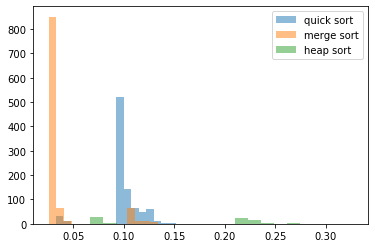

In [33]:
plot_rewards_distribution(arm_rewards_2)
plot_rewards_distribution_together(arm_rewards_2)

Restart at iteration: 15
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09723970000171296, 'merge_sort': 0.10553470000013476, 'heap_sort': 0.2190688999980921}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 2, 'heap_sort': 2}


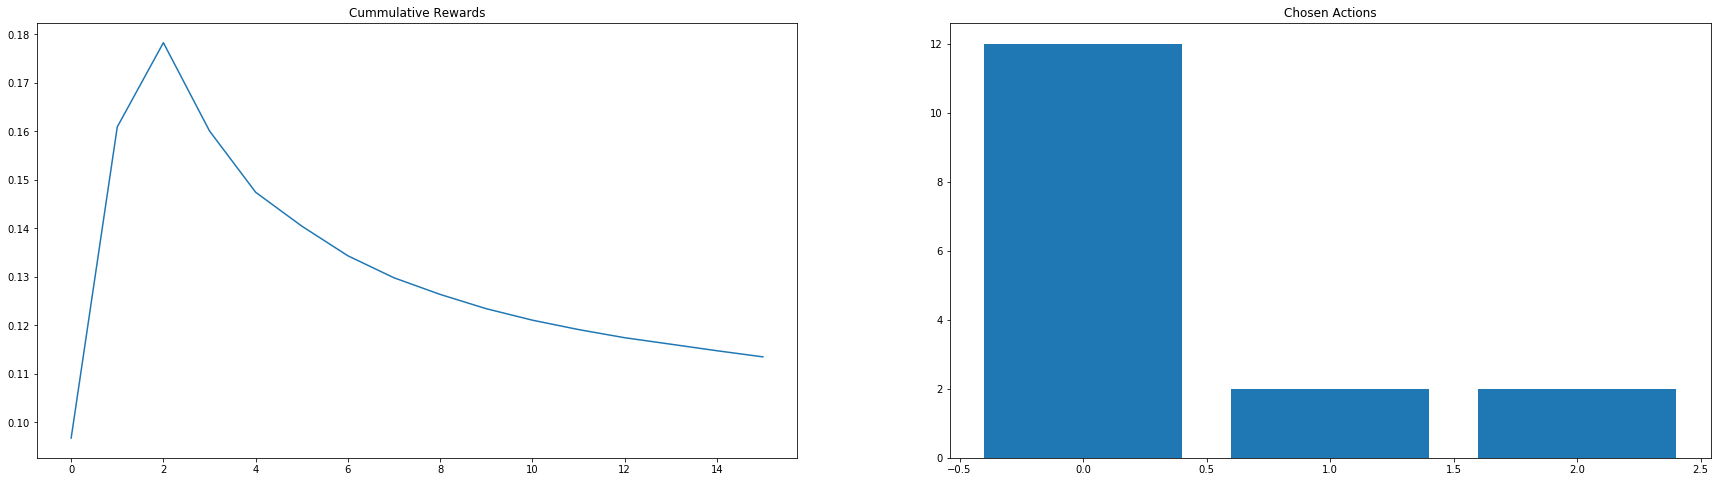

Restart at iteration: 45
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09736378800007514, 'merge_sort': 0.10448723333441497, 'heap_sort': 0.22016579999763053}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 3, 'heap_sort': 2}


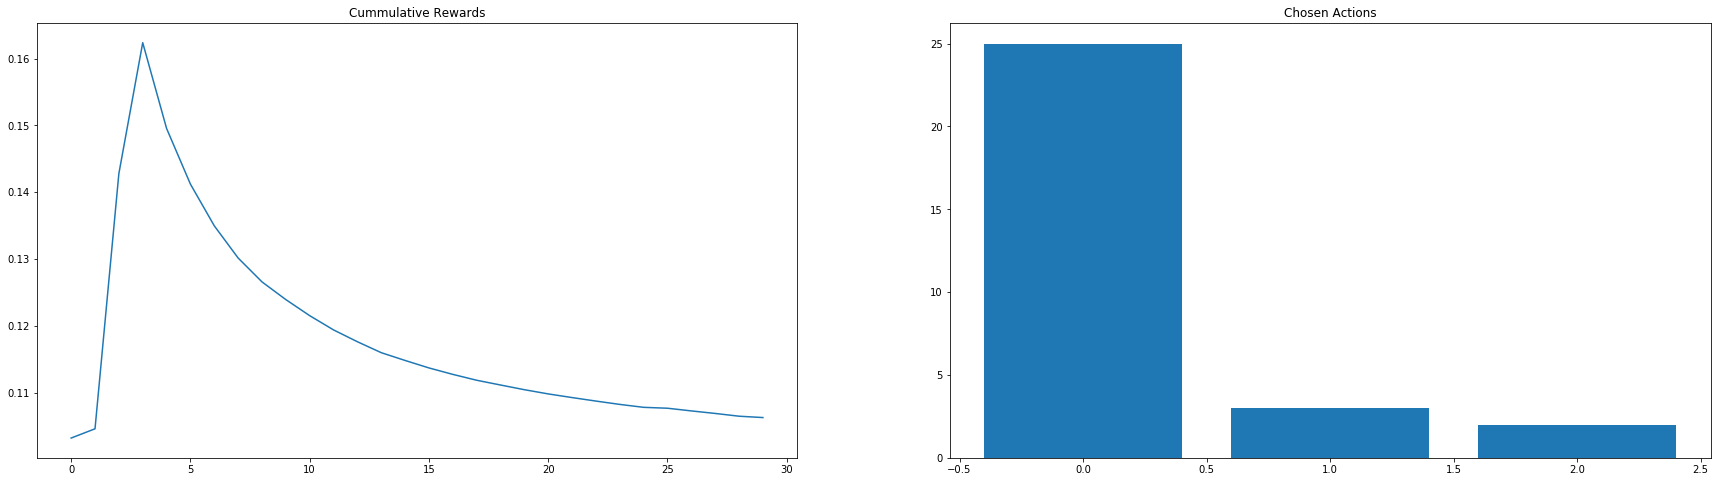

Restart at iteration: 103
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.11046665577025404, 'merge_sort': 0.13083803333574906, 'heap_sort': 0.2701172333278616}
Count per chosen algo {'quick_sort': 52, 'merge_sort': 3, 'heap_sort': 3}


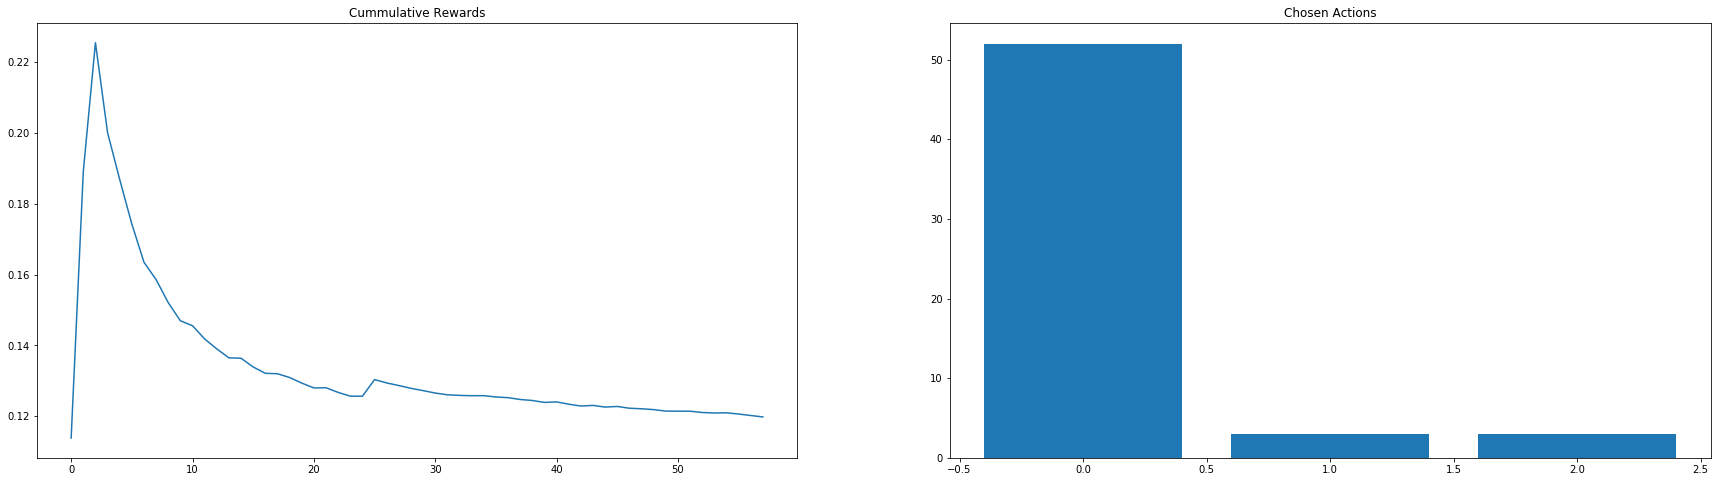

Restart at iteration: 133
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.10789352272695396, 'merge_sort': 0.10973022000107449, 'heap_sort': 0.22117869999298514}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 5, 'heap_sort': 3}


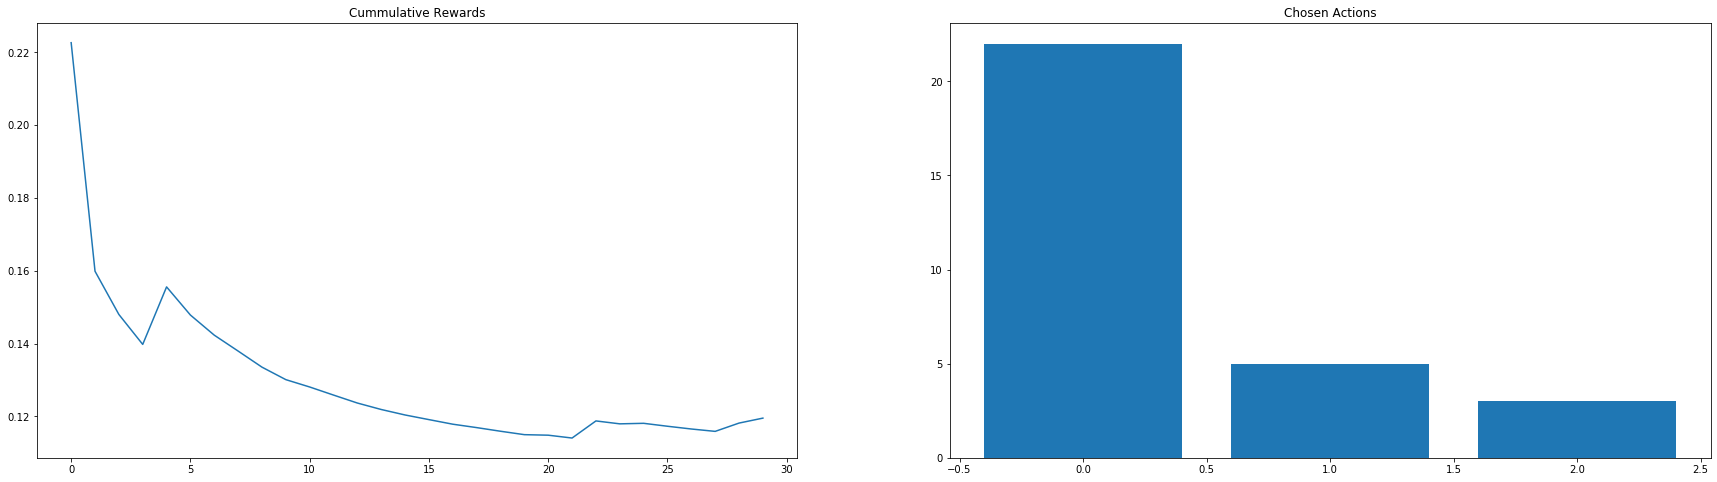

Restart at iteration: 160
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.11596988750352466, 'merge_sort': 0.11936864999734098, 'heap_sort': 0.2893673999982032}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 8, 'heap_sort': 3}


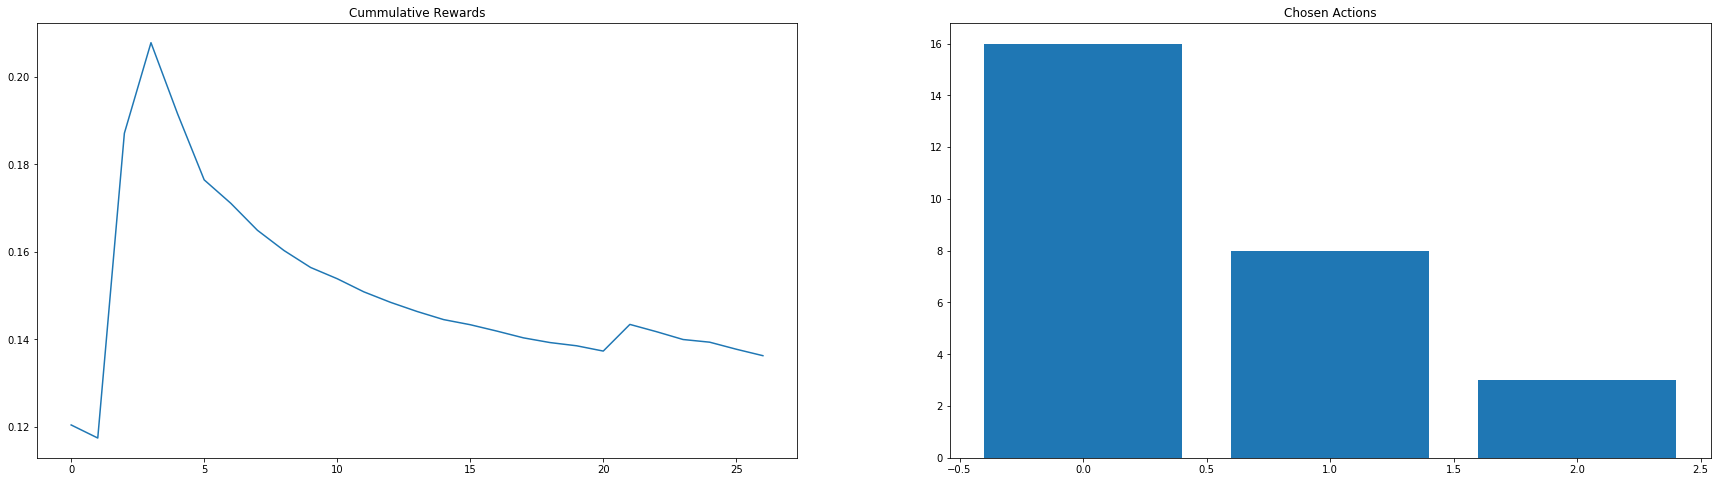

Restart at iteration: 386
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1073317158653271, 'merge_sort': 0.11476256666937842, 'heap_sort': 0.23106490000403332}
Count per chosen algo {'quick_sort': 208, 'merge_sort': 15, 'heap_sort': 3}


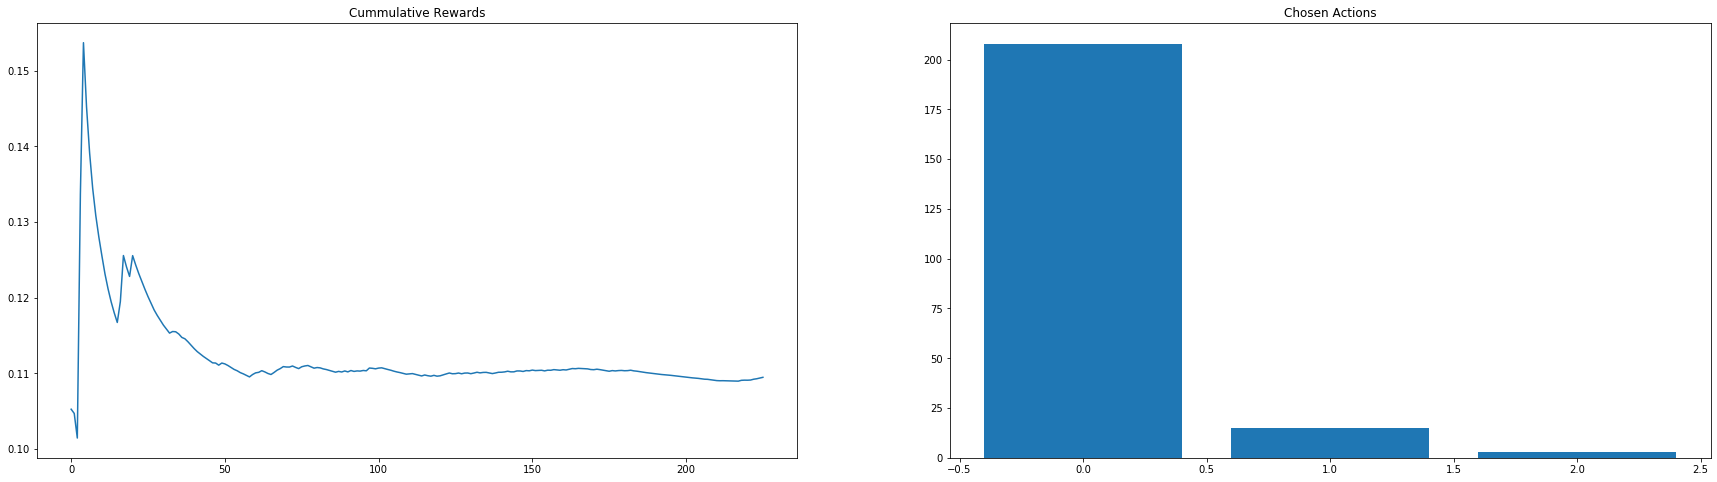

Restart at iteration: 501
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.10761700212884882, 'merge_sort': 0.11355636470526566, 'heap_sort': 0.245574000000488}
Count per chosen algo {'quick_sort': 94, 'merge_sort': 17, 'heap_sort': 4}


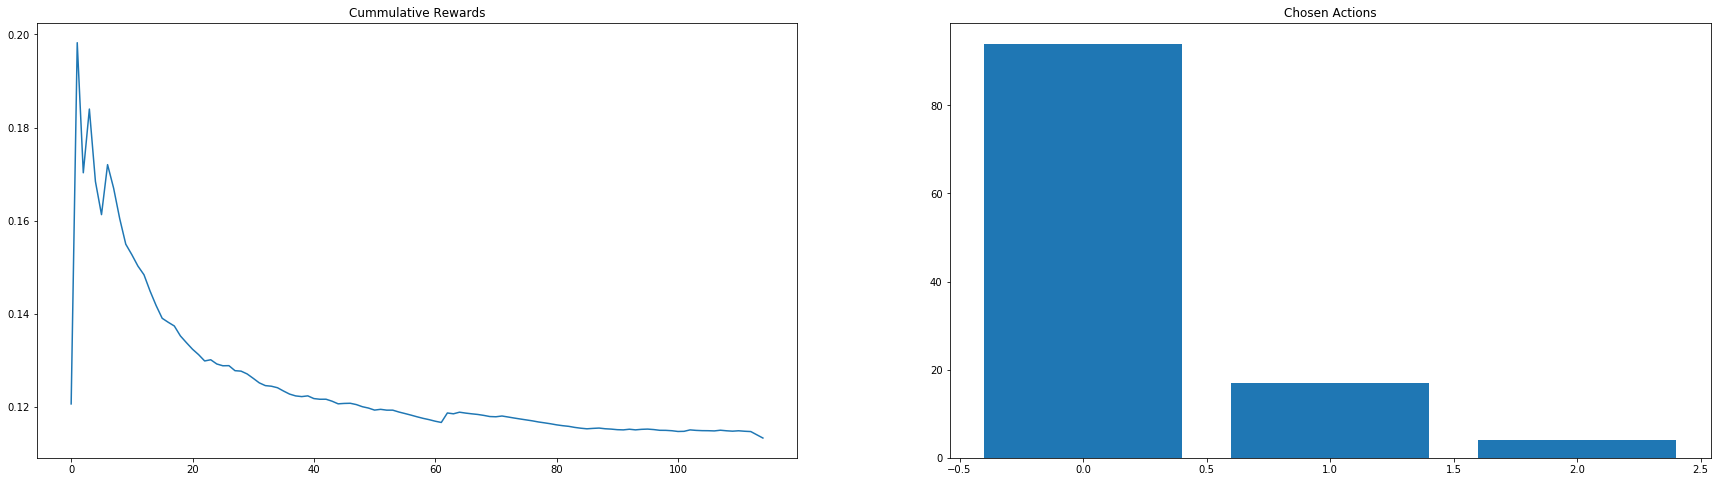

Restart at iteration: 561
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03539467499649618, 'merge_sort': 0.03159353703597811, 'heap_sort': 0.07143004999670666}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 54, 'heap_sort': 2}


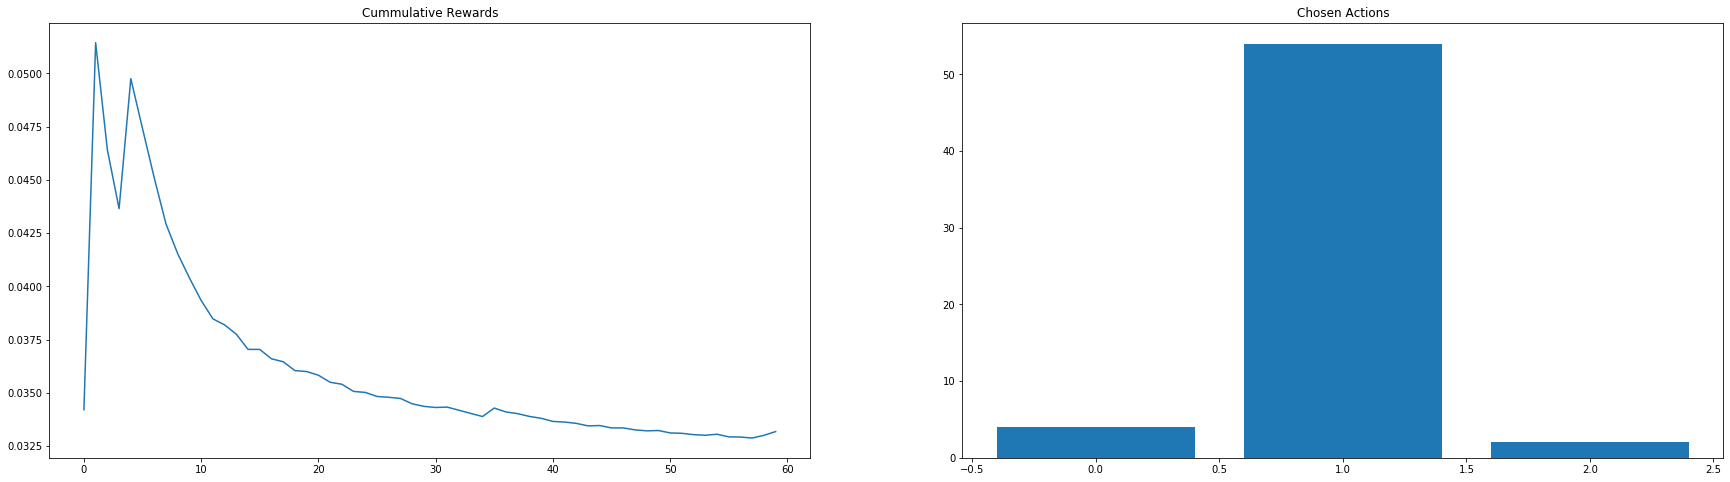

Restart at iteration: 821
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03594889999658335, 'merge_sort': 0.029048245849574203, 'heap_sort': 0.07652936666757644}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 253, 'heap_sort': 3}


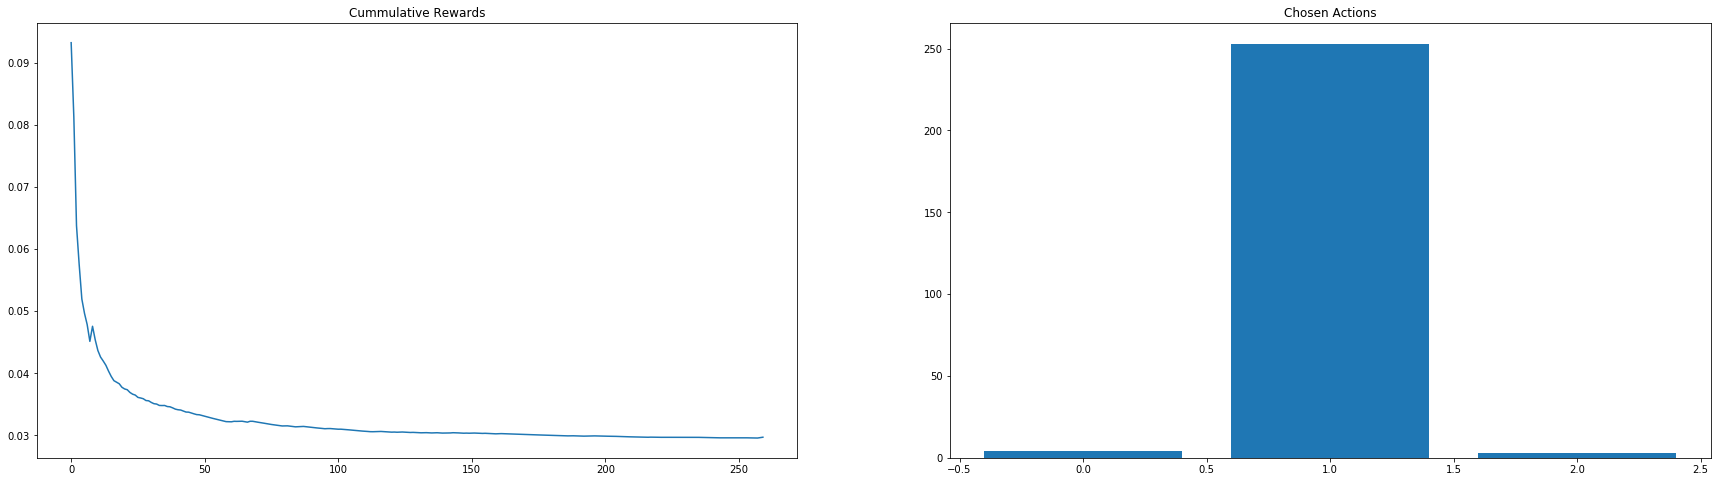

Restart at iteration: 942
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0352922249949188, 'merge_sort': 0.029991517543717157, 'heap_sort': 0.07447869999547645}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 114, 'heap_sort': 3}


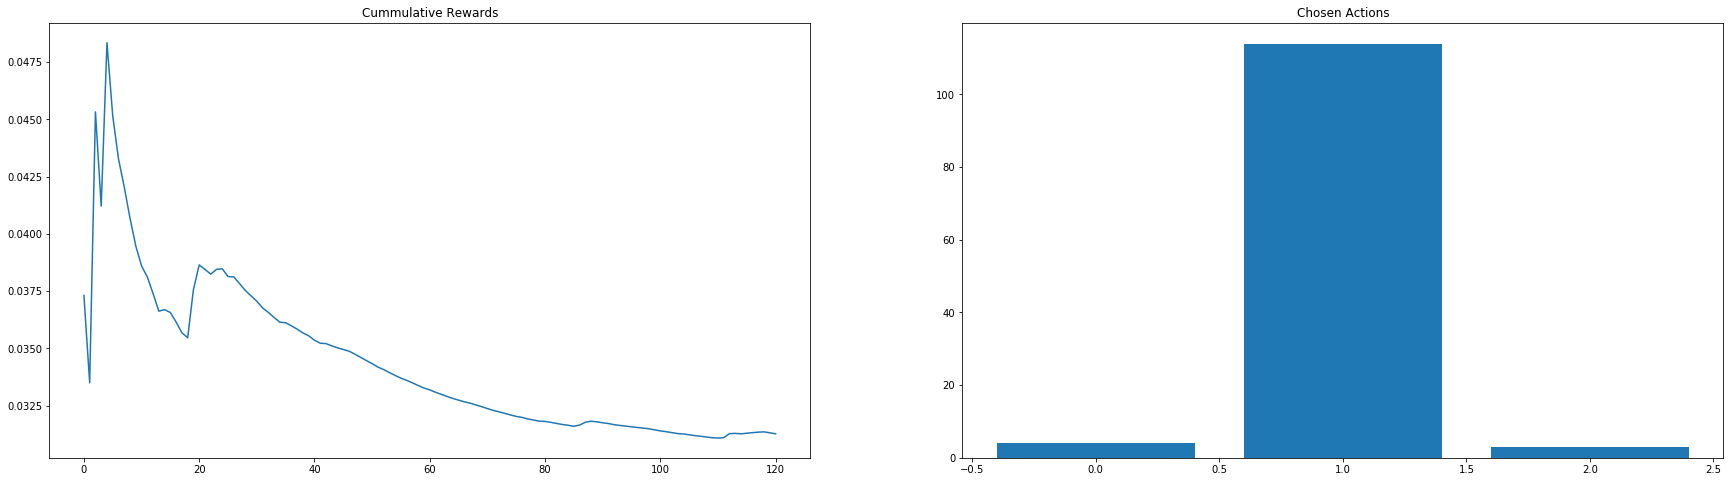

Restart at iteration: 990
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03417420000187121, 'merge_sort': 0.028488254545333224, 'heap_sort': 0.06808814999385504}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 44, 'heap_sort': 2}


Restart at iteration: 1025
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09085452941123068, 'merge_sort': 0.09329907500068657, 'heap_sort': 0.1538096666627098}
Count per chosen algo {'quick_sort': 17, 'merge_sort': 12, 'heap_sort': 6}


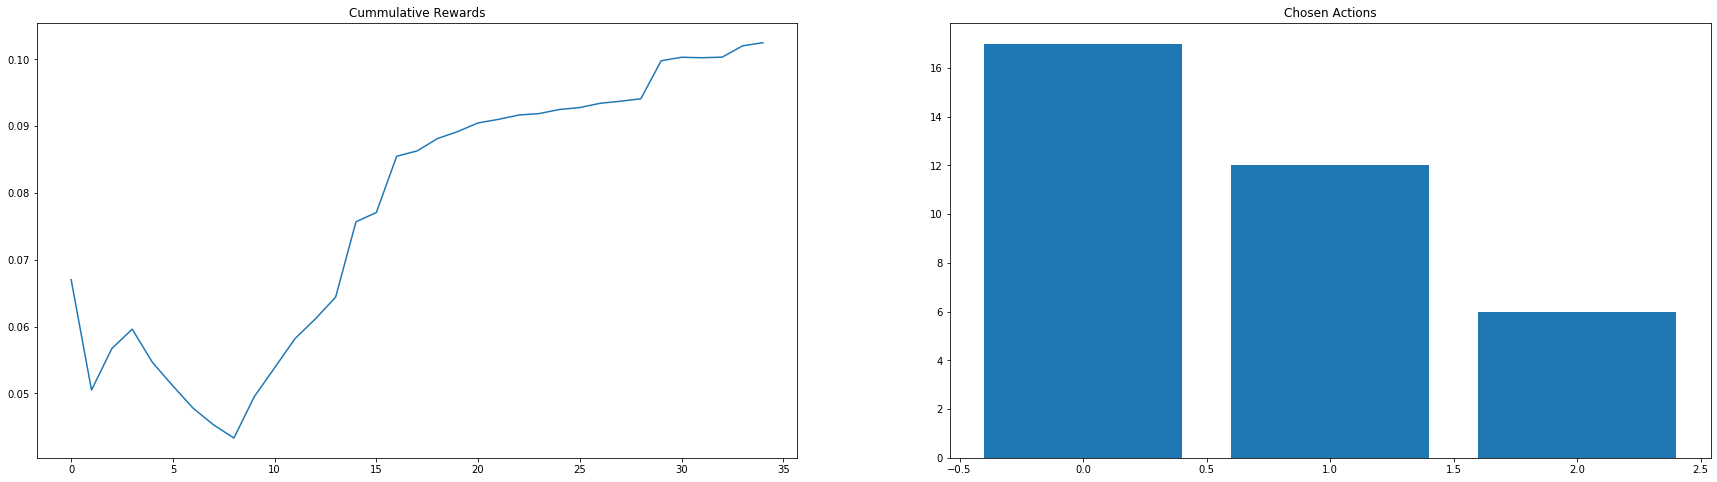

Restart at iteration: 1115
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09764279638478779, 'merge_sort': 0.10657753333604585, 'heap_sort': 0.22537765000015497}
Count per chosen algo {'quick_sort': 83, 'merge_sort': 3, 'heap_sort': 4}


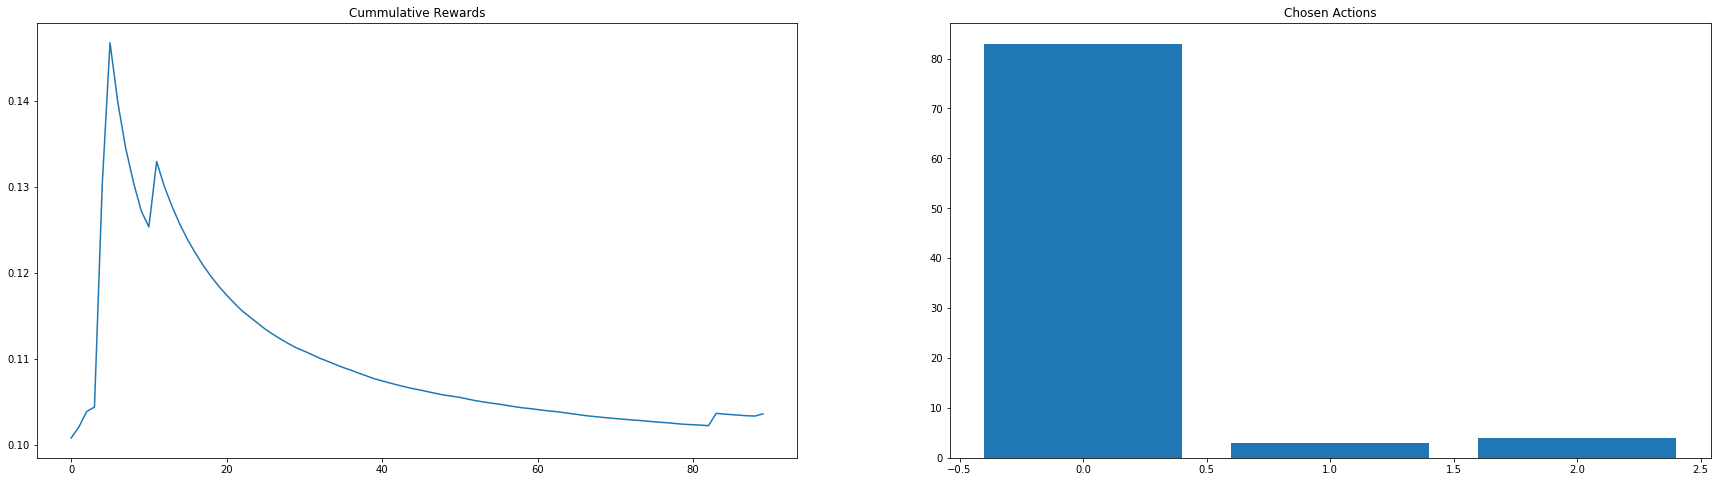

Restart at iteration: 1181
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09787946833312162, 'merge_sort': 0.11137883333140053, 'heap_sort': 0.23154283333860803}
Count per chosen algo {'quick_sort': 60, 'merge_sort': 3, 'heap_sort': 3}


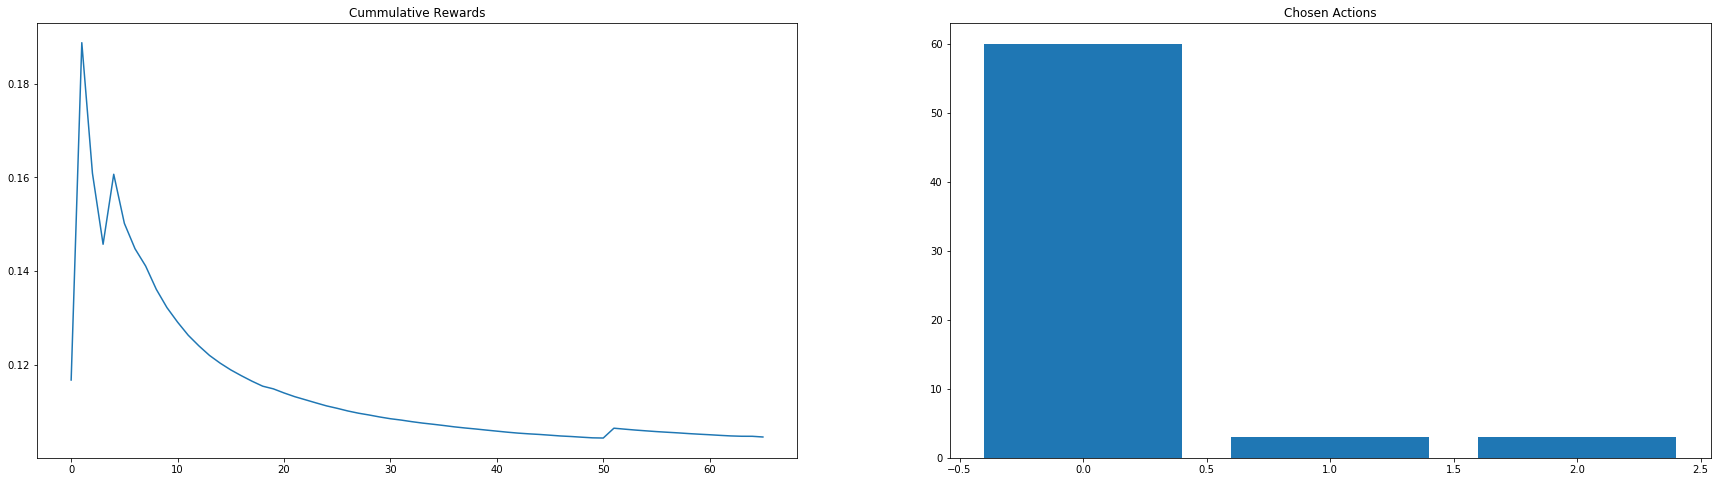

Restart at iteration: 1201
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1013690375002625, 'merge_sort': 0.10537155000201892, 'heap_sort': 0.2197179499999038}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 2, 'heap_sort': 2}


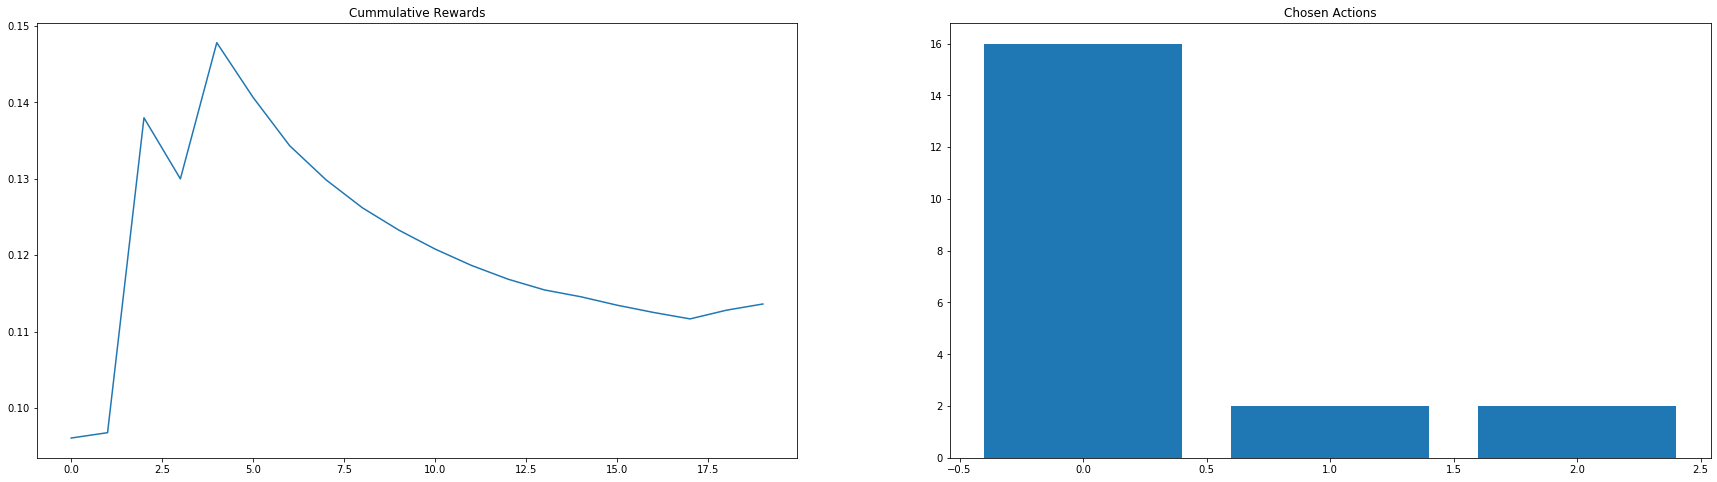

Restart at iteration: 1244
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09787913157809894, 'merge_sort': 0.1053224666635894, 'heap_sort': 0.22913524999603396}
Count per chosen algo {'quick_sort': 38, 'merge_sort': 3, 'heap_sort': 2}


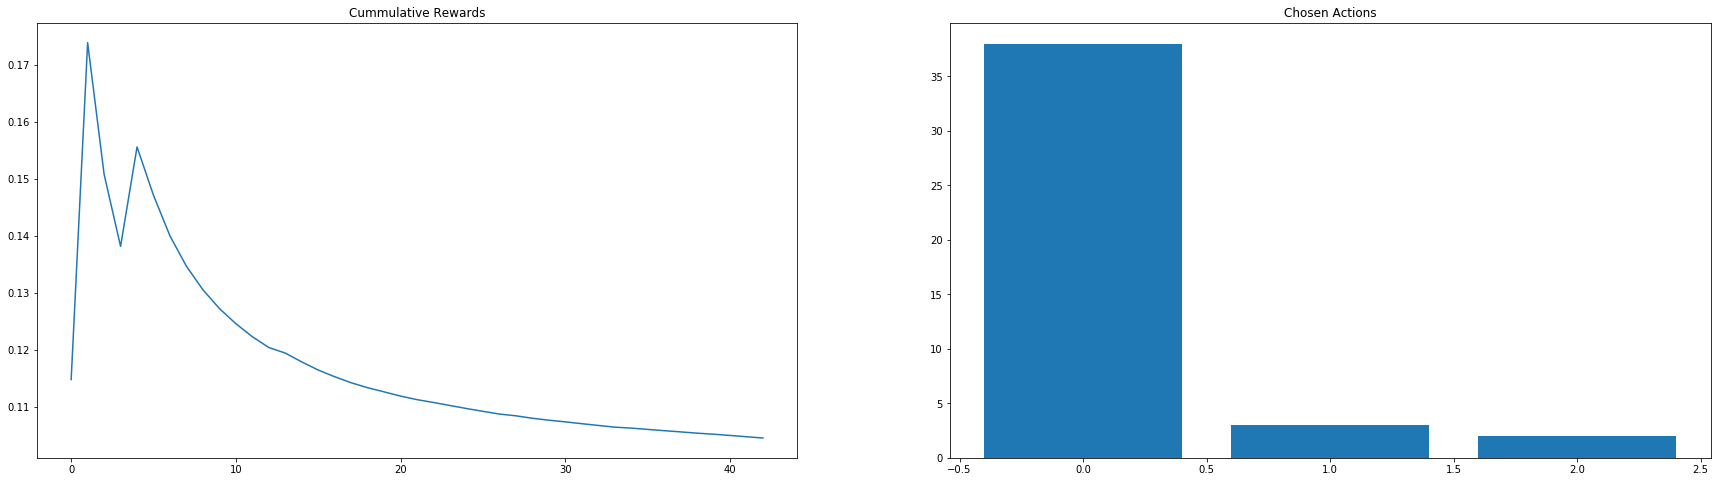

Restart at iteration: 1278
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0993321310349435, 'merge_sort': 0.10564996666895847, 'heap_sort': 0.22241444999963278}
Count per chosen algo {'quick_sort': 29, 'merge_sort': 3, 'heap_sort': 2}


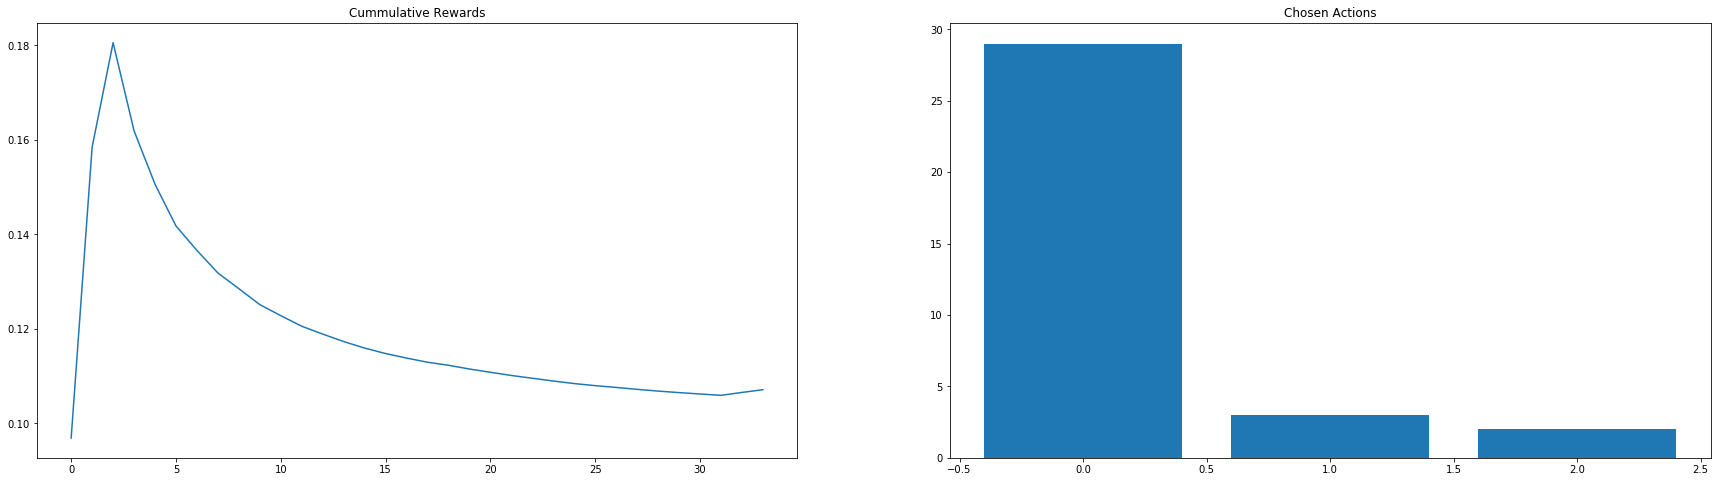

Restart at iteration: 1294
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09777238333723896, 'merge_sort': 0.10551884999586036, 'heap_sort': 0.22076089999609394}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 2, 'heap_sort': 2}


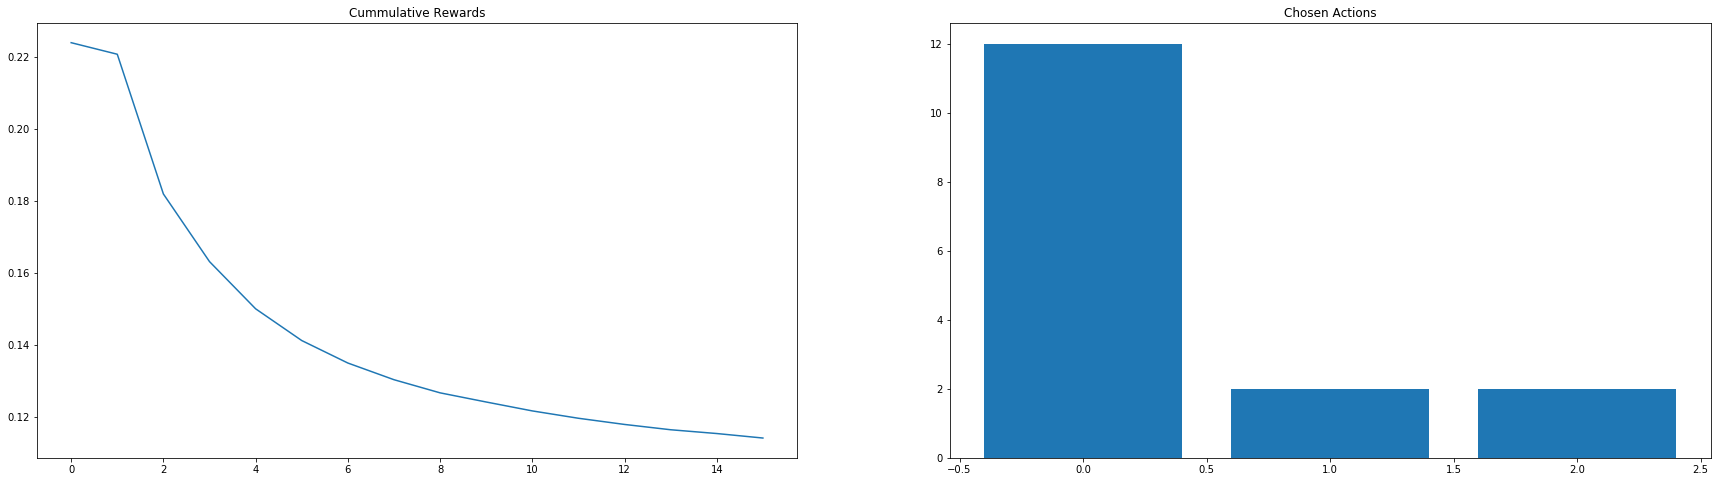

Restart at iteration: 1331
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0977154090880614, 'merge_sort': 0.10664945000462467, 'heap_sort': 0.2197323999935179}
Count per chosen algo {'quick_sort': 33, 'merge_sort': 2, 'heap_sort': 2}


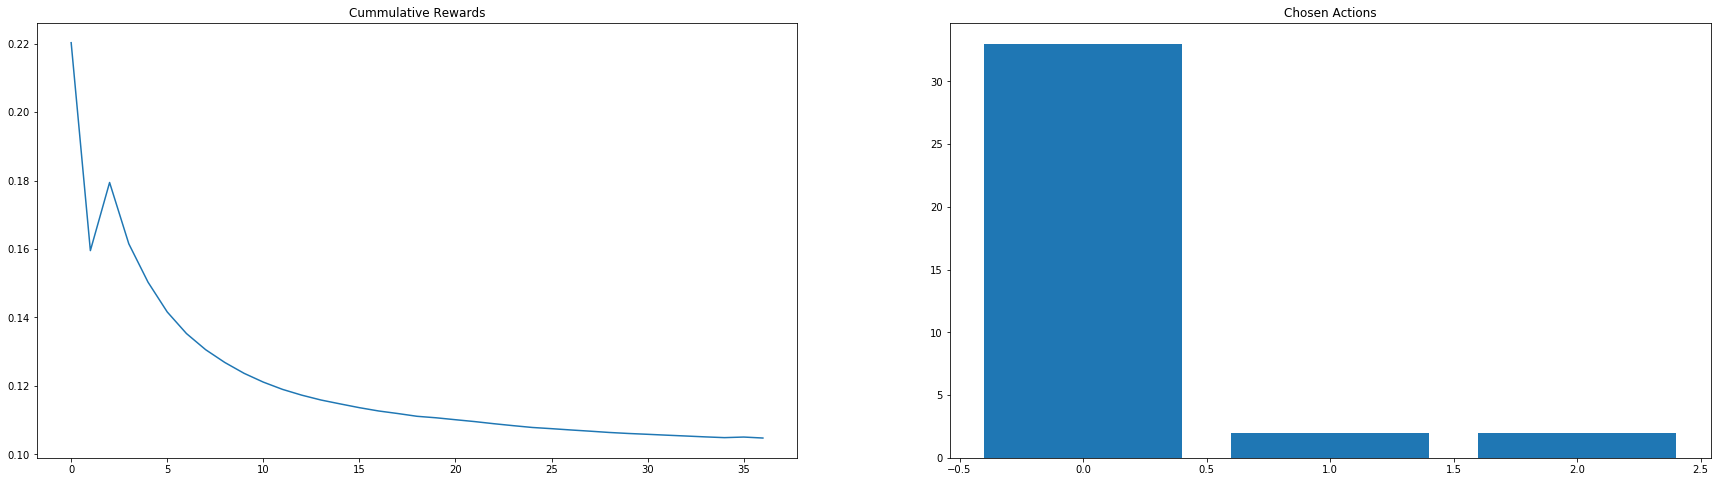

Restart at iteration: 1384
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09749975416677141, 'merge_sort': 0.10530803333191822, 'heap_sort': 0.21989369999209885}
Count per chosen algo {'quick_sort': 48, 'merge_sort': 3, 'heap_sort': 2}


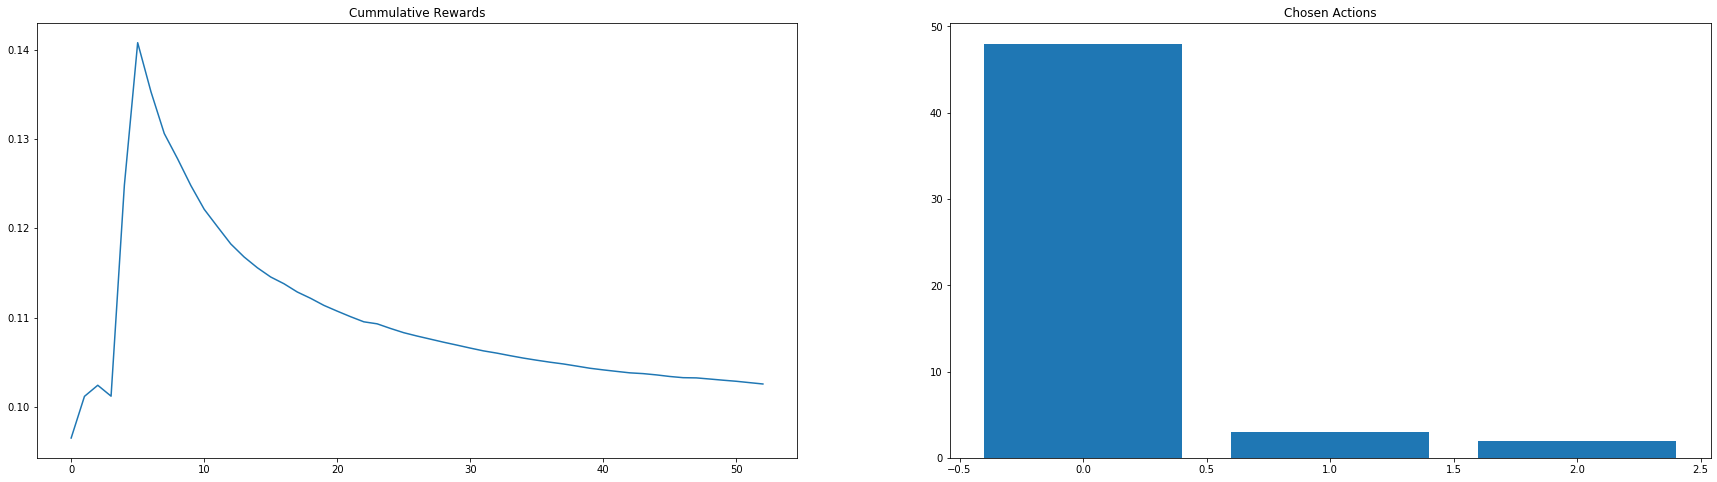

Restart at iteration: 1432
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09724758139663907, 'merge_sort': 0.1066382999997586, 'heap_sort': 0.22335146666834285}
Count per chosen algo {'quick_sort': 43, 'merge_sort': 2, 'heap_sort': 3}


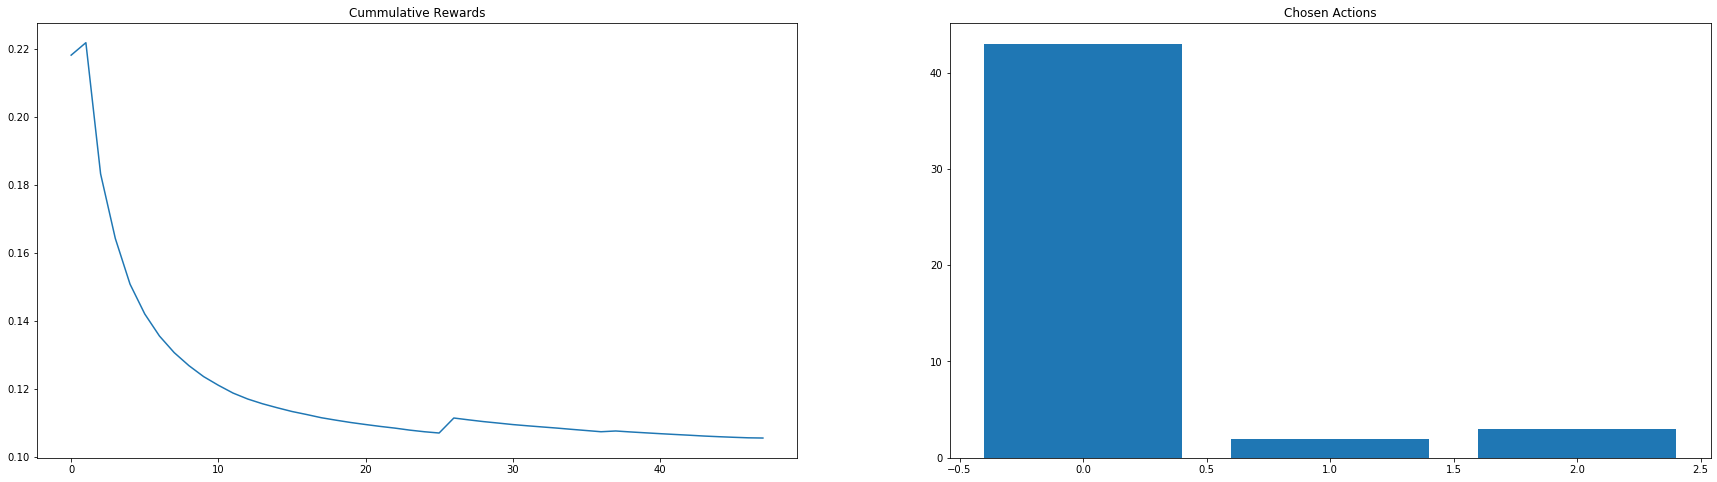

Restart at iteration: 1450
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09730657856977944, 'merge_sort': 0.1057412000009208, 'heap_sort': 0.21660240000346676}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 2, 'heap_sort': 2}


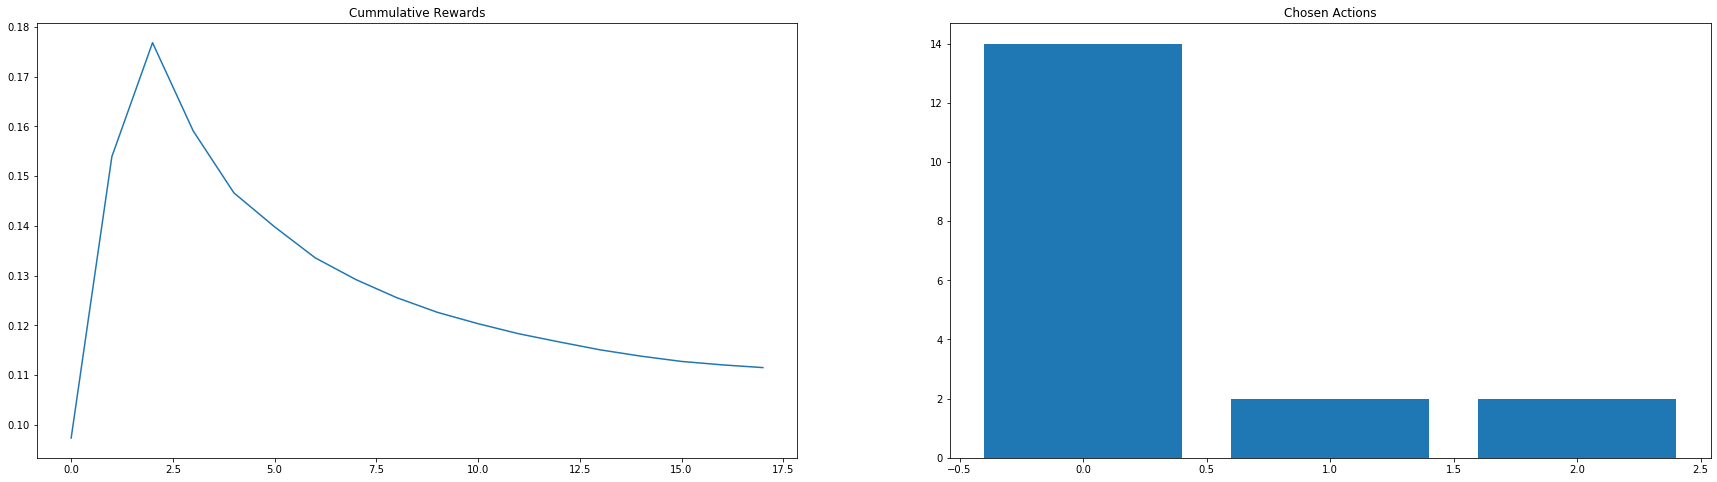

Restart at iteration: 1501
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.10502774285781752, 'merge_sort': 0.11450121428268696, 'heap_sort': 0.22013539999898057}
Count per chosen algo {'quick_sort': 42, 'merge_sort': 7, 'heap_sort': 2}


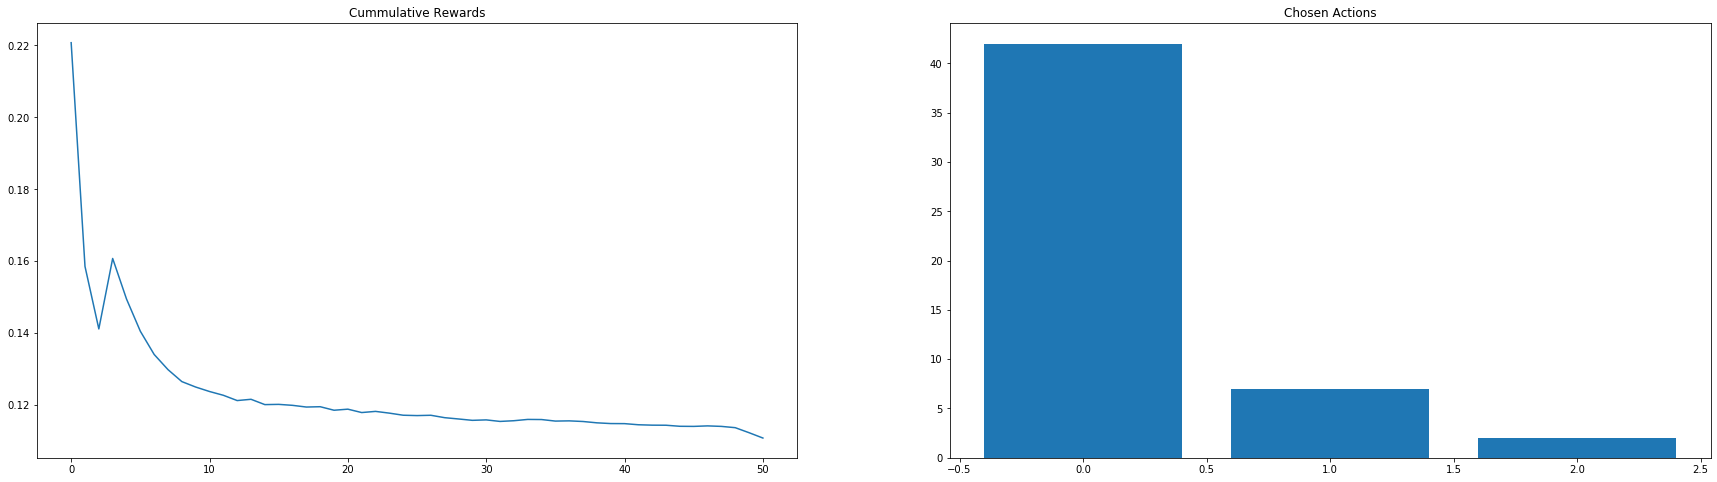

Restart at iteration: 1544
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04178200000023935, 'merge_sort': 0.028778865789813847, 'heap_sort': 0.08113330000196584}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 38, 'heap_sort': 2}


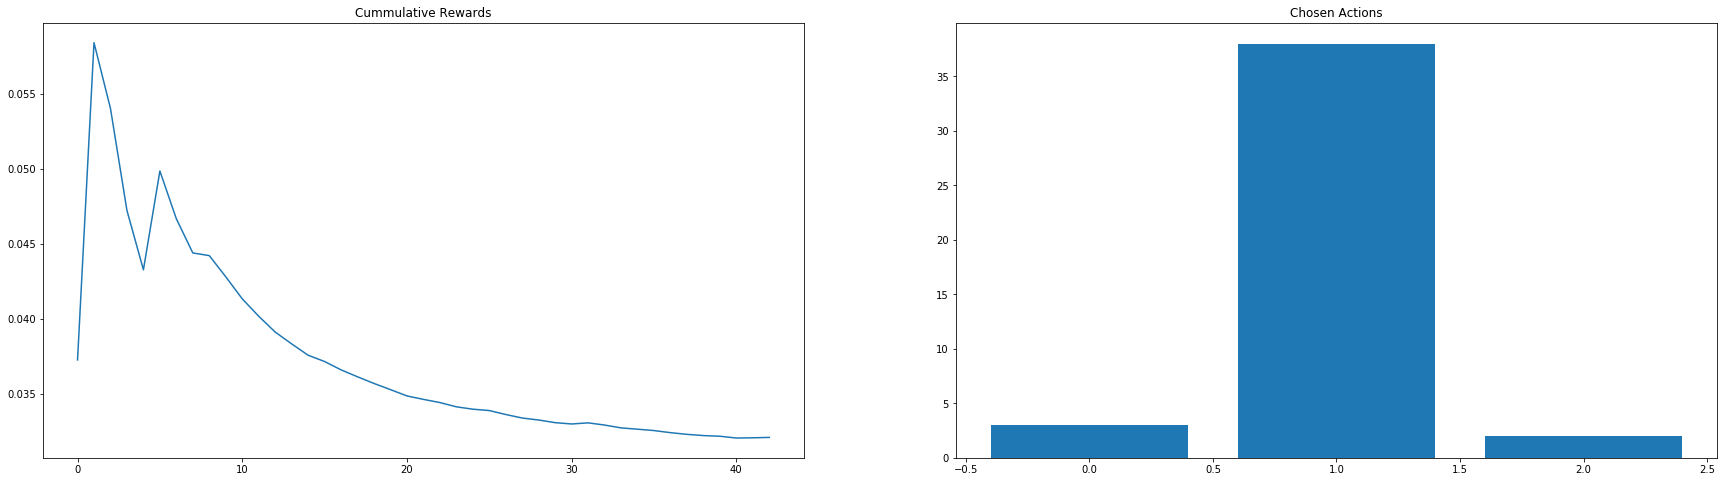

Restart at iteration: 1723
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04143566667335108, 'merge_sort': 0.030778674117155947, 'heap_sort': 0.0782972333302799}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 170, 'heap_sort': 3}


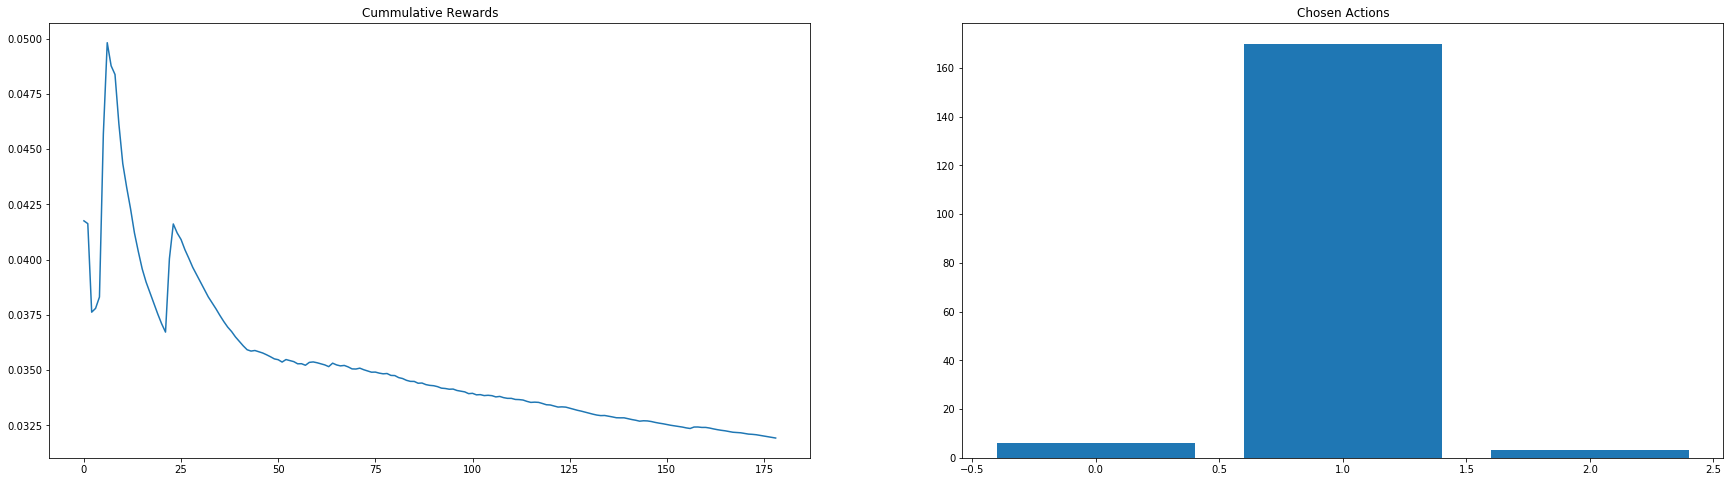

Restart at iteration: 1740
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.05041085000266321, 'merge_sort': 0.028197038463146713, 'heap_sort': 0.07447724999656202}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 13, 'heap_sort': 2}


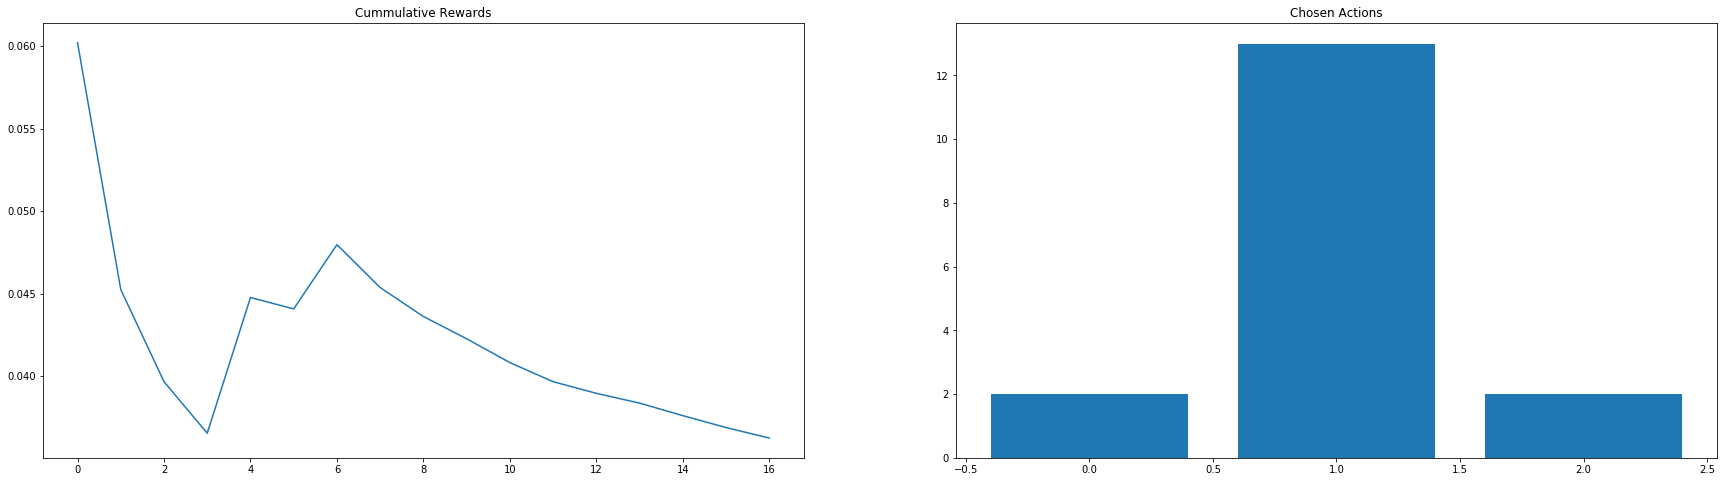

Restart at iteration: 1756
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04127640000660904, 'merge_sort': 0.02771533333119199, 'heap_sort': 0.07309190000523813}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 12, 'heap_sort': 2}


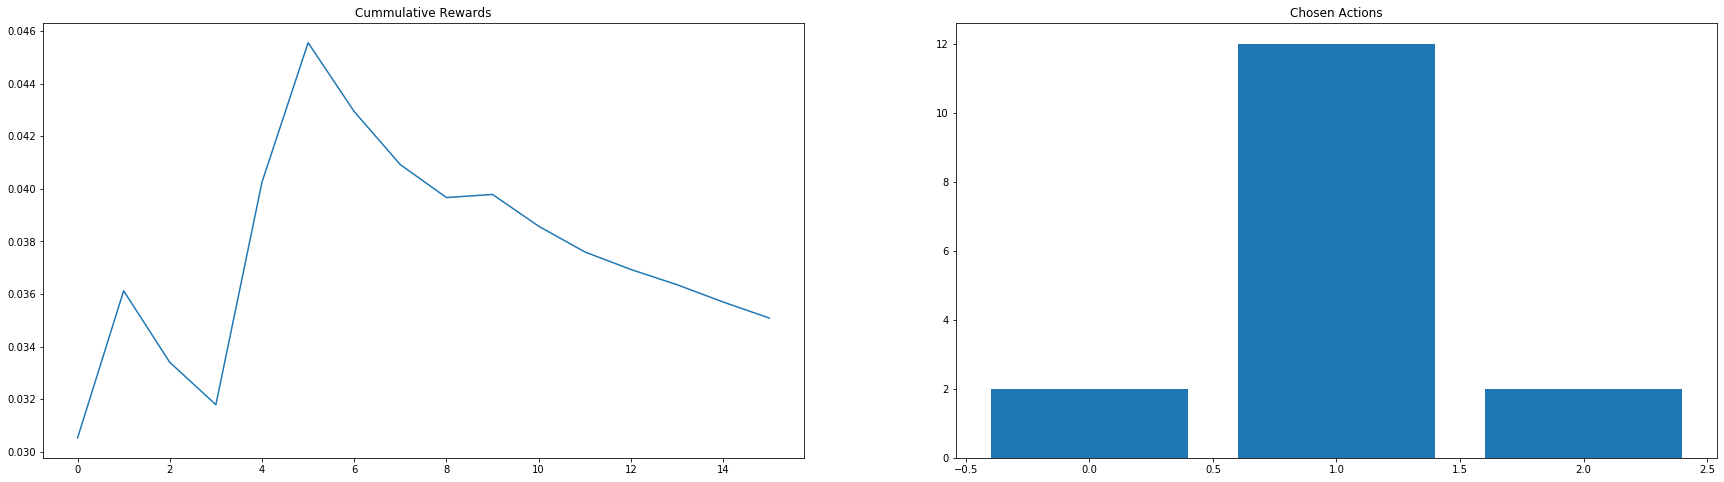

Restart at iteration: 1939
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03661477500281762, 'merge_sort': 0.0281003666663474, 'heap_sort': 0.07227365000289865}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 177, 'heap_sort': 2}


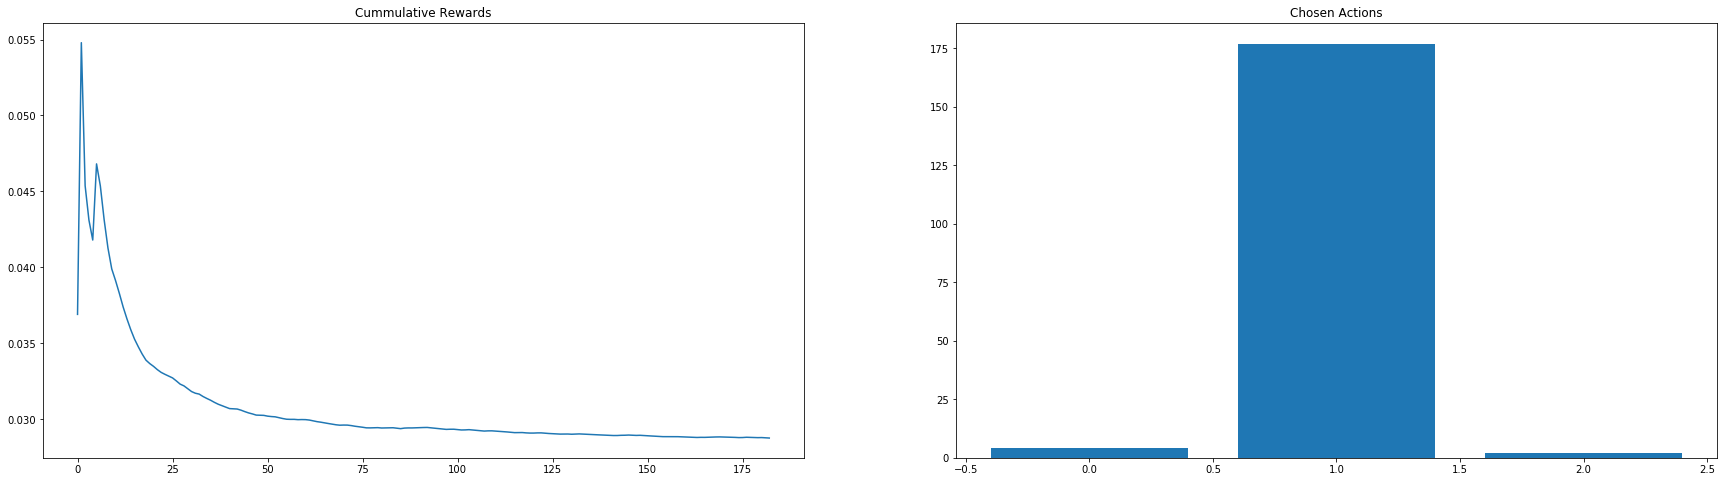

Restart at iteration: 1981
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.036680299999716226, 'merge_sort': 0.028554362163491977, 'heap_sort': 0.0735684000052667}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 37, 'heap_sort': 3}


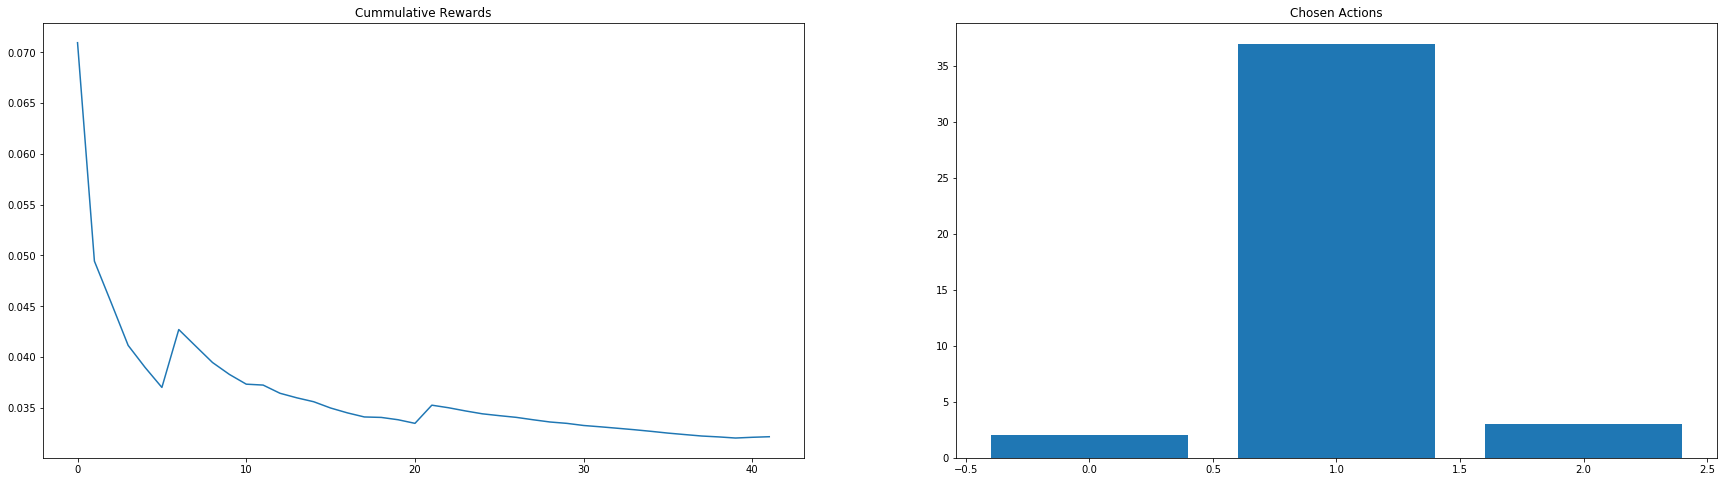

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03796159999910742, 'merge_sort': 0.029927378572340655, 'heap_sort': 0.07695494999643415}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 14, 'heap_sort': 2}


Total reward 141.5636


In [34]:
for elem in list_iteration_results_2:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_2,4))

## Three outliers in a row restart the expriment

In [35]:
list_iteration_results_3, total_reward_3, arm_rewards_3 = ts_quantile(list_distributions, n_samples, num_consec_elem=3)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.06191514128038203
Less than two values for merge_sort
merge_sort Theta 0.0029938865281880834
Less than two values for heap_sort
heap_sort Theta 0.020805396449908555


Chosen algorithm is:  merge_sort with reward: 0.10638349999499042
Sample mean is:  0.10638349999499042 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.07118930664612956
Less than two values for merge_sort
merge_sort Theta 0.01884229363981559
Less than two values for heap_sort
heap_sort Theta 0.06780045788209416


Chosen algorithm is:  merge_sort with reward: 0.12489640001149382
Sample mean is:  0.11563995000324212 Sample variance is: 8.568186675526298e-05


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.06388488465927668
merge_sort Theta 0.08842698627873888
Less than two values for heap_sort
heap_sort Theta 0.059415676546011126


Chosen algorithm is:  heap_sort with reward: 0.24881390000



Iteration: 29
quick_sort Theta 0.11609543259242376
merge_sort Theta 0.11060644803070833
heap_sort Theta 0.27223019839155893


Chosen algorithm is:  merge_sort with reward: 0.10543719999259338
Sample mean is:  0.11012291999795706 Sample variance is: 6.36563945380602e-05


Iteration: 30
quick_sort Theta 0.11796906044042416
merge_sort Theta 0.10862063497524553
heap_sort Theta 0.25617353063654563


Chosen algorithm is:  merge_sort with reward: 0.10607520000485238
Sample mean is:  0.10993017142685685 Sample variance is: 6.136817788851899e-05


Iteration: 31
quick_sort Theta 0.11669001258198454
merge_sort Theta 0.10782062859419748
heap_sort Theta 0.26647465826014


Chosen algorithm is:  merge_sort with reward: 0.10536950000096112
Sample mean is:  0.10972286818022522 Sample variance is: 5.9481182614566896e-05


Iteration: 32
quick_sort Theta 0.119065496390007
merge_sort Theta 0.10968971131658954
heap_sort Theta 0.2642356219516185


Chosen algorithm is:  merge_sort with reward: 0.10307779999



Iteration: 60
quick_sort Theta 0.11794443784627558
merge_sort Theta 0.11323357450239693
heap_sort Theta 0.2535337008235054


Chosen algorithm is:  merge_sort with reward: 0.12830019999819342
Sample mean is:  0.11404152745072839 Sample variance is: 0.00015347799922811603


Iteration: 61
quick_sort Theta 0.13008234029284688
merge_sort Theta 0.11295733528320252
heap_sort Theta 0.2607016125724041


Chosen algorithm is:  merge_sort with reward: 0.12457289999292698
Sample mean is:  0.11424405384577067 Sample variance is: 0.00015261836321808986


Iteration: 62
quick_sort Theta 0.11574352362175132
merge_sort Theta 0.11632045537901205
heap_sort Theta 0.26346405640785125


Chosen algorithm is:  quick_sort with reward: 0.09795480000320822
Sample mean is:  0.116233500000817 Sample variance is: 0.0001230261443984167


Iteration: 63
quick_sort Theta 0.1105596227575399
merge_sort Theta 0.11419949865800233
heap_sort Theta 0.28042577098142196


Chosen algorithm is:  quick_sort with reward: 0.09681010


Chosen algorithm is:  merge_sort with reward: 0.12886499999149237
Sample mean is:  0.11395853333427415 Sample variance is: 0.00011110295522850217


Iteration: 89
quick_sort Theta 0.10706420040673999
merge_sort Theta 0.10723169789609799
heap_sort Theta 0.22857953404115391


Chosen algorithm is:  quick_sort with reward: 0.10139180000987835
Sample mean is:  0.10510783571537884 Sample variance is: 7.859184189060037e-05


Iteration: 90
quick_sort Theta 0.10399076739499637
merge_sort Theta 0.10986976102554571
heap_sort Theta 0.23301228078170538


Chosen algorithm is:  quick_sort with reward: 0.09767730000021402
Sample mean is:  0.10461246666770117 Sample variance is: 7.67878526721193e-05


Iteration: 91
quick_sort Theta 0.10245781574523784
merge_sort Theta 0.12313084619990237
heap_sort Theta 0.23176508719369843


Chosen algorithm is:  quick_sort with reward: 0.13151930000458378
Sample mean is:  0.10629414375125634 Sample variance is: 0.00011440917908043079


Iteration: 92
quick_sort Theta 0


Iteration: 119
quick_sort Theta 0.10741135587858867
merge_sort Theta 0.11393359063607635
heap_sort Theta 0.2297929553588737


Chosen algorithm is:  quick_sort with reward: 0.09736719999636989
Sample mean is:  0.10495261904829281 Sample variance is: 0.0001208549199418005


Iteration: 120
quick_sort Theta 0.10488480655566552
merge_sort Theta 0.11182979844169186
heap_sort Theta 0.2290391076466006


Chosen algorithm is:  quick_sort with reward: 0.0983020999992732
Sample mean is:  0.10479795581459468 Sample variance is: 0.00011904901047430467


Iteration: 121
quick_sort Theta 0.10623249085262287
merge_sort Theta 0.11533306180825813
heap_sort Theta 0.22929867094204506


Chosen algorithm is:  quick_sort with reward: 0.0967534999945201
Sample mean is:  0.10461512727322936 Sample variance is: 0.00011778068099346752


Iteration: 122
quick_sort Theta 0.10341848315620987
merge_sort Theta 0.1109282861302377
heap_sort Theta 0.23642878395248723


Chosen algorithm is:  quick_sort with reward: 0.09892



Chosen algorithm is:  quick_sort with reward: 0.0981679999968037
Sample mean is:  0.10455585714309044 Sample variance is: 0.00011428468487278838


Iteration: 150
quick_sort Theta 0.10332412193994084
merge_sort Theta 0.10703923498133279
heap_sort Theta 0.228899583593326


Chosen algorithm is:  quick_sort with reward: 0.09721690000151284
Sample mean is:  0.1044524915495471 Sample variance is: 0.00011342295263887561


Iteration: 151
quick_sort Theta 0.10356420455041776
merge_sort Theta 0.11481156972972317
heap_sort Theta 0.2228181530666628


Chosen algorithm is:  quick_sort with reward: 0.0980868000042392
Sample mean is:  0.10436407916697338 Sample variance is: 0.00011240262305908226


Iteration: 152
quick_sort Theta 0.104865247257091
merge_sort Theta 0.11242039632983848
heap_sort Theta 0.23112794245817267


Chosen algorithm is:  quick_sort with reward: 0.09716299999854527
Sample mean is:  0.10426543424685791 Sample variance is: 0.00011156348015841887


Iteration: 153
quick_sort Theta 0



Iteration: 180
quick_sort Theta 0.10268758714058238
merge_sort Theta 0.11422283272925712
heap_sort Theta 0.22980523415858908


Chosen algorithm is:  quick_sort with reward: 0.09829390000959393
Sample mean is:  0.10424996930676499 Sample variance is: 0.00011247315456251229


Iteration: 181
quick_sort Theta 0.10556326822083242
merge_sort Theta 0.1113217326925625
heap_sort Theta 0.22885167156956956


Chosen algorithm is:  quick_sort with reward: 0.09876660000008997
Sample mean is:  0.10419621078415052 Sample variance is: 0.00011166236443072793


Iteration: 182
quick_sort Theta 0.10209202459506532
merge_sort Theta 0.1137504027278326
heap_sort Theta 0.234550069074723


Chosen algorithm is:  quick_sort with reward: 0.0968946000066353
Sample mean is:  0.10412532135912611 Sample variance is: 0.00011109084548437675


Iteration: 183
quick_sort Theta 0.10449347058116568
merge_sort Theta 0.1107694239935579
heap_sort Theta 0.23031563687580006


Chosen algorithm is:  quick_sort with reward: 0.0995



Iteration: 211
quick_sort Theta 0.10441081874268038
merge_sort Theta 0.1045536271150968
heap_sort Theta 0.22996823755925588


Chosen algorithm is:  quick_sort with reward: 0.12537509998946916
Sample mean is:  0.10375854732799308 Sample variance is: 0.00010910136424802014


Iteration: 212
quick_sort Theta 0.10158760881037597
merge_sort Theta 0.10850661995203977
heap_sort Theta 0.21606970388599106


Chosen algorithm is:  quick_sort with reward: 0.11639400001149625
Sample mean is:  0.10385427045438325 Sample variance is: 0.00010947518087858687


Iteration: 213
quick_sort Theta 0.10341524165767932
merge_sort Theta 0.10881906014996082
heap_sort Theta 0.23085690801255795


Chosen algorithm is:  quick_sort with reward: 0.0982337000023108
Sample mean is:  0.10381201052617219 Sample variance is: 0.00010888779822012306


Iteration: 214
quick_sort Theta 0.10316976664506491
merge_sort Theta 0.11951745424162553
heap_sort Theta 0.23435195218136232


Chosen algorithm is:  quick_sort with reward: 0.

heap_sort Theta 0.22673111661958298


Chosen algorithm is:  quick_sort with reward: 0.10065930000564549
Sample mean is:  0.10387182750000648 Sample variance is: 0.0001049382769695946


Iteration: 243
quick_sort Theta 0.104140091434156
merge_sort Theta 0.1110342793664003
heap_sort Theta 0.23588431149358804


Chosen algorithm is:  quick_sort with reward: 0.09665300000051502
Sample mean is:  0.10382699006212144 Sample variance is: 0.00010460814976318595


Iteration: 244
quick_sort Theta 0.10428948330903477
merge_sort Theta 0.11182848835927883
heap_sort Theta 0.23270656942671109


Chosen algorithm is:  quick_sort with reward: 0.09514380000473466
Sample mean is:  0.1037733901234956 Sample variance is: 0.0001044249659443919


Iteration: 245
quick_sort Theta 0.10388502642798493
merge_sort Theta 0.12065828029828583
heap_sort Theta 0.23242798611976695


Chosen algorithm is:  quick_sort with reward: 0.09922209999058396
Sample mean is:  0.10374546809814031 Sample variance is: 0.000103910623580533



Chosen algorithm is:  quick_sort with reward: 0.10348320000048261
Sample mean is:  0.10326558743473703 Sample variance is: 9.122364958367312e-05


Iteration: 274
quick_sort Theta 0.10195967629234118
merge_sort Theta 0.10868120854251637
heap_sort Theta 0.22330104114298702


Chosen algorithm is:  quick_sort with reward: 0.10286550001183059
Sample mean is:  0.10326350364607606 Sample variance is: 9.074935576421822e-05


Iteration: 275
quick_sort Theta 0.10192165931014906
merge_sort Theta 0.11226448862655623
heap_sort Theta 0.24109960477401202


Chosen algorithm is:  quick_sort with reward: 0.09849110001232475
Sample mean is:  0.10323877616610844 Sample variance is: 9.039654991532689e-05


Iteration: 276
quick_sort Theta 0.10290016856155933
merge_sort Theta 0.10976409730907061
heap_sort Theta 0.22323889388146148


Chosen algorithm is:  quick_sort with reward: 0.0987602999957744
Sample mean is:  0.10321569123739538 Sample variance is: 9.003344070702683e-05


Iteration: 277
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09886079998977948
Sample mean is:  0.10251838198222162 Sample variance is: 8.23711778032087e-05


Iteration: 305
quick_sort Theta 0.1035233059136816
merge_sort Theta 0.11373060512633516
heap_sort Theta 0.2274695674269477


Chosen algorithm is:  quick_sort with reward: 0.09876139998959843
Sample mean is:  0.1025015345293399 Sample variance is: 8.206481206470009e-05


Iteration: 306
quick_sort Theta 0.1025193478634026
merge_sort Theta 0.11998841775291175
heap_sort Theta 0.232474372398022


Chosen algorithm is:  quick_sort with reward: 0.09802900000067893
Sample mean is:  0.10248156785733695 Sample variance is: 8.178735425851888e-05


Iteration: 307
quick_sort Theta 0.10169509666336377
merge_sort Theta 0.11273461851812443
heap_sort Theta 0.23340247103913295


Chosen algorithm is:  quick_sort with reward: 0.0985103999992134
Sample mean is:  0.10246391822241195 Sample variance is: 8.149363305956758e-05


Iteration: 308
quick_sort Theta 0.103

heap_sort Theta 0.24065151879405178


Chosen algorithm is:  quick_sort with reward: 0.0998148999933619
Sample mean is:  0.10190118300411463 Sample variance is: 7.527478943239945e-05


Iteration: 336
quick_sort Theta 0.10162597035890357
merge_sort Theta 0.10837580679395735
heap_sort Theta 0.23788253997086395


Chosen algorithm is:  quick_sort with reward: 0.09779260000505019
Sample mean is:  0.10188500748049627 Sample variance is: 7.504462882746428e-05


Iteration: 337
quick_sort Theta 0.10192563830945275
merge_sort Theta 0.11463565638795264
heap_sort Theta 0.2413088492794138


Chosen algorithm is:  quick_sort with reward: 0.09719510001013987
Sample mean is:  0.10186661568649487 Sample variance is: 7.483625371938961e-05


Iteration: 338
quick_sort Theta 0.10127090161315849
merge_sort Theta 0.11216505268938336
heap_sort Theta 0.23685791881258245


Chosen algorithm is:  quick_sort with reward: 0.09973469999385998
Sample mean is:  0.10185828789082052 Sample variance is: 7.456160940940068e-



Chosen algorithm is:  quick_sort with reward: 0.09814970000297762
Sample mean is:  0.10148900353384506 Sample variance is: 6.914341311027992e-05


Iteration: 366
quick_sort Theta 0.10185418657276085
merge_sort Theta 0.11305942818198976
heap_sort Theta 0.2415061236714086


Chosen algorithm is:  quick_sort with reward: 0.09812890000466723
Sample mean is:  0.1014771721833902 Sample variance is: 6.893956496962533e-05


Iteration: 367
quick_sort Theta 0.10143466675388388
merge_sort Theta 0.11110760309934878
heap_sort Theta 0.22355110904285214


Chosen algorithm is:  quick_sort with reward: 0.09838189999572933
Sample mean is:  0.10146631157922296 Sample variance is: 6.873117033250274e-05


Iteration: 368
quick_sort Theta 0.10191784441520492
merge_sort Theta 0.11507876045889436
heap_sort Theta 0.2247526359288027


Chosen algorithm is:  quick_sort with reward: 0.09743639999942388
Sample mean is:  0.1014522209792936 Sample variance is: 6.854743688193167e-05


Iteration: 369
quick_sort Theta 0



Chosen algorithm is:  quick_sort with reward: 0.10041920001094695
Sample mean is:  0.1014276798725271 Sample variance is: 6.657524908569595e-05


Iteration: 397
quick_sort Theta 0.10109866892354281
merge_sort Theta 0.11508000881482901
heap_sort Theta 0.23938769531663698


Chosen algorithm is:  quick_sort with reward: 0.11183270000037737
Sample mean is:  0.1014608168793037 Sample variance is: 6.670691916070483e-05


Iteration: 398
quick_sort Theta 0.10087703067648675
merge_sort Theta 0.10935867165738473
heap_sort Theta 0.23345049130840195


Chosen algorithm is:  quick_sort with reward: 0.11286729999119416
Sample mean is:  0.10149702793680176 Sample variance is: 6.690688073849949e-05


Iteration: 399
quick_sort Theta 0.10196530762346526
merge_sort Theta 0.11174467325510427
heap_sort Theta 0.23563168457715727


Chosen algorithm is:  quick_sort with reward: 0.10581809999712277
Sample mean is:  0.10151070221547366 Sample variance is: 6.675405066086807e-05


Iteration: 400
quick_sort Theta



Iteration: 426
quick_sort Theta 0.11059993915126162
merge_sort Theta 0.12395699934918625
heap_sort Theta 0.25507924033958895


Chosen algorithm is:  quick_sort with reward: 0.11750759999267757
Sample mean is:  0.11168267500397633 Sample variance is: 3.299177590992196e-05


Iteration: 427
quick_sort Theta 0.11388630833209144
merge_sort Theta 0.12885539875567248
heap_sort Theta 0.2554560584677464


Chosen algorithm is:  quick_sort with reward: 0.1174703999859048
Sample mean is:  0.11284022000036202 Sample variance is: 3.1753062402567806e-05


Iteration: 428
quick_sort Theta 0.10775959943665335
merge_sort Theta 0.12898319661878388
heap_sort Theta 0.25414010084995053


Chosen algorithm is:  quick_sort with reward: 0.11572139999771025
Sample mean is:  0.11332041666658672 Sample variance is: 2.7613829526739777e-05


Iteration: 429
quick_sort Theta 0.1158434426135538
merge_sort Theta 0.12884715695610816
heap_sort Theta 0.253604721884149


Chosen algorithm is:  quick_sort with reward: 0.1143



Iteration: 457
quick_sort Theta 0.10779915597927832
merge_sort Theta 0.12880454498800048
heap_sort Theta 0.256851026471


Chosen algorithm is:  quick_sort with reward: 0.10410339999361895
Sample mean is:  0.10868606571332617 Sample variance is: 8.522960067687699e-05


Iteration: 458
quick_sort Theta 0.10729112747400374
merge_sort Theta 0.12891611452654064
heap_sort Theta 0.2576349123551034


Chosen algorithm is:  quick_sort with reward: 0.09983680000004824
Sample mean is:  0.10844025277684624 Sample variance is: 8.497695176011722e-05


Iteration: 459
quick_sort Theta 0.10886694058585786
merge_sort Theta 0.1284915329684556
heap_sort Theta 0.2490362699667088


Chosen algorithm is:  quick_sort with reward: 0.1006959999940591
Sample mean is:  0.10823094864758172 Sample variance is: 8.425737325520055e-05


Iteration: 460
quick_sort Theta 0.10524406510916279
merge_sort Theta 0.12872813601577793
heap_sort Theta 0.25604812433824786


Chosen algorithm is:  quick_sort with reward: 0.1115858000



Chosen algorithm is:  quick_sort with reward: 0.09747860000061337
Sample mean is:  0.09768072499718983 Sample variance is: 1.6215627631451882e-06


Iteration: 487
quick_sort Theta 0.09730224032984684
merge_sort Theta 0.1080188386608729
heap_sort Theta 0.21674310664563087


Chosen algorithm is:  quick_sort with reward: 0.09834380001120735
Sample mean is:  0.09781333999999334 Sample variance is: 1.3675971663904446e-06


Iteration: 488
quick_sort Theta 0.09806045102967666
merge_sort Theta 0.10372076366013817
heap_sort Theta 0.22264286730306412


Chosen algorithm is:  quick_sort with reward: 0.09802340000169352
Sample mean is:  0.0978483500002767 Sample variance is: 1.1457928059245762e-06


Iteration: 489
quick_sort Theta 0.09784535751267384
merge_sort Theta 0.1070114359334514
heap_sort Theta 0.2223686865131704


Chosen algorithm is:  quick_sort with reward: 0.0967646000062814
Sample mean is:  0.09769352857256308 Sample variance is: 1.1259261662396133e-06


Iteration: 490
quick_sort Thet


Iteration: 515
quick_sort Theta 0.04643200944268953
merge_sort Theta 0.030595861057344142
heap_sort Theta 0.07554035700555037


Chosen algorithm is:  merge_sort with reward: 0.03713489999063313
Sample mean is:  0.03253753333087338 Sample variance is: 1.877450741354294e-05


Iteration: 516
quick_sort Theta 0.034655826150866195
merge_sort Theta 0.032311447445346836
heap_sort Theta -1.2857732417813714


Chosen algorithm is:  heap_sort with reward: 0.07130460000189487
Sample mean is:  0.08646600000308051 Sample variance is: 0.0003391931002518643


Iteration: 517
quick_sort Theta 0.04694433646657061
merge_sort Theta 0.03472189543132036
heap_sort Theta 0.0843834346042874


Chosen algorithm is:  merge_sort with reward: 0.028077499999199063
Sample mean is:  0.032091529997705946 Sample variance is: 1.8687327430956774e-05


Iteration: 518
quick_sort Theta 0.04134361904397614
merge_sort Theta 0.03073788048514227
heap_sort Theta 0.09543815403777034


Chosen algorithm is:  merge_sort with reward: 



Iteration: 545
quick_sort Theta 0.04380566383904539
merge_sort Theta 0.029962658965309016
heap_sort Theta 0.0870037554958483


Chosen algorithm is:  merge_sort with reward: 0.027205699996557087
Sample mean is:  0.029769902703559933 Sample variance is: 1.0541384788914124e-05


Iteration: 546
quick_sort Theta 0.06505361946724322
merge_sort Theta 0.029877170406694086
heap_sort Theta 0.07173767932537264


Chosen algorithm is:  merge_sort with reward: 0.029881700000260025
Sample mean is:  0.02977284473768362 Sample variance is: 1.0264300181945004e-05


Iteration: 547
quick_sort Theta 0.043534632584873105
merge_sort Theta 0.029942956951492614
heap_sort Theta 0.07757163035142424


Chosen algorithm is:  merge_sort with reward: 0.028509499999927357
Sample mean is:  0.029740451282869357 Sample variance is: 1.004098776255511e-05


Iteration: 548
quick_sort Theta 0.03693462916934992
merge_sort Theta 0.030032156035000142
heap_sort Theta 0.1025911841429795


Chosen algorithm is:  merge_sort with r



Iteration: 575
quick_sort Theta 0.04582707089798965
merge_sort Theta 0.030058287188081876
heap_sort Theta 0.06429182000616987


Chosen algorithm is:  merge_sort with reward: 0.028059500007657334
Sample mean is:  0.029627550746498407 Sample variance is: 1.2180983008570663e-05


Iteration: 576
quick_sort Theta 0.02499955522815857
merge_sort Theta 0.029238116526890803
heap_sort Theta 0.08291996792584751


Chosen algorithm is:  quick_sort with reward: 0.03394059999845922
Sample mean is:  0.03959056000167038 Sample variance is: 9.883421390251196e-05


Iteration: 577
quick_sort Theta 0.03901353275434081
merge_sort Theta 0.029662776847390625
heap_sort Theta 0.08285413739767766


Chosen algorithm is:  merge_sort with reward: 0.02749019999464508
Sample mean is:  0.02959611911779468 Sample variance is: 1.2068043373462362e-05


Iteration: 578
quick_sort Theta 0.038875888366258264
merge_sort Theta 0.029385227511070148
heap_sort Theta 0.0778268515693102


Chosen algorithm is:  merge_sort with rew



Iteration: 605
quick_sort Theta 0.05031327662394414
merge_sort Theta 0.028711743619745066
heap_sort Theta 0.08152544342389595


Chosen algorithm is:  merge_sort with reward: 0.027314000006299466
Sample mean is:  0.02899423020865773 Sample variance is: 9.536450372647824e-06


Iteration: 606
quick_sort Theta 0.04090076117512176
merge_sort Theta 0.02845137817868711
heap_sort Theta 0.0870767278222036


Chosen algorithm is:  merge_sort with reward: 0.02646979999553878
Sample mean is:  0.028968205154914235 Sample variance is: 9.50315757982609e-06


Iteration: 607
quick_sort Theta 0.037557914841710484
merge_sort Theta 0.029164488957514584
heap_sort Theta 0.08701631637983087


Chosen algorithm is:  merge_sort with reward: 0.026654300003428943
Sample mean is:  0.028944593877858263 Sample variance is: 9.460263347322328e-06


Iteration: 608
quick_sort Theta 0.04403144120585353
merge_sort Theta 0.029032012188282757
heap_sort Theta 0.08117559088709439


Chosen algorithm is:  merge_sort with rewar



Iteration: 635
quick_sort Theta 0.039607067322483196
merge_sort Theta 0.02932676131978769
heap_sort Theta 0.07572581269029774


Chosen algorithm is:  merge_sort with reward: 0.027340800006641075
Sample mean is:  0.028712771200225688 Sample variance is: 7.954912871230634e-06


Iteration: 636
quick_sort Theta 0.03478223189443122
merge_sort Theta 0.02878460850838572
heap_sort Theta 0.07987764181391453


Chosen algorithm is:  merge_sort with reward: 0.028499099993496202
Sample mean is:  0.028711075396997677 Sample variance is: 7.8921381106674e-06


Iteration: 637
quick_sort Theta 0.03956881294698708
merge_sort Theta 0.028629766920328814
heap_sort Theta 0.09360866262232054


Chosen algorithm is:  merge_sort with reward: 0.02761570000438951
Sample mean is:  0.028702450393906273 Sample variance is: 7.839368516367526e-06


Iteration: 638
quick_sort Theta 0.035757073070961515
merge_sort Theta 0.029077273977303995
heap_sort Theta 0.07578713509188353


Chosen algorithm is:  merge_sort with rewa



Iteration: 665
quick_sort Theta 0.03357351679684009
merge_sort Theta 0.02799694333713507
heap_sort Theta 0.09259285589735473


Chosen algorithm is:  merge_sort with reward: 0.027437700002337806
Sample mean is:  0.028527375484249676 Sample variance is: 6.7306308445717575e-06


Iteration: 666
quick_sort Theta 0.036514119883653814
merge_sort Theta 0.02885169070594057
heap_sort Theta 0.08690283066390096


Chosen algorithm is:  merge_sort with reward: 0.026811500007170253
Sample mean is:  0.028516376282473523 Sample variance is: 6.706238053210704e-06


Iteration: 667
quick_sort Theta 0.035693719332571316
merge_sort Theta 0.02825391818235023
heap_sort Theta 0.06836149796958889


Chosen algorithm is:  merge_sort with reward: 0.02756819999194704
Sample mean is:  0.02851033694304342 Sample variance is: 6.669213045989352e-06


Iteration: 668
quick_sort Theta 0.03489497413623997
merge_sort Theta 0.028638772384426785
heap_sort Theta 0.0855140427826552


Chosen algorithm is:  merge_sort with rewa



Iteration: 695
quick_sort Theta 0.04102736850613647
merge_sort Theta 0.028461404936019803
heap_sort Theta 0.07366579828418932


Chosen algorithm is:  merge_sort with reward: 0.027706599998055026
Sample mean is:  0.02840504673923019 Sample variance is: 5.849838345215949e-06


Iteration: 696
quick_sort Theta 0.03506959152225874
merge_sort Theta 0.028438852103367423
heap_sort Theta 0.06979555701900948


Chosen algorithm is:  merge_sort with reward: 0.02699120000761468
Sample mean is:  0.028397404324464703 Sample variance is: 5.82896439403836e-06


Iteration: 697
quick_sort Theta 0.03266314934824352
merge_sort Theta 0.028502990272033308
heap_sort Theta 0.07597054888687886


Chosen algorithm is:  merge_sort with reward: 0.028027300009853207
Sample mean is:  0.02839541451632163 Sample variance is: 5.798358353033396e-06


Iteration: 698
quick_sort Theta 0.034589078834549515
merge_sort Theta 0.028284797986634216
heap_sort Theta 0.0778027519167116


Chosen algorithm is:  merge_sort with rewar



Iteration: 725
quick_sort Theta 0.03168262605070481
merge_sort Theta 0.02845851802057465
heap_sort Theta 0.08231984268463279


Chosen algorithm is:  merge_sort with reward: 0.02710240001033526
Sample mean is:  0.02837641214959761 Sample variance is: 5.2936588512994945e-06


Iteration: 726
quick_sort Theta 0.03864240521803552
merge_sort Theta 0.028439796553946524
heap_sort Theta 0.08660945522042342


Chosen algorithm is:  merge_sort with reward: 0.02715140000509564
Sample mean is:  0.028370714418692947 Sample variance is: 5.2759845076405346e-06


Iteration: 727
quick_sort Theta 0.0391036690793793
merge_sort Theta 0.02851633192103632
heap_sort Theta 0.058653390941051486


Chosen algorithm is:  merge_sort with reward: 0.026867699998547323
Sample mean is:  0.02836375601859968 Sample variance is: 5.2619688097879605e-06


Iteration: 728
quick_sort Theta 0.03436474491656754
merge_sort Theta 0.028538395998827775
heap_sort Theta 0.07982170237846468


Chosen algorithm is:  merge_sort with rewa



Iteration: 754
quick_sort Theta 0.05967281207655414
merge_sort Theta 0.03316196729169803
heap_sort Theta 0.1270741082132761


Chosen algorithm is:  merge_sort with reward: 0.028137300003436394
Sample mean is:  0.03502932143081645 Sample variance is: 3.3503723522356544e-05


Iteration: 755
quick_sort Theta 0.05989189594615393
merge_sort Theta 0.03382312655799999
heap_sort Theta 0.10130595110718296


Chosen algorithm is:  merge_sort with reward: 0.026509000002988614
Sample mean is:  0.034461300002294595 Sample variance is: 3.578721875983957e-05


Iteration: 756
quick_sort Theta 0.06106510778155981
merge_sort Theta 0.03315288090112356
heap_sort Theta 0.12553321494040404


Chosen algorithm is:  merge_sort with reward: 0.027433499999460764
Sample mean is:  0.03402206250211748 Sample variance is: 3.644446131077721e-05


Iteration: 757
quick_sort Theta 0.06448480232112232
merge_sort Theta 0.03242792372969295
heap_sort Theta 0.36611508583199437


Chosen algorithm is:  merge_sort with reward:



Iteration: 784
quick_sort Theta 0.0636994830465805
merge_sort Theta 0.03116050842313732
heap_sort Theta 0.10293001175631264


Chosen algorithm is:  merge_sort with reward: 0.028638400006457232
Sample mean is:  0.029695684091910316 Sample variance is: 2.4217613115393635e-05


Iteration: 785
quick_sort Theta 0.061409796995379934
merge_sort Theta 0.029135768973077847
heap_sort Theta 0.1254216310115058


Chosen algorithm is:  merge_sort with reward: 0.027314599996316247
Sample mean is:  0.029642771112008227 Sample variance is: 2.3802634406504784e-05


Iteration: 786
quick_sort Theta 0.06946271525452863
merge_sort Theta 0.028978924869753554
heap_sort Theta 0.129783044055652


Chosen algorithm is:  merge_sort with reward: 0.027407000001403503
Sample mean is:  0.029594167392212472 Sample variance is: 2.339149030345963e-05


Iteration: 787
quick_sort Theta 0.05918750199527041
merge_sort Theta 0.030103386929651803
heap_sort Theta 0.1261118069976377


Chosen algorithm is:  merge_sort with rewa



Iteration: 814
quick_sort Theta 0.06517627744921
merge_sort Theta 0.029767028128988786
heap_sort Theta 0.13043489449774706


Chosen algorithm is:  merge_sort with reward: 0.026886999999987893
Sample mean is:  0.02900615270423382 Sample variance is: 1.761282661664696e-05


Iteration: 815
quick_sort Theta 0.08293802390681755
merge_sort Theta 0.028901781721171943
heap_sort Theta 0.1313981459930172


Chosen algorithm is:  merge_sort with reward: 0.026414399995701388
Sample mean is:  0.028971596001453388 Sample variance is: 1.7466357190747088e-05


Iteration: 816
quick_sort Theta 0.055992208819586047
merge_sort Theta 0.029104289205167555
heap_sort Theta 0.1426791367886184


Chosen algorithm is:  merge_sort with reward: 0.02667690000089351
Sample mean is:  0.028941402633024967 Sample variance is: 1.730490966367422e-05


Iteration: 817
quick_sort Theta 0.06050994715640958
merge_sort Theta 0.027822882772905826
heap_sort Theta 0.14755129876654965


Chosen algorithm is:  merge_sort with reward



Iteration: 844
quick_sort Theta 0.06029210027395499
merge_sort Theta 0.02796945380404977
heap_sort Theta 0.08246770078192184


Chosen algorithm is:  merge_sort with reward: 0.027714299998478964
Sample mean is:  0.028483301943232467 Sample variance is: 1.341633141659122e-05


Iteration: 845
quick_sort Theta 0.06333213169506681
merge_sort Theta 0.028857584497714146
heap_sort Theta 0.14340119325663303


Chosen algorithm is:  merge_sort with reward: 0.026947000005748123
Sample mean is:  0.028468529809218195 Sample variance is: 1.3309804472056798e-05


Iteration: 846
quick_sort Theta 0.049244233074859374
merge_sort Theta 0.02873947525332953
heap_sort Theta 0.09834721835700524


Chosen algorithm is:  merge_sort with reward: 0.027344100002665073
Sample mean is:  0.02845782095391769 Sample variance is: 1.3194971105977888e-05


Iteration: 847
quick_sort Theta 0.060007191421731894
merge_sort Theta 0.02855340600250159
heap_sort Theta 0.11763427358283376


Chosen algorithm is:  merge_sort with r



Iteration: 874
quick_sort Theta 0.0646936806673284
merge_sort Theta 0.02827169155540694
heap_sort Theta 0.09977996828251924


Chosen algorithm is:  merge_sort with reward: 0.02672599999641534
Sample mean is:  0.028146710527664282 Sample variance is: 1.0811720232196613e-05


Iteration: 875
quick_sort Theta 0.05725608571368175
merge_sort Theta 0.028382861792889617
heap_sort Theta 0.07455026436151563


Chosen algorithm is:  merge_sort with reward: 0.02636730000085663
Sample mean is:  0.028133431344628403 Sample variance is: 1.0754488534231209e-05


Iteration: 876
quick_sort Theta 0.06252105203477475
merge_sort Theta 0.028491549991145504
heap_sort Theta 0.10530357936575774


Chosen algorithm is:  merge_sort with reward: 0.0274473999888869
Sample mean is:  0.02812834963088217 Sample variance is: 1.0678286047356088e-05


Iteration: 877
quick_sort Theta 0.0597433414506057
merge_sort Theta 0.027797768302514906
heap_sort Theta 0.1059735824669525


Chosen algorithm is:  merge_sort with reward:



Iteration: 904
quick_sort Theta 0.036988361699064
merge_sort Theta 0.02839479140359991
heap_sort Theta 0.1132743445693692


Chosen algorithm is:  merge_sort with reward: 0.027436099990154617
Sample mean is:  0.02801671925561954 Sample variance is: 9.124735742458778e-06


Iteration: 905
quick_sort Theta 0.05373049730730339
merge_sort Theta 0.027768174092649756
heap_sort Theta 0.10430091522028227


Chosen algorithm is:  merge_sort with reward: 0.026796300007845275
Sample mean is:  0.028009185803472784 Sample variance is: 9.07754743028518e-06


Iteration: 906
quick_sort Theta 0.06810159866585427
merge_sort Theta 0.02834486757100903
heap_sort Theta 0.11419791913373113


Chosen algorithm is:  merge_sort with reward: 0.026601000005030073
Sample mean is:  0.02800054662679522 Sample variance is: 9.03394788578667e-06


Iteration: 907
quick_sort Theta 0.04040639418222918
merge_sort Theta 0.027686944925524256
heap_sort Theta 0.10373665383201228


Chosen algorithm is:  merge_sort with reward: 0.



Iteration: 934
quick_sort Theta 0.010783299022193035
merge_sort Theta 0.02790700760473476
heap_sort Theta 0.07998373917093742


Chosen algorithm is:  quick_sort with reward: 0.03304950000892859
Sample mean is:  0.044345720004639586 Sample variance is: 0.0001845810812323819


Iteration: 935
quick_sort Theta 0.05197146543910512
merge_sort Theta 0.0278510246369344
heap_sort Theta 0.1389348766185923


Chosen algorithm is:  merge_sort with reward: 0.02669949999835808
Sample mean is:  0.027876398953547 Sample variance is: 7.851556195327772e-06


Iteration: 936
quick_sort Theta 0.04443185574869631
merge_sort Theta 0.02774587527077343
heap_sort Theta 0.11782853744347792


Chosen algorithm is:  merge_sort with reward: 0.026509499992243946
Sample mean is:  0.027869279688123545 Sample variance is: 7.820343306049497e-06


Iteration: 937
quick_sort Theta 0.04919508256190388
merge_sort Theta 0.028065574369773697
heap_sort Theta 0.11302163337833893


Chosen algorithm is:  merge_sort with reward: 0.



Iteration: 964
quick_sort Theta 0.04461437158184596
merge_sort Theta 0.027705644000012027
heap_sort Theta 0.12701505880834013


Chosen algorithm is:  merge_sort with reward: 0.027521099997102283
Sample mean is:  0.02779309136412022 Sample variance is: 6.925833045744187e-06


Iteration: 965
quick_sort Theta 0.04078793859516645
merge_sort Theta 0.027479970600338792
heap_sort Theta 0.1114695288655487


Chosen algorithm is:  merge_sort with reward: 0.02779930000542663
Sample mean is:  0.027793119457519794 Sample variance is: 6.894494608310074e-06


Iteration: 966
quick_sort Theta 0.043350628794545674
merge_sort Theta 0.02774464937745755
heap_sort Theta 0.06776749015175856


Chosen algorithm is:  merge_sort with reward: 0.02713679999578744
Sample mean is:  0.027790163063548028 Sample variance is: 6.8653699249255615e-06


Iteration: 967
quick_sort Theta 0.048088711181656245
merge_sort Theta 0.02808992595296733
heap_sort Theta 0.10093658141650637


Chosen algorithm is:  merge_sort with rewa



Iteration: 994
quick_sort Theta 0.039519278453790226
merge_sort Theta 0.02804573619111736
heap_sort Theta 0.09567038650641163


Chosen algorithm is:  merge_sort with reward: 0.027608399992459454
Sample mean is:  0.02800720722930474 Sample variance is: 1.1037953188843795e-05


Iteration: 995
quick_sort Theta 0.050410373071249286
merge_sort Theta 0.027868173830234252
heap_sort Theta 0.10724427488987177


Chosen algorithm is:  merge_sort with reward: 0.028949400002602488
Sample mean is:  0.02801097600039793 Sample variance is: 1.0997338081341083e-05


Iteration: 996
quick_sort Theta 0.04674264937113415
merge_sort Theta 0.02733275828422397
heap_sort Theta 0.08597947889363862


Chosen algorithm is:  merge_sort with reward: 0.027309600001899526
Sample mean is:  0.028008181673710688 Sample variance is: 1.095547605080825e-05


Iteration: 997
quick_sort Theta 0.04544711219457622
merge_sort Theta 0.027709780540122533
heap_sort Theta 0.1005786634858305


Chosen algorithm is:  merge_sort with re



Chosen algorithm is:  merge_sort with reward: 0.10824889999639709
Sample mean is:  0.11116331666562473 Sample variance is: 7.164883793269131e-05


Iteration: 1023
quick_sort Theta 0.10033134563604838
merge_sort Theta 0.12186870414315353
heap_sort Theta 0.23298230760848004


Chosen algorithm is:  quick_sort with reward: 0.26774989999830723
Sample mean is:  0.12073691428356272 Sample variance is: 0.002009040575180954


Iteration: 1024
quick_sort Theta 0.1195011138079851
merge_sort Theta 0.09796286755021447
heap_sort Theta 0.24707977529137615


Chosen algorithm is:  merge_sort with reward: 0.11344260000623763
Sample mean is:  0.11148892857142657 Sample variance is: 6.2049428335792e-05


Iteration: 1025
quick_sort Theta 0.12427571502833737
merge_sort Theta 0.11671344505388377
heap_sort Theta 0.2613668472457231


Chosen algorithm is:  merge_sort with reward: 0.110001299995929
Sample mean is:  0.11130297499948938 Sample variance is: 5.45353009102314e-05


Iteration: 1026
quick_sort Theta 0



Chosen algorithm is:  merge_sort with reward: 0.10842330000014044
Sample mean is:  0.11392363846187856 Sample variance is: 0.00012993738510608192


Iteration: 1054
quick_sort Theta 0.10119149134844285
merge_sort Theta 0.11584201368225962
heap_sort Theta 0.22886302507630843


Chosen algorithm is:  quick_sort with reward: 0.10111679999681655
Sample mean is:  0.11382716399850323 Sample variance is: 0.0012278308191248227


Iteration: 1055
quick_sort Theta 0.11916925883898279
merge_sort Theta 0.11338297963801512
heap_sort Theta 0.24171593793103222


Chosen algorithm is:  merge_sort with reward: 0.1106941000034567
Sample mean is:  0.11380402592638145 Sample variance is: 0.00012549687548626146


Iteration: 1056
quick_sort Theta 0.11403563897601304
merge_sort Theta 0.11626920993078983
heap_sort Theta 0.24407146171192226


Chosen algorithm is:  quick_sort with reward: 0.0987470999971265
Sample mean is:  0.11324716153691182 Sample variance is: 0.0011890166282370934


Iteration: 1057
quick_sort


Chosen algorithm is:  quick_sort with reward: 0.12685169999895152
Sample mean is:  0.10962987999926554 Sample variance is: 0.0006634203779846688


Iteration: 1084
quick_sort Theta 0.10868169177563734
merge_sort Theta 0.11682264586753505
heap_sort Theta 0.2419704859048178


Chosen algorithm is:  quick_sort with reward: 0.13246459999936633
Sample mean is:  0.11007761960711065 Sample variance is: 0.0006604356731007519


Iteration: 1085
quick_sort Theta 0.109568095157779
merge_sort Theta 0.11179374568489502
heap_sort Theta 0.2100387229707939


Chosen algorithm is:  quick_sort with reward: 0.10268619999988005
Sample mean is:  0.10993547692235622 Sample variance is: 0.0006487654187638728


Iteration: 1086
quick_sort Theta 0.10714099700345531
merge_sort Theta 0.11201284701000469
heap_sort Theta 0.24251580238976447


Chosen algorithm is:  quick_sort with reward: 0.10539260000223294
Sample mean is:  0.10984976226348597 Sample variance is: 0.0006369066059488166


Iteration: 1087
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.10914400000183377
Sample mean is:  0.10939995526266437 Sample variance is: 0.0004725907891267191


Iteration: 1115
quick_sort Theta 0.10838827811387866
merge_sort Theta 0.116873295342624
heap_sort Theta 0.17915814371600686


Chosen algorithm is:  quick_sort with reward: 0.13396649999776855
Sample mean is:  0.10971900129818521 Sample variance is: 0.0004741893147421863


Iteration: 1116
quick_sort Theta 0.10598640742912749
merge_sort Theta 0.11130368538804002
heap_sort Theta 0.24896273408948602


Chosen algorithm is:  quick_sort with reward: 0.1280411999905482
Sample mean is:  0.10995390128142063 Sample variance is: 0.0004723586707167321


Iteration: 1117
quick_sort Theta 0.11002950015628846
merge_sort Theta 0.11302364922732377
heap_sort Theta 0.2471237629504314


Chosen algorithm is:  quick_sort with reward: 0.10159890000068117
Sample mean is:  0.10984814177153786 Sample variance is: 0.0004672518828033639


Iteration: 1118
quick_sort The



Chosen algorithm is:  quick_sort with reward: 0.10172099999908824
Sample mean is:  0.10787390565946105 Sample variance is: 0.00038423973466291647


Iteration: 1146
quick_sort Theta 0.1070178972267221
merge_sort Theta 0.11478591889063727
heap_sort Theta 0.25011614955667444


Chosen algorithm is:  quick_sort with reward: 0.09697779999987688
Sample mean is:  0.10777207289628737 Sample variance is: 0.00038174791974081144


Iteration: 1147
quick_sort Theta 0.10983028115166929
merge_sort Theta 0.1171697206115442
heap_sort Theta 0.27640433617923754


Chosen algorithm is:  quick_sort with reward: 0.0992437999957474
Sample mean is:  0.10769310740646755 Sample variance is: 0.00037888042047857406


Iteration: 1148
quick_sort Theta 0.10500816653179242
merge_sort Theta 0.11805993341038255
heap_sort Theta 0.26662740953934005


Chosen algorithm is:  quick_sort with reward: 0.09993530000792816
Sample mean is:  0.10762193486152682 Sample variance is: 0.00037595153068278094


Iteration: 1149
quick_sor



Iteration: 1176
quick_sort Theta 0.1049802217555364
merge_sort Theta 0.1139456257020057
heap_sort Theta 0.23803387034868467


Chosen algorithm is:  quick_sort with reward: 0.10094950000348035
Sample mean is:  0.10686767372229633 Sample variance is: 0.00031991824449616727


Iteration: 1177
quick_sort Theta 0.10617705125255132
merge_sort Theta 0.11718150647876456
heap_sort Theta 0.2379524118804468


Chosen algorithm is:  quick_sort with reward: 0.10121180000714958
Sample mean is:  0.10682668913015758 Sample variance is: 0.0003178301202882551


Iteration: 1178
quick_sort Theta 0.10782014734823792
merge_sort Theta 0.1143918573031837
heap_sort Theta 0.24596818167947723


Chosen algorithm is:  quick_sort with reward: 0.09755189999123104
Sample mean is:  0.10675996402843868 Sample variance is: 0.0003161579816697988


Iteration: 1179
quick_sort Theta 0.10642404494269347
merge_sort Theta 0.11633914457918107
heap_sort Theta 0.24996885088484508


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1206
quick_sort Theta 0.10577122010904508
merge_sort Theta 0.11518321961063809
heap_sort Theta 0.23958628732323428


Chosen algorithm is:  quick_sort with reward: 0.10397320000629406
Sample mean is:  0.105494489221315 Sample variance is: 0.00027173265148828114


Iteration: 1207
quick_sort Theta 0.1064014128884113
merge_sort Theta 0.11397268888989176
heap_sort Theta 0.2418656818432655


Chosen algorithm is:  quick_sort with reward: 0.1027639999956591
Sample mean is:  0.10547823630925753 Sample variance is: 0.0002701593094735304


Iteration: 1208
quick_sort Theta 0.10390340375958093
merge_sort Theta 0.11626484104228835
heap_sort Theta 0.23426993549404854


Chosen algorithm is:  quick_sort with reward: 0.10160540000651963
Sample mean is:  0.10545532011811706 Sample variance is: 0.0002686489591829819


Iteration: 1209
quick_sort Theta 0.1049308884532511
merge_sort Theta 0.11317798536089126
heap_sort Theta 0.2608590519357974


Chosen algorithm is:  quick_sort with reward: 0.105


Iteration: 1236
quick_sort Theta 0.10742786931591305
merge_sort Theta 0.11421333379781798
heap_sort Theta 0.24587389439708357


Chosen algorithm is:  quick_sort with reward: 0.10431850000168197
Sample mean is:  0.10586478934009609 Sample variance is: 0.0002489175730333846


Iteration: 1237
quick_sort Theta 0.10615815357082718
merge_sort Theta 0.11425401174868682
heap_sort Theta 0.2389678252970041


Chosen algorithm is:  quick_sort with reward: 0.1045905000064522
Sample mean is:  0.10585835353538071 Sample variance is: 0.00024766857323134


Iteration: 1238
quick_sort Theta 0.10635165576634693
merge_sort Theta 0.11533918223813805
heap_sort Theta 0.2478530163018425


Chosen algorithm is:  quick_sort with reward: 0.09866699999838602
Sample mean is:  0.10582221608042094 Sample variance is: 0.00024668257883560203


Iteration: 1239
quick_sort Theta 0.10506009560744275
merge_sort Theta 0.11363736198505736
heap_sort Theta 0.24210055294552466


Chosen algorithm is:  quick_sort with reward: 0.09



Iteration: 1267
quick_sort Theta 0.10659163375084975
merge_sort Theta 0.11062432063288176
heap_sort Theta 0.22362043887349772


Chosen algorithm is:  quick_sort with reward: 0.09824020000814926
Sample mean is:  0.10550381315809781 Sample variance is: 0.0002241836216570019


Iteration: 1268
quick_sort Theta 0.1062890577403228
merge_sort Theta 0.1159513996897195
heap_sort Theta 0.32689399860015483


Chosen algorithm is:  quick_sort with reward: 0.10009980000904761
Sample mean is:  0.10548021484740326 Sample variance is: 0.00022333162257786134


Iteration: 1269
quick_sort Theta 0.1046522145183578
merge_sort Theta 0.11334963903757543
heap_sort Theta 0.24379561149728982


Chosen algorithm is:  quick_sort with reward: 0.09879340000043157
Sample mean is:  0.10545114173937295 Sample variance is: 0.0002225541767679892


Iteration: 1270
quick_sort Theta 0.10526671003492545
merge_sort Theta 0.11573532596131472
heap_sort Theta 0.24574093722055998


Chosen algorithm is:  quick_sort with reward: 0



Chosen algorithm is:  quick_sort with reward: 0.0974562000046717
Sample mean is:  0.10522868062027499 Sample variance is: 0.00021177629485027262


Iteration: 1298
quick_sort Theta 0.10391787137525756
merge_sort Theta 0.11617788498039827
heap_sort Theta 0.23994464530867063


Chosen algorithm is:  quick_sort with reward: 0.09715429999050684
Sample mean is:  0.10519750540548824 Sample variance is: 0.0002112093744145726


Iteration: 1299
quick_sort Theta 0.1042794581015418
merge_sort Theta 0.1134860686713482
heap_sort Theta 0.24232931115507034


Chosen algorithm is:  quick_sort with reward: 0.0982164000015473
Sample mean is:  0.10517065500008847 Sample variance is: 0.0002105837552327885


Iteration: 1300
quick_sort Theta 0.10436112160476203
merge_sort Theta 0.11547247320717087
heap_sort Theta 0.25748340099416483


Chosen algorithm is:  quick_sort with reward: 0.09915840000030585
Sample mean is:  0.10514761954031919 Sample variance is: 0.00020991488534731508


Iteration: 1301
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.09847839998838026
Sample mean is:  0.10441937152796123 Sample variance is: 0.0001954528682414151


Iteration: 1328
quick_sort Theta 0.10503908815410395
merge_sort Theta 0.11306886315766841
heap_sort Theta 0.2578920749644935


Chosen algorithm is:  quick_sort with reward: 0.097989999994752
Sample mean is:  0.10439712456763871 Sample variance is: 0.00019491909978500407


Iteration: 1329
quick_sort Theta 0.10359587844300641
merge_sort Theta 0.11338200368627063
heap_sort Theta 0.241877768250098


Chosen algorithm is:  quick_sort with reward: 0.09864099998958409
Sample mean is:  0.10437727586219714 Sample variance is: 0.00019436082260828637


Iteration: 1330
quick_sort Theta 0.1033352101397782
merge_sort Theta 0.11462257768340214
heap_sort Theta 0.28993746502431533


Chosen algorithm is:  quick_sort with reward: 0.09849459999531973
Sample mean is:  0.10435706048121131 Sample variance is: 0.00019381142787362174


Iteration: 1331
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09648580000794027
Sample mean is:  0.10383177138374439 Sample variance is: 0.0001805465217498707


Iteration: 1358
quick_sort Theta 0.10563142513073812
merge_sort Theta 0.1158281699882032
heap_sort Theta 0.24015890199248158


Chosen algorithm is:  quick_sort with reward: 0.09715240000514314
Sample mean is:  0.10381083291547291 Sample variance is: 0.00018011996257889177


Iteration: 1359
quick_sort Theta 0.104318543644842
merge_sort Theta 0.1147126278839442
heap_sort Theta 0.28476346491807625


Chosen algorithm is:  quick_sort with reward: 0.09679290000349283
Sample mean is:  0.10378890187512298 Sample variance is: 0.0001797105172951677


Iteration: 1360
quick_sort Theta 0.102530677784773
merge_sort Theta 0.1154105784517368
heap_sort Theta 0.28983893680122363


Chosen algorithm is:  quick_sort with reward: 0.0971502999891527
Sample mean is:  0.10376822087236294 Sample variance is: 0.00017928753668694752


Iteration: 1361
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.10000439999566879
Sample mean is:  0.10344029308360651 Sample variance is: 0.00016857539120900613


Iteration: 1388
quick_sort Theta 0.10220395816140834
merge_sort Theta 0.11241407778313141
heap_sort Theta 0.22742422259201295


Chosen algorithm is:  quick_sort with reward: 0.09838750000926666
Sample mean is:  0.10342577356327795 Sample variance is: 0.0001681641324805904


Iteration: 1389
quick_sort Theta 0.10355392061127099
merge_sort Theta 0.11543527784145895
heap_sort Theta 0.2369838173768061


Chosen algorithm is:  quick_sort with reward: 0.09720959998958278
Sample mean is:  0.10340796217767997 Sample variance is: 0.0001677926882477917


Iteration: 1390
quick_sort Theta 0.1039145874211488
merge_sort Theta 0.11361612032520575
heap_sort Theta 0.23673836889320085


Chosen algorithm is:  quick_sort with reward: 0.0979354000010062
Sample mean is:  0.10339232628574661 Sample variance is: 0.0001673986044767602


Iteration: 1391
quick_sort T



Iteration: 1418
quick_sort Theta 0.10337669470769488
merge_sort Theta 0.11553813803945771
heap_sort Theta 0.2355413636200458


Chosen algorithm is:  quick_sort with reward: 0.10047900000063237
Sample mean is:  0.10380889259272769 Sample variance is: 0.00019383811805741402


Iteration: 1419
quick_sort Theta 0.10223403296912062
merge_sort Theta 0.11569577037072895
heap_sort Theta 0.21227265335276124


Chosen algorithm is:  quick_sort with reward: 0.14757909999752883
Sample mean is:  0.10392438126661899 Sample variance is: 0.00019836829741095693


Iteration: 1420
quick_sort Theta 0.10451293420989476
merge_sort Theta 0.11616520011438991
heap_sort Theta 0.1486625184457655


Chosen algorithm is:  quick_sort with reward: 0.1466318000020692
Sample mean is:  0.10403676921065964 Sample variance is: 0.00020263344351265997


Iteration: 1421
quick_sort Theta 0.10354927625492134
merge_sort Theta 0.11832513223312185
heap_sort Theta 0.2313420067507372


Chosen algorithm is:  quick_sort with reward: 



Chosen algorithm is:  heap_sort with reward: 0.24009730000398122
Sample mean is:  0.24009730000398122 Sample variance is: 0.0


Iteration: 1447
Less than two values for quick_sort
quick_sort Theta 0.07522405546294503
Less than two values for merge_sort
merge_sort Theta 0.08633062647359863
Less than two values for heap_sort
heap_sort Theta 0.07483794738760066


Chosen algorithm is:  heap_sort with reward: 0.24216969999542926
Sample mean is:  0.24113349999970524 Sample variance is: 1.0737104311384562e-06


Iteration: 1448
Less than two values for quick_sort
quick_sort Theta 0.04622996665879334
Less than two values for merge_sort
merge_sort Theta 0.021663037480917247
heap_sort Theta 0.24128763371415105


Chosen algorithm is:  merge_sort with reward: 0.11429310000676196
Sample mean is:  0.11429310000676196 Sample variance is: 0.0


Iteration: 1449
Less than two values for quick_sort
quick_sort Theta 0.06156974384024159
Less than two values for merge_sort
merge_sort Theta 0.04013556483185



Chosen algorithm is:  quick_sort with reward: 0.1407387000072049
Sample mean is:  0.10996086086948786 Sample variance is: 0.00026858526118247604


Iteration: 1476
quick_sort Theta 0.11276556940995637
merge_sort Theta 0.11407608174382788
heap_sort Theta 0.2413196756751137


Chosen algorithm is:  quick_sort with reward: 0.13546980000683106
Sample mean is:  0.11102373333354383 Sample variance is: 0.0002833772597547195


Iteration: 1477
quick_sort Theta 0.11385024349057124
merge_sort Theta 0.11210385962023746
heap_sort Theta 0.24071747022855589


Chosen algorithm is:  merge_sort with reward: 0.18300389999058098
Sample mean is:  0.128431416664777 Sample variance is: 0.0006960824884799373


Iteration: 1478
quick_sort Theta 0.11552980551108336
merge_sort Theta 0.12339931709910969
heap_sort Theta 0.24198495306724685


Chosen algorithm is:  quick_sort with reward: 0.09754980000434443
Sample mean is:  0.11048477600037586 Sample variance is: 0.00027901356953194357


Iteration: 1479
quick_sort T

merge_sort Theta 0.013817718069904384
Less than two values for heap_sort
heap_sort Theta 0.007606514223154327


Chosen algorithm is:  heap_sort with reward: 0.07924890000140294
Sample mean is:  0.0780891500035068 Sample variance is: 1.345020057620102e-06


Iteration: 1506
quick_sort Theta 0.03873927353457637
Less than two values for merge_sort
merge_sort Theta 0.06291514383859015
heap_sort Theta 0.0775240730784257


Chosen algorithm is:  quick_sort with reward: 0.03904780000448227
Sample mean is:  0.038164949997735675 Sample variance is: 1.1029525827256277e-06


Iteration: 1507
quick_sort Theta 0.039010409308041546
Less than two values for merge_sort
merge_sort Theta 0.0339968993457578
heap_sort Theta 0.07875732092529475


Chosen algorithm is:  merge_sort with reward: 0.02745709998998791
Sample mean is:  0.02745709998998791 Sample variance is: 0.0


Iteration: 1508
quick_sort Theta 0.03779578256130695
Less than two values for merge_sort
merge_sort Theta 0.0913396522072618
heap_sort The


Chosen algorithm is:  merge_sort with reward: 0.0391957999963779
Sample mean is:  0.03657544166647616 Sample variance is: 4.25171401051196e-05


Iteration: 1535
quick_sort Theta 0.04076956389013154
merge_sort Theta 0.03653706599472708
heap_sort Theta 0.10104532144310265


Chosen algorithm is:  merge_sort with reward: 0.039455799997085705
Sample mean is:  0.03669065599970054 Sample variance is: 4.113503872284295e-05


Iteration: 1536
quick_sort Theta 0.03984434198169014
merge_sort Theta 0.03551593426094579
heap_sort Theta 0.07815628067271604


Chosen algorithm is:  merge_sort with reward: 0.03558750000956934
Sample mean is:  0.03664822692315703 Sample variance is: 3.959792751229583e-05


Iteration: 1537
quick_sort Theta 0.041638066448803884
merge_sort Theta 0.03972558043979379
heap_sort Theta 0.07875388114291063


Chosen algorithm is:  merge_sort with reward: 0.03546440000354778
Sample mean is:  0.03660438148169002 Sample variance is: 3.8181320595606377e-05


Iteration: 1538
quick_sort


Chosen algorithm is:  merge_sort with reward: 0.04037580000294838
Sample mean is:  0.0375862648140389 Sample variance is: 4.2338626731457124e-05


Iteration: 1565
quick_sort Theta 0.04166021438160326
merge_sort Theta 0.03754991553773596
heap_sort Theta 0.07789127851125845


Chosen algorithm is:  merge_sort with reward: 0.04034880000108387
Sample mean is:  0.03763649272653063 Sample variance is: 4.1705067050594834e-05


Iteration: 1566
quick_sort Theta 0.04266252777876812
merge_sort Theta 0.03745991302971284
heap_sort Theta 0.07755078395617677


Chosen algorithm is:  merge_sort with reward: 0.03358550000120886
Sample mean is:  0.037564153570721306 Sample variance is: 4.1248146150881906e-05


Iteration: 1567
quick_sort Theta 0.04343641340621075
merge_sort Theta 0.03745878962745549
heap_sort Theta 0.07775349173468188


Chosen algorithm is:  merge_sort with reward: 0.057413000002270564
Sample mean is:  0.0379123789467134 Sample variance is: 4.731510556317504e-05


Iteration: 1568
quick_so



Iteration: 1594
quick_sort Theta 0.036709894433108174
merge_sort Theta 0.027964099409053256
heap_sort Theta 0.07369561368404783


Chosen algorithm is:  merge_sort with reward: 0.027600200002780184
Sample mean is:  0.028140400000362813 Sample variance is: 5.26067309910199e-06


Iteration: 1595
quick_sort Theta 0.03766938028142912
merge_sort Theta 0.028605248225239834
heap_sort Theta 0.07365815151475329


Chosen algorithm is:  merge_sort with reward: 0.02677860000403598
Sample mean is:  0.027945857143744694 Sample variance is: 4.736229909025677e-06


Iteration: 1596
quick_sort Theta 0.03766567516629953
merge_sort Theta 0.028192515904360328
heap_sort Theta 0.07368502880018542


Chosen algorithm is:  merge_sort with reward: 0.028579800011357293
Sample mean is:  0.028025100002196268 Sample variance is: 4.188157184706501e-06


Iteration: 1597
quick_sort Theta 0.03761198429780083
merge_sort Theta 0.026003658441751655
heap_sort Theta 0.07320888301765222


Chosen algorithm is:  merge_sort wit



Iteration: 1624
quick_sort Theta 0.03779472499685851
merge_sort Theta 0.029927057251453917
heap_sort Theta 0.0736441497975091


Chosen algorithm is:  merge_sort with reward: 0.02884460000495892
Sample mean is:  0.029021902778670967 Sample variance is: 4.881413960403269e-06


Iteration: 1625
quick_sort Theta 0.03765515296005456
merge_sort Theta 0.029432139896959815
heap_sort Theta 0.07416235120297349


Chosen algorithm is:  merge_sort with reward: 0.030625100000179373
Sample mean is:  0.02906523243330633 Sample variance is: 4.817072376314855e-06


Iteration: 1626
quick_sort Theta 0.03758595083170896
merge_sort Theta 0.028934041872281133
heap_sort Theta 0.07620952353769656


Chosen algorithm is:  merge_sort with reward: 0.027896100000361912
Sample mean is:  0.02903446579033411 Sample variance is: 4.725331007612119e-06


Iteration: 1627
quick_sort Theta 0.03553654649646236
merge_sort Theta 0.029257383083318544
heap_sort Theta 0.0733631963340559


Chosen algorithm is:  merge_sort with re



Iteration: 1655
quick_sort Theta 0.03809966193368529
merge_sort Theta 0.02923052478955425
heap_sort Theta 0.07371837606414243


Chosen algorithm is:  merge_sort with reward: 0.02744150000216905
Sample mean is:  0.029351525373996667 Sample variance is: 1.7969029199042852e-05


Iteration: 1656
quick_sort Theta 0.03748183751853612
merge_sort Theta 0.0284503971400907
heap_sort Theta 0.07365329648183207


Chosen algorithm is:  merge_sort with reward: 0.03350510000018403
Sample mean is:  0.02941260735379354 Sample variance is: 1.7954756322790835e-05


Iteration: 1657
quick_sort Theta 0.03674332444067986
merge_sort Theta 0.02914025574752897
heap_sort Theta 0.07322346556898936


Chosen algorithm is:  merge_sort with reward: 0.0362435999995796
Sample mean is:  0.02951160724721073 Sample variance is: 1.8361009028010055e-05


Iteration: 1658
quick_sort Theta 0.037798565141959214
merge_sort Theta 0.029434246941032704
heap_sort Theta 0.07403256850881221


Chosen algorithm is:  merge_sort with rew



Iteration: 1686
quick_sort Theta 0.03740128762087362
merge_sort Theta 0.029785536097650046
heap_sort Theta 0.07435011272180708


Chosen algorithm is:  merge_sort with reward: 0.029908099997555837
Sample mean is:  0.029424051021086764 Sample variance is: 1.5709632009670152e-05


Iteration: 1687
quick_sort Theta 0.03768794874909609
merge_sort Theta 0.02940588519751146
heap_sort Theta 0.07397387663149406


Chosen algorithm is:  merge_sort with reward: 0.03773640000144951
Sample mean is:  0.02950801414210053 Sample variance is: 1.62418298157138e-05


Iteration: 1688
quick_sort Theta 0.03765709988533473
merge_sort Theta 0.029429532833925093
heap_sort Theta 0.07449930996196107


Chosen algorithm is:  merge_sort with reward: 0.029058300002361648
Sample mean is:  0.029503517000703142 Sample variance is: 1.6081413721350724e-05


Iteration: 1689
quick_sort Theta 0.03784375798534696
merge_sort Theta 0.02946803838606051
heap_sort Theta 0.07384989104718122


Chosen algorithm is:  merge_sort with 



Iteration: 1716
quick_sort Theta 0.03758251528544084
merge_sort Theta 0.029577544328843682
heap_sort Theta 0.07570581030413324


Chosen algorithm is:  merge_sort with reward: 0.03701300000830088
Sample mean is:  0.0296727101565466 Sample variance is: 1.4961921106236364e-05


Iteration: 1717
quick_sort Theta 0.03765229897129949
merge_sort Theta 0.029214873835905653
heap_sort Theta 0.07383200136230579


Chosen algorithm is:  merge_sort with reward: 0.02879199999733828
Sample mean is:  0.0296658829460101 Sample variance is: 1.4851903404566733e-05


Iteration: 1718
quick_sort Theta 0.010312541191211697
merge_sort Theta 0.029996261717166916
heap_sort Theta 0.07357298738487661


Chosen algorithm is:  quick_sort with reward: 0.037887600003159605
Sample mean is:  0.037723533328971826 Sample variance is: 2.2153362917197053e-08


Iteration: 1719
quick_sort Theta 0.03792711725492875
merge_sort Theta 0.02916372873733912
heap_sort Theta 0.0735605967014875


Chosen algorithm is:  merge_sort with r



Iteration: 1746
quick_sort Theta 0.03772378867422955
merge_sort Theta 0.02973602573662549
heap_sort Theta 0.0734788149705817


Chosen algorithm is:  merge_sort with reward: 0.026223599998047575
Sample mean is:  0.02941785732521097 Sample variance is: 1.3014635976136091e-05


Iteration: 1747
quick_sort Theta 0.03784197326142291
merge_sort Theta 0.02937547790193071
heap_sort Theta 0.07376474832811837


Chosen algorithm is:  merge_sort with reward: 0.027015900006517768
Sample mean is:  0.029402655063700257 Sample variance is: 1.296854893690439e-05


Iteration: 1748
quick_sort Theta 0.03743282973625506
merge_sort Theta 0.029048233237921734
heap_sort Theta 0.07354683998132948


Chosen algorithm is:  merge_sort with reward: 0.027633400008198805
Sample mean is:  0.029391527673414082 Sample variance is: 1.2906549108747126e-05


Iteration: 1749
quick_sort Theta 0.03770414533116008
merge_sort Theta 0.029300283229156066
heap_sort Theta 0.07408001786288457


Chosen algorithm is:  merge_sort with



Iteration: 1776
quick_sort Theta 0.03769952428987865
merge_sort Theta 0.028682718907303447
heap_sort Theta 0.07360935354699809


Chosen algorithm is:  merge_sort with reward: 0.027860299989697523
Sample mean is:  0.02923897647094679 Sample variance is: 1.1773445728622259e-05


Iteration: 1777
quick_sort Theta 0.0377235029386434
merge_sort Theta 0.029299786645836535
heap_sort Theta 0.07392952330403545


Chosen algorithm is:  merge_sort with reward: 0.027640700005576946
Sample mean is:  0.02923047500038631 Sample variance is: 1.1724336442615956e-05


Iteration: 1778
quick_sort Theta 0.0376974197990094
merge_sort Theta 0.02922393072867282
heap_sort Theta 0.07345424762789043


Chosen algorithm is:  merge_sort with reward: 0.02848470000026282
Sample mean is:  0.029226529100914757 Sample variance is: 1.1665230099520791e-05


Iteration: 1779
quick_sort Theta 0.03770647028544127
merge_sort Theta 0.029228271775538515
heap_sort Theta 0.07345693528460387


Chosen algorithm is:  merge_sort with 


Chosen algorithm is:  merge_sort with reward: 0.03458050001063384
Sample mean is:  0.029312212037405482 Sample variance is: 1.1600298151040582e-05


Iteration: 1807
quick_sort Theta 0.037368697777871766
merge_sort Theta 0.02936910778479904
heap_sort Theta 0.07309053792990791


Chosen algorithm is:  merge_sort with reward: 0.02755119999346789
Sample mean is:  0.029304096774530195 Sample variance is: 1.1561065774046064e-05


Iteration: 1808
quick_sort Theta 0.037352292654779906
merge_sort Theta 0.029558350883429237
heap_sort Theta 0.07359627141972908


Chosen algorithm is:  merge_sort with reward: 0.03337620000820607
Sample mean is:  0.029322776147161736 Sample variance is: 1.158374877697254e-05


Iteration: 1809
quick_sort Theta 0.03743455387220182
merge_sort Theta 0.02924959646735636
heap_sort Theta 0.07345369932483965


Chosen algorithm is:  merge_sort with reward: 0.03092540000216104
Sample mean is:  0.029330094064307848 Sample variance is: 1.1542529263616617e-05


Iteration: 1810
q



Iteration: 1837
quick_sort Theta 0.037714120223179666
merge_sort Theta 0.029743243071411254
heap_sort Theta 0.07371323891954853


Chosen algorithm is:  merge_sort with reward: 0.02733579999767244
Sample mean is:  0.029465153846413232 Sample variance is: 1.2780171115561863e-05


Iteration: 1838
quick_sort Theta 0.03730369357420414
merge_sort Theta 0.02930399671273224
heap_sort Theta 0.07375545617833038


Chosen algorithm is:  merge_sort with reward: 0.027445500003523193
Sample mean is:  0.02945701008091771 Sample variance is: 1.2745019433877426e-05


Iteration: 1839
quick_sort Theta 0.037217659762157525
merge_sort Theta 0.029293308386924132
heap_sort Theta 0.07345271102974842


Chosen algorithm is:  merge_sort with reward: 0.02710530000331346
Sample mean is:  0.02944756546213215 Sample variance is: 1.2715956421227028e-05


Iteration: 1840
quick_sort Theta 0.03744216634887231
merge_sort Theta 0.02936741097679043
heap_sort Theta 0.07346548750303541


Chosen algorithm is:  merge_sort wit



Iteration: 1867
quick_sort Theta 0.037326050334250335
merge_sort Theta 0.02890923889232248
heap_sort Theta 0.07281096124852705


Chosen algorithm is:  merge_sort with reward: 0.02881109999725595
Sample mean is:  0.029279273646460872 Sample variance is: 1.2192169858442019e-05


Iteration: 1868
quick_sort Theta 0.03765774260835199
merge_sort Theta 0.029117267313149117
heap_sort Theta 0.07392132428515888


Chosen algorithm is:  merge_sort with reward: 0.027028900003642775
Sample mean is:  0.029271178777242102 Sample variance is: 1.2166464085756823e-05


Iteration: 1869
quick_sort Theta 0.036954991467457336
merge_sort Theta 0.029155366779537735
heap_sort Theta 0.0727907584187996


Chosen algorithm is:  merge_sort with reward: 0.03299779999360908
Sample mean is:  0.02928453584253374 Sample variance is: 1.2172454999311002e-05


Iteration: 1870
quick_sort Theta 0.03715875094149699
merge_sort Theta 0.029246807717761003
heap_sort Theta 0.07389018742926325


Chosen algorithm is:  merge_sort wi



Iteration: 1897
quick_sort Theta 0.03723741541939474
merge_sort Theta 0.029294907997627292
heap_sort Theta 0.0734525357995328


Chosen algorithm is:  merge_sort with reward: 0.027643100009299815
Sample mean is:  0.029225703257652523 Sample variance is: 1.1691186482368869e-05


Iteration: 1898
quick_sort Theta 0.037044235202941325
merge_sort Theta 0.029067611197078357
heap_sort Theta 0.07361581550992063


Chosen algorithm is:  merge_sort with reward: 0.03370390000054613
Sample mean is:  0.02924024285746711 Sample variance is: 1.1718127873268744e-05


Iteration: 1899
quick_sort Theta 0.037408279420472756
merge_sort Theta 0.029298582775993814
heap_sort Theta 0.07268048737384435


Chosen algorithm is:  merge_sort with reward: 0.02691269999195356
Sample mean is:  0.02923271035628422 Sample variance is: 1.1697680610155947e-05


Iteration: 1900
quick_sort Theta 0.03765742804396246
merge_sort Theta 0.0290236128471286
heap_sort Theta 0.07298856885615476


Chosen algorithm is:  merge_sort with



Iteration: 1927
quick_sort Theta 0.03710549458664197
merge_sort Theta 0.029384638667240184
heap_sort Theta 0.07350104099900329


Chosen algorithm is:  merge_sort with reward: 0.026412699997308664
Sample mean is:  0.02910786913979891 Sample variance is: 1.1338287444097987e-05


Iteration: 1928
quick_sort Theta 0.03700164118113766
merge_sort Theta 0.029114634576037367
heap_sort Theta 0.07359440544975437


Chosen algorithm is:  merge_sort with reward: 0.02685399999609217
Sample mean is:  0.029101200887894453 Sample variance is: 1.1319727116599896e-05


Iteration: 1929
quick_sort Theta 0.03678177702145092
merge_sort Theta 0.02886351900351303
heap_sort Theta 0.0650648296769191


Chosen algorithm is:  merge_sort with reward: 0.02693770000769291
Sample mean is:  0.029094818879398285 Sample variance is: 1.1300102342148669e-05


Iteration: 1930
quick_sort Theta 0.03752958104280627
merge_sort Theta 0.028771049387539348
heap_sort Theta 0.0738680254507598


Chosen algorithm is:  merge_sort with 



Iteration: 1957
quick_sort Theta 0.03657644134102691
merge_sort Theta 0.02888632454638197
heap_sort Theta 0.07348847006617305


Chosen algorithm is:  merge_sort with reward: 0.026684900003601797
Sample mean is:  0.02892181117172297 Sample variance is: 1.0822275218163105e-05


Iteration: 1958
quick_sort Theta 0.03711657002842205
merge_sort Theta 0.02886205783737416
heap_sort Theta 0.07367218913983355


Chosen algorithm is:  merge_sort with reward: 0.02733240000088699
Sample mean is:  0.028917492119628307 Sample variance is: 1.079971295702769e-05


Iteration: 1959
quick_sort Theta 0.03726194406966478
merge_sort Theta 0.028536110813769344
heap_sort Theta 0.07374835792693829


Chosen algorithm is:  merge_sort with reward: 0.027645699999993667
Sample mean is:  0.028914045528518187 Sample variance is: 1.0774816910662173e-05


Iteration: 1960
quick_sort Theta 0.037891843163070316
merge_sort Theta 0.029008899121691117
heap_sort Theta 0.07296493427055277


Chosen algorithm is:  merge_sort wit



Iteration: 1987
quick_sort Theta 0.03733542169132527
merge_sort Theta 0.02885651503719157
heap_sort Theta 0.07364774715868387


Chosen algorithm is:  merge_sort with reward: 0.033469400004833005
Sample mean is:  0.028878633249341392 Sample variance is: 1.0484279492484483e-05


Iteration: 1988
quick_sort Theta 0.03731627695871578
merge_sort Theta 0.02888112541707963
heap_sort Theta 0.07374505729718488


Chosen algorithm is:  merge_sort with reward: 0.03139769998961128
Sample mean is:  0.028884962562759155 Sample variance is: 1.0473840984410438e-05


Iteration: 1989
quick_sort Theta 0.03766792835039427
merge_sort Theta 0.029010962732390247
heap_sort Theta 0.07402606180689816


Chosen algorithm is:  merge_sort with reward: 0.035018200011109
Sample mean is:  0.028900334085186098 Sample variance is: 1.054163166966468e-05


Iteration: 1990
quick_sort Theta 0.03734763640139197
merge_sort Theta 0.028963472356020124
heap_sort Theta 0.07384804315987553


Chosen algorithm is:  merge_sort with r

In [36]:
plot_rewards_distribution(arm_rewards_3)
plot_rewards_distribution_together(arm_rewards_3)

Restart at iteration: 70
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.10985532000195235, 'merge_sort': 0.11404832452782737, 'heap_sort': 0.2569110333327747}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 53, 'heap_sort': 3}


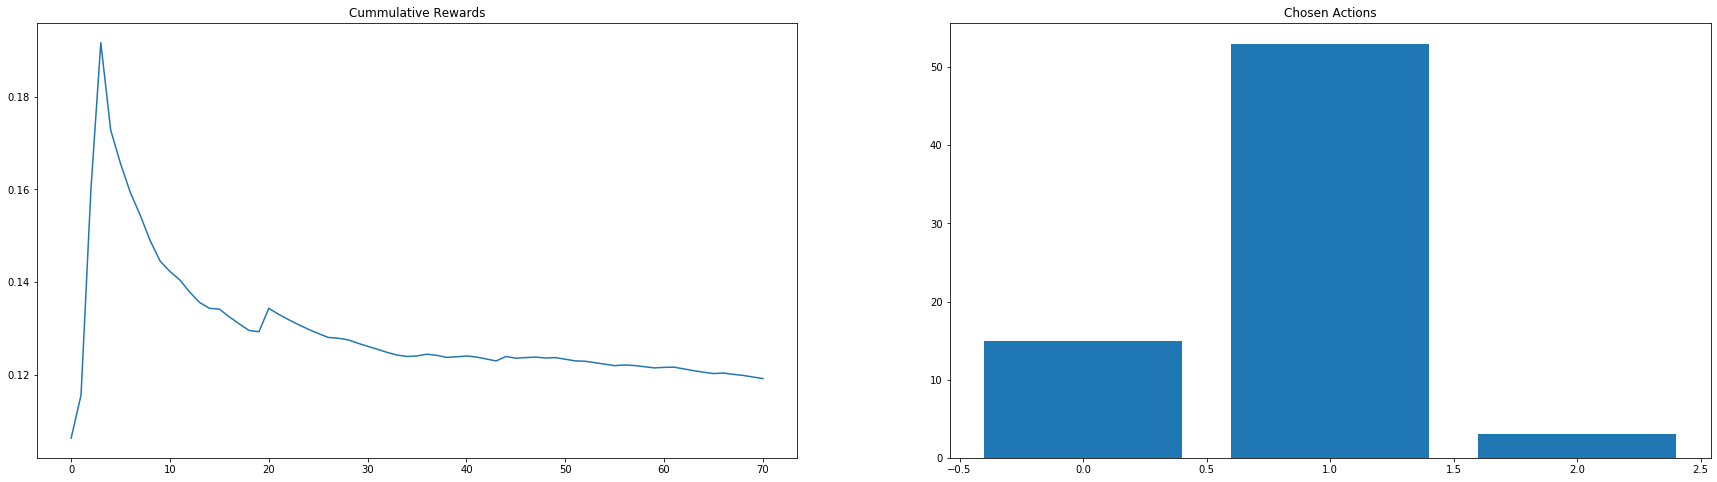

Restart at iteration: 417
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1028536903905625, 'merge_sort': 0.11552188181667589, 'heap_sort': 0.23254946667293552}
Count per chosen algo {'quick_sort': 333, 'merge_sort': 11, 'heap_sort': 3}


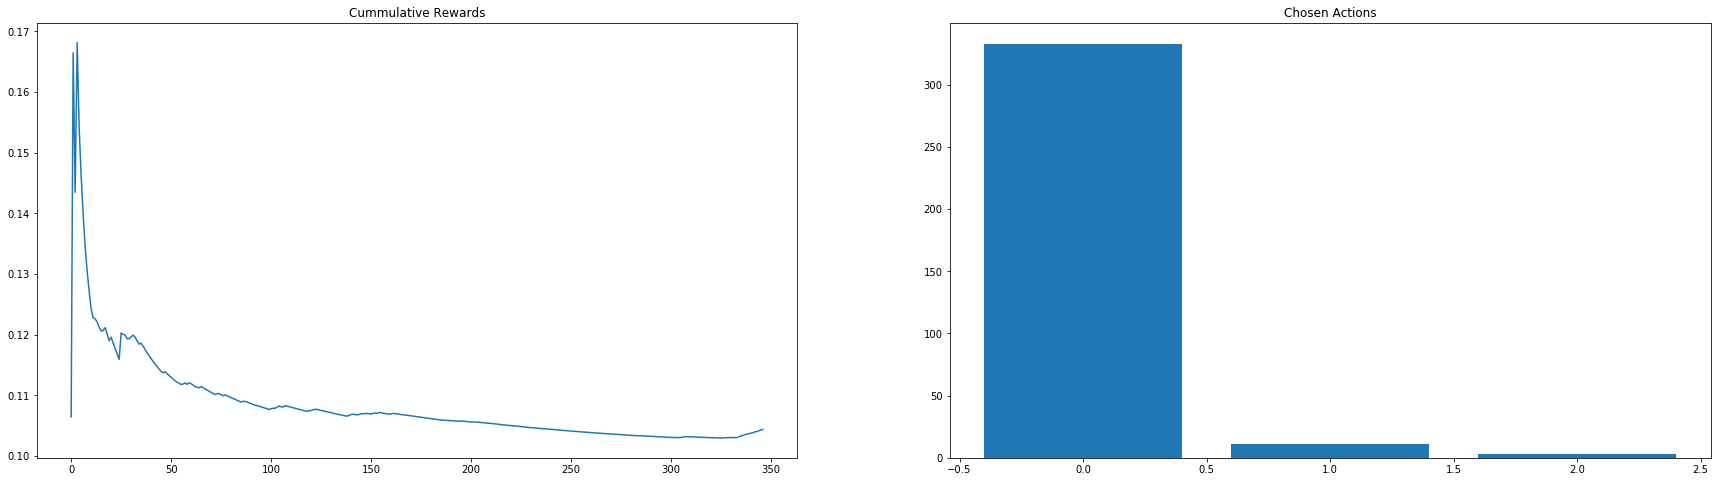

Restart at iteration: 477
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1061175145444312, 'merge_sort': 0.12881109999580076, 'heap_sort': 0.2541672333269768}
Count per chosen algo {'quick_sort': 55, 'merge_sort': 2, 'heap_sort': 3}


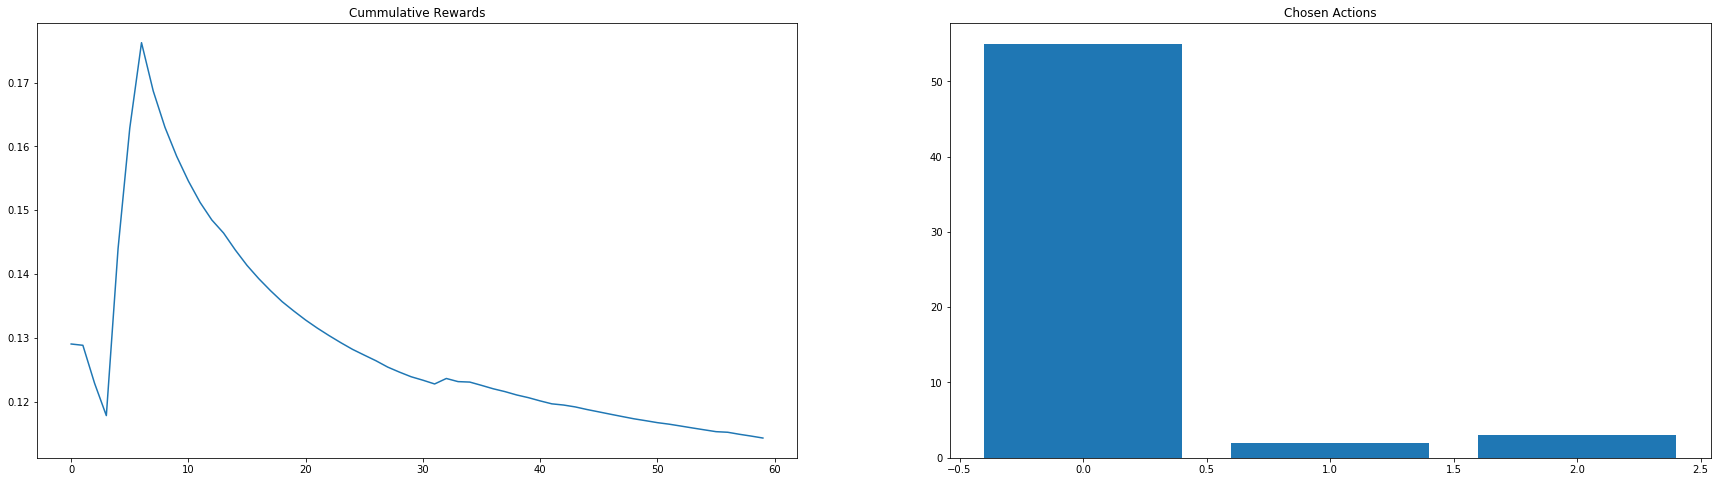

Restart at iteration: 500
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.09502882222376582, 'merge_sort': 0.10621929999615531, 'heap_sort': 0.22050195000338135}
Count per chosen algo {'quick_sort': 18, 'merge_sort': 3, 'heap_sort': 2}


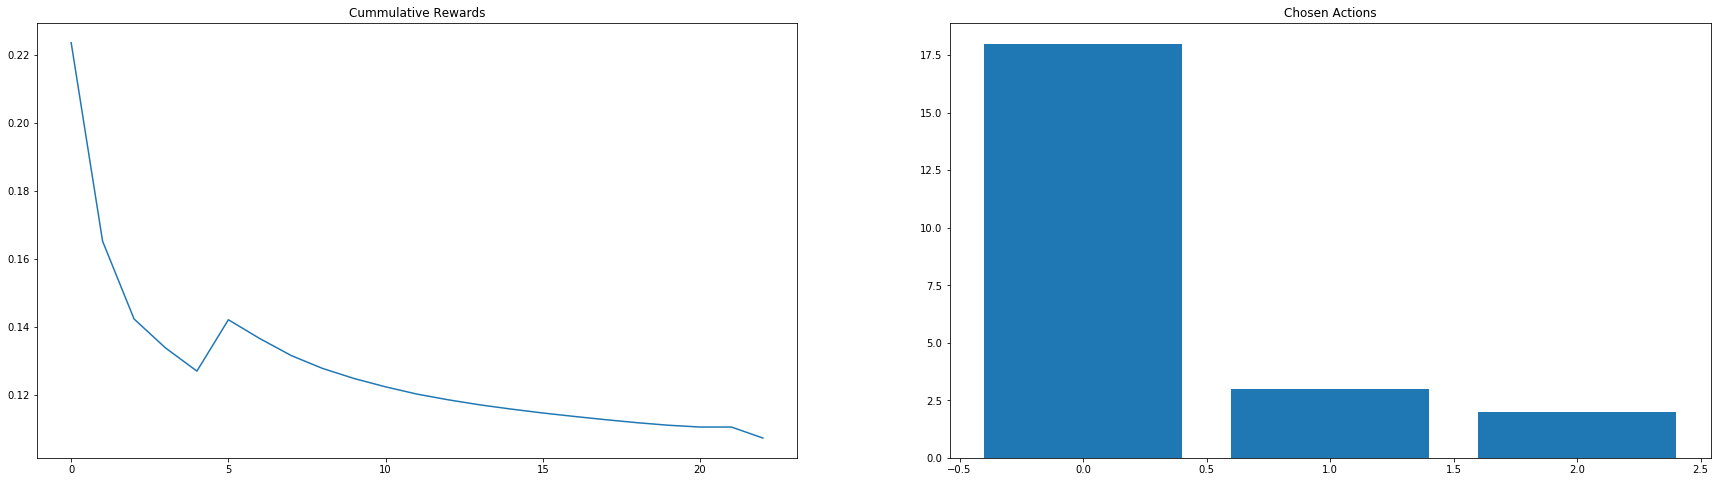

Restart at iteration: 736
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03812347142957151, 'merge_sort': 0.02866300711117219, 'heap_sort': 0.08154912500322098}
Count per chosen algo {'quick_sort': 7, 'merge_sort': 225, 'heap_sort': 4}


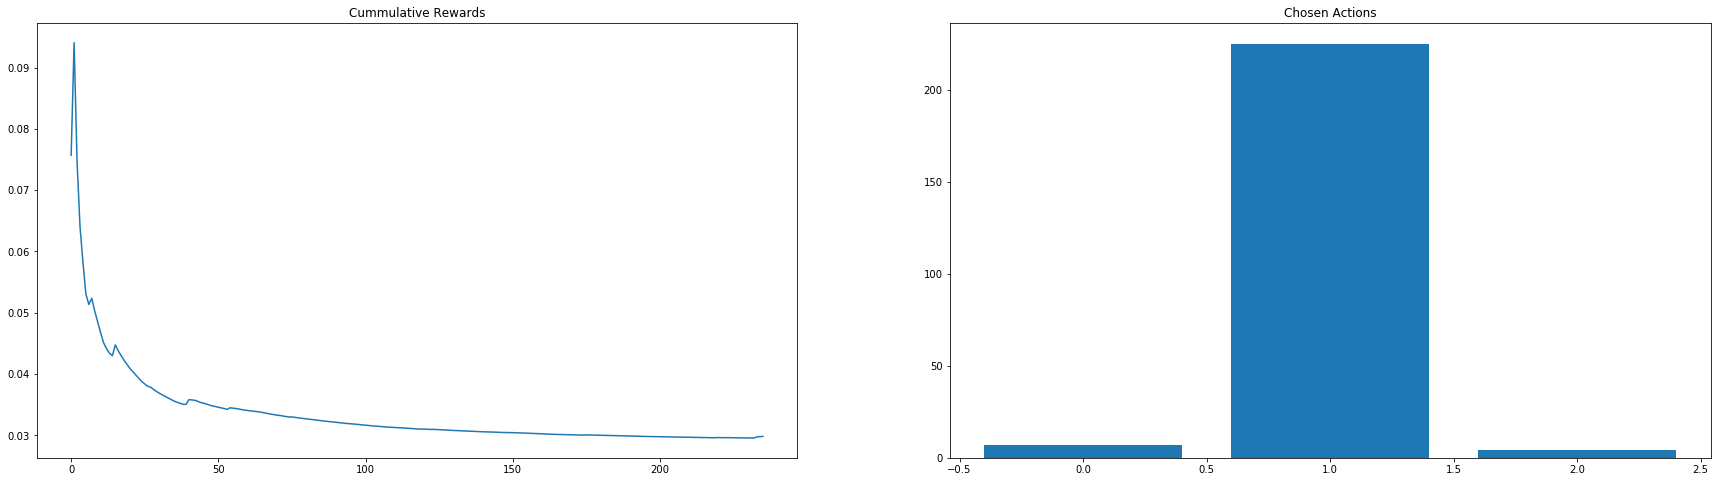

Restart at iteration: 1001
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.044345720004639586, 'merge_sort': 0.028648841797235036, 'heap_sort': 0.09871724999538856}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 256, 'heap_sort': 4}


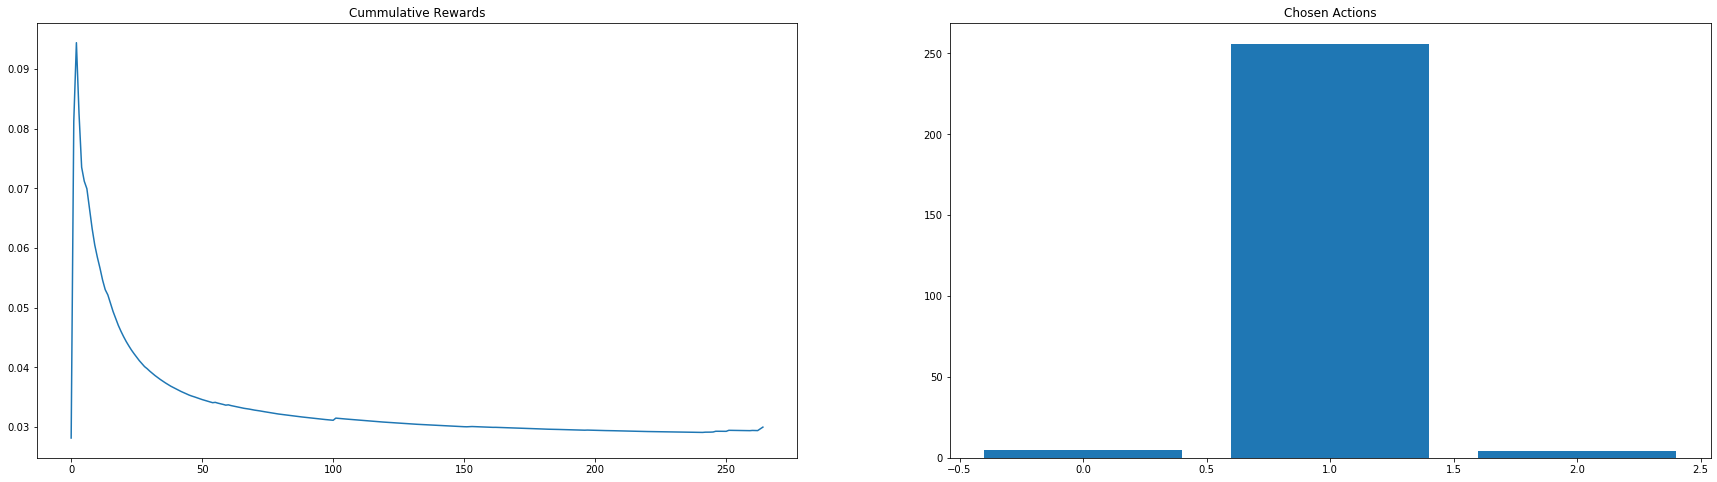

Restart at iteration: 1421
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.1041444076116767, 'merge_sort': 0.11415686944544884, 'heap_sort': 0.23615349999939403}
Count per chosen algo {'quick_sort': 381, 'merge_sort': 36, 'heap_sort': 3}


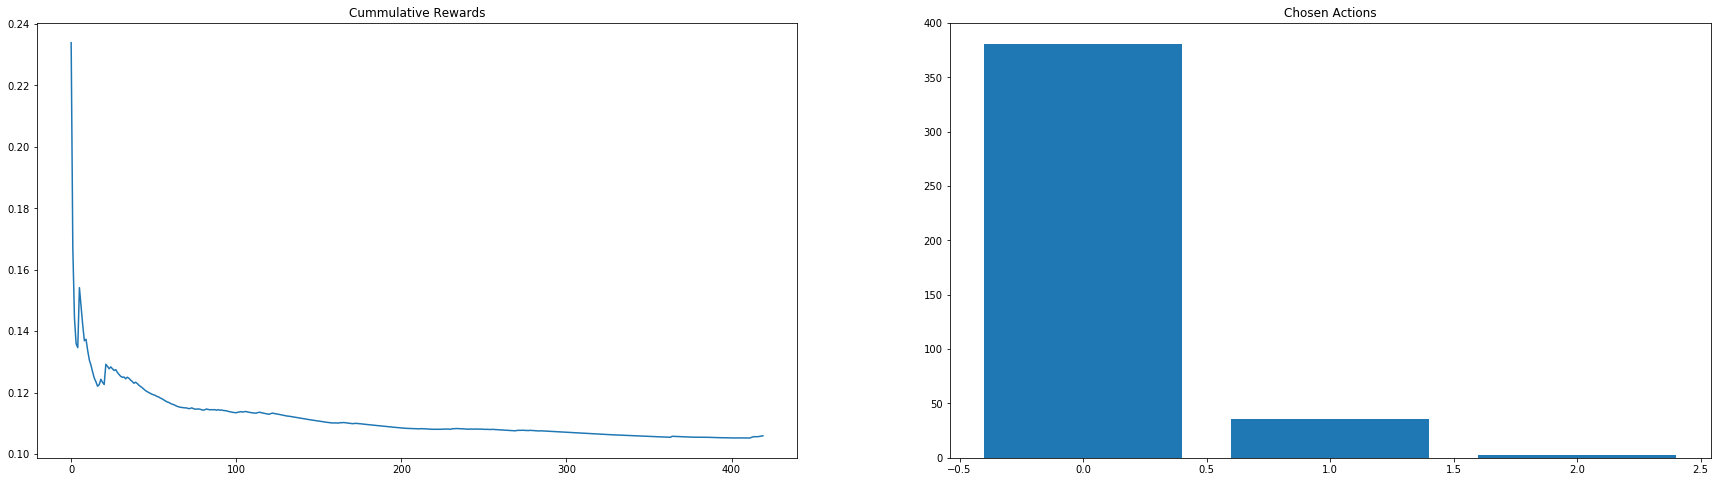

Restart at iteration: 1445
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.14131950000249643, 'merge_sort': 0.19786552500227117, 'heap_sort': 0.355680500001957}
Count per chosen algo {'quick_sort': 17, 'merge_sort': 4, 'heap_sort': 3}


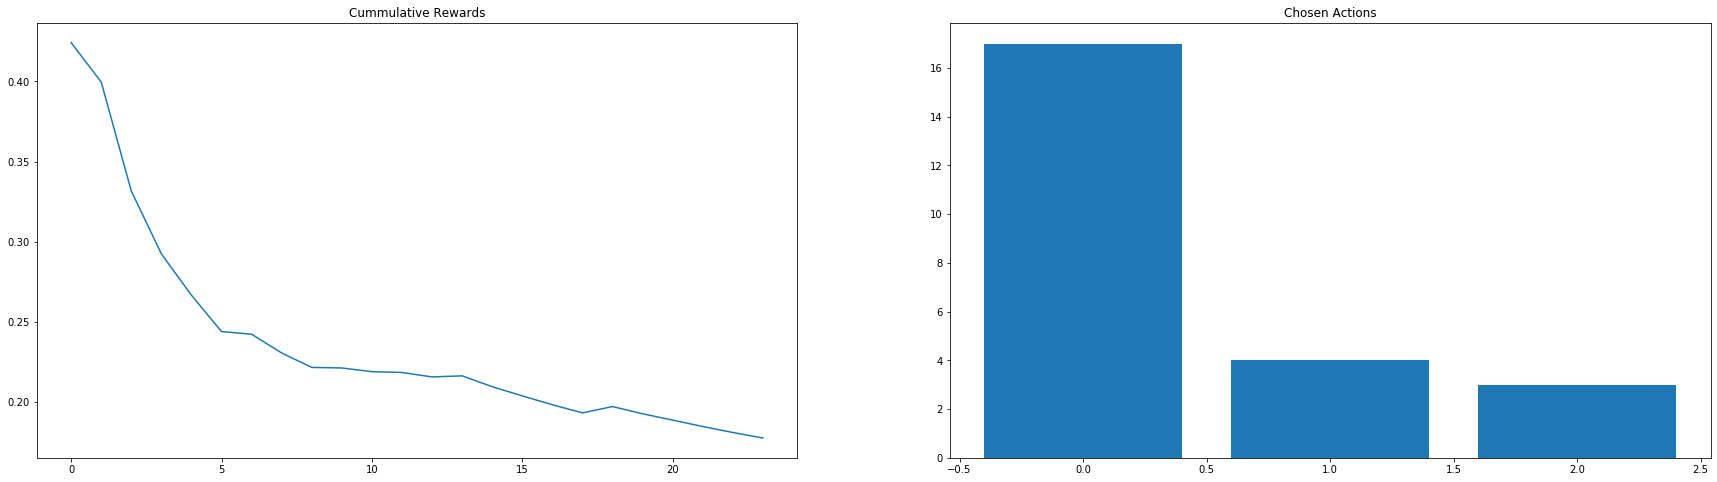

Restart at iteration: 1500
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.11291108260838487, 'merge_sort': 0.13055521428343905, 'heap_sort': 0.24113349999970524}
Count per chosen algo {'quick_sort': 46, 'merge_sort': 7, 'heap_sort': 2}


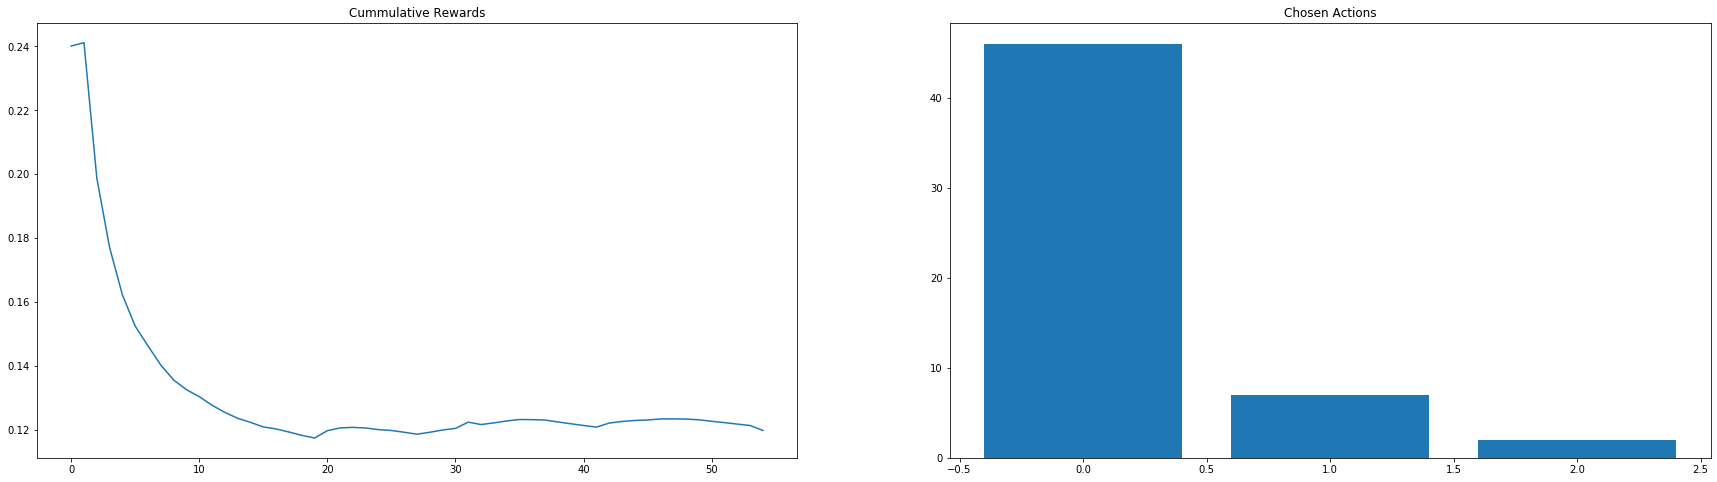

Restart at iteration: 1584
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04122183750041586, 'merge_sort': 0.03678446301328471, 'heap_sort': 0.0793404666716621}
Count per chosen algo {'quick_sort': 8, 'merge_sort': 73, 'heap_sort': 3}


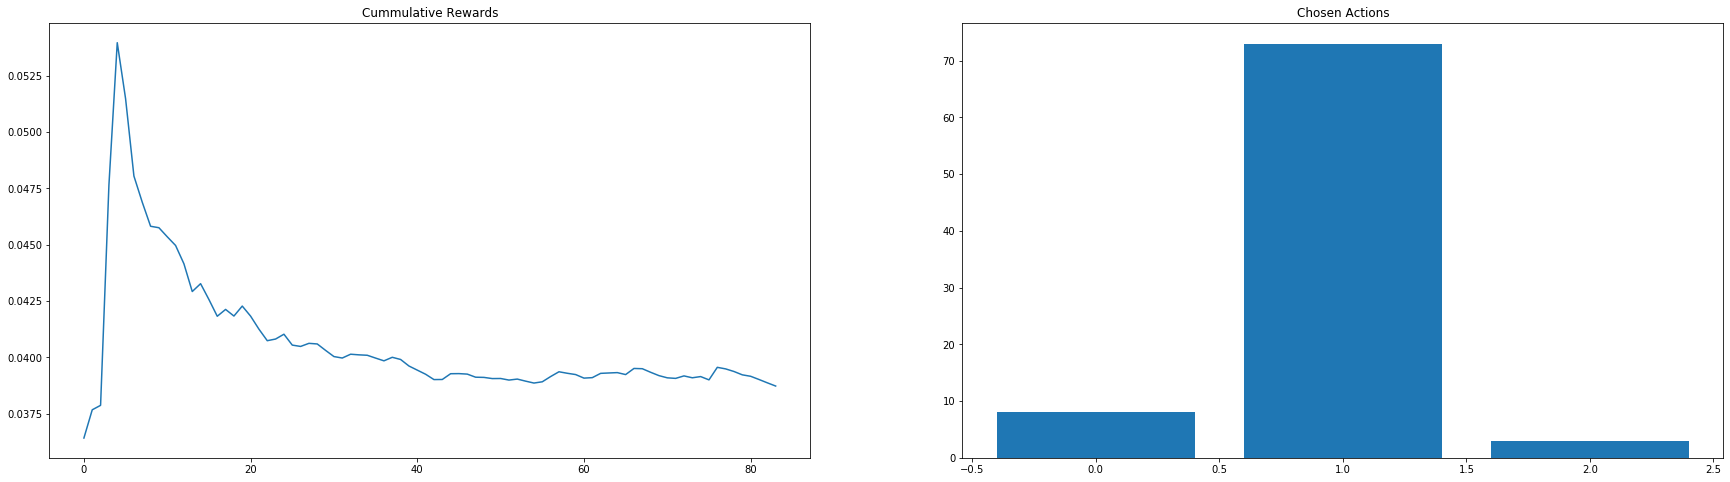

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03743369999938295, 'merge_sort': 0.028891057946177287, 'heap_sort': 0.07351740000012796}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 409, 'heap_sort': 2}


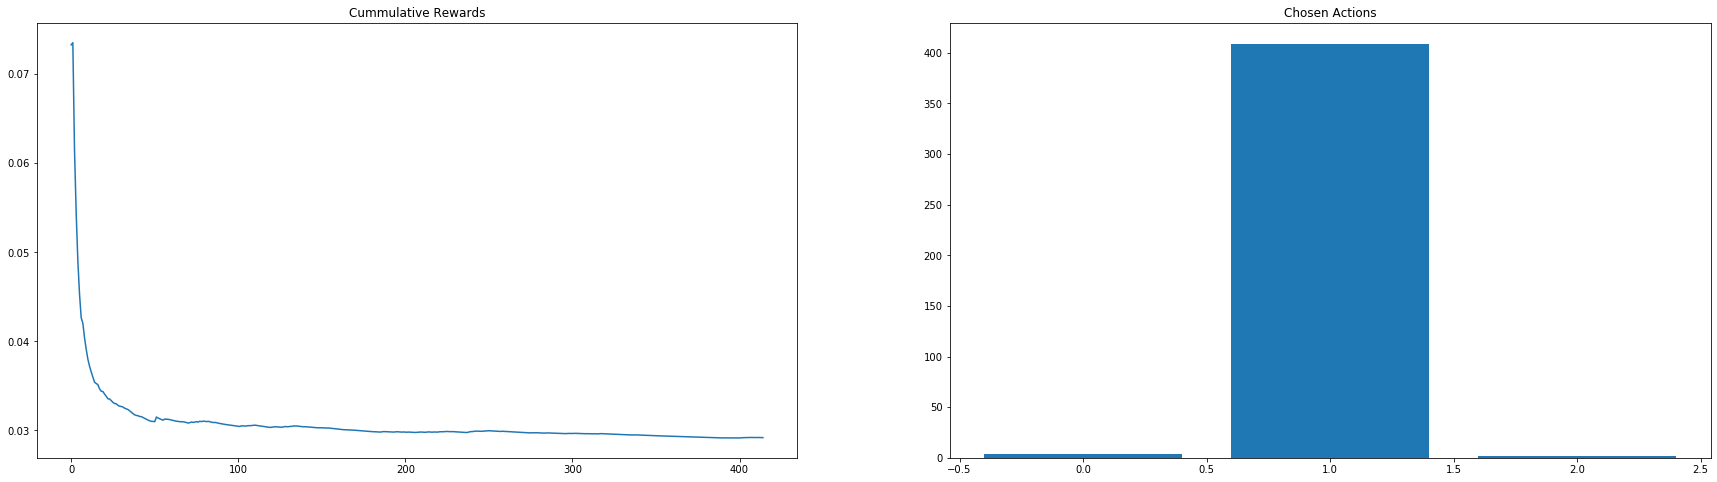

Total reward 139.7159


In [37]:
for elem in list_iteration_results_3:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_3,4))

## Four outliers in a row restart the expriment

In [38]:
list_iteration_results_4, total_reward_4, arm_rewards_4 = ts_quantile(list_distributions, n_samples, num_consec_elem=4)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.013423844522753636
Less than two values for merge_sort
merge_sort Theta 0.05292407865672492
Less than two values for heap_sort
heap_sort Theta 0.025876559569717673


Chosen algorithm is:  quick_sort with reward: 0.10326019999047276
Sample mean is:  0.10326019999047276 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.06415301560942532
Less than two values for merge_sort
merge_sort Theta 0.020267438769895244
Less than two values for heap_sort
heap_sort Theta 0.07184058849477236


Chosen algorithm is:  merge_sort with reward: 0.10926409999956377
Sample mean is:  0.10926409999956377 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.02938355000671854
Less than two values for merge_sort
merge_sort Theta 0.06891830389455549
Less than two values for heap_sort
heap_sort Theta 0.012070026464259831


Chosen algorithm is:  heap_sort with rew


Chosen algorithm is:  quick_sort with reward: 0.12271870000404306
Sample mean is:  0.11638406250131084 Sample variance is: 0.0009436559693884337


Iteration: 29
quick_sort Theta 0.12430236355579434
merge_sort Theta 0.11985461219290414
heap_sort Theta 0.2391655604043841


Chosen algorithm is:  merge_sort with reward: 0.10711070000252221
Sample mean is:  0.11711872727292674 Sample variance is: 0.00016021310475998097


Iteration: 30
quick_sort Theta 0.12862446475984876
merge_sort Theta 0.11299009328947276
heap_sort Theta 0.2344672377255868


Chosen algorithm is:  merge_sort with reward: 0.1046280000009574
Sample mean is:  0.11607783333359596 Sample variance is: 0.00015878007481894024


Iteration: 31
quick_sort Theta 0.11469518789351749
merge_sort Theta 0.11916422273680027
heap_sort Theta 0.23691551235959687


Chosen algorithm is:  quick_sort with reward: 0.11178549999021925
Sample mean is:  0.11611355882418781 Sample variance is: 0.0008893175505479191


Iteration: 32
quick_sort Theta 0.1



Chosen algorithm is:  quick_sort with reward: 0.0985303999914322
Sample mean is:  0.10923911052553817 Sample variance is: 0.0005083363011616985


Iteration: 60
quick_sort Theta 0.10928389283273558
merge_sort Theta 0.12195700957935107
heap_sort Theta 0.24092389250402196


Chosen algorithm is:  quick_sort with reward: 0.09704379999311641
Sample mean is:  0.10892641025547607 Sample variance is: 0.0004990177324674296


Iteration: 61
quick_sort Theta 0.10455408962919845
merge_sort Theta 0.12311475917666913
heap_sort Theta 0.23186609616691467


Chosen algorithm is:  quick_sort with reward: 0.09913740000047255
Sample mean is:  0.10868168499910098 Sample variance is: 0.0004888780167489503


Iteration: 62
quick_sort Theta 0.11238147819969156
merge_sort Theta 0.12159890700149781
heap_sort Theta 0.23370304208908335


Chosen algorithm is:  quick_sort with reward: 0.09874960000161082
Sample mean is:  0.10843943902355244 Sample variance is: 0.0004793014871886812


Iteration: 63
quick_sort Theta 0.



Iteration: 91
quick_sort Theta 0.11243927135569312
merge_sort Theta 0.1206524196435774
heap_sort Theta 0.21774623620677144


Chosen algorithm is:  quick_sort with reward: 0.0974922999885166
Sample mean is:  0.10885030144772431 Sample variance is: 0.0003262388525292246


Iteration: 92
quick_sort Theta 0.10840049366601494
merge_sort Theta 0.12213925652733311
heap_sort Theta 0.22873291479226746


Chosen algorithm is:  quick_sort with reward: 0.12059009999211412
Sample mean is:  0.10901801285550132 Sample variance is: 0.0003235190685176922


Iteration: 93
quick_sort Theta 0.10711281368905873
merge_sort Theta 0.11370017891491851
heap_sort Theta 0.23463464734439368


Chosen algorithm is:  quick_sort with reward: 0.103051999991294
Sample mean is:  0.10893398450530122 Sample variance is: 0.00031945671537346606


Iteration: 94
quick_sort Theta 0.11229531828301687
merge_sort Theta 0.11815271691265061
heap_sort Theta 0.24158105231929775


Chosen algorithm is:  quick_sort with reward: 0.10884860



Chosen algorithm is:  quick_sort with reward: 0.10043540000333451
Sample mean is:  0.10785027575662072 Sample variance is: 0.00024845099593790067


Iteration: 122
quick_sort Theta 0.10916883005807275
merge_sort Theta 0.1176054818980883
heap_sort Theta 0.2248049861471364


Chosen algorithm is:  quick_sort with reward: 0.10919960000319406
Sample mean is:  0.10786376899908647 Sample variance is: 0.00024598451067015334


Iteration: 123
quick_sort Theta 0.1095275440462055
merge_sort Theta 0.11712590882977612
heap_sort Theta 0.32439357108571465


Chosen algorithm is:  quick_sort with reward: 0.10578529999474995
Sample mean is:  0.10784319009805343 Sample variance is: 0.00024359136958227107


Iteration: 124
quick_sort Theta 0.10902073322794917
merge_sort Theta 0.11685891185579968
heap_sort Theta 0.24483510840502204


Chosen algorithm is:  quick_sort with reward: 0.11164209998969454
Sample mean is:  0.10788043431267735 Sample variance is: 0.00024134331918391022


Iteration: 125
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09967319999122992
Sample mean is:  0.1069737730761587 Sample variance is: 0.00019922071357532866


Iteration: 153
quick_sort Theta 0.10833658028665465
merge_sort Theta 0.12041677702864423
heap_sort Theta 0.22178351090573575


Chosen algorithm is:  quick_sort with reward: 0.09920249998685904
Sample mean is:  0.10691445038082054 Sample variance is: 0.00019815743845309416


Iteration: 154
quick_sort Theta 0.108812469869234
merge_sort Theta 0.11700199840505959
heap_sort Theta 0.24019427063833187


Chosen algorithm is:  quick_sort with reward: 0.10836110000673216
Sample mean is:  0.1069254098476835 Sample variance is: 0.000196671980136264


Iteration: 155
quick_sort Theta 0.10977592006805631
merge_sort Theta 0.11530236336773615
heap_sort Theta 0.22398043213154326


Chosen algorithm is:  quick_sort with reward: 0.11245090000738855
Sample mean is:  0.10696695488647827 Sample variance is: 0.00019542107415630673


Iteration: 156
quick_sort Theta


Chosen algorithm is:  quick_sort with reward: 0.11499400000320747
Sample mean is:  0.10701331312448019 Sample variance is: 0.0001772311489006394


Iteration: 183
quick_sort Theta 0.1060617381318743
merge_sort Theta 0.12064904557358268
heap_sort Theta 0.2467911511940982


Chosen algorithm is:  quick_sort with reward: 0.10006349999457598
Sample mean is:  0.10697014658330066 Sample variance is: 0.00017642847035557907


Iteration: 184
quick_sort Theta 0.1076354669633267
merge_sort Theta 0.11841285673945057
heap_sort Theta 0.2353101664371307


Chosen algorithm is:  quick_sort with reward: 0.10160840000025928
Sample mean is:  0.10693704938217077 Sample variance is: 0.00017551576910409828


Iteration: 185
quick_sort Theta 0.10671562871869078
merge_sort Theta 0.12361480064570658
heap_sort Theta 0.22528927777785993


Chosen algorithm is:  quick_sort with reward: 0.09850659999938216
Sample mean is:  0.1068853288338101 Sample variance is: 0.00017487233769444588


Iteration: 186
quick_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.10080129999550991
Sample mean is:  0.10633714631556741 Sample variance is: 0.00015567464900731405


Iteration: 213
quick_sort Theta 0.10497073909980334
merge_sort Theta 0.12201307353233584
heap_sort Theta 0.2383207355450676


Chosen algorithm is:  quick_sort with reward: 0.13179010000021663
Sample mean is:  0.10647040785318337 Sample variance is: 0.00015823373959642761


Iteration: 214
quick_sort Theta 0.10677997141180215
merge_sort Theta 0.12270844456513026
heap_sort Theta 0.2323364939104276


Chosen algorithm is:  quick_sort with reward: 0.09724930000083987
Sample mean is:  0.10642238124978576 Sample variance is: 0.00015785015747110686


Iteration: 215
quick_sort Theta 0.10623867013077218
merge_sort Theta 0.1149816671974153
heap_sort Theta 0.23149641226990025


Chosen algorithm is:  quick_sort with reward: 0.10183479999250267
Sample mean is:  0.10639861139871175 Sample variance is: 0.00015714076212498143


Iteration: 216
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09863749999203719
Sample mean is:  0.10652132081432843 Sample variance is: 0.00015589640944118559


Iteration: 244
quick_sort Theta 0.10676733786000661
merge_sort Theta 0.11735364537011596
heap_sort Theta 0.22458563263070175


Chosen algorithm is:  quick_sort with reward: 0.12523910000163596
Sample mean is:  0.10660563513499198 Sample variance is: 0.00015676524129446085


Iteration: 245
quick_sort Theta 0.10561027538131076
merge_sort Theta 0.11438882291769539
heap_sort Theta 0.23468260588982004


Chosen algorithm is:  quick_sort with reward: 0.10431779999635182
Sample mean is:  0.10659537578459449 Sample variance is: 0.00015608562459771107


Iteration: 246
quick_sort Theta 0.10632239989399905
merge_sort Theta 0.1196543578915502
heap_sort Theta 0.22937840623965877


Chosen algorithm is:  quick_sort with reward: 0.10071909999533091
Sample mean is:  0.10656914241053528 Sample variance is: 0.00015554228012455443


Iteration: 247
quick_sort 


Chosen algorithm is:  quick_sort with reward: 0.1286277000035625
Sample mean is:  0.10804473187242666 Sample variance is: 0.00020204575638464048


Iteration: 274
quick_sort Theta 0.10755978052690378
merge_sort Theta 0.11907548121546216
heap_sort Theta 0.27159871735157615


Chosen algorithm is:  quick_sort with reward: 0.09937830000126269
Sample mean is:  0.10801034126976332 Sample variance is: 0.00020154084861153691


Iteration: 275
quick_sort Theta 0.10821910682913619
merge_sort Theta 0.11920071642602231
heap_sort Theta 0.2403500640706263


Chosen algorithm is:  quick_sort with reward: 0.13408419999177568
Sample mean is:  0.10811339999988984 Sample variance is: 0.00020342076213436116


Iteration: 276
quick_sort Theta 0.10737624760502096
merge_sort Theta 0.12148224378788744
heap_sort Theta 0.24940205704023738


Chosen algorithm is:  quick_sort with reward: 0.10474009999597911
Sample mean is:  0.10810011929121303 Sample variance is: 0.00020266451642950834


Iteration: 277
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09939079999458045
Sample mean is:  0.10730662597839437 Sample variance is: 0.0001926736512224477


Iteration: 304
quick_sort Theta 0.10785319999137098
merge_sort Theta 0.11622576810143886
heap_sort Theta 0.2401330548173734


Chosen algorithm is:  quick_sort with reward: 0.0979380999924615
Sample mean is:  0.10727340425504 Sample variance is: 0.000192300546220136


Iteration: 305
quick_sort Theta 0.10711187396944653
merge_sort Theta 0.11890856435210939
heap_sort Theta 0.23041850638333167


Chosen algorithm is:  quick_sort with reward: 0.09594129999459255
Sample mean is:  0.10723336148380166 Sample variance is: 0.00019207320442469775


Iteration: 306
quick_sort Theta 0.10849852482028946
merge_sort Theta 0.1179099505712601
heap_sort Theta 0.2297946430143093


Chosen algorithm is:  quick_sort with reward: 0.10445710000931285
Sample mean is:  0.10722358591522953 Sample variance is: 0.00019142393429728795


Iteration: 307
quick_sort Theta 0.1



Chosen algorithm is:  quick_sort with reward: 0.099517199996626
Sample mean is:  0.10778178621759975 Sample variance is: 0.00022664175794117377


Iteration: 335
quick_sort Theta 0.10823804571406481
merge_sort Theta 0.11818228283097294
heap_sort Theta 0.2865966078160017


Chosen algorithm is:  quick_sort with reward: 0.09791229999973439
Sample mean is:  0.10775025431275034 Sample variance is: 0.00022622787230719023


Iteration: 336
quick_sort Theta 0.10746569878611478
merge_sort Theta 0.11733292157043701
heap_sort Theta 0.23346974861359807


Chosen algorithm is:  quick_sort with reward: 0.09850249999726657
Sample mean is:  0.10772080286588574 Sample variance is: 0.0002257788937333925


Iteration: 337
quick_sort Theta 0.10987982261574011
merge_sort Theta 0.12193936684433188
heap_sort Theta 0.23623860496594126


Chosen algorithm is:  quick_sort with reward: 0.09838110000418965
Sample mean is:  0.10769115301553116 Sample variance is: 0.00022533817701916764


Iteration: 338
quick_sort The



Chosen algorithm is:  quick_sort with reward: 0.14104899999802
Sample mean is:  0.10843764664685868 Sample variance is: 0.00026639875648751325


Iteration: 366
quick_sort Theta 0.10846553865908026
merge_sort Theta 0.11910137857457796
heap_sort Theta 0.21390429311000442


Chosen algorithm is:  quick_sort with reward: 0.13241500000003725
Sample mean is:  0.1085073482554435 Sample variance is: 0.0002672907432818078


Iteration: 367
quick_sort Theta 0.10908323178673633
merge_sort Theta 0.1185589214128351
heap_sort Theta 0.23232556102711294


Chosen algorithm is:  quick_sort with reward: 0.09594810000271536
Sample mean is:  0.10847094463731966 Sample variance is: 0.00026697186435808187


Iteration: 368
quick_sort Theta 0.10787516834858879
merge_sort Theta 0.11827229013675682
heap_sort Theta 0.2374794613492538


Chosen algorithm is:  quick_sort with reward: 0.1013636999996379
Sample mean is:  0.10845040346784658 Sample variance is: 0.0002663458385513338


Iteration: 369
quick_sort Theta 0.



Iteration: 396
quick_sort Theta 0.11020731150590482
merge_sort Theta 0.11736666049884932
heap_sort Theta 0.22818369513452016


Chosen algorithm is:  quick_sort with reward: 0.11522810001042672
Sample mean is:  0.10893365427785376 Sample variance is: 0.00027531165365483586


Iteration: 397
quick_sort Theta 0.10832874358494853
merge_sort Theta 0.11828924905142117
heap_sort Theta 0.23400194976773886


Chosen algorithm is:  quick_sort with reward: 0.107857499999227
Sample mean is:  0.10893078453311075 Sample variance is: 0.00027458056929773847


Iteration: 398
quick_sort Theta 0.11013002329669465
merge_sort Theta 0.11798910200013486
heap_sort Theta 0.21316812395925727


Chosen algorithm is:  quick_sort with reward: 0.11353370000142604
Sample mean is:  0.10894302632956904 Sample variance is: 0.00027390649991889917


Iteration: 399
quick_sort Theta 0.10956680790041667
merge_sort Theta 0.11963286616840785
heap_sort Theta 0.24110601542950408


Chosen algorithm is:  quick_sort with reward: 0.


Chosen algorithm is:  quick_sort with reward: 0.11733099998673424
Sample mean is:  0.10889002722755736 Sample variance is: 0.0002579199465735475


Iteration: 427
quick_sort Theta 0.10892968879955753
merge_sort Theta 0.11584282495998238
heap_sort Theta 0.233945777671164


Chosen algorithm is:  quick_sort with reward: 0.10092409999924712
Sample mean is:  0.10887035827143808 Sample variance is: 0.0002574394018045601


Iteration: 428
quick_sort Theta 0.11003188635907778
merge_sort Theta 0.11907931857161544
heap_sort Theta 0.23386564961948433


Chosen algorithm is:  quick_sort with reward: 0.10380430000077467
Sample mean is:  0.10885788029540196 Sample variance is: 0.00025686837306181006


Iteration: 429
quick_sort Theta 0.10888708370638288
merge_sort Theta 0.12125849239252003
heap_sort Theta 0.23992103473567836


Chosen algorithm is:  quick_sort with reward: 0.1144001000066055
Sample mean is:  0.10887149754284964 Sample variance is: 0.00025631253118585975


Iteration: 430
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.13019389999681152
Sample mean is:  0.1088485574711719 Sample variance is: 0.0002446936509530681


Iteration: 458
quick_sort Theta 0.10900212488997787
merge_sort Theta 0.11786769365400633
heap_sort Theta 0.23179920001720947


Chosen algorithm is:  quick_sort with reward: 0.09506989999499638
Sample mean is:  0.10881695504576783 Sample variance is: 0.00024456686726476


Iteration: 459
quick_sort Theta 0.10888424697411328
merge_sort Theta 0.11830020287774527
heap_sort Theta 0.23653153763660556


Chosen algorithm is:  quick_sort with reward: 0.105103699999745
Sample mean is:  0.10880845789463277 Sample variance is: 0.00024403869757067006


Iteration: 460
quick_sort Theta 0.10848529939429533
merge_sort Theta 0.1199273680525207
heap_sort Theta 0.2352894473224441


Chosen algorithm is:  quick_sort with reward: 0.1000927999994019
Sample mean is:  0.10878855913231489 Sample variance is: 0.00024365456643864072


Iteration: 461
quick_sort Theta 0.1



Chosen algorithm is:  quick_sort with reward: 0.09801420000439975
Sample mean is:  0.10822481397837926 Sample variance is: 0.00023490016051780672


Iteration: 488
quick_sort Theta 0.10677935558903137
merge_sort Theta 0.11870091020607898
heap_sort Theta 0.22820555683670954


Chosen algorithm is:  quick_sort with reward: 0.11117560000275262
Sample mean is:  0.10823114613722985 Sample variance is: 0.00023441472766973372


Iteration: 489
quick_sort Theta 0.10864498335036313
merge_sort Theta 0.1202596895003007
heap_sort Theta 0.22271083450530135


Chosen algorithm is:  quick_sort with reward: 0.09911320000537671
Sample mean is:  0.10821162162731153 Sample variance is: 0.00023409041116130536


Iteration: 490
quick_sort Theta 0.10788950078480242
merge_sort Theta 0.11485430893994784
heap_sort Theta 0.23730356522998844


Chosen algorithm is:  quick_sort with reward: 0.09920910000801086
Sample mean is:  0.10819238547000534 Sample variance is: 0.00023376302186733667


Iteration: 491
quick_sort 



Iteration: 516
quick_sort Theta 0.03361532225724685
merge_sort Theta 0.0277649154802413
heap_sort Theta 0.06747583633741577


Chosen algorithm is:  merge_sort with reward: 0.027975999997579493
Sample mean is:  0.02791678888833202 Sample variance is: 1.005637801473787e-06


Iteration: 517
quick_sort Theta 0.03355124829829931
merge_sort Theta 0.027773628861201605
heap_sort Theta 0.06750838615542884


Chosen algorithm is:  merge_sort with reward: 0.026149199999053963
Sample mean is:  0.027740029999404215 Sample variance is: 1.1862673646613398e-06


Iteration: 518
quick_sort Theta 0.033557387454564415
merge_sort Theta 0.027743171184555764
heap_sort Theta 0.06753818564500803


Chosen algorithm is:  merge_sort with reward: 0.026098900008946657
Sample mean is:  0.027590836363908074 Sample variance is: 1.3010122856904099e-06


Iteration: 519
quick_sort Theta 0.03358665806755863
merge_sort Theta 0.027493386983110064
heap_sort Theta 0.06768994910205166


Chosen algorithm is:  merge_sort with r



Iteration: 546
quick_sort Theta 0.033604568257261956
merge_sort Theta 0.027534889916371985
heap_sort Theta 0.06730139522524115


Chosen algorithm is:  merge_sort with reward: 0.03036600000632461
Sample mean is:  0.027570823078769117 Sample variance is: 8.864101477562246e-07


Iteration: 547
quick_sort Theta 0.033592460047887095
merge_sort Theta 0.02760047317824303
heap_sort Theta 0.06738570903802482


Chosen algorithm is:  merge_sort with reward: 0.02687560000049416
Sample mean is:  0.027553442501812242 Sample variance is: 8.76031187821118e-07


Iteration: 548
quick_sort Theta 0.033559994266932125
merge_sort Theta 0.027493630582659884
heap_sort Theta 0.06785123908066198


Chosen algorithm is:  merge_sort with reward: 0.027578100009122863
Sample mean is:  0.027554043904429573 Sample variance is: 8.54679040888343e-07


Iteration: 549
quick_sort Theta 0.03355353052459405
merge_sort Theta 0.02745905449279118
heap_sort Theta 0.06746274932781912


Chosen algorithm is:  merge_sort with rewa



Iteration: 576
quick_sort Theta 0.03354793746518353
merge_sort Theta 0.027467176422501495
heap_sort Theta 0.06718499495740952


Chosen algorithm is:  merge_sort with reward: 0.029808300008880906
Sample mean is:  0.02745318550813059 Sample variance is: 7.250548138518281e-07


Iteration: 577
quick_sort Theta 0.03356282106439593
merge_sort Theta 0.02754436491853917
heap_sort Theta 0.06697681223299566


Chosen algorithm is:  merge_sort with reward: 0.027349899988621473
Sample mean is:  0.02745171000070903 Sample variance is: 7.148471093680835e-07


Iteration: 578
quick_sort Theta 0.03358475514154533
merge_sort Theta 0.02755431170069561
heap_sort Theta 0.06752035170270619


Chosen algorithm is:  merge_sort with reward: 0.027536000008694828
Sample mean is:  0.0274528971839201 Sample variance is: 7.048774985004189e-07


Iteration: 579
quick_sort Theta 0.033556316027765945
merge_sort Theta 0.027326886884644064
heap_sort Theta 0.0676574596033839


Chosen algorithm is:  merge_sort with reward:



Iteration: 606
quick_sort Theta 0.033563587517297634
merge_sort Theta 0.027322677692444258
heap_sort Theta 0.0710551519154966


Chosen algorithm is:  merge_sort with reward: 0.02689799999643583
Sample mean is:  0.02735227373789648 Sample variance is: 6.358313676564196e-07


Iteration: 607
quick_sort Theta 0.03359786257399556
merge_sort Theta 0.027352551857141107
heap_sort Theta 0.0675561176503724


Chosen algorithm is:  merge_sort with reward: 0.026493499986827374
Sample mean is:  0.027343686000385788 Sample variance is: 6.367742282995558e-07


Iteration: 608
quick_sort Theta 0.033510680310184095
merge_sort Theta 0.027407023820474302
heap_sort Theta 0.06767716653896538


Chosen algorithm is:  merge_sort with reward: 0.028318299999227747
Sample mean is:  0.02735333564393868 Sample variance is: 6.397810950396418e-07


Iteration: 609
quick_sort Theta 0.033566965698655825
merge_sort Theta 0.027425604869451822
heap_sort Theta 0.07080435486970438


Chosen algorithm is:  merge_sort with rew



Iteration: 636
quick_sort Theta 0.03356623843105499
merge_sort Theta 0.027265576349515826
heap_sort Theta 0.06778241772457481


Chosen algorithm is:  merge_sort with reward: 0.02796140000282321
Sample mean is:  0.027341189147528196 Sample variance is: 6.287726029187968e-07


Iteration: 637
quick_sort Theta 0.033590494053024514
merge_sort Theta 0.027233870105790446
heap_sort Theta 0.06728991712474502


Chosen algorithm is:  merge_sort with reward: 0.02717309999570716
Sample mean is:  0.027339896154052648 Sample variance is: 6.241515569331393e-07


Iteration: 638
quick_sort Theta 0.03355080146375371
merge_sort Theta 0.02728325149103213
heap_sort Theta 0.0675546203844539


Chosen algorithm is:  merge_sort with reward: 0.026267499997629784
Sample mean is:  0.02733170992385095 Sample variance is: 6.280989086703415e-07


Iteration: 639
quick_sort Theta 0.033586496337097906
merge_sort Theta 0.027338213334000556
heap_sort Theta 0.06764597253744427


Chosen algorithm is:  merge_sort with rewa



Iteration: 666
quick_sort Theta 0.03358791256434627
merge_sort Theta 0.027390744330958432
heap_sort Theta 0.06745356285018038


Chosen algorithm is:  merge_sort with reward: 0.029599699992104433
Sample mean is:  0.027332588679372456 Sample variance is: 6.22619673436902e-07


Iteration: 667
quick_sort Theta 0.033549651341062935
merge_sort Theta 0.027323260311539675
heap_sort Theta 0.06941979736282226


Chosen algorithm is:  merge_sort with reward: 0.02737550000892952
Sample mean is:  0.027332856875182186 Sample variance is: 6.187397371877063e-07


Iteration: 668
quick_sort Theta 0.03359995724194176
merge_sort Theta 0.027423105440354045
heap_sort Theta 0.06764155847807699


Chosen algorithm is:  merge_sort with reward: 0.027700900012860075
Sample mean is:  0.02733514285740379 Sample variance is: 6.157327475848152e-07


Iteration: 669
quick_sort Theta 0.03356435804605995
merge_sort Theta 0.02736681478301278
heap_sort Theta 0.06746402033917757


Chosen algorithm is:  merge_sort with rewa



Iteration: 696
quick_sort Theta 0.03358106776387561
merge_sort Theta 0.027216578484297194
heap_sort Theta 0.06804756842666215


Chosen algorithm is:  merge_sort with reward: 0.028293900002609007
Sample mean is:  0.027313322751772364 Sample variance is: 5.684514465255396e-07


Iteration: 697
quick_sort Theta 0.03360801642380876
merge_sort Theta 0.027342230916131735
heap_sort Theta 0.06766371360465097


Chosen algorithm is:  merge_sort with reward: 0.027319700006046332
Sample mean is:  0.027313356316268543 Sample variance is: 5.654598097297353e-07


Iteration: 698
quick_sort Theta 0.03358064400256032
merge_sort Theta 0.027286443562330155
heap_sort Theta 0.06747821355666253


Chosen algorithm is:  merge_sort with reward: 0.02813130000140518
Sample mean is:  0.027317638743939415 Sample variance is: 5.659837326493936e-07


Iteration: 699
quick_sort Theta 0.03362939490665848
merge_sort Theta 0.027402809009403176
heap_sort Theta 0.06793153450384432


Chosen algorithm is:  merge_sort with re



Iteration: 726
quick_sort Theta 0.03357275518083393
merge_sort Theta 0.027338262444656335
heap_sort Theta 0.0644001532519219


Chosen algorithm is:  merge_sort with reward: 0.028637600000365637
Sample mean is:  0.027301269863478597 Sample variance is: 5.719084627786827e-07


Iteration: 727
quick_sort Theta 0.033600302551063436
merge_sort Theta 0.027331646384172608
heap_sort Theta 0.06726466876752159


Chosen algorithm is:  merge_sort with reward: 0.027022599999327213
Sample mean is:  0.027300003182277908 Sample variance is: 5.69660260253816e-07


Iteration: 728
quick_sort Theta 0.03355851511826666
merge_sort Theta 0.027331472318822464
heap_sort Theta 0.06791955466087414


Chosen algorithm is:  merge_sort with reward: 0.027385599998524413
Sample mean is:  0.027300390498188526 Sample variance is: 5.671156150125893e-07


Iteration: 729
quick_sort Theta 0.03358027173161749
merge_sort Theta 0.027222606295334965
heap_sort Theta 0.06728243412226385


Chosen algorithm is:  merge_sort with re



Iteration: 756
quick_sort Theta 0.03330000570435575
merge_sort Theta 0.027332993906167856
heap_sort Theta 0.06703411433901373


Chosen algorithm is:  merge_sort with reward: 0.028820599996834062
Sample mean is:  0.02729624859483989 Sample variance is: 5.502863998447079e-07


Iteration: 757
quick_sort Theta 0.03355754444434761
merge_sort Theta 0.027279343238947942
heap_sort Theta 0.06560217759473799


Chosen algorithm is:  merge_sort with reward: 0.02642609999747947
Sample mean is:  0.02729276800045045 Sample variance is: 5.511017740339784e-07


Iteration: 758
quick_sort Theta 0.03355513969595707
merge_sort Theta 0.027332223137297787
heap_sort Theta 0.06850428405766586


Chosen algorithm is:  merge_sort with reward: 0.02856700000120327
Sample mean is:  0.027297844621967396 Sample variance is: 5.553491709428069e-07


Iteration: 759
quick_sort Theta 0.03359453222852184
merge_sort Theta 0.027286954744874668
heap_sort Theta 0.06739150781950588


Chosen algorithm is:  merge_sort with rewar



Iteration: 786
quick_sort Theta 0.03359872149020952
merge_sort Theta 0.027378249162705773
heap_sort Theta 0.06807126841583835


Chosen algorithm is:  merge_sort with reward: 0.027510500003700145
Sample mean is:  0.02728940465997222 Sample variance is: 5.395174822960076e-07


Iteration: 787
quick_sort Theta 0.03357657043386036
merge_sort Theta 0.027350293939981455
heap_sort Theta 0.06708312142750959


Chosen algorithm is:  merge_sort with reward: 0.0275376000063261
Sample mean is:  0.027290291071923482 Sample variance is: 5.378098517400594e-07


Iteration: 788
quick_sort Theta 0.03360061872583503
merge_sort Theta 0.02730147734875907
heap_sort Theta 0.06795650755564675


Chosen algorithm is:  merge_sort with reward: 0.027805899997474626
Sample mean is:  0.02729212597913185 Sample variance is: 5.368386653266564e-07


Iteration: 789
quick_sort Theta 0.03360049694250305
merge_sort Theta 0.02729399527940994
heap_sort Theta 0.06729323143654645


Chosen algorithm is:  merge_sort with reward:



Iteration: 816
quick_sort Theta 0.03362017270632638
merge_sort Theta 0.027286213134307243
heap_sort Theta 0.06758716795932758


Chosen algorithm is:  merge_sort with reward: 0.02763810000033118
Sample mean is:  0.027315732039344304 Sample variance is: 6.162793199875881e-07


Iteration: 817
quick_sort Theta 0.03376660836836692
merge_sort Theta 0.02742644843537293
heap_sort Theta 0.0676247876365566


Chosen algorithm is:  merge_sort with reward: 0.027084099987405352
Sample mean is:  0.02731498483917676 Sample variance is: 6.144638393811037e-07


Iteration: 818
quick_sort Theta 0.033523282613879254
merge_sort Theta 0.02730433626166098
heap_sort Theta 0.06736797355434133


Chosen algorithm is:  merge_sort with reward: 0.027970600000116974
Sample mean is:  0.027317092926510973 Sample variance is: 6.138657213935046e-07


Iteration: 819
quick_sort Theta 0.03358730317099333
merge_sort Theta 0.027300566188936025
heap_sort Theta 0.06730412359573433


Chosen algorithm is:  merge_sort with rewar



Iteration: 846
quick_sort Theta 0.03357583998614871
merge_sort Theta 0.02731623431864949
heap_sort Theta 0.0672576157252226


Chosen algorithm is:  merge_sort with reward: 0.02780910000728909
Sample mean is:  0.027319589086025636 Sample variance is: 6.130932621883171e-07


Iteration: 847
quick_sort Theta 0.033596869689930704
merge_sort Theta 0.027300626775988202
heap_sort Theta 0.06757098480355449


Chosen algorithm is:  merge_sort with reward: 0.02753419999498874
Sample mean is:  0.02732022029458141 Sample variance is: 6.114251125289517e-07


Iteration: 848
quick_sort Theta 0.033471170038218534
merge_sort Theta 0.027366427656696238
heap_sort Theta 0.09893905509650672


Chosen algorithm is:  merge_sort with reward: 0.0280198999971617
Sample mean is:  0.027322272141216544 Sample variance is: 6.110635023771349e-07


Iteration: 849
quick_sort Theta 0.03353137886074455
merge_sort Theta 0.027312428481874255
heap_sort Theta 0.06731135219777604


Chosen algorithm is:  merge_sort with reward



Iteration: 876
quick_sort Theta 0.03354007491169247
merge_sort Theta 0.027355518278364396
heap_sort Theta 0.06649767532141194


Chosen algorithm is:  merge_sort with reward: 0.027111599993077107
Sample mean is:  0.02731443604359436 Sample variance is: 5.870455342241176e-07


Iteration: 877
quick_sort Theta 0.03357669780977323
merge_sort Theta 0.027298531998693816
heap_sort Theta 0.06806257034120093


Chosen algorithm is:  merge_sort with reward: 0.026753600002848543
Sample mean is:  0.027312920270511264 Sample variance is: 5.863067272787142e-07


Iteration: 878
quick_sort Theta 0.0336008858110337
merge_sort Theta 0.027320483278584554
heap_sort Theta 0.06748072003671926


Chosen algorithm is:  merge_sort with reward: 0.02799590000358876
Sample mean is:  0.027314761186233844 Sample variance is: 5.859803048538814e-07


Iteration: 879
quick_sort Theta 0.033636835595878885
merge_sort Theta 0.027297450741414996
heap_sort Theta 0.06744095480464826


Chosen algorithm is:  merge_sort with rew



Iteration: 906
quick_sort Theta 0.03358220267184041
merge_sort Theta 0.027305644041654302
heap_sort Theta 0.06779064725477943


Chosen algorithm is:  merge_sort with reward: 0.027049099997384474
Sample mean is:  0.02731493784459442 Sample variance is: 5.912497524006152e-07


Iteration: 907
quick_sort Theta 0.03315721199401287
merge_sort Theta 0.02725081026459841
heap_sort Theta 0.06745212051013941


Chosen algorithm is:  merge_sort with reward: 0.026559600009932183
Sample mean is:  0.027313049500007763 Sample variance is: 5.911944002855165e-07


Iteration: 908
quick_sort Theta 0.03363093757723735
merge_sort Theta 0.02734534703286263
heap_sort Theta 0.06728114782178225


Chosen algorithm is:  merge_sort with reward: 0.02765210000507068
Sample mean is:  0.02731389501248922 Sample variance is: 5.900060565779453e-07


Iteration: 909
quick_sort Theta 0.03364019022609268
merge_sort Theta 0.02731929752980607
heap_sort Theta 0.06708182016107857


Chosen algorithm is:  merge_sort with reward:



Iteration: 936
quick_sort Theta 0.03357243396360242
merge_sort Theta 0.02734069428239323
heap_sort Theta 0.06752877000702522


Chosen algorithm is:  merge_sort with reward: 0.02899920000345446
Sample mean is:  0.02732100909091299 Sample variance is: 5.887886646670482e-07


Iteration: 937
quick_sort Theta 0.033590441593300185
merge_sort Theta 0.027386228146619045
heap_sort Theta 0.06730063084116307


Chosen algorithm is:  merge_sort with reward: 0.027220799995120615
Sample mean is:  0.02732077604650417 Sample variance is: 5.87442687562497e-07


Iteration: 938
quick_sort Theta 0.0337723383065809
merge_sort Theta 0.02727570732339881
heap_sort Theta 0.06755043267626348


Chosen algorithm is:  merge_sort with reward: 0.027643900000839494
Sample mean is:  0.027321525754054832 Sample variance is: 5.863213978962196e-07


Iteration: 939
quick_sort Theta 0.03365980705287537
merge_sort Theta 0.027273424440136806
heap_sort Theta 0.0672745541450868


Chosen algorithm is:  merge_sort with reward: 



Iteration: 967
quick_sort Theta 0.03359988059296401
merge_sort Theta 0.027423185247551767
heap_sort Theta 0.06750306678231288


Chosen algorithm is:  merge_sort with reward: 0.0332631999917794
Sample mean is:  0.027424492391171795 Sample variance is: 1.0174390182437003e-06


Iteration: 968
quick_sort Theta 0.0336013172371086
merge_sort Theta 0.02736699206862059
heap_sort Theta 0.06736837716085521


Chosen algorithm is:  merge_sort with reward: 0.028022499987855554
Sample mean is:  0.027425789587693886 Sample variance is: 1.0160060428295426e-06


Iteration: 969
quick_sort Theta 0.0335613222529027
merge_sort Theta 0.027400723022894778
heap_sort Theta 0.06768508517777896


Chosen algorithm is:  merge_sort with reward: 0.03337419999297708
Sample mean is:  0.027438664934891468 Sample variance is: 1.090228970226967e-06


Iteration: 970
quick_sort Theta 0.033660603091616205
merge_sort Theta 0.027319082770723428
heap_sort Theta 0.06751428591930493


Chosen algorithm is:  merge_sort with rewa



Iteration: 996
quick_sort Theta 0.036611293501819256
Less than two values for merge_sort
merge_sort Theta 0.05003584497419189
Less than two values for heap_sort
heap_sort Theta 0.04980365067569005


Chosen algorithm is:  quick_sort with reward: 0.036601299987523817
Sample mean is:  0.037575657136455574 Sample variance is: 1.2555991062751731e-05


Iteration: 997
quick_sort Theta 0.03512140784168729
Less than two values for merge_sort
merge_sort Theta 0.02887149213345752
Less than two values for heap_sort
heap_sort Theta 0.08206500623564515


Chosen algorithm is:  merge_sort with reward: 0.03052259999094531
Sample mean is:  0.029589399993710686 Sample variance is: 8.70862234838702e-07


Iteration: 998
quick_sort Theta 0.039298665232813564
merge_sort Theta 0.029520217253925455
Less than two values for heap_sort
heap_sort Theta 0.02881260195632761


Chosen algorithm is:  heap_sort with reward: 0.08939120000286493
Sample mean is:  0.08079410000209464 Sample variance is: 7.391012842324464e



Iteration: 1026
quick_sort Theta 0.08510394756275774
merge_sort Theta 0.10418732497532643
heap_sort Theta 0.23357893000264174


Chosen algorithm is:  quick_sort with reward: 0.1125025000073947
Sample mean is:  0.08655596956289272 Sample variance is: 0.0010924599157585944


Iteration: 1027
quick_sort Theta 0.08126231757036007
merge_sort Theta 0.07597071909960136
heap_sort Theta 0.18924937627159433


Chosen algorithm is:  merge_sort with reward: 0.12101399998937268
Sample mean is:  0.09491776666376002 Sample variance is: 0.0015863722273207054


Iteration: 1028
quick_sort Theta 0.08575923312827505
merge_sort Theta 0.11157703452994017
heap_sort Theta 0.17045305096232108


Chosen algorithm is:  quick_sort with reward: 0.11125560000073165
Sample mean is:  0.08758512083113601 Sample variance is: 0.0010713012562593022


Iteration: 1029
quick_sort Theta 0.09686462063470677
merge_sort Theta 0.08856056200654626
heap_sort Theta 0.16968552101370835


Chosen algorithm is:  merge_sort with reward: 


Chosen algorithm is:  quick_sort with reward: 0.12440139999671374
Sample mean is:  0.0946385523805345 Sample variance is: 0.0007117724931742135


Iteration: 1057
quick_sort Theta 0.08507713967572479
merge_sort Theta 0.11916384162503128
heap_sort Theta 0.23937119708092902


Chosen algorithm is:  quick_sort with reward: 0.10649979999288917
Sample mean is:  0.09491439534826367 Sample variance is: 0.0006984153968952603


Iteration: 1058
quick_sort Theta 0.09164867162819795
merge_sort Theta 0.10246697643093755
heap_sort Theta 0.32500836968402924


Chosen algorithm is:  quick_sort with reward: 0.11620670001138933
Sample mean is:  0.09539831136333471 Sample variance is: 0.0006926118322077113


Iteration: 1059
quick_sort Theta 0.09461352086274896
merge_sort Theta 0.0978332125885781
heap_sort Theta 0.19814047447059063


Chosen algorithm is:  quick_sort with reward: 0.09843749999708962
Sample mean is:  0.09546584888852926 Sample variance is: 0.0006774211561202648


Iteration: 1060
quick_sort Th


Chosen algorithm is:  quick_sort with reward: 0.12763750000158325
Sample mean is:  0.09905687777721878 Sample variance is: 0.0006286227862970465


Iteration: 1087
quick_sort Theta 0.1002519603209806
merge_sort Theta 0.11004579382797336
heap_sort Theta 0.24139966181712164


Chosen algorithm is:  quick_sort with reward: 0.1014426000037929
Sample mean is:  0.099094154687009 Sample variance is: 0.0006188880980453765


Iteration: 1088
quick_sort Theta 0.09920872660271177
merge_sort Theta 0.1057767850162777
heap_sort Theta 0.16691444726097593


Chosen algorithm is:  quick_sort with reward: 0.1255745999951614
Sample mean is:  0.09950154615328827 Sample variance is: 0.0006199886823258511


Iteration: 1089
quick_sort Theta 0.10040796431086413
merge_sort Theta 0.10225421724072974
heap_sort Theta 0.2615509691190115


Chosen algorithm is:  quick_sort with reward: 0.10062459998880513
Sample mean is:  0.09951856212049306 Sample variance is: 0.0006106137347159176


Iteration: 1090
quick_sort Theta 0



Iteration: 1117
quick_sort Theta 0.10287850024496667
merge_sort Theta 0.11188190256143986
heap_sort Theta 0.2734656234844995


Chosen algorithm is:  quick_sort with reward: 0.1026354000059655
Sample mean is:  0.10189216067325167 Sample variance is: 0.0005064283969781293


Iteration: 1118
quick_sort Theta 0.10035333824048773
merge_sort Theta 0.10250579370341056
heap_sort Theta 0.28121266801595285


Chosen algorithm is:  quick_sort with reward: 0.09980260000156704
Sample mean is:  0.10186894333245518 Sample variance is: 0.000500849389786799


Iteration: 1119
quick_sort Theta 0.10120036119864302
merge_sort Theta 0.10437769291766276
heap_sort Theta 0.15613038590578138


Chosen algorithm is:  quick_sort with reward: 0.1233321000036085
Sample mean is:  0.10210480219697333 Sample variance is: 0.0005003521966960543


Iteration: 1120
quick_sort Theta 0.10035642340911387
merge_sort Theta 0.10438815344566296
heap_sort Theta 0.1753163734874083


Chosen algorithm is:  quick_sort with reward: 0.10



Iteration: 1147
quick_sort Theta 0.10177747253569178
merge_sort Theta 0.10724636244185501
heap_sort Theta 0.2658324274905088


Chosen algorithm is:  quick_sort with reward: 0.1347241000039503
Sample mean is:  0.10274448361990929 Sample variance is: 0.00041591987158754427


Iteration: 1148
quick_sort Theta 0.1034412763445756
merge_sort Theta 0.10539557956939473
heap_sort Theta 0.2526244764247983


Chosen algorithm is:  quick_sort with reward: 0.10642729999381118
Sample mean is:  0.1027759606829341 Sample variance is: 0.0004124799343278282


Iteration: 1149
quick_sort Theta 0.10581170826738966
merge_sort Theta 0.10263084032736583
heap_sort Theta 0.2644748835671618


Chosen algorithm is:  merge_sort with reward: 0.1284213000035379
Sample mean is:  0.10710411052576474 Sample variance is: 0.0006173026671882501


Iteration: 1150
quick_sort Theta 0.10381565915411607
merge_sort Theta 0.11188637352737413
heap_sort Theta 0.20354318816844788


Chosen algorithm is:  quick_sort with reward: 0.104



Iteration: 1177
quick_sort Theta 0.1023779916097139
merge_sort Theta 0.10902761815514651
heap_sort Theta 0.1385803481860523


Chosen algorithm is:  quick_sort with reward: 0.10890130000188947
Sample mean is:  0.10306170349584493 Sample variance is: 0.0003407817098487448


Iteration: 1178
quick_sort Theta 0.10631449751703265
merge_sort Theta 0.11667252367819494
heap_sort Theta 0.2071528800236451


Chosen algorithm is:  quick_sort with reward: 0.127817699991283
Sample mean is:  0.10323362013817435 Sample variance is: 0.0003426415826601225


Iteration: 1179
quick_sort Theta 0.10322562535482882
merge_sort Theta 0.10469532910018985
heap_sort Theta 0.21722612669890692


Chosen algorithm is:  quick_sort with reward: 0.09878570000000764
Sample mean is:  0.10320294482687664 Sample variance is: 0.00034041403762260884


Iteration: 1180
quick_sort Theta 0.1035630982849311
merge_sort Theta 0.10949240521811936
heap_sort Theta 0.26585269106757486


Chosen algorithm is:  quick_sort with reward: 0.09



Iteration: 1207
quick_sort Theta 0.10440336940729607
merge_sort Theta 0.10981975351061572
heap_sort Theta 0.2062287562044715


Chosen algorithm is:  quick_sort with reward: 0.10084850000566803
Sample mean is:  0.10392244035028853 Sample variance is: 0.00031630036659381546


Iteration: 1208
quick_sort Theta 0.10457719308515276
merge_sort Theta 0.11329065937637185
heap_sort Theta 0.16552186598943472


Chosen algorithm is:  quick_sort with reward: 0.10070850000192877
Sample mean is:  0.10390375465058876 Sample variance is: 0.00031452111654291313


Iteration: 1209
quick_sort Theta 0.10176723381585158
merge_sort Theta 0.10718274726221856
heap_sort Theta 0.21042542815313628


Chosen algorithm is:  quick_sort with reward: 0.133425799998804
Sample mean is:  0.1040744023115611 Sample variance is: 0.0003177118227684239


Iteration: 1210
quick_sort Theta 0.10401078960273294
merge_sort Theta 0.10948372580286679
heap_sort Theta 0.15283706254484922


Chosen algorithm is:  quick_sort with reward: 0



Chosen algorithm is:  quick_sort with reward: 0.09898019999673124
Sample mean is:  0.10508828399950289 Sample variance is: 0.00031361238222029795


Iteration: 1238
quick_sort Theta 0.10427442823609655
merge_sort Theta 0.11106544842818429
heap_sort Theta 0.24677041962797525


Chosen algorithm is:  quick_sort with reward: 0.097376699995948
Sample mean is:  0.10504991790993297 Sample variance is: 0.0003123465129780143


Iteration: 1239
quick_sort Theta 0.1042422355989611
merge_sort Theta 0.10720287775215687
heap_sort Theta 0.16855819854944923


Chosen algorithm is:  quick_sort with reward: 0.09664319999865256
Sample mean is:  0.10500830049453058 Sample variance is: 0.00031114837697400623


Iteration: 1240
quick_sort Theta 0.1071753807156148
merge_sort Theta 0.1068601237520837
heap_sort Theta 0.18136629647881122


Chosen algorithm is:  merge_sort with reward: 0.1328362000058405
Sample mean is:  0.10981573636341967 Sample variance is: 0.0006025166833993796


Iteration: 1241
quick_sort The



Chosen algorithm is:  quick_sort with reward: 0.1012295999971684
Sample mean is:  0.10585469241030816 Sample variance is: 0.0003017393494341856


Iteration: 1268
quick_sort Theta 0.10687307501616744
merge_sort Theta 0.10898513097305251
heap_sort Theta 0.14611347310843525


Chosen algorithm is:  quick_sort with reward: 0.10200959999929182
Sample mean is:  0.10583760311070364 Sample variance is: 0.0003004637035509805


Iteration: 1269
quick_sort Theta 0.10462385555324832
merge_sort Theta 0.11445832519342007
heap_sort Theta 0.24674629233543977


Chosen algorithm is:  quick_sort with reward: 0.2592908999940846
Sample mean is:  0.10651659999956815 Sample variance is: 0.0004028674925317693


Iteration: 1270
quick_sort Theta 0.10452629887562112
merge_sort Theta 0.11160115750599162
heap_sort Theta 0.17697704700794079


Chosen algorithm is:  quick_sort with reward: 0.19308119999186601
Sample mean is:  0.10689794184975449 Sample variance is: 0.000433958028983633


Iteration: 1271
quick_sort Th



Iteration: 1298
quick_sort Theta 0.10784376187562442
merge_sort Theta 0.113800402161836
heap_sort Theta 0.19279010442339592


Chosen algorithm is:  quick_sort with reward: 0.11685969999234658
Sample mean is:  0.10717183790286307 Sample variance is: 0.0004547657957644277


Iteration: 1299
quick_sort Theta 0.10584918048158695
merge_sort Theta 0.10913556810348808
heap_sort Theta 0.10589079682827307


Chosen algorithm is:  quick_sort with reward: 0.10070989999803714
Sample mean is:  0.10714588634501236 Sample variance is: 0.00045310645097874897


Iteration: 1300
quick_sort Theta 0.10710191034460322
merge_sort Theta 0.10800153863806713
heap_sort Theta 0.18246102144496967


Chosen algorithm is:  quick_sort with reward: 0.10587169999780599
Sample mean is:  0.10714078959962353 Sample variance is: 0.0004513004934014101


Iteration: 1301
quick_sort Theta 0.10868467086575181
merge_sort Theta 0.10737893925174485
heap_sort Theta 0.19792103550083184


Chosen algorithm is:  merge_sort with reward: 



Iteration: 1329
quick_sort Theta 0.10607018130286687
merge_sort Theta 0.10596603612377066
heap_sort Theta 0.19020051976260555


Chosen algorithm is:  merge_sort with reward: 0.10880940000060946
Sample mean is:  0.11132696065617549 Sample variance is: 0.00045551166542969493


Iteration: 1330
quick_sort Theta 0.10635673157489214
merge_sort Theta 0.11027610470199393
heap_sort Theta 0.20388945600015235


Chosen algorithm is:  quick_sort with reward: 0.0975254000077257
Sample mean is:  0.10672586861279594 Sample variance is: 0.00042353951472402063


Iteration: 1331
quick_sort Theta 0.10377663961812812
merge_sort Theta 0.11123344966682808
heap_sort Theta 0.24093521700894463


Chosen algorithm is:  quick_sort with reward: 0.09670949999417644
Sample mean is:  0.10668944545418278 Sample variance is: 0.0004223628721705555


Iteration: 1332
quick_sort Theta 0.1060281760219909
merge_sort Theta 0.11013584841377182
heap_sort Theta 0.21870812500695905


Chosen algorithm is:  quick_sort with reward:



Iteration: 1359
quick_sort Theta 0.10445501272517366
merge_sort Theta 0.11459031039318757
heap_sort Theta 0.22820045557258073


Chosen algorithm is:  quick_sort with reward: 0.09550729999318719
Sample mean is:  0.10661398178769818 Sample variance is: 0.0003986201239320047


Iteration: 1360
quick_sort Theta 0.10429060698001129
merge_sort Theta 0.11111204434967427
heap_sort Theta 0.189699157988614


Chosen algorithm is:  quick_sort with reward: 0.09567009999591392
Sample mean is:  0.10657786336594312 Sample variance is: 0.00039769851716303563


Iteration: 1361
quick_sort Theta 0.10628772573961018
merge_sort Theta 0.1064611315338264
heap_sort Theta 0.17761837219277246


Chosen algorithm is:  quick_sort with reward: 0.0955452000052901
Sample mean is:  0.1065415717101515 Sample variance is: 0.0003967893748934478


Iteration: 1362
quick_sort Theta 0.10789062356391316
merge_sort Theta 0.11590335393572825
heap_sort Theta 0.2419325639295473


Chosen algorithm is:  quick_sort with reward: 0.14



Iteration: 1390
quick_sort Theta 0.10545993816474407
merge_sort Theta 0.1138371153372064
heap_sort Theta 0.23085188089252523


Chosen algorithm is:  quick_sort with reward: 0.09726480000244919
Sample mean is:  0.10782840090872593 Sample variance is: 0.00041847878014546447


Iteration: 1391
quick_sort Theta 0.10726764318920158
merge_sort Theta 0.11299612200512618
heap_sort Theta 0.2660879483076763


Chosen algorithm is:  quick_sort with reward: 0.09732419998908881
Sample mean is:  0.10779666616274515 Sample variance is: 0.00041754683485442727


Iteration: 1392
quick_sort Theta 0.10675853532024215
merge_sort Theta 0.11517304729178753
heap_sort Theta 0.23020427106178631


Chosen algorithm is:  quick_sort with reward: 0.09742940000433009
Sample mean is:  0.10776543945744872 Sample variance is: 0.0004166119241230416


Iteration: 1393
quick_sort Theta 0.10625957820056439
merge_sort Theta 0.11242309984365384
heap_sort Theta 0.22146004194902824


Chosen algorithm is:  quick_sort with reward:



Chosen algorithm is:  quick_sort with reward: 0.10059700001147576
Sample mean is:  0.10722677527745772 Sample variance is: 0.0003886924952045043


Iteration: 1421
quick_sort Theta 0.10711647314661944
merge_sort Theta 0.11223153784558323
heap_sort Theta 0.2138390058088047


Chosen algorithm is:  quick_sort with reward: 0.10089280000829604
Sample mean is:  0.107209229639593 Sample variance is: 0.00038772661047838114


Iteration: 1422
quick_sort Theta 0.10725752595691275
merge_sort Theta 0.10798450495621557
heap_sort Theta 0.24327587736822698


Chosen algorithm is:  quick_sort with reward: 0.09665969999332447
Sample mean is:  0.10718008729250386 Sample variance is: 0.00038696213127181907


Iteration: 1423
quick_sort Theta 0.10915955508659672
merge_sort Theta 0.11325458758187734
heap_sort Theta 0.22996031307303758


Chosen algorithm is:  quick_sort with reward: 0.09856569999828935
Sample mean is:  0.10715635619802945 Sample variance is: 0.00038609998556477827


Iteration: 1424
quick_sort



Chosen algorithm is:  quick_sort with reward: 0.10243590000027325
Sample mean is:  0.1071607217945245 Sample variance is: 0.0003772223948434461


Iteration: 1452
quick_sort Theta 0.1061912284627596
merge_sort Theta 0.11166602925235668
heap_sort Theta 0.20388477663712537


Chosen algorithm is:  quick_sort with reward: 0.11554790000081994
Sample mean is:  0.10718217237817232 Sample variance is: 0.00037643708142542324


Iteration: 1453
quick_sort Theta 0.10741773091536376
merge_sort Theta 0.11317876828761955
heap_sort Theta 0.2733034160403492


Chosen algorithm is:  quick_sort with reward: 0.1257305000035558
Sample mean is:  0.10722948954048198 Sample variance is: 0.0003763521980632914


Iteration: 1454
quick_sort Theta 0.10711034049558706
merge_sort Theta 0.11350232496039292
heap_sort Theta 0.19381113614429799


Chosen algorithm is:  quick_sort with reward: 0.09737490001134574
Sample mean is:  0.10720441424905923 Sample variance is: 0.00037564103681652337


Iteration: 1455
quick_sort T



Iteration: 1482
quick_sort Theta 0.10838429655021471
merge_sort Theta 0.10868240711681035
heap_sort Theta 0.166457987492861


Chosen algorithm is:  quick_sort with reward: 0.10377490000973921
Sample mean is:  0.10702696148289839 Sample variance is: 0.00036061958074402704


Iteration: 1483
quick_sort Theta 0.1070097224383969
merge_sort Theta 0.11181351009892843
heap_sort Theta 0.22289794767624904


Chosen algorithm is:  quick_sort with reward: 0.09835620000376366
Sample mean is:  0.10700626754142074 Sample variance is: 0.0003599379174782834


Iteration: 1484
quick_sort Theta 0.10706534081564922
merge_sort Theta 0.10965107787217585
heap_sort Theta 0.23407456343521668


Chosen algorithm is:  quick_sort with reward: 0.09705799999937881
Sample mean is:  0.10698258119013017 Sample variance is: 0.0003593159995531644


Iteration: 1485
quick_sort Theta 0.10504167417211376
merge_sort Theta 0.1130245848514875
heap_sort Theta 0.20562705104306753


Chosen algorithm is:  quick_sort with reward: 0.



Chosen algorithm is:  heap_sort with reward: 0.07348779999301769
Sample mean is:  0.0733825499919476 Sample variance is: 1.107756272525387e-08


Iteration: 1512
quick_sort Theta 0.050824967529159576
merge_sort Theta 0.03390469646894014
heap_sort Theta 0.07329251753725731


Chosen algorithm is:  merge_sort with reward: 0.027815499997814186
Sample mean is:  0.03389989999413956 Sample variance is: 1.3715750454858158e-05


Iteration: 1513
quick_sort Theta 0.04441421038336548
merge_sort Theta 0.03456648462438489
heap_sort Theta 0.07358240703235715


Chosen algorithm is:  merge_sort with reward: 0.03691439999965951
Sample mean is:  0.03450279999524355 Sample variance is: 1.2426554009211292e-05


Iteration: 1514
quick_sort Theta 0.033392765983432535
merge_sort Theta 0.04069397506816639
heap_sort Theta 0.07345173569628768


Chosen algorithm is:  quick_sort with reward: 0.040822700000717305
Sample mean is:  0.04198149999501766 Sample variance is: 3.698494558410592e-05


Iteration: 1515
quick_


Chosen algorithm is:  merge_sort with reward: 0.0336239000025671
Sample mean is:  0.03334288484774967 Sample variance is: 1.985804747942286e-05


Iteration: 1543
quick_sort Theta 0.042520154291068306
merge_sort Theta 0.03306262112368161
heap_sort Theta 0.07275464923207799


Chosen algorithm is:  merge_sort with reward: 0.02873580000596121
Sample mean is:  0.033207382352402955 Sample variance is: 1.9879897825531034e-05


Iteration: 1544
quick_sort Theta 0.039036749233384446
merge_sort Theta 0.03323358271135664
heap_sort Theta 0.0736050014789774


Chosen algorithm is:  merge_sort with reward: 0.03628179999941494
Sample mean is:  0.033295222856603295 Sample variance is: 1.9574243186859372e-05


Iteration: 1545
quick_sort Theta 0.04119293074288671
merge_sort Theta 0.03526716553677698
heap_sort Theta 0.07328488972542288


Chosen algorithm is:  merge_sort with reward: 0.031496600000537
Sample mean is:  0.03324526111060146 Sample variance is: 1.911788037167095e-05


Iteration: 1546
quick_sor



Iteration: 1574
quick_sort Theta 0.04055125348136492
merge_sort Theta 0.03258777481327541
heap_sort Theta 0.07336047314854525


Chosen algorithm is:  merge_sort with reward: 0.02856820001034066
Sample mean is:  0.03192785230751794 Sample variance is: 1.755776990469504e-05


Iteration: 1575
quick_sort Theta 0.04286817211025421
merge_sort Theta 0.0324678763369368
heap_sort Theta 0.07340053087007664


Chosen algorithm is:  merge_sort with reward: 0.027044900009059347
Sample mean is:  0.03185386818178372 Sample variance is: 1.7647530393899945e-05


Iteration: 1576
quick_sort Theta 0.04407645733599446
merge_sort Theta 0.03194468801010999
heap_sort Theta 0.07328733170545595


Chosen algorithm is:  merge_sort with reward: 0.027826399993500672
Sample mean is:  0.03179375671628696 Sample variance is: 1.7622618044626706e-05


Iteration: 1577
quick_sort Theta 0.04911527951370629
merge_sort Theta 0.03221742658846738
heap_sort Theta 0.07355533239692477


Chosen algorithm is:  merge_sort with rewa



Iteration: 1605
quick_sort Theta 0.04780735638561064
merge_sort Theta 0.03134824100218611
heap_sort Theta 0.07340665534105532


Chosen algorithm is:  merge_sort with reward: 0.03512179999961518
Sample mean is:  0.03156875624972599 Sample variance is: 1.531372475894324e-05


Iteration: 1606
quick_sort Theta 0.04548000496301668
merge_sort Theta 0.03204969564574792
heap_sort Theta 0.07321287616332625


Chosen algorithm is:  merge_sort with reward: 0.03255849999550264
Sample mean is:  0.03157895979349689 Sample variance is: 1.5165846089146625e-05


Iteration: 1607
quick_sort Theta 0.041070064874938736
merge_sort Theta 0.031206203239173138
heap_sort Theta 0.07338519258956538


Chosen algorithm is:  merge_sort with reward: 0.027861199996550567
Sample mean is:  0.031541023469038254 Sample variance is: 1.515069153482752e-05


Iteration: 1608
quick_sort Theta 0.043953320514858195
merge_sort Theta 0.03132073922416756
heap_sort Theta 0.07335409605758125


Chosen algorithm is:  merge_sort with r



Iteration: 1636
quick_sort Theta 0.04278673263786844
merge_sort Theta 0.030931915151592788
heap_sort Theta 0.07337282967536411


Chosen algorithm is:  merge_sort with reward: 0.04334240000753198
Sample mean is:  0.03113408267725347 Sample variance is: 1.526121333024801e-05


Iteration: 1637
quick_sort Theta 0.04029076993519425
merge_sort Theta 0.031621440471897556
heap_sort Theta 0.07328243378217408


Chosen algorithm is:  merge_sort with reward: 0.03626490000169724
Sample mean is:  0.031174167187600688 Sample variance is: 1.5346044633267018e-05


Iteration: 1638
quick_sort Theta 0.03977378941863127
merge_sort Theta 0.031791686420505894
heap_sort Theta 0.0734302395681946


Chosen algorithm is:  merge_sort with reward: 0.028999699992709793
Sample mean is:  0.03115731085275657 Sample variance is: 1.5263452458082868e-05


Iteration: 1639
quick_sort Theta 0.036899600021306746
merge_sort Theta 0.031013752484760206
heap_sort Theta 0.07343077342517276


Chosen algorithm is:  merge_sort with



Iteration: 1667
quick_sort Theta 0.04455464773906796
merge_sort Theta 0.030746078551308096
heap_sort Theta 0.07340930015532962


Chosen algorithm is:  merge_sort with reward: 0.030855900011374615
Sample mean is:  0.030781524050579247 Sample variance is: 1.4288388316524031e-05


Iteration: 1668
quick_sort Theta 0.03644267519794124
merge_sort Theta 0.031144882195725573
heap_sort Theta 0.07343938031872013


Chosen algorithm is:  merge_sort with reward: 0.0425558999995701
Sample mean is:  0.030855576729503717 Sample variance is: 1.5064964521492353e-05


Iteration: 1669
quick_sort Theta 0.04007041776905684
merge_sort Theta 0.03090263160709625
heap_sort Theta 0.07350561587346965


Chosen algorithm is:  merge_sort with reward: 0.04697570001007989
Sample mean is:  0.03095632750000732 Sample variance is: 1.6584772616607044e-05


Iteration: 1670
quick_sort Theta 0.04116895355176094
merge_sort Theta 0.031267031441340624
heap_sort Theta 0.07333108084938918


Chosen algorithm is:  merge_sort with



Iteration: 1697
quick_sort Theta 0.04381940539909119
merge_sort Theta 0.03188904646200999
heap_sort Theta 0.07336099998792285


Chosen algorithm is:  merge_sort with reward: 0.033835499998531304
Sample mean is:  0.031789917020781086 Sample variance is: 2.8562134772362692e-05


Iteration: 1698
quick_sort Theta 0.04282836125364078
merge_sort Theta 0.03175124781200627
heap_sort Theta 0.07344102493357783


Chosen algorithm is:  merge_sort with reward: 0.030220599990570918
Sample mean is:  0.03178161375607098 Sample variance is: 2.8423973876670776e-05


Iteration: 1699
quick_sort Theta 0.04189536636023092
merge_sort Theta 0.03165866946790386
heap_sort Theta 0.07333637413581118


Chosen algorithm is:  merge_sort with reward: 0.03305050000199117
Sample mean is:  0.03178829210473372 Sample variance is: 2.828280347858473e-05


Iteration: 1700
quick_sort Theta 0.03629985785666938
merge_sort Theta 0.03157933659900828
heap_sort Theta 0.07343079807032384


Chosen algorithm is:  merge_sort with re



Iteration: 1728
quick_sort Theta 0.04627353507826404
merge_sort Theta 0.03185957945361785
heap_sort Theta 0.07461892925263831


Chosen algorithm is:  merge_sort with reward: 0.028429500001948327
Sample mean is:  0.03181028630103135 Sample variance is: 2.5212069001487966e-05


Iteration: 1729
quick_sort Theta 0.033369460494033804
merge_sort Theta 0.03222852093941982
heap_sort Theta 0.07436486000512237


Chosen algorithm is:  merge_sort with reward: 0.03303279999818187
Sample mean is:  0.03181584318147295 Sample variance is: 2.510423117137788e-05


Iteration: 1730
quick_sort Theta 0.044107473106195644
merge_sort Theta 0.03134868609138509
heap_sort Theta 0.07338379615167279


Chosen algorithm is:  merge_sort with reward: 0.02749190000758972
Sample mean is:  0.03179627782774497 Sample variance is: 2.5074854039802743e-05


Iteration: 1731
quick_sort Theta 0.04311363102240064
merge_sort Theta 0.03195662930990777
heap_sort Theta 0.073409315999296


Chosen algorithm is:  merge_sort with rewa



Iteration: 1759
quick_sort Theta 0.043712283260989956
merge_sort Theta 0.03234569145244889
heap_sort Theta 0.07356083048373736


Chosen algorithm is:  merge_sort with reward: 0.03221379999013152
Sample mean is:  0.03224223959969822 Sample variance is: 3.112784827817499e-05


Iteration: 1760
quick_sort Theta 0.0407175427148615
merge_sort Theta 0.031955755094887704
heap_sort Theta 0.07363582621603351


Chosen algorithm is:  merge_sort with reward: 0.0294411999930162
Sample mean is:  0.032231080079352874 Sample variance is: 3.103496666997398e-05


Iteration: 1761
quick_sort Theta 0.04076093304833698
merge_sort Theta 0.03261489793256072
heap_sort Theta 0.07339363407139461


Chosen algorithm is:  merge_sort with reward: 0.02781179999874439
Sample mean is:  0.03221354325363618 Sample variance is: 3.098900464464193e-05


Iteration: 1762
quick_sort Theta 0.04309111753588265
merge_sort Theta 0.03213306745587574
heap_sort Theta 0.07343249234697469


Chosen algorithm is:  merge_sort with reward



Iteration: 1790
quick_sort Theta 0.04094878688974707
merge_sort Theta 0.03164654701750862
heap_sort Theta 0.07342428456901585


Chosen algorithm is:  merge_sort with reward: 0.02687570000125561
Sample mean is:  0.03185356142821547 Sample variance is: 2.9406004116980082e-05


Iteration: 1791
quick_sort Theta 0.045952835426229875
merge_sort Theta 0.03196882813170286
heap_sort Theta 0.07291482625510727


Chosen algorithm is:  merge_sort with reward: 0.030345400009537116
Sample mean is:  0.03184819430572907 Sample variance is: 2.9309422096555692e-05


Iteration: 1792
quick_sort Theta 0.031625057470588094
merge_sort Theta 0.03140375941200433
heap_sort Theta 0.07321855037377135


Chosen algorithm is:  merge_sort with reward: 0.03255380000337027
Sample mean is:  0.03185069645359305 Sample variance is: 2.9207247244691148e-05


Iteration: 1793
quick_sort Theta 0.04144443807314017
merge_sort Theta 0.0320336634651412
heap_sort Theta 0.07342651237456188


Chosen algorithm is:  merge_sort with re



Iteration: 1820
quick_sort Theta 0.04490880327771036
merge_sort Theta 0.03169498117145813
heap_sort Theta 0.07370566099848323


Chosen algorithm is:  merge_sort with reward: 0.028273299991269596
Sample mean is:  0.03155418903193241 Sample variance is: 2.787886312816436e-05


Iteration: 1821
quick_sort Theta 0.043027994489245304
merge_sort Theta 0.031742986087953874
heap_sort Theta 0.07330005094399827


Chosen algorithm is:  merge_sort with reward: 0.028670100000454113
Sample mean is:  0.03154491543376046 Sample variance is: 2.7815880364597026e-05


Iteration: 1822
quick_sort Theta 0.03929470169258687
merge_sort Theta 0.031410029883177315
heap_sort Theta 0.07342567392394626


Chosen algorithm is:  merge_sort with reward: 0.02852629999688361
Sample mean is:  0.031535240384283285 Sample variance is: 2.7755838549011933e-05


Iteration: 1823
quick_sort Theta 0.04023734447079183
merge_sort Theta 0.031077274350086382
heap_sort Theta 0.07770031137079986


Chosen algorithm is:  merge_sort wit



Iteration: 1850
quick_sort Theta 0.0420367825009274
merge_sort Theta 0.031459161724471066
heap_sort Theta 0.07338876792300779


Chosen algorithm is:  merge_sort with reward: 0.03869250000570901
Sample mean is:  0.03124363676440279 Sample variance is: 2.679869036948809e-05


Iteration: 1851
quick_sort Theta 0.04283758385676179
merge_sort Theta 0.031304498837230646
heap_sort Theta 0.07348575276335147


Chosen algorithm is:  merge_sort with reward: 0.04157950000080746
Sample mean is:  0.03127394721377641 Sample variance is: 2.703246777069869e-05


Iteration: 1852
quick_sort Theta 0.03779228435937761
merge_sort Theta 0.03161347383135285
heap_sort Theta 0.07342021850573219


Chosen algorithm is:  merge_sort with reward: 0.03209779999451712
Sample mean is:  0.031276356140035884 Sample variance is: 2.695540426494734e-05


Iteration: 1853
quick_sort Theta 0.044797655671370507
merge_sort Theta 0.031174305684330127
heap_sort Theta 0.07327218838196536


Chosen algorithm is:  merge_sort with rew



Iteration: 1880
quick_sort Theta 0.041080652359478755
merge_sort Theta 0.03065619016882464
heap_sort Theta 0.07331818361782501


Chosen algorithm is:  merge_sort with reward: 0.03034969999862369
Sample mean is:  0.031074451080742103 Sample variance is: 2.562802678371511e-05


Iteration: 1881
quick_sort Theta 0.04288573306306548
merge_sort Theta 0.031126578105134015
heap_sort Theta 0.07321718782250176


Chosen algorithm is:  merge_sort with reward: 0.03194459999212995
Sample mean is:  0.031076796495597594 Sample variance is: 2.5560983903618324e-05


Iteration: 1882
quick_sort Theta 0.03643629140075524
merge_sort Theta 0.031205475004908705
heap_sort Theta 0.07353268301444624


Chosen algorithm is:  merge_sort with reward: 0.03347829999984242
Sample mean is:  0.0310832521501789 Sample variance is: 2.550773318291989e-05


Iteration: 1883
quick_sort Theta 0.03885255491914787
merge_sort Theta 0.03097331717886866
heap_sort Theta 0.07377765152358148


Chosen algorithm is:  merge_sort with re



Iteration: 1910
quick_sort Theta 0.04065308884855582
merge_sort Theta 0.031080033689730755
heap_sort Theta 0.07363164482311053


Chosen algorithm is:  merge_sort with reward: 0.03319770000234712
Sample mean is:  0.031008624749701993 Sample variance is: 2.4316826143229004e-05


Iteration: 1911
quick_sort Theta 0.045828604409108714
merge_sort Theta 0.03099425159205163
heap_sort Theta 0.0734396217717679


Chosen algorithm is:  merge_sort with reward: 0.03112499999406282
Sample mean is:  0.031008914962281448 Sample variance is: 2.4256219368367936e-05


Iteration: 1912
quick_sort Theta 0.03884434825891915
merge_sort Theta 0.03148116040749351
heap_sort Theta 0.07282881359153165


Chosen algorithm is:  merge_sort with reward: 0.037748299990198575
Sample mean is:  0.031025679601654376 Sample variance is: 2.43085828206728e-05


Iteration: 1913
quick_sort Theta 0.06451331363347215
merge_sort Theta 0.03131058452345324
heap_sort Theta 0.07303078964902132


Chosen algorithm is:  merge_sort with r



Iteration: 1940
quick_sort Theta 0.031826618380306496
merge_sort Theta 0.03075372082201793
heap_sort Theta 0.07329849031812265


Chosen algorithm is:  merge_sort with reward: 0.02810509999108035
Sample mean is:  0.030903413255399817 Sample variance is: 2.3491277239112224e-05


Iteration: 1941
quick_sort Theta 0.040446970229389125
merge_sort Theta 0.0307926567521671
heap_sort Theta 0.07336777075985984


Chosen algorithm is:  merge_sort with reward: 0.028887100008432753
Sample mean is:  0.030898735034409177 Sample variance is: 2.3446183988791635e-05


Iteration: 1942
quick_sort Theta 0.040983334970744495
merge_sort Theta 0.030761804743004575
heap_sort Theta 0.0735264259818054


Chosen algorithm is:  merge_sort with reward: 0.026818700003786944
Sample mean is:  0.030889290508875327 Sample variance is: 2.3430355210706654e-05


Iteration: 1943
quick_sort Theta 0.0462930584213441
merge_sort Theta 0.030566383144582304
heap_sort Theta 0.07344736160461281


Chosen algorithm is:  merge_sort wi



Iteration: 1970
quick_sort Theta 0.043848933400179084
merge_sort Theta 0.030757855036628794
heap_sort Theta 0.07307701557899751


Chosen algorithm is:  merge_sort with reward: 0.027222600008826703
Sample mean is:  0.030691039347458055 Sample variance is: 2.2649289788766588e-05


Iteration: 1971
quick_sort Theta 0.04009882841226707
merge_sort Theta 0.030797376210609958
heap_sort Theta 0.0734158441330059


Chosen algorithm is:  merge_sort with reward: 0.027159100005519576
Sample mean is:  0.03068337787383129 Sample variance is: 2.2627160170255198e-05


Iteration: 1972
quick_sort Theta 0.04436498305574899
merge_sort Theta 0.030358845718743227
heap_sort Theta 0.07337016044984838


Chosen algorithm is:  merge_sort with reward: 0.02703800000017509
Sample mean is:  0.030675487445533334 Sample variance is: 2.2606884966962457e-05


Iteration: 1973
quick_sort Theta 0.04154558646107987
merge_sort Theta 0.030195075086121827
heap_sort Theta 0.07333561696905154


Chosen algorithm is:  merge_sort w

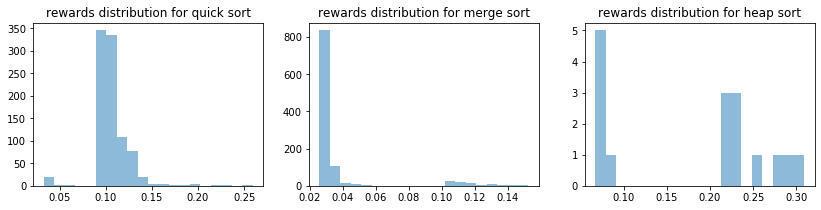

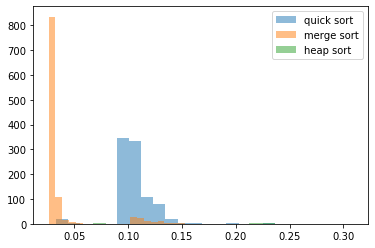

In [39]:
plot_rewards_distribution(arm_rewards_4)
plot_rewards_distribution_together(arm_rewards_4)

Restart at iteration: 503
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.10740125738032885, 'merge_sort': 0.11821364500065101, 'heap_sort': 0.23437550000380725}
Count per chosen algo {'quick_sort': 481, 'merge_sort': 20, 'heap_sort': 3}


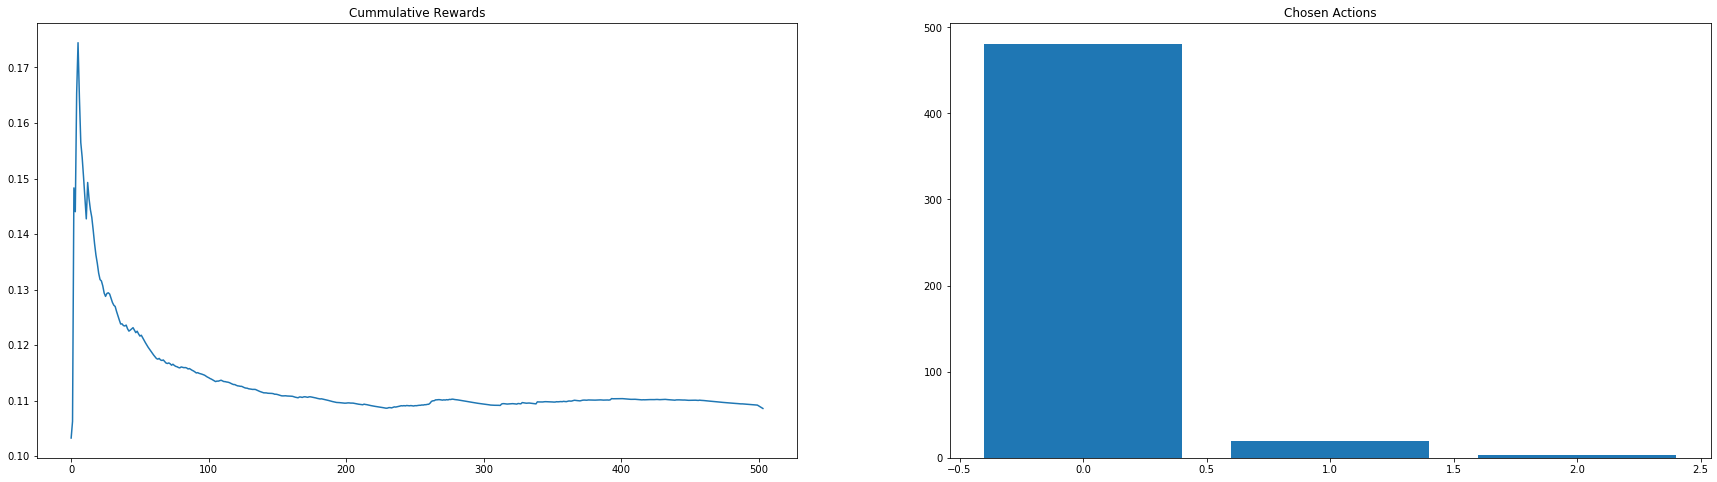

Restart at iteration: 987
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.03358194999600528, 'merge_sort': 0.027582731666492086, 'heap_sort': 0.06753414999548113}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 480, 'heap_sort': 2}


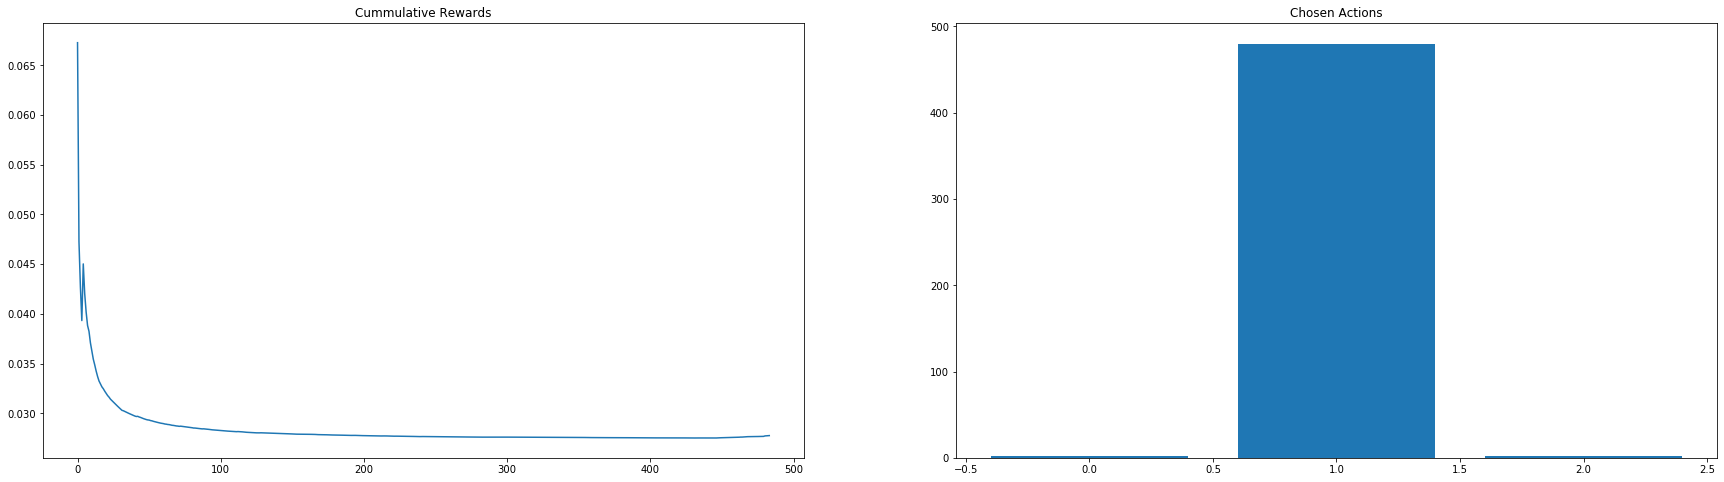

Restart at iteration: 1503
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.10624912642334308, 'merge_sort': 0.11200487647104584, 'heap_sort': 0.21484881111407755}
Count per chosen algo {'quick_sort': 439, 'merge_sort': 68, 'heap_sort': 9}


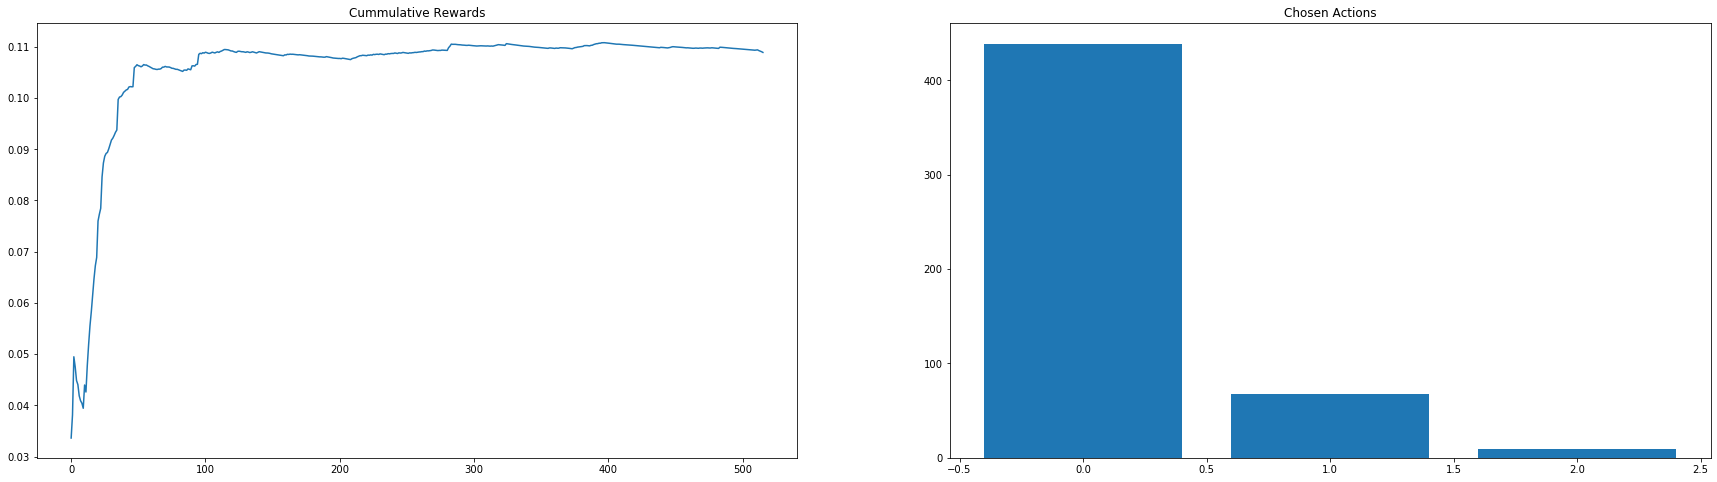

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.04045449999587921, 'merge_sort': 0.03050932889316039, 'heap_sort': 0.0733825499919476}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 488, 'heap_sort': 2}


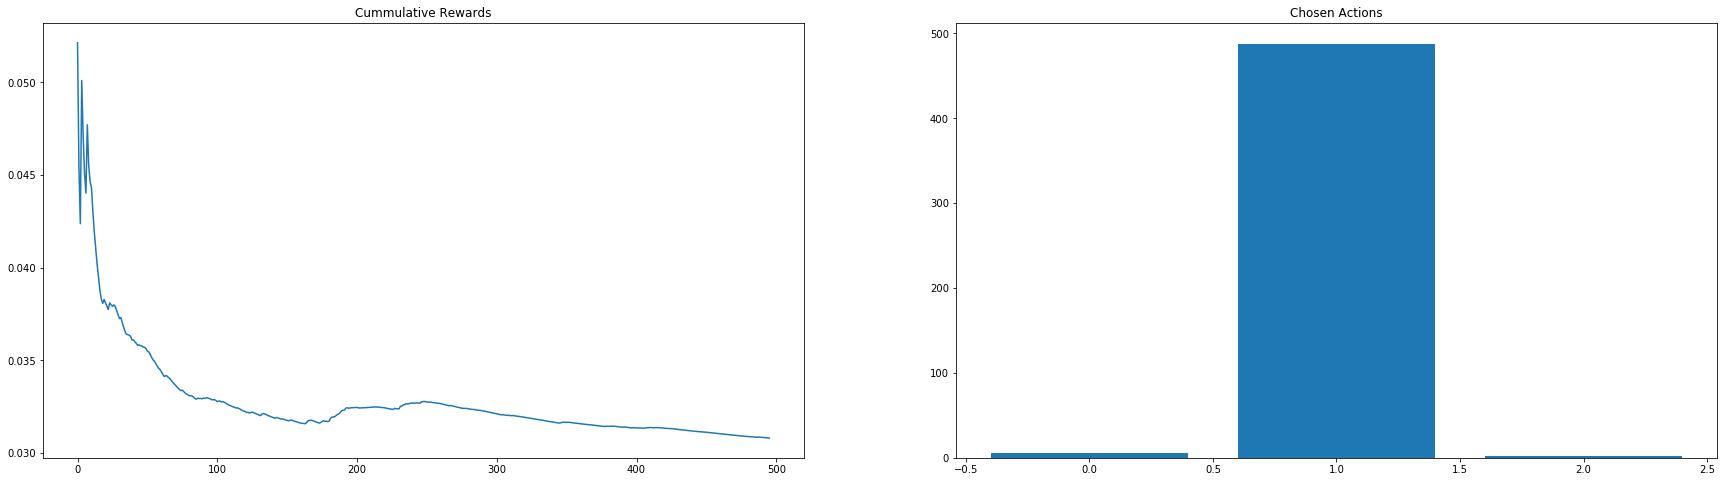

Total reward 139.6407


In [40]:
for elem in list_iteration_results_4:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_4,4))

## Five outliers in a row restart the expriment

In [41]:
list_iteration_results_5, total_reward_5, arm_rewards_5 = ts_quantile(list_distributions, n_samples, num_consec_elem=5)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.051744674385871464
Less than two values for merge_sort
merge_sort Theta 0.08960037011821585
Less than two values for heap_sort
heap_sort Theta 0.025865585579377237


Chosen algorithm is:  heap_sort with reward: 0.23612450000655372
Sample mean is:  0.23612450000655372 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.01199157322393314
Less than two values for merge_sort
merge_sort Theta 0.03793462173394024
Less than two values for heap_sort
heap_sort Theta 0.054815292515805386


Chosen algorithm is:  quick_sort with reward: 0.10412659999565221
Sample mean is:  0.10412659999565221 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.04214431756478909
Less than two values for merge_sort
merge_sort Theta 0.05631902836576202
Less than two values for heap_sort
heap_sort Theta 0.026744843986838865


Chosen algorithm is:  heap_sort with rewa



Chosen algorithm is:  quick_sort with reward: 0.105435799996485
Sample mean is:  0.10006213999819011 Sample variance is: 5.372767789658745e-06


Iteration: 30
quick_sort Theta 0.10003721418532636
merge_sort Theta 0.10621478067846146
heap_sort Theta 0.22998649550934494


Chosen algorithm is:  quick_sort with reward: 0.0994191000063438
Sample mean is:  0.1000374076908114 Sample variance is: 5.181415050378738e-06


Iteration: 31
quick_sort Theta 0.10038485512188043
merge_sort Theta 0.10632816983945936
heap_sort Theta 0.23817113081845898


Chosen algorithm is:  quick_sort with reward: 0.10255830000096466
Sample mean is:  0.10013077407266893 Sample variance is: 5.21616010204391e-06


Iteration: 32
quick_sort Theta 0.10100314183350582
merge_sort Theta 0.10640255097301636
heap_sort Theta 0.23746120235489632


Chosen algorithm is:  quick_sort with reward: 0.10304939998604823
Sample mean is:  0.10023501071243247 Sample variance is: 5.323231150696331e-06


Iteration: 33
quick_sort Theta 0.0999


Iteration: 60
quick_sort Theta 0.09933546284097759
merge_sort Theta 0.10617387892386676
heap_sort Theta 0.2351665772083732


Chosen algorithm is:  quick_sort with reward: 0.09872570000879932
Sample mean is:  0.09922750357015632 Sample variance is: 4.0407217277899716e-06


Iteration: 61
quick_sort Theta 0.09905856220490664
merge_sort Theta 0.10605675324332904
heap_sort Theta 0.23275696722467695


Chosen algorithm is:  quick_sort with reward: 0.09775850000733044
Sample mean is:  0.09920173157782604 Sample variance is: 4.007026825882092e-06


Iteration: 62
quick_sort Theta 0.09910153084712088
merge_sort Theta 0.1064792334222119
heap_sort Theta 0.2330269523300557


Chosen algorithm is:  quick_sort with reward: 0.09688850000384264
Sample mean is:  0.09916184827482633 Sample variance is: 4.02860879438585e-06


Iteration: 63
quick_sort Theta 0.09912364007203221
merge_sort Theta 0.10632833186961894
heap_sort Theta 0.23150201544736287


Chosen algorithm is:  quick_sort with reward: 0.098568000



Chosen algorithm is:  quick_sort with reward: 0.10231370000110473
Sample mean is:  0.09944019999890989 Sample variance is: 8.58857319932545e-06


Iteration: 92
quick_sort Theta 0.09976179905267729
merge_sort Theta 0.10619930578539453
heap_sort Theta 0.23447794902070032


Chosen algorithm is:  quick_sort with reward: 0.10788520000642166
Sample mean is:  0.09953616590808617 Sample variance is: 9.29219842459629e-06


Iteration: 93
quick_sort Theta 0.09968349305407061
merge_sort Theta 0.10586893475442094
heap_sort Theta 0.23404430293217848


Chosen algorithm is:  quick_sort with reward: 0.12077679998765234
Sample mean is:  0.09977482471796893 Sample variance is: 1.4200098123774346e-05


Iteration: 94
quick_sort Theta 0.09962147311047027
merge_sort Theta 0.10576574153530448
heap_sort Theta 0.237217001141425


Chosen algorithm is:  quick_sort with reward: 0.09714660000463482
Sample mean is:  0.09974562222115411 Sample variance is: 1.411821719373197e-05


Iteration: 95
quick_sort Theta 0.09



Chosen algorithm is:  quick_sort with reward: 0.09768720000283793
Sample mean is:  0.09968780258513389 Sample variance is: 1.7075214465266823e-05


Iteration: 122
quick_sort Theta 0.0994993025121732
merge_sort Theta 0.1063968939931302
heap_sort Theta 0.23368316668341488


Chosen algorithm is:  quick_sort with reward: 0.09683689998928457
Sample mean is:  0.09966343589628048 Sample variance is: 1.6998145782268956e-05


Iteration: 123
quick_sort Theta 0.09932459646869647
merge_sort Theta 0.1063085578219003
heap_sort Theta 0.2291399582020297


Chosen algorithm is:  quick_sort with reward: 0.09919660000014119
Sample mean is:  0.09965947965987251 Sample variance is: 1.68559249607307e-05


Iteration: 124
quick_sort Theta 0.09973310502426135
merge_sort Theta 0.10650999299314409
heap_sort Theta 0.23461410455316917


Chosen algorithm is:  quick_sort with reward: 0.09824919998936821
Sample mean is:  0.09964762857020441 Sample variance is: 1.6730851434995195e-05


Iteration: 125
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.097850300007849
Sample mean is:  0.09962777808158697 Sample variance is: 1.481286864611377e-05


Iteration: 152
quick_sort Theta 0.09971532524714785
merge_sort Theta 0.10647226087740841
heap_sort Theta 0.22729015139953931


Chosen algorithm is:  quick_sort with reward: 0.09851250000065193
Sample mean is:  0.09962019115586632 Sample variance is: 1.4720504802710663e-05


Iteration: 153
quick_sort Theta 0.09918133891197142
merge_sort Theta 0.10623700430144303
heap_sort Theta 0.24016625584426635


Chosen algorithm is:  quick_sort with reward: 0.09973089999402873
Sample mean is:  0.0996209391885566 Sample variance is: 1.4621124186699218e-05


Iteration: 154
quick_sort Theta 0.09959743511617254
merge_sort Theta 0.10632897345481587
heap_sort Theta 0.22902597496140897


Chosen algorithm is:  quick_sort with reward: 0.09797729999991134
Sample mean is:  0.09960990805306234 Sample variance is: 1.454100535709625e-05


Iteration: 155
quick_sort Thet

Iteration: 182
quick_sort Theta 0.09925874794837204
merge_sort Theta 0.10664333803158678
heap_sort Theta 0.2390171774145557


Chosen algorithm is:  quick_sort with reward: 0.09643590000632685
Sample mean is:  0.09943973728752233 Sample variance is: 1.2918507847540446e-05


Iteration: 183
quick_sort Theta 0.09975836286260342
merge_sort Theta 0.10636669191422415
heap_sort Theta 0.23308214808389688


Chosen algorithm is:  quick_sort with reward: 0.09614399999554735
Sample mean is:  0.09942122190947751 Sample variance is: 1.2906610963429643e-05


Iteration: 184
quick_sort Theta 0.09954426598708012
merge_sort Theta 0.10646066962379876
heap_sort Theta 0.23382708671381697


Chosen algorithm is:  quick_sort with reward: 0.09591169998748228
Sample mean is:  0.09940161564175687 Sample variance is: 1.290293121220708e-05


Iteration: 185
quick_sort Theta 0.09957862158441204
merge_sort Theta 0.10638143502294856
heap_sort Theta 0.22979943884097045


Chosen algorithm is:  quick_sort with reward: 0.09



Iteration: 212
quick_sort Theta 0.09965862289124695
merge_sort Theta 0.10628138763304212
heap_sort Theta 0.2261745540924567


Chosen algorithm is:  quick_sort with reward: 0.09807000000728294
Sample mean is:  0.09960837342928486 Sample variance is: 1.6032686158262375e-05


Iteration: 213
quick_sort Theta 0.0995583805032181
merge_sort Theta 0.10632782061740559
heap_sort Theta 0.23480753326934556


Chosen algorithm is:  quick_sort with reward: 0.09905190000426956
Sample mean is:  0.09960569807627997 Sample variance is: 1.59570875416837e-05


Iteration: 214
quick_sort Theta 0.09940288868209923
merge_sort Theta 0.1063530097138795
heap_sort Theta 0.2344516914500901


Chosen algorithm is:  quick_sort with reward: 0.09720230000675656
Sample mean is:  0.0995941985639856 Sample variance is: 1.590824350739306e-05


Iteration: 215
quick_sort Theta 0.09968356359646034
merge_sort Theta 0.10628658031790221
heap_sort Theta 0.232973377187918


Chosen algorithm is:  quick_sort with reward: 0.09864499



Chosen algorithm is:  quick_sort with reward: 0.09775830000580754
Sample mean is:  0.09937053502058141 Sample variance is: 1.4489197782291258e-05


Iteration: 243
quick_sort Theta 0.09935631886713579
merge_sort Theta 0.10638660181854326
heap_sort Theta 0.22735892281871664


Chosen algorithm is:  quick_sort with reward: 0.09676699999545235
Sample mean is:  0.09935959579778675 Sample variance is: 1.4456679783110961e-05


Iteration: 244
quick_sort Theta 0.09929759167207573
merge_sort Theta 0.10628299005501292
heap_sort Theta 0.2299017609821018


Chosen algorithm is:  quick_sort with reward: 0.10148979999939911
Sample mean is:  0.09936850878607802 Sample variance is: 1.4415098626928317e-05


Iteration: 245
quick_sort Theta 0.09925584749410615
merge_sort Theta 0.10620814961847173
heap_sort Theta 0.23358568440305932


Chosen algorithm is:  quick_sort with reward: 0.09875889999966603
Sample mean is:  0.09936596874946796 Sample variance is: 1.43565776928321e-05


Iteration: 246
quick_sort Th



Iteration: 273
quick_sort Theta 0.09943006541967378
merge_sort Theta 0.10635529998552114
heap_sort Theta 0.22694289076409627


Chosen algorithm is:  quick_sort with reward: 0.10281559999566525
Sample mean is:  0.09949267611900994 Sample variance is: 1.4449799429020769e-05


Iteration: 274
quick_sort Theta 0.09958315333112132
merge_sort Theta 0.10636320838031227
heap_sort Theta 0.23291339231424424


Chosen algorithm is:  quick_sort with reward: 0.10503770000650547
Sample mean is:  0.09951328959071067 Sample variance is: 1.450995998028802e-05


Iteration: 275
quick_sort Theta 0.09952895663344019
merge_sort Theta 0.10634382591164544
heap_sort Theta 0.23564763826342172


Chosen algorithm is:  quick_sort with reward: 0.10312590000103228
Sample mean is:  0.09952666962926741 Sample variance is: 1.4504377228917264e-05


Iteration: 276
quick_sort Theta 0.09940060826706175
merge_sort Theta 0.10626624943732352
heap_sort Theta 0.23251006591665396


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 303
quick_sort Theta 0.09996752246597454
merge_sort Theta 0.10644500503887087
heap_sort Theta 0.2200460301086653


Chosen algorithm is:  quick_sort with reward: 0.1026032999943709
Sample mean is:  0.09978712583864116 Sample variance is: 1.5154439654985221e-05


Iteration: 304
quick_sort Theta 0.09963512036598292
merge_sort Theta 0.10615279233284483
heap_sort Theta 0.2312709292256857


Chosen algorithm is:  quick_sort with reward: 0.11347749999549706
Sample mean is:  0.09983291304317914 Sample variance is: 1.5728503403941747e-05


Iteration: 305
quick_sort Theta 0.09956853704685519
merge_sort Theta 0.10620238419006309
heap_sort Theta 0.22963496605912007


Chosen algorithm is:  quick_sort with reward: 0.11043539999809582
Sample mean is:  0.09986825466636219 Sample variance is: 1.6049535127696656e-05


Iteration: 306
quick_sort Theta 0.09981502421621838
merge_sort Theta 0.10627221581625242
heap_sort Theta 0.228002413951059


Chosen algorithm is:  quick_sort with reward: 0.101


Iteration: 333
quick_sort Theta 0.10057029380069657
merge_sort Theta 0.10650521477545638
heap_sort Theta 0.22627857494994064


Chosen algorithm is:  quick_sort with reward: 0.11566159999347292
Sample mean is:  0.10025904054844698 Sample variance is: 2.343213095961329e-05


Iteration: 334
quick_sort Theta 0.10007199334570359
merge_sort Theta 0.10587632995838532
heap_sort Theta 0.22993694108975715


Chosen algorithm is:  quick_sort with reward: 0.10435480000160169
Sample mean is:  0.10027148966532587 Sample variance is: 2.3411742284690348e-05


Iteration: 335
quick_sort Theta 0.09999992077985058
merge_sort Theta 0.09845406002872785
heap_sort Theta 0.22674410061669856


Chosen algorithm is:  merge_sort with reward: 0.12177269998937845
Sample mean is:  0.11018339999645832 Sample variance is: 4.480069852090367e-05


Iteration: 336
quick_sort Theta 0.10031693612802854
merge_sort Theta 0.1112389093642168
heap_sort Theta 0.23409658234269948


Chosen algorithm is:  quick_sort with reward: 0.09



Iteration: 363
quick_sort Theta 0.10117422589726598
merge_sort Theta 0.10818237799511121
heap_sort Theta 0.2351832734062183


Chosen algorithm is:  quick_sort with reward: 0.10374839999713004
Sample mean is:  0.10118801154898853 Sample variance is: 4.1641793435244606e-05


Iteration: 364
quick_sort Theta 0.10143590962844337
merge_sort Theta 0.09616732279729198
heap_sort Theta 0.22920938660677287


Chosen algorithm is:  merge_sort with reward: 0.150742400001036
Sample mean is:  0.11647005714101917 Sample variance is: 0.00023172321057876442


Iteration: 365
quick_sort Theta 0.10121218139841577
merge_sort Theta 0.11512484718280278
heap_sort Theta 0.23419715017303222


Chosen algorithm is:  quick_sort with reward: 0.10936149999906775
Sample mean is:  0.10121097078620786 Sample variance is: 4.1711952039031405e-05


Iteration: 366
quick_sort Theta 0.10104511297397738
merge_sort Theta 0.1150852681713548
heap_sort Theta 0.2253951881501043


Chosen algorithm is:  quick_sort with reward: 0.112



Chosen algorithm is:  quick_sort with reward: 0.11252629999944475
Sample mean is:  0.10221722552080337 Sample variance is: 6.372508516659036e-05


Iteration: 394
quick_sort Theta 0.10276013178880067
merge_sort Theta 0.09864754299282728
heap_sort Theta 0.23361446248053677


Chosen algorithm is:  merge_sort with reward: 0.12119360000360757
Sample mean is:  0.11706049999884272 Sample variance is: 0.00020519816863490275


Iteration: 395
quick_sort Theta 0.10248638278048848
merge_sort Theta 0.11193342572617414
heap_sort Theta 0.23095153792693085


Chosen algorithm is:  quick_sort with reward: 0.13876000000163913
Sample mean is:  0.10231214181815619 Sample variance is: 6.701906121007586e-05


Iteration: 396
quick_sort Theta 0.10283471838401198
merge_sort Theta 0.10940277999056494
heap_sort Theta 0.2315719970883014


Chosen algorithm is:  quick_sort with reward: 0.11573039999348111
Sample mean is:  0.10234690414503526 Sample variance is: 6.731067815663739e-05


Iteration: 397
quick_sort The



Chosen algorithm is:  quick_sort with reward: 0.098157699991134
Sample mean is:  0.10298153961343486 Sample variance is: 8.336469587523275e-05


Iteration: 425
quick_sort Theta 0.10340608737039259
merge_sort Theta 0.11652941318071727
heap_sort Theta 0.23242033155434844


Chosen algorithm is:  quick_sort with reward: 0.09662470000330359
Sample mean is:  0.1029662219276273 Sample variance is: 8.326095453036965e-05


Iteration: 426
quick_sort Theta 0.10280877094098359
merge_sort Theta 0.11532892702433735
heap_sort Theta 0.22862587456081582


Chosen algorithm is:  quick_sort with reward: 0.0980324000120163
Sample mean is:  0.1029543617787917 Sample variance is: 8.311918320417336e-05


Iteration: 427
quick_sort Theta 0.10304327035214926
merge_sort Theta 0.11591032287951214
heap_sort Theta 0.23127918480267903


Chosen algorithm is:  quick_sort with reward: 0.09818169999925885
Sample mean is:  0.1029429165467065 Sample variance is: 8.297434985413958e-05


Iteration: 428
quick_sort Theta 0.1


Iteration: 456
quick_sort Theta 0.10269709542037737
merge_sort Theta 0.11709205048085887
heap_sort Theta 0.23099766021623436


Chosen algorithm is:  quick_sort with reward: 0.09910529998887796
Sample mean is:  0.10264005672624867 Sample variance is: 7.894479091141196e-05


Iteration: 457
quick_sort Theta 0.10277159535639956
merge_sort Theta 0.11821115934936374
heap_sort Theta 0.236580034602265


Chosen algorithm is:  quick_sort with reward: 0.09845540000242181
Sample mean is:  0.10263069507809694 Sample variance is: 7.880726828434478e-05


Iteration: 458
quick_sort Theta 0.10259505112047046
merge_sort Theta 0.11517126759396347
heap_sort Theta 0.2311330609581249


Chosen algorithm is:  quick_sort with reward: 0.09842169999319594
Sample mean is:  0.10262129999978242 Sample variance is: 7.867081477430444e-05


Iteration: 459
quick_sort Theta 0.1025312110971487
merge_sort Theta 0.11119895723384904
heap_sort Theta 0.19973664527155993


Chosen algorithm is:  quick_sort with reward: 0.098928



Iteration: 486
quick_sort Theta 0.10239477949957748
merge_sort Theta 0.1185029549156164
heap_sort Theta 0.22811325418395872


Chosen algorithm is:  quick_sort with reward: 0.09889219999604393
Sample mean is:  0.10238785178933636 Sample variance is: 7.522468405209543e-05


Iteration: 487
quick_sort Theta 0.10275732230818174
merge_sort Theta 0.12236182746346921
heap_sort Theta 0.2299187747974823


Chosen algorithm is:  quick_sort with reward: 0.09741120001126546
Sample mean is:  0.10237739663854209 Sample variance is: 7.5118571336178e-05


Iteration: 488
quick_sort Theta 0.10269146376795303
merge_sort Theta 0.10663232512021886
heap_sort Theta 0.2233216289928397


Chosen algorithm is:  quick_sort with reward: 0.09797049999178853
Sample mean is:  0.10236815786150487 Sample variance is: 7.500171903509506e-05


Iteration: 489
quick_sort Theta 0.10250214961284505
merge_sort Theta 0.12128832887198383
heap_sort Theta 0.23228758127224758


Chosen algorithm is:  quick_sort with reward: 0.097006


Chosen algorithm is:  merge_sort with reward: 0.028772400008165278
Sample mean is:  0.032052028574980795 Sample variance is: 3.3278056946316256e-05


Iteration: 514
Less than two values for quick_sort
quick_sort Theta 0.061354847539232316
merge_sort Theta 0.03408744638552369
Less than two values for heap_sort
heap_sort Theta 0.08365036272456783


Chosen algorithm is:  merge_sort with reward: 0.02805179999268148
Sample mean is:  0.03155200000219338 Sample variance is: 3.0868499843253454e-05


Iteration: 515
Less than two values for quick_sort
quick_sort Theta 0.06265814787434475
merge_sort Theta 0.028462074650721134
Less than two values for heap_sort
heap_sort Theta 0.05925566580863957


Chosen algorithm is:  merge_sort with reward: 0.03347499998926651
Sample mean is:  0.031765666667423725 Sample variance is: 2.780389407798166e-05


Iteration: 516
Less than two values for quick_sort
quick_sort Theta 0.016313687605301243
merge_sort Theta 0.03649087714353066
Less than two values for heap



Iteration: 543
quick_sort Theta 0.04682396029633021
merge_sort Theta 0.031127555550223902
heap_sort Theta 0.07100006825681567


Chosen algorithm is:  merge_sort with reward: 0.02827150000666734
Sample mean is:  0.030031691178224077 Sample variance is: 1.532977109082833e-05


Iteration: 544
quick_sort Theta 0.044565873798406416
merge_sort Theta 0.0303134189012807
heap_sort Theta 0.07398531008459422


Chosen algorithm is:  merge_sort with reward: 0.027327199990395457
Sample mean is:  0.029954420001428974 Sample variance is: 1.509478601304258e-05


Iteration: 545
quick_sort Theta 0.033475868064615354
merge_sort Theta 0.02800381803560417
heap_sort Theta 0.07314374864092239


Chosen algorithm is:  merge_sort with reward: 0.027753699992899783
Sample mean is:  0.02989328889008094 Sample variance is: 1.4806281848681775e-05


Iteration: 546
quick_sort Theta 0.04776599983875854
merge_sort Theta 0.030438578549807794
heap_sort Theta 0.0718028250457273


Chosen algorithm is:  merge_sort with rewa



Iteration: 573
quick_sort Theta 0.035215047430279235
merge_sort Theta 0.03115447168373735
heap_sort Theta 0.07114999396776822


Chosen algorithm is:  merge_sort with reward: 0.03295359999174252
Sample mean is:  0.03130256250119601 Sample variance is: 2.0159319405990705e-05


Iteration: 574
quick_sort Theta 0.05335584307521476
merge_sort Theta 0.03092967218976502
heap_sort Theta 0.07303511912419254


Chosen algorithm is:  merge_sort with reward: 0.033699999999953434
Sample mean is:  0.03133944615502304 Sample variance is: 1.993624188137042e-05


Iteration: 575
quick_sort Theta 0.047776655393564564
merge_sort Theta 0.031741929765993764
heap_sort Theta 0.06855520725555907


Chosen algorithm is:  merge_sort with reward: 0.03438629998709075
Sample mean is:  0.03138561060702407 Sample variance is: 1.977270279129664e-05


Iteration: 576
quick_sort Theta 0.05798151382246556
merge_sort Theta 0.031341249021591765
heap_sort Theta 0.07266356586825107


Chosen algorithm is:  merge_sort with rewar



Iteration: 603
quick_sort Theta 0.03254894170264324
merge_sort Theta 0.03044515583228418
heap_sort Theta 0.0673619310991731


Chosen algorithm is:  merge_sort with reward: 0.027098199992906302
Sample mean is:  0.03147634301226341 Sample variance is: 3.86121827362523e-05


Iteration: 604
quick_sort Theta 0.046416536175800036
merge_sort Theta 0.03156014636053902
heap_sort Theta 0.07214696308424465


Chosen algorithm is:  merge_sort with reward: 0.03209999999671709
Sample mean is:  0.03148297766103419 Sample variance is: 3.82055085612838e-05


Iteration: 605
quick_sort Theta 0.04469778876011115
merge_sort Theta 0.029786161042394035
heap_sort Theta 0.06875117444336223


Chosen algorithm is:  merge_sort with reward: 0.027669099988997914
Sample mean is:  0.031442831580275915 Sample variance is: 3.795484584649379e-05


Iteration: 606
quick_sort Theta 0.03721187215550289
merge_sort Theta 0.031019436915527457
heap_sort Theta 0.06976585005084297


Chosen algorithm is:  merge_sort with reward: 



Iteration: 633
quick_sort Theta 0.041077199695345075
merge_sort Theta 0.031053608737943026
heap_sort Theta 0.06961595825595904


Chosen algorithm is:  merge_sort with reward: 0.029308899989700876
Sample mean is:  0.03113625409927498 Sample variance is: 3.1582742695168925e-05


Iteration: 634
quick_sort Theta 0.04250763063158273
merge_sort Theta 0.03153442508601377
heap_sort Theta 0.0730944553689975


Chosen algorithm is:  merge_sort with reward: 0.033566999991307966
Sample mean is:  0.031156016260998825 Sample variance is: 3.137361867974647e-05


Iteration: 635
quick_sort Theta 0.04499780056599126
merge_sort Theta 0.030619210961681284
heap_sort Theta 0.07023567436390794


Chosen algorithm is:  merge_sort with reward: 0.027013300001272
Sample mean is:  0.031122607258904252 Sample variance is: 3.125789348065502e-05


Iteration: 636
quick_sort Theta 0.04031941207324461
merge_sort Theta 0.03059888307617973
heap_sort Theta 0.06893233103476236


Chosen algorithm is:  merge_sort with reward



Iteration: 663
quick_sort Theta 0.04463131184762374
merge_sort Theta 0.03070546974711182
heap_sort Theta 0.07057177635430563


Chosen algorithm is:  merge_sort with reward: 0.02728429999842774
Sample mean is:  0.0308651565794303 Sample variance is: 2.783348064606628e-05


Iteration: 664
quick_sort Theta 0.04333506034930908
merge_sort Theta 0.03122690485017242
heap_sort Theta 0.07000820944386449


Chosen algorithm is:  merge_sort with reward: 0.027479899988975376
Sample mean is:  0.030843030719361966 Sample variance is: 2.7725974631841026e-05


Iteration: 665
quick_sort Theta 0.06084455892987116
merge_sort Theta 0.03109631091544634
heap_sort Theta 0.07441756785653644


Chosen algorithm is:  merge_sort with reward: 0.0283828999963589
Sample mean is:  0.030827055844537272 Sample variance is: 2.758498091925707e-05


Iteration: 666
quick_sort Theta 0.04556964459498741
merge_sort Theta 0.03119722309201792
heap_sort Theta 0.07354065491032828


Chosen algorithm is:  merge_sort with reward: 0



Iteration: 693
quick_sort Theta 0.04069285322274643
merge_sort Theta 0.03025290270429207
heap_sort Theta 0.07081036259111581


Chosen algorithm is:  merge_sort with reward: 0.031945700000505894
Sample mean is:  0.03035737000019354 Sample variance is: 2.507547718836974e-05


Iteration: 694
quick_sort Theta 0.043102081480030204
merge_sort Theta 0.03016749458938828
heap_sort Theta 0.0716567519373897


Chosen algorithm is:  merge_sort with reward: 0.027525299999979325
Sample mean is:  0.03034172320461225 Sample variance is: 2.4981006638521005e-05


Iteration: 695
quick_sort Theta 0.03636727400015594
merge_sort Theta 0.02999334254569676
heap_sort Theta 0.07083561776302359


Chosen algorithm is:  merge_sort with reward: 0.027217800001380965
Sample mean is:  0.03032455879140768 Sample variance is: 2.4897074051886312e-05


Iteration: 696
quick_sort Theta 0.0427812426719561
merge_sort Theta 0.02981795302080631
heap_sort Theta 0.07068665537736026


Chosen algorithm is:  merge_sort with reward:



Iteration: 723
quick_sort Theta 0.04214186185819437
merge_sort Theta 0.030726045831408793
heap_sort Theta 0.07502070546561462


Chosen algorithm is:  merge_sort with reward: 0.02768869999272283
Sample mean is:  0.03049235285746233 Sample variance is: 2.6148668979410487e-05


Iteration: 724
quick_sort Theta 0.03931994698597442
merge_sort Theta 0.030621598983979204
heap_sort Theta 0.0707512309596662


Chosen algorithm is:  merge_sort with reward: 0.02793579999706708
Sample mean is:  0.030480236493195055 Sample variance is: 2.6055570957717876e-05


Iteration: 725
quick_sort Theta 0.03610352098498439
merge_sort Theta 0.030046837089287712
heap_sort Theta 0.0700978539411619


Chosen algorithm is:  merge_sort with reward: 0.02870849998726044
Sample mean is:  0.03047187924552555 Sample variance is: 2.5947404318321456e-05


Iteration: 726
quick_sort Theta 0.04202209135010611
merge_sort Theta 0.02992186491097204
heap_sort Theta 0.07150123539717887


Chosen algorithm is:  merge_sort with reward



Iteration: 754
quick_sort Theta 0.03779627960474205
merge_sort Theta 0.029865739507745695
heap_sort Theta 0.07064496143475234


Chosen algorithm is:  merge_sort with reward: 0.028164300005300902
Sample mean is:  0.030179577593581027 Sample variance is: 2.3727160132776497e-05


Iteration: 755
quick_sort Theta 0.04107279005434896
merge_sort Theta 0.030060105749449978
heap_sort Theta 0.07035018644145674


Chosen algorithm is:  merge_sort with reward: 0.027361799991922453
Sample mean is:  0.030167933884483265 Sample variance is: 2.366178782325971e-05


Iteration: 756
quick_sort Theta 0.04136097611559597
merge_sort Theta 0.02969432347463641
heap_sort Theta 0.07003473087192263


Chosen algorithm is:  merge_sort with reward: 0.02751689999422524
Sample mean is:  0.030157024279996607 Sample variance is: 2.3593216922571695e-05


Iteration: 757
quick_sort Theta 0.040259428246882036
merge_sort Theta 0.030317732074468504
heap_sort Theta 0.06813355744766929


Chosen algorithm is:  merge_sort with 



Iteration: 784
quick_sort Theta 0.03874324392732899
merge_sort Theta 0.030185181779704653
heap_sort Theta 0.06711467175654663


Chosen algorithm is:  merge_sort with reward: 0.027530799998203292
Sample mean is:  0.030245786666906766 Sample variance is: 2.6793137734442367e-05


Iteration: 785
quick_sort Theta 0.043312456443137116
merge_sort Theta 0.03086624878390042
heap_sort Theta 0.06946724551654904


Chosen algorithm is:  merge_sort with reward: 0.027814600005513057
Sample mean is:  0.03023681549841454 Sample variance is: 2.6716000170836906e-05


Iteration: 786
quick_sort Theta 0.04007978134085538
merge_sort Theta 0.030664592988139346
heap_sort Theta 0.07066482227522948


Chosen algorithm is:  merge_sort with reward: 0.02757029999338556
Sample mean is:  0.030227012132587227 Sample variance is: 2.6643824302971996e-05


Iteration: 787
quick_sort Theta 0.0437062318628582
merge_sort Theta 0.030322471490244546
heap_sort Theta 0.07094850564340174


Chosen algorithm is:  merge_sort with r

Sample mean is:  0.03042148566688411 Sample variance is: 3.2034077359727746e-05


Iteration: 815
quick_sort Theta 0.043507978424402315
merge_sort Theta 0.030803774029202785
heap_sort Theta 0.06975596081919745


Chosen algorithm is:  merge_sort with reward: 0.02750739999464713
Sample mean is:  0.030411804319135812 Sample variance is: 3.195577040181628e-05


Iteration: 816
quick_sort Theta 0.040748098592358395
merge_sort Theta 0.03090858071080942
heap_sort Theta 0.06941723072392852


Chosen algorithm is:  merge_sort with reward: 0.02654150000307709
Sample mean is:  0.03039898874193032 Sample variance is: 3.189939253729083e-05


Iteration: 817
quick_sort Theta 0.042467779782296794
merge_sort Theta 0.030588040486004508
heap_sort Theta 0.06500761642032507


Chosen algorithm is:  merge_sort with reward: 0.026668000005884096
Sample mean is:  0.03038667524775195 Sample variance is: 3.183990390000744e-05


Iteration: 818
quick_sort Theta 0.03620050650271724
merge_sort Theta 0.0305159707843005
h



Iteration: 845
quick_sort Theta 0.038840037723989564
merge_sort Theta 0.030507362271992577
heap_sort Theta 0.07401089203039687


Chosen algorithm is:  merge_sort with reward: 0.033545199999934994
Sample mean is:  0.030594675151752942 Sample variance is: 3.672981107940996e-05


Iteration: 846
quick_sort Theta 0.04047664896264034
merge_sort Theta 0.03161179083047398
heap_sort Theta 0.07105384366905998


Chosen algorithm is:  merge_sort with reward: 0.027960999999777414
Sample mean is:  0.03058671842923942 Sample variance is: 3.66397369957373e-05


Iteration: 847
quick_sort Theta 0.03968658697839937
merge_sort Theta 0.03032290128289503
heap_sort Theta 0.07094772406230483


Chosen algorithm is:  merge_sort with reward: 0.036571899996488355
Sample mean is:  0.03060474608456246 Sample variance is: 3.663695013611941e-05


Iteration: 848
quick_sort Theta 0.042106234403557326
merge_sort Theta 0.030080364312606755
heap_sort Theta 0.06748349505301134


Chosen algorithm is:  merge_sort with rewa



Iteration: 876
quick_sort Theta 0.0387449046267714
merge_sort Theta 0.030732898455453427
heap_sort Theta 0.06812099904838145


Chosen algorithm is:  merge_sort with reward: 0.02759440000227187
Sample mean is:  0.03054492603905223 Sample variance is: 3.466748798873483e-05


Iteration: 877
quick_sort Theta 0.045032571639609394
merge_sort Theta 0.029992676792087357
heap_sort Theta 0.06822054755088539


Chosen algorithm is:  merge_sort with reward: 0.026817500009201467
Sample mean is:  0.030534629282063692 Sample variance is: 3.4609995824147135e-05


Iteration: 878
quick_sort Theta 0.03626529532332094
merge_sort Theta 0.03068870995753925
heap_sort Theta 0.06909555348526866


Chosen algorithm is:  merge_sort with reward: 0.026899699994828552
Sample mean is:  0.030524615702760015 Sample variance is: 3.45509498639443e-05


Iteration: 879
quick_sort Theta 0.04196037105571266
merge_sort Theta 0.03044012123028841
heap_sort Theta 0.06952719941776267


Chosen algorithm is:  merge_sort with rewar


Iteration: 906
quick_sort Theta 0.04160052729480331
merge_sort Theta 0.030757811662744362
heap_sort Theta 0.06953157305072875


Chosen algorithm is:  merge_sort with reward: 0.03682370000751689
Sample mean is:  0.030483583632015202 Sample variance is: 3.463943873178496e-05


Iteration: 907
quick_sort Theta 0.0392011665207183
merge_sort Theta 0.030510206284486526
heap_sort Theta 0.07092008001501622


Chosen algorithm is:  merge_sort with reward: 0.03551359999983106
Sample mean is:  0.030496415306422896 Sample variance is: 3.4615451697081925e-05


Iteration: 908
quick_sort Theta 0.03658258027700801
merge_sort Theta 0.030334766033363547
heap_sort Theta 0.06913230984433279


Chosen algorithm is:  merge_sort with reward: 0.027234499997575767
Sample mean is:  0.030488115267469085 Sample variance is: 3.455437680079919e-05


Iteration: 909
quick_sort Theta 0.04527487077802017
merge_sort Theta 0.030792021546036052
heap_sort Theta 0.071542555455898


Chosen algorithm is:  merge_sort with reward



Iteration: 937
quick_sort Theta 0.043749685774748866
merge_sort Theta 0.030610713381960333
heap_sort Theta 0.07007609059169168


Chosen algorithm is:  merge_sort with reward: 0.026539800004684366
Sample mean is:  0.0303838511850846 Sample variance is: 3.278456883642858e-05


Iteration: 938
quick_sort Theta 0.04094080436697352
merge_sort Theta 0.03074817370894761
heap_sort Theta 0.07105241315773016


Chosen algorithm is:  merge_sort with reward: 0.02799129999766592
Sample mean is:  0.03037819503570536 Sample variance is: 3.272056458045004e-05


Iteration: 939
quick_sort Theta 0.037671758300345796
merge_sort Theta 0.030345300747373686
heap_sort Theta 0.0685479494755927


Chosen algorithm is:  merge_sort with reward: 0.02664569999615196
Sample mean is:  0.03036939198136679 Sample variance is: 3.267617330045756e-05


Iteration: 940
quick_sort Theta 0.043856358161172185
merge_sort Theta 0.03076061862364196
heap_sort Theta 0.06992133841854661


Chosen algorithm is:  merge_sort with reward:



Iteration: 967
quick_sort Theta 0.038890370005743934
merge_sort Theta 0.02992151811118999
heap_sort Theta 0.06951501598704991


Chosen algorithm is:  merge_sort with reward: 0.02740839999751188
Sample mean is:  0.030233984734797107 Sample variance is: 3.1228115846013155e-05


Iteration: 968
quick_sort Theta 0.043208470892650716
merge_sort Theta 0.030242564581518427
heap_sort Theta 0.06460925558522833


Chosen algorithm is:  merge_sort with reward: 0.027128499990794808
Sample mean is:  0.030227129360086286 Sample variance is: 3.1180421873358936e-05


Iteration: 969
quick_sort Theta 0.03884153298238614
merge_sort Theta 0.03008696331103202
heap_sort Theta 0.0717739524875497


Chosen algorithm is:  merge_sort with reward: 0.026518400001805276
Sample mean is:  0.030218960352689193 Sample variance is: 3.114197243490531e-05


Iteration: 970
quick_sort Theta 0.04218404853910198
merge_sort Theta 0.029992378978914446
heap_sort Theta 0.07053555802102209


Chosen algorithm is:  merge_sort with r



Iteration: 997
quick_sort Theta 0.04180754729962843
merge_sort Theta 0.03020439540493524
heap_sort Theta 0.0736072850412686


Chosen algorithm is:  merge_sort with reward: 0.028353499990771525
Sample mean is:  0.030129825933829155 Sample variance is: 2.986436344942026e-05


Iteration: 998
quick_sort Theta 0.037213565839931434
merge_sort Theta 0.029985155147981533
heap_sort Theta 0.07039297654360795


Chosen algorithm is:  merge_sort with reward: 0.027258300004177727
Sample mean is:  0.030123880745569008 Sample variance is: 2.9819568886175936e-05


Iteration: 999
quick_sort Theta 0.0361623873455268
merge_sort Theta 0.030017724627051965
heap_sort Theta 0.07068705760347986


Chosen algorithm is:  merge_sort with reward: 0.027385199995478615
Sample mean is:  0.030118222314267168 Sample variance is: 2.9773422825696308e-05


Iteration: 1000
quick_sort Theta 0.04103710288863833
merge_sort Theta 0.03024433180437229
heap_sort Theta 0.07018268393195955


Chosen algorithm is:  merge_sort with r



Iteration: 1026
quick_sort Theta 0.11236540085685065
merge_sort Theta 0.11947561341978194
heap_sort Theta 0.2543068976218387


Chosen algorithm is:  quick_sort with reward: 0.1245755999989342
Sample mean is:  0.11596104545672213 Sample variance is: 0.0002229427742980553


Iteration: 1027
quick_sort Theta 0.1121296563366408
merge_sort Theta 0.11830175145811388
heap_sort Theta 0.2676991449610997


Chosen algorithm is:  quick_sort with reward: 0.103443400003016
Sample mean is:  0.11491790833557995 Sample variance is: 0.00021633369536177007


Iteration: 1028
quick_sort Theta 0.11956766245387981
merge_sort Theta 0.10868148267581335
heap_sort Theta 0.2940042684581


Chosen algorithm is:  merge_sort with reward: 0.10540249999030493
Sample mean is:  0.11724912221931542 Sample variance is: 0.00017578768871420129


Iteration: 1029
quick_sort Theta 0.12050511218557891
merge_sort Theta 0.11592215458693543
heap_sort Theta 0.26208573180706196


Chosen algorithm is:  merge_sort with reward: 0.10720



Chosen algorithm is:  quick_sort with reward: 0.10461650000070222
Sample mean is:  0.1053068078947131 Sample variance is: 0.00012447484882569375


Iteration: 1057
quick_sort Theta 0.1055496368019777
merge_sort Theta 0.11785218268889162
heap_sort Theta 0.3006651596469513


Chosen algorithm is:  quick_sort with reward: 0.10025130001304206
Sample mean is:  0.10517717948749077 Sample variance is: 0.0001219217199457333


Iteration: 1058
quick_sort Theta 0.10557897500445852
merge_sort Theta 0.11233749769713997
heap_sort Theta 0.24530798122835504


Chosen algorithm is:  quick_sort with reward: 0.10306210000999272
Sample mean is:  0.10512430250055331 Sample variance is: 0.00011898272000124572


Iteration: 1059
quick_sort Theta 0.1034644466697227
merge_sort Theta 0.11479572333985684
heap_sort Theta 0.20186670320692332


Chosen algorithm is:  quick_sort with reward: 0.10490560000471305
Sample mean is:  0.1051189682933377 Sample variance is: 0.0001160818405909045


Iteration: 1060
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.11217560000659432
Sample mean is:  0.10432411791059995 Sample variance is: 8.072569040432835e-05


Iteration: 1087
quick_sort Theta 0.10656528013153886
merge_sort Theta 0.11331678568410503
heap_sort Theta 0.27137624331694715


Chosen algorithm is:  quick_sort with reward: 0.10149629999068566
Sample mean is:  0.10428253235295415 Sample variance is: 7.965441492489804e-05


Iteration: 1088
quick_sort Theta 0.10413889384505612
merge_sort Theta 0.11992933476852721
heap_sort Theta 0.21826775011590024


Chosen algorithm is:  quick_sort with reward: 0.10300220000499394
Sample mean is:  0.10426397681167936 Sample variance is: 7.85234160660083e-05


Iteration: 1089
quick_sort Theta 0.10404637483213118
merge_sort Theta 0.11664109503513825
heap_sort Theta 0.24568433550356814


Chosen algorithm is:  quick_sort with reward: 0.10362379999423865
Sample mean is:  0.10425483142857307 Sample variance is: 7.740742400357014e-05


Iteration: 1090
quick_sort 



Chosen algorithm is:  quick_sort with reward: 0.10274839999328833
Sample mean is:  0.10291601632625501 Sample variance is: 6.789274336763644e-05


Iteration: 1118
quick_sort Theta 0.10274550030015614
merge_sort Theta 0.11146061225195024
heap_sort Theta 0.2601291318925327


Chosen algorithm is:  quick_sort with reward: 0.09663600000203587
Sample mean is:  0.10285258181792957 Sample variance is: 6.760130389205077e-05


Iteration: 1119
quick_sort Theta 0.10329555177441321
merge_sort Theta 0.1156009494491777
heap_sort Theta 0.25513820572395146


Chosen algorithm is:  quick_sort with reward: 0.10138350000488572
Sample mean is:  0.10283789099979913 Sample variance is: 6.694665704672708e-05


Iteration: 1120
quick_sort Theta 0.10355852132571332
merge_sort Theta 0.11294283407939332
heap_sort Theta 0.2454575952929764


Chosen algorithm is:  quick_sort with reward: 0.09816099998715799
Sample mean is:  0.10279158514818883 Sample variance is: 6.649824204748123e-05


Iteration: 1121
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09752819999994244
Sample mean is:  0.10160581874970376 Sample variance is: 5.830852193829972e-05


Iteration: 1148
quick_sort Theta 0.10224796986502216
merge_sort Theta 0.11530797889037771
heap_sort Theta 0.2446843218206782


Chosen algorithm is:  quick_sort with reward: 0.095921800006181
Sample mean is:  0.10156175658890125 Sample variance is: 5.810502656613335e-05


Iteration: 1149
quick_sort Theta 0.10123106285522428
merge_sort Theta 0.11078066117890516
heap_sort Theta 0.24149968780344325


Chosen algorithm is:  quick_sort with reward: 0.09796290000667796
Sample mean is:  0.1015340730767303 Sample variance is: 5.775692743646629e-05


Iteration: 1150
quick_sort Theta 0.10144777737465611
merge_sort Theta 0.11919756307854677
heap_sort Theta 0.23680569045283203


Chosen algorithm is:  quick_sort with reward: 0.09782450000056997
Sample mean is:  0.1015057557250039 Sample variance is: 5.742027827375908e-05


Iteration: 1151
quick_sort Thet


Chosen algorithm is:  quick_sort with reward: 0.111076499990304
Sample mean is:  0.10147044556946686 Sample variance is: 6.047372141138323e-05


Iteration: 1178
quick_sort Theta 0.10217436308538963
merge_sort Theta 0.10904256696831734
heap_sort Theta 0.2505367480284513


Chosen algorithm is:  quick_sort with reward: 0.10241980000864714
Sample mean is:  0.10147641635210321 Sample variance is: 6.00990162796273e-05


Iteration: 1179
quick_sort Theta 0.1005132796830932
merge_sort Theta 0.1217041543340318
heap_sort Theta 0.26108211581852964


Chosen algorithm is:  quick_sort with reward: 0.09432860001106746
Sample mean is:  0.10143174249997174 Sample variance is: 6.0040722165097715e-05


Iteration: 1180
quick_sort Theta 0.10213183261183911
merge_sort Theta 0.11686243744409484
heap_sort Theta 0.22195566894297786


Chosen algorithm is:  quick_sort with reward: 0.09547390000079758
Sample mean is:  0.10139473726705761 Sample variance is: 5.988690038702642e-05


Iteration: 1181
quick_sort Theta


Chosen algorithm is:  quick_sort with reward: 0.10487250000005588
Sample mean is:  0.10166226595731828 Sample variance is: 9.709728381135066e-05


Iteration: 1208
quick_sort Theta 0.10195754093090832
merge_sort Theta 0.11396491023612665
heap_sort Theta 0.24642243447235984


Chosen algorithm is:  quick_sort with reward: 0.11195869999937713
Sample mean is:  0.1017167444443133 Sample variance is: 9.714150781147269e-05


Iteration: 1209
quick_sort Theta 0.10170361692135146
merge_sort Theta 0.11089556458870035
heap_sort Theta 0.2601392238072638


Chosen algorithm is:  quick_sort with reward: 0.10302490000321995
Sample mean is:  0.1017236294735707 Sample variance is: 9.663919600339653e-05


Iteration: 1210
quick_sort Theta 0.10217676170323886
merge_sort Theta 0.11487487839650762
heap_sort Theta 0.23898707813640105


Chosen algorithm is:  quick_sort with reward: 0.10066470000310801
Sample mean is:  0.1017180853402175 Sample variance is: 9.613907173519664e-05


Iteration: 1211
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.14030480000656098
Sample mean is:  0.1036810087155681 Sample variance is: 0.00014726380102513797


Iteration: 1238
quick_sort Theta 0.10295663380519597
merge_sort Theta 0.10953833834794863
heap_sort Theta 0.256983219208576


Chosen algorithm is:  quick_sort with reward: 0.0973496999940835
Sample mean is:  0.10365209863008187 Sample variance is: 0.0001467735664608696


Iteration: 1239
quick_sort Theta 0.10265338158670345
merge_sort Theta 0.1191956696648501
heap_sort Theta 0.2258421990358605


Chosen algorithm is:  quick_sort with reward: 0.09720269999525044
Sample mean is:  0.10362278318174173 Sample variance is: 0.00014629462150304048


Iteration: 1240
quick_sort Theta 0.10354888098570227
merge_sort Theta 0.10767910341473971
heap_sort Theta 0.23888722504068816


Chosen algorithm is:  quick_sort with reward: 0.0991926999995485
Sample mean is:  0.10360273755648293 Sample variance is: 0.00014572105685014807


Iteration: 1241
quick_sort The



Chosen algorithm is:  quick_sort with reward: 0.10340659999928903
Sample mean is:  0.1038668265060244 Sample variance is: 0.0001467437239487318


Iteration: 1269
quick_sort Theta 0.10470801547973263
merge_sort Theta 0.11475829806421609
heap_sort Theta 0.24203756769695728


Chosen algorithm is:  quick_sort with reward: 0.1018298999988474
Sample mean is:  0.10385867879999569 Sample variance is: 0.00014617327894620593


Iteration: 1270
quick_sort Theta 0.10383876698707267
merge_sort Theta 0.11765548635381778
heap_sort Theta 0.23767423980096541


Chosen algorithm is:  quick_sort with reward: 0.10321180000028107
Sample mean is:  0.10385610159362232 Sample variance is: 0.00014559257578323841


Iteration: 1271
quick_sort Theta 0.10417191055600138
merge_sort Theta 0.12165279605910648
heap_sort Theta 0.24242732515376303


Chosen algorithm is:  quick_sort with reward: 0.10418850000132807
Sample mean is:  0.10385742063492275 Sample variance is: 0.00014501526417399626


Iteration: 1272
quick_sor



Chosen algorithm is:  quick_sort with reward: 0.10185619999538176
Sample mean is:  0.10437394607147975 Sample variance is: 0.00014796790431566268


Iteration: 1300
quick_sort Theta 0.10483088161639846
merge_sort Theta 0.11124591402665795
heap_sort Theta 0.2959727291083339


Chosen algorithm is:  quick_sort with reward: 0.1309006999945268
Sample mean is:  0.10446834733099238 Sample variance is: 0.0001499365755270403


Iteration: 1301
quick_sort Theta 0.10464992600429138
merge_sort Theta 0.11931490266227121
heap_sort Theta 0.2284171958540314


Chosen algorithm is:  quick_sort with reward: 0.09805309999501333
Sample mean is:  0.10444559822696409 Sample variance is: 0.00014955030915018118


Iteration: 1302
quick_sort Theta 0.10480472973252082
merge_sort Theta 0.11108171061489695
heap_sort Theta 0.2547567468061361


Chosen algorithm is:  quick_sort with reward: 0.1012751000089338
Sample mean is:  0.10443439505304877 Sample variance is: 0.00014905725695992469


Iteration: 1303
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.13604310000664555
Sample mean is:  0.10504548705493222 Sample variance is: 0.00015598631134354445


Iteration: 1330
quick_sort Theta 0.10430450341339573
merge_sort Theta 0.11357037622485856
heap_sort Theta 0.24467308158617215


Chosen algorithm is:  quick_sort with reward: 0.09623730000748765
Sample mean is:  0.10501707354832757 Sample variance is: 0.00015573259384753924


Iteration: 1331
quick_sort Theta 0.1040487292705414
merge_sort Theta 0.11460903474272181
heap_sort Theta 0.23103770082638328


Chosen algorithm is:  quick_sort with reward: 0.1365734999999404
Sample mean is:  0.10511854115749673 Sample variance is: 0.0001584235054276117


Iteration: 1332
quick_sort Theta 0.10562295670932
merge_sort Theta 0.11999182254571161
heap_sort Theta 0.2490579681401829


Chosen algorithm is:  quick_sort with reward: 0.10259729999233969
Sample mean is:  0.10511046025632635 Sample variance is: 0.00015793604638172898


Iteration: 1333
quick_sort Th



Iteration: 1360
quick_sort Theta 0.1052944768582224
merge_sort Theta 0.11405251006778919
heap_sort Theta 0.25089547929126493


Chosen algorithm is:  quick_sort with reward: 0.10118150000926107
Sample mean is:  0.10477724117646336 Sample variance is: 0.0001489742829821371


Iteration: 1361
quick_sort Theta 0.10400376249116622
merge_sort Theta 0.11335533492812548
heap_sort Theta 0.2298296467773636


Chosen algorithm is:  quick_sort with reward: 0.09806419999222271
Sample mean is:  0.10475755483867967 Sample variance is: 0.00014866917589639772


Iteration: 1362
quick_sort Theta 0.10454614085791987
merge_sort Theta 0.1147875379257394
heap_sort Theta 0.2606935847166462


Chosen algorithm is:  quick_sort with reward: 0.09502179999253713
Sample mean is:  0.1047290877192465 Sample variance is: 0.00014851080922280652


Iteration: 1363
quick_sort Theta 0.10493626675414462
merge_sort Theta 0.11983304092667643
heap_sort Theta 0.20837521403715195


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1390
quick_sort Theta 0.10386090993635809
merge_sort Theta 0.1178559545799781
heap_sort Theta 0.24811905823908156


Chosen algorithm is:  quick_sort with reward: 0.10033819999080151
Sample mean is:  0.10428954513505183 Sample variance is: 0.00013993261036735068


Iteration: 1391
quick_sort Theta 0.10379749639447662
merge_sort Theta 0.11193152400098394
heap_sort Theta 0.24314364889039602


Chosen algorithm is:  quick_sort with reward: 0.09903909999411553
Sample mean is:  0.1042753929918148 Sample variance is: 0.00013962953828853378


Iteration: 1392
quick_sort Theta 0.10319841218100878
merge_sort Theta 0.11757449259062168
heap_sort Theta 0.22276306033043247


Chosen algorithm is:  quick_sort with reward: 0.09641070000361651
Sample mean is:  0.10425425134399707 Sample variance is: 0.0001394200156674067


Iteration: 1393
quick_sort Theta 0.10406648603318976
merge_sort Theta 0.11876418648834558
heap_sort Theta 0.23989919929792072


Chosen algorithm is:  quick_sort with reward:

KeyboardInterrupt: 

In [ ]:
plot_rewards_distribution(arm_rewards_5)
plot_rewards_distribution_together(arm_rewards_5)

In [ ]:
for elem in list_iteration_results_5:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_5,4))